In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from google.colab import files

In [ ]:
import jax
jax.devices()

[cuda(id=0)]

In [ ]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [ ]:
# Generate data from normal distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def normal_data(theta, dataset_size, num_datasets):
    N = jnp.sqrt(sigma) * ((jnp.array(np.random.gamma(alpha, (1/beta), (num_datasets, dataset_size)))) - (alpha/beta)) / jnp.sqrt(alpha/(beta**2))
    data = N + theta
    return data

In [ ]:
true_theta = jnp.array([0])
mu = 0
sigma = 4
alpha = 1
beta = 0.01

In [ ]:
actual_data = normal_data(true_theta, 30, 1)
actual_data

Array([[-1.7807721 , -1.9710277 ,  1.0297523 ,  3.9965496 ,  1.7422714 ,
        -0.81977755, -1.2259226 ,  0.84230226, -1.5215836 , -0.0802504 ,
        -1.9105374 ,  1.4009973 , -1.8670703 , -1.7782425 ,  8.307268  ,
        -1.7858065 ,  7.3294845 , -0.63133836, -0.5452064 , -1.0990227 ,
         0.1360762 , -0.5926363 , -1.9771324 ,  0.32561553,  1.3606201 ,
        -1.3402182 , -0.57782245, -1.6292825 , -1.8731021 , -1.9249682 ]],      dtype=float32)

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def normal_data_ss(data):
  mean_normal_data = jnp.mean(data)
  std_normal_data = jnp.var(data)
  return jnp.array([mean_normal_data, std_normal_data])

In [ ]:
actual_summary_statistics = normal_data_ss(actual_data)
actual_summary_statistics = jnp.array([-0.0610249,  6.4985323])

In [ ]:
num_coeffs = 1
num_latent = 2
len_ss = np.shape(actual_summary_statistics)[0]
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
eps_precision = 100
tau = 0.01

sigma_theta = 10
sigma_latent = 1

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [ ]:
len_ss = jnp.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 16
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20
t_w = 50

In [ ]:
# Generating data to train the transform
wass_datasets = normal_data(true_theta, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = jnp.array([normal_data_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics
val_datasets = normal_data(true_theta, wass_n_samples, wass_val_num_datasets)
val_n_summary_statistics = jnp.array([normal_data_ss(wass_datasets[i,:]) for i in range(wass_val_num_datasets)])

In [ ]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [ ]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x
def kl(x):
    return 1/2 * x.T @ x
def lb(x):
    return -1/2 * x.T @ x
def f_with_Lambda_(Lambda, x):
    T_x, log_Jacobian = radial_flow(Lambda, x)
    diff = x - T_x
    f = - log_Jacobian + 1/2 * T_x.T @ T_x + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    return f
def mean_f(Lambda, x):
    mean_f = jnp.mean(f_with_Lambda_batched(Lambda, x))
    return mean_f

In [ ]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))

In [ ]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))
f_with_Lambda_batched = vmap(f_with_Lambda_, in_axes=(None, 0))
kl_auto = vmap(kl)
LB_all = []
LB_Smoothed = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
# Pre-compute random permutations outside the loop for efficiency
random_permutations = [random.permutation(subkey, wass_num_datasets) for subkey in subkeys1]

for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random_permutations[t][:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(mean_f, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = mean_f(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    lb_k = kl_k
    LB_all.append(lb_k)
    if k < t_w:
        print('>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<<', lb_k)
    if k >= t_w:
        LB_smoothed = jnp.mean(jnp.array(LB_all[k - t_w + 1 : k]))
        print('>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<<', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
            patience = 0
            transformed_n_summary_statistics = wass_n_summary_statistics
        else:
            patience += 1
            if patience > Patience:
                print("Stop at", t)
                break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 8.991194
F Smoothed 8.360047
F Smoothed 7.933357
F Smoothed 7.283417
F Smoothed 6.546363
F Smoothed 6.008282
F Smoothed 5.693254
F Smoothed 5.339109
F Smoothed 4.8134108
F Smoothed 4.310352
F Smoothed 4.020825
F Smoothed 3.6504388
F Smoothed 3.43696
F Smoothed 3.1927056
F Smoothed 2.9068491
F Smoothed 2.6890197
F Smoothed 2.548469
F Smoothed 2.4367332
F Smoothed 2.3482108
F Smoothed 2.2410476
F Smoothed 2.1910846
F Smoothed 2.1534479
F Smoothed 2.1367433
F Smoothed 2.111596
F Smoothed 2.0955245
F Smoothed 2.0844474
F Smoothed 2.078175
F Smoothed 2.0650795
F Smoothed 2.0364978
F Smoothed 2.0228095
F Smoothed 1.9636279
F Smoothed 1.919181
F Smoothed 1.8703567
F Smoothed 1.8689524
F Smoothed 1.8829331
F Smoothed 1.8605279
F Smoothed 1.8551685
F Smoothed 1.8212343
F Smoothed 1.820349
F Smoothed 1.8108412
F Smoothed 1.8257452
F Smoothed 1.8142344
F Smoothed 1.7989055
F Smoothed 1.7971298
F Smoothed 1.7929671
F Smoothed 1.7936598
F Smoothed 1.7914159
F Smoothed 1.7882481
F Smoothe

  0%|          | 1/5000 [06:49<569:00:45, 409.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.3303995
F Smoothed 0.9671055
F Smoothed 0.96976244
F Smoothed 0.9725276
F Smoothed 0.9651671
F Smoothed 0.9542651
F Smoothed 0.9486594
F Smoothed 0.95109195
F Smoothed 0.93795776
F Smoothed 0.9324599
F Smoothed 0.9283805
F Smoothed 0.92650735
F Smoothed 0.9180505
F Smoothed 0.91659987
F Smoothed 0.92299646
F Smoothed 0.9166816
F Smoothed 0.9196867
F Smoothed 0.91726124
F Smoothed 0.91850173
F Smoothed 0.91433346
F Smoothed 0.9038121
F Smoothed 0.901378
F Smoothed 0.9033251
F Smoothed 0.91053224
F Smoothed 0.9105031
F Smoothed 0.909474
F Smoothed 0.9096333
F Smoothed 0.91071093
F Smoothed 0.9034731
F Smoothed 0.8928444
F Smoothed 0.8904695
F Smoothed 0.8819295
F Smoothed 0.8817342
F Smoothed 0.87755895
F Smoothed 0.88994336
F Smoothed 0.9097858
F Smoothed 0.9152722
F Smoothed 0.9099947
F Smoothed 0.9069415
F Smoothed 0.9141004
F Smoothed 0.9127408
F Smoothed 0.9203007
F Smoothed 0.9124107
F Smoothed 0.9047738
F Smoothed 0.90971744
F

  0%|          | 2/5000 [09:49<380:38:48, 274.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.303505
F Smoothed 0.98831725
F Smoothed 0.9914845
F Smoothed 0.9928155
F Smoothed 0.98679054
F Smoothed 0.9773751
F Smoothed 0.9747705
F Smoothed 0.9772504
F Smoothed 0.96978664
F Smoothed 0.96311325
F Smoothed 0.9612692
F Smoothed 0.9607155
F Smoothed 0.9549866
F Smoothed 0.9547946
F Smoothed 0.9622869
F Smoothed 0.957193
F Smoothed 0.96167433
F Smoothed 0.9571676
F Smoothed 0.9549028
F Smoothed 0.9524372
F Smoothed 0.9440542
F Smoothed 0.9387454
F Smoothed 0.9398011
F Smoothed 0.9462146
F Smoothed 0.9452586
F Smoothed 0.9441173
F Smoothed 0.94474506
F Smoothed 0.94443226
F Smoothed 0.94171834
F Smoothed 0.93591887
F Smoothed 0.9333385
F Smoothed 0.9249772
F Smoothed 0.9261251
F Smoothed 0.92139304
F Smoothed 0.93111676
F Smoothed 0.94659734
F Smoothed 0.95192623
F Smoothed 0.94990665
F Smoothed 0.9463399
F Smoothed 0.9513343
F Smoothed 0.94822806
F Smoothed 0.95357305
F Smoothed 0.947409
F Smoothed 0.9401871
F Smoothed 0.9405268


  0%|          | 3/5000 [12:47<319:57:10, 230.50s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.251273
F Smoothed 0.97095263
F Smoothed 0.97447354
F Smoothed 0.9768017
F Smoothed 0.97476214
F Smoothed 0.96766037
F Smoothed 0.97009087
F Smoothed 0.97287375
F Smoothed 0.97382826
F Smoothed 0.97192013
F Smoothed 0.9756326
F Smoothed 0.9767112
F Smoothed 0.972725
F Smoothed 0.969857
F Smoothed 0.9791562
F Smoothed 0.9728989
F Smoothed 0.97607636
F Smoothed 0.9705552
F Smoothed 0.96466726
F Smoothed 0.9598654
F Smoothed 0.95288485
F Smoothed 0.9494905
F Smoothed 0.9526725
F Smoothed 0.9597947
F Smoothed 0.9605689
F Smoothed 0.9609659
F Smoothed 0.96081036
F Smoothed 0.95790935
F Smoothed 0.95366305
F Smoothed 0.9481899
F Smoothed 0.944513
F Smoothed 0.9350305
F Smoothed 0.93610543
F Smoothed 0.93523073
F Smoothed 0.9425373
F Smoothed 0.95586205
F Smoothed 0.96186465
F Smoothed 0.9600927
F Smoothed 0.954086
F Smoothed 0.95657873
F Smoothed 0.9539101
F Smoothed 0.9595224
F Smoothed 0.95527047
F Smoothed 0.95248264
F Smoothed 0.95441

  0%|          | 4/5000 [15:43<290:02:56, 209.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.227184
F Smoothed 0.97224426
F Smoothed 0.9744342
F Smoothed 0.9730095
F Smoothed 0.97128385
F Smoothed 0.9664935
F Smoothed 0.9700137
F Smoothed 0.9749916
F Smoothed 0.977362
F Smoothed 0.97555465
F Smoothed 0.98009014
F Smoothed 0.9804504
F Smoothed 0.97596616
F Smoothed 0.9760843
F Smoothed 0.98579663
F Smoothed 0.977427
F Smoothed 0.9831951
F Smoothed 0.97791034
F Smoothed 0.97592056
F Smoothed 0.9676988
F Smoothed 0.9608699
F Smoothed 0.9596439
F Smoothed 0.9637457
F Smoothed 0.9711464
F Smoothed 0.9726192
F Smoothed 0.97207636
F Smoothed 0.9723497
F Smoothed 0.96974057
F Smoothed 0.9640368
F Smoothed 0.9566942
F Smoothed 0.95267355
F Smoothed 0.9447072
F Smoothed 0.9456789
F Smoothed 0.94452965
F Smoothed 0.9505518
F Smoothed 0.9598796
F Smoothed 0.9662851
F Smoothed 0.965211
F Smoothed 0.9584938
F Smoothed 0.9586934
F Smoothed 0.9548565
F Smoothed 0.959202
F Smoothed 0.95514333
F Smoothed 0.95297796
F Smoothed 0.95527464
F S

  0%|          | 5/5000 [18:41<274:21:30, 197.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.20975
F Smoothed 1.0155603
F Smoothed 1.0170342
F Smoothed 1.0176333
F Smoothed 1.0163192
F Smoothed 1.0119203
F Smoothed 1.0146302
F Smoothed 1.02078
F Smoothed 1.0226108
F Smoothed 1.0202628
F Smoothed 1.0223612
F Smoothed 1.0226597
F Smoothed 1.0180601
F Smoothed 1.0188203
F Smoothed 1.0287964
F Smoothed 1.0222428
F Smoothed 1.0297431
F Smoothed 1.0250026
F Smoothed 1.023132
F Smoothed 1.0136207
F Smoothed 1.0077664
F Smoothed 1.0082701
F Smoothed 1.0137217
F Smoothed 1.0221397
F Smoothed 1.0195582
F Smoothed 1.0207423
F Smoothed 1.0235181
F Smoothed 1.0212771
F Smoothed 1.0171676
F Smoothed 1.0100162
F Smoothed 1.0046085
F Smoothed 0.99516606
F Smoothed 0.9956205
F Smoothed 0.99097496
F Smoothed 0.9964306
F Smoothed 1.0033741
F Smoothed 1.0099803
F Smoothed 1.0095016
F Smoothed 1.0032
F Smoothed 1.0055279
F Smoothed 1.002272
F Smoothed 1.0068264
F Smoothed 1.0019902
F Smoothed 0.9987157
F Smoothed 1.0043857
F Smoothed 1.0087503

  0%|          | 6/5000 [21:39<264:52:03, 190.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.168251
F Smoothed 1.0715414
F Smoothed 1.0733283
F Smoothed 1.0744543
F Smoothed 1.0754172
F Smoothed 1.0708194
F Smoothed 1.0755744
F Smoothed 1.0825772
F Smoothed 1.0852038
F Smoothed 1.0815451
F Smoothed 1.0836507
F Smoothed 1.0831395
F Smoothed 1.0773685
F Smoothed 1.0791758
F Smoothed 1.0890229
F Smoothed 1.0823642
F Smoothed 1.0890217
F Smoothed 1.0854722
F Smoothed 1.0853064
F Smoothed 1.0775393
F Smoothed 1.0718551
F Smoothed 1.0730232
F Smoothed 1.0784907
F Smoothed 1.0879468
F Smoothed 1.0841558
F Smoothed 1.0856786
F Smoothed 1.0881753
F Smoothed 1.0855511
F Smoothed 1.0809693
F Smoothed 1.0723114
F Smoothed 1.0650545
F Smoothed 1.055028
F Smoothed 1.0556812
F Smoothed 1.0484152
F Smoothed 1.0535257
F Smoothed 1.0599561
F Smoothed 1.0668108
F Smoothed 1.0664285
F Smoothed 1.059944
F Smoothed 1.0647241
F Smoothed 1.0619284
F Smoothed 1.0667882
F Smoothed 1.0616714
F Smoothed 1.05835
F Smoothed 1.065146
F Smoothed 1.070123

  0%|          | 7/5000 [24:34<257:51:38, 185.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.107056
F Smoothed 1.1213526
F Smoothed 1.1232377
F Smoothed 1.1255815
F Smoothed 1.1264913
F Smoothed 1.1221522
F Smoothed 1.1278917
F Smoothed 1.1335331
F Smoothed 1.1354156
F Smoothed 1.131244
F Smoothed 1.1341909
F Smoothed 1.1337732
F Smoothed 1.1278725
F Smoothed 1.1295375
F Smoothed 1.1391332
F Smoothed 1.1328934
F Smoothed 1.1389904
F Smoothed 1.1350018
F Smoothed 1.1333635
F Smoothed 1.1271012
F Smoothed 1.1208147
F Smoothed 1.1226816
F Smoothed 1.1276115
F Smoothed 1.1373231
F Smoothed 1.1316966
F Smoothed 1.131776
F Smoothed 1.1332278
F Smoothed 1.1314996
F Smoothed 1.1270998
F Smoothed 1.1177484
F Smoothed 1.1115354
F Smoothed 1.1022086
F Smoothed 1.1035504
F Smoothed 1.0951905
F Smoothed 1.0997419
F Smoothed 1.1057866
F Smoothed 1.111842
F Smoothed 1.112006
F Smoothed 1.105176
F Smoothed 1.1120613
F Smoothed 1.1079903
F Smoothed 1.1131793
F Smoothed 1.1074325
F Smoothed 1.1034847
F Smoothed 1.1108737
F Smoothed 1.116303

  0%|          | 8/5000 [31:11<350:41:39, 252.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.114561
F Smoothed 1.0683093
F Smoothed 1.070304
F Smoothed 1.0725104
F Smoothed 1.0719717
F Smoothed 1.0670614
F Smoothed 1.0734558
F Smoothed 1.0768461
F Smoothed 1.0760641
F Smoothed 1.0713916
F Smoothed 1.0710261
F Smoothed 1.070402
F Smoothed 1.0622216
F Smoothed 1.0644761
F Smoothed 1.0750364
F Smoothed 1.0688167
F Smoothed 1.0762092
F Smoothed 1.0728673
F Smoothed 1.0688133
F Smoothed 1.064584
F Smoothed 1.0593458
F Smoothed 1.0606756
F Smoothed 1.0654209
F Smoothed 1.0759315
F Smoothed 1.0697466
F Smoothed 1.0696276
F Smoothed 1.0694115
F Smoothed 1.0692091
F Smoothed 1.0634673
F Smoothed 1.0524595
F Smoothed 1.047922
F Smoothed 1.0399754
F Smoothed 1.0426317
F Smoothed 1.0366578
F Smoothed 1.0402713
F Smoothed 1.0463423
F Smoothed 1.0534827
F Smoothed 1.0517784
F Smoothed 1.0468408
F Smoothed 1.0537463
F Smoothed 1.0499139
F Smoothed 1.0544183
F Smoothed 1.0478034
F Smoothed 1.0446703
F Smoothed 1.0513853
F Smoothed 1.05748

  0%|          | 9/5000 [34:05<316:49:24, 228.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.081672
F Smoothed 1.1147573
F Smoothed 1.114309
F Smoothed 1.1167041
F Smoothed 1.1157808
F Smoothed 1.1113102
F Smoothed 1.1189986
F Smoothed 1.1223004
F Smoothed 1.121566
F Smoothed 1.1178414
F Smoothed 1.1164683
F Smoothed 1.1158879
F Smoothed 1.1052798
F Smoothed 1.1066682
F Smoothed 1.122568
F Smoothed 1.1156747
F Smoothed 1.1213498
F Smoothed 1.1178365
F Smoothed 1.1163061
F Smoothed 1.1110721
F Smoothed 1.1064223
F Smoothed 1.1066959
F Smoothed 1.1114658
F Smoothed 1.1217173
F Smoothed 1.1164838
F Smoothed 1.1164734
F Smoothed 1.1166472
F Smoothed 1.1160693
F Smoothed 1.1084994
F Smoothed 1.0965282
F Smoothed 1.0921922
F Smoothed 1.0825392
F Smoothed 1.0854588
F Smoothed 1.0803514
F Smoothed 1.0860932
F Smoothed 1.0944943
F Smoothed 1.1050206
F Smoothed 1.102411
F Smoothed 1.0970705
F Smoothed 1.1048747
F Smoothed 1.1006988
F Smoothed 1.1047873
F Smoothed 1.0990218
F Smoothed 1.0959468
F Smoothed 1.1023347
F Smoothed 1.10858

  0%|          | 10/5000 [37:03<294:58:42, 212.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -10.044638
F Smoothed 1.1729633
F Smoothed 1.172999
F Smoothed 1.1742036
F Smoothed 1.1734987
F Smoothed 1.1695933
F Smoothed 1.1788388
F Smoothed 1.1819346
F Smoothed 1.1799849
F Smoothed 1.1750548
F Smoothed 1.1752402
F Smoothed 1.1765974
F Smoothed 1.1664543
F Smoothed 1.1682612
F Smoothed 1.1854526
F Smoothed 1.1803615
F Smoothed 1.185472
F Smoothed 1.1817373
F Smoothed 1.1797066
F Smoothed 1.1747961
F Smoothed 1.1695416
F Smoothed 1.1708173
F Smoothed 1.175309
F Smoothed 1.185619
F Smoothed 1.1815642
F Smoothed 1.1822809
F Smoothed 1.1811528
F Smoothed 1.1800091
F Smoothed 1.1741532
F Smoothed 1.1603894
F Smoothed 1.1569185
F Smoothed 1.1471142
F Smoothed 1.150297
F Smoothed 1.1453025
F Smoothed 1.1533904
F Smoothed 1.1628053
F Smoothed 1.17446
F Smoothed 1.1719061
F Smoothed 1.1671889
F Smoothed 1.1754462
F Smoothed 1.170672
F Smoothed 1.176163
F Smoothed 1.1707848
F Smoothed 1.1679786
F Smoothed 1.175108
F Smoothed 1.181873
F Sm

  0%|          | 11/5000 [40:01<280:04:41, 202.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.9761095
F Smoothed 1.23778
F Smoothed 1.2364691
F Smoothed 1.237093
F Smoothed 1.2332302
F Smoothed 1.2291714
F Smoothed 1.2382225
F Smoothed 1.2409296
F Smoothed 1.2378234
F Smoothed 1.2314609
F Smoothed 1.2327211
F Smoothed 1.2333186
F Smoothed 1.2220292
F Smoothed 1.2233613
F Smoothed 1.2413826
F Smoothed 1.2365406
F Smoothed 1.240358
F Smoothed 1.2352252
F Smoothed 1.2325275
F Smoothed 1.2276124
F Smoothed 1.2207443
F Smoothed 1.22272
F Smoothed 1.2263383
F Smoothed 1.2374003
F Smoothed 1.2360936
F Smoothed 1.2344619
F Smoothed 1.2347245
F Smoothed 1.2347549
F Smoothed 1.2291645
F Smoothed 1.2139919
F Smoothed 1.2111762
F Smoothed 1.2023565
F Smoothed 1.2075763
F Smoothed 1.2035306
F Smoothed 1.2108896
F Smoothed 1.2209302
F Smoothed 1.233593
F Smoothed 1.2326593
F Smoothed 1.2267622
F Smoothed 1.2328985
F Smoothed 1.2271178
F Smoothed 1.2337048
F Smoothed 1.2283704
F Smoothed 1.2253995
F Smoothed 1.2306302
F Smoothed 1.2365384


  0%|          | 12/5000 [42:57<268:52:36, 194.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.923119
F Smoothed 1.2474896
F Smoothed 1.2458087
F Smoothed 1.2455866
F Smoothed 1.2400836
F Smoothed 1.2367376
F Smoothed 1.2456661
F Smoothed 1.2487204
F Smoothed 1.2463058
F Smoothed 1.2382013
F Smoothed 1.2410048
F Smoothed 1.2429847
F Smoothed 1.230238
F Smoothed 1.2309413
F Smoothed 1.2498988
F Smoothed 1.2438055
F Smoothed 1.24712
F Smoothed 1.2435614
F Smoothed 1.2402707
F Smoothed 1.2361633
F Smoothed 1.2288083
F Smoothed 1.2306468
F Smoothed 1.2347283
F Smoothed 1.2459291
F Smoothed 1.2472847
F Smoothed 1.2453278
F Smoothed 1.2428819
F Smoothed 1.2440201
F Smoothed 1.2379894
F Smoothed 1.2234966
F Smoothed 1.2208077
F Smoothed 1.2117811
F Smoothed 1.2172837
F Smoothed 1.213471
F Smoothed 1.2212747
F Smoothed 1.2324003
F Smoothed 1.2466238
F Smoothed 1.2466521
F Smoothed 1.2411082
F Smoothed 1.2461977
F Smoothed 1.2394994
F Smoothed 1.2449399
F Smoothed 1.2402971
F Smoothed 1.2365891
F Smoothed 1.2409334
F Smoothed 1.246512

  0%|          | 13/5000 [45:53<261:17:58, 188.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.877537
F Smoothed 1.2460158
F Smoothed 1.2427464
F Smoothed 1.2411003
F Smoothed 1.2370213
F Smoothed 1.2345612
F Smoothed 1.2440947
F Smoothed 1.2473247
F Smoothed 1.24455
F Smoothed 1.2352822
F Smoothed 1.2399241
F Smoothed 1.2427757
F Smoothed 1.2304721
F Smoothed 1.2304839
F Smoothed 1.2496105
F Smoothed 1.2436424
F Smoothed 1.2464273
F Smoothed 1.2424597
F Smoothed 1.238379
F Smoothed 1.2339292
F Smoothed 1.2248739
F Smoothed 1.2271137
F Smoothed 1.2312737
F Smoothed 1.241797
F Smoothed 1.2449797
F Smoothed 1.2425637
F Smoothed 1.2407558
F Smoothed 1.2429495
F Smoothed 1.2387359
F Smoothed 1.2240578
F Smoothed 1.221684
F Smoothed 1.2121638
F Smoothed 1.2187076
F Smoothed 1.2154162
F Smoothed 1.2233038
F Smoothed 1.2351775
F Smoothed 1.2508279
F Smoothed 1.251821
F Smoothed 1.2462585
F Smoothed 1.2506416
F Smoothed 1.2435809
F Smoothed 1.2502153
F Smoothed 1.246137
F Smoothed 1.2421929
F Smoothed 1.2466079
F Smoothed 1.2517982
F

  0%|          | 14/5000 [48:48<255:29:01, 184.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.839498
F Smoothed 1.2583967
F Smoothed 1.2540723
F Smoothed 1.2520835
F Smoothed 1.249333
F Smoothed 1.2466222
F Smoothed 1.2566454
F Smoothed 1.2608168
F Smoothed 1.2585303
F Smoothed 1.2487297
F Smoothed 1.2544172
F Smoothed 1.2574303
F Smoothed 1.2450043
F Smoothed 1.244992
F Smoothed 1.2646096
F Smoothed 1.2583628
F Smoothed 1.2609342
F Smoothed 1.256953
F Smoothed 1.2515954
F Smoothed 1.2466853
F Smoothed 1.2371086
F Smoothed 1.2403115
F Smoothed 1.2447035
F Smoothed 1.2550682
F Smoothed 1.2587641
F Smoothed 1.2566665
F Smoothed 1.2553858
F Smoothed 1.2579211
F Smoothed 1.2544622
F Smoothed 1.2402618
F Smoothed 1.2385564
F Smoothed 1.228471
F Smoothed 1.236027
F Smoothed 1.2329227
F Smoothed 1.2415482
F Smoothed 1.2531338
F Smoothed 1.27013
F Smoothed 1.2716107
F Smoothed 1.2655418
F Smoothed 1.2698622
F Smoothed 1.2623715
F Smoothed 1.2694998
F Smoothed 1.2642388
F Smoothed 1.259776
F Smoothed 1.2648624
F Smoothed 1.2709718
F 

  0%|          | 15/5000 [51:43<251:50:05, 181.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.799966
F Smoothed 1.2766675
F Smoothed 1.2712806
F Smoothed 1.2689236
F Smoothed 1.2667408
F Smoothed 1.2630343
F Smoothed 1.2731382
F Smoothed 1.2788514
F Smoothed 1.2773613
F Smoothed 1.268234
F Smoothed 1.2745395
F Smoothed 1.2779871
F Smoothed 1.2645665
F Smoothed 1.2654117
F Smoothed 1.2848836
F Smoothed 1.2777016
F Smoothed 1.280628
F Smoothed 1.2763839
F Smoothed 1.2701744
F Smoothed 1.2652184
F Smoothed 1.2554231
F Smoothed 1.2590368
F Smoothed 1.2637407
F Smoothed 1.2736822
F Smoothed 1.2767217
F Smoothed 1.2750179
F Smoothed 1.2737013
F Smoothed 1.2750969
F Smoothed 1.2713349
F Smoothed 1.2596396
F Smoothed 1.2584351
F Smoothed 1.2476653
F Smoothed 1.2548754
F Smoothed 1.2506697
F Smoothed 1.2591257
F Smoothed 1.270321
F Smoothed 1.2876259
F Smoothed 1.2890916
F Smoothed 1.2828948
F Smoothed 1.2871227
F Smoothed 1.2792473
F Smoothed 1.2861619
F Smoothed 1.2785335
F Smoothed 1.2733234
F Smoothed 1.2787244
F Smoothed 1.28535

  0%|          | 16/5000 [54:39<249:13:22, 180.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.770511
F Smoothed 1.2737584
F Smoothed 1.2684411
F Smoothed 1.2659428
F Smoothed 1.264476
F Smoothed 1.2580172
F Smoothed 1.2685025
F Smoothed 1.272871
F Smoothed 1.2706044
F Smoothed 1.2604417
F Smoothed 1.266754
F Smoothed 1.2689608
F Smoothed 1.2550063
F Smoothed 1.2559897
F Smoothed 1.2731986
F Smoothed 1.265621
F Smoothed 1.2682805
F Smoothed 1.2636478
F Smoothed 1.2583752
F Smoothed 1.2543175
F Smoothed 1.2443007
F Smoothed 1.2485309
F Smoothed 1.2536685
F Smoothed 1.2621646
F Smoothed 1.2640514
F Smoothed 1.2626237
F Smoothed 1.2617637
F Smoothed 1.2591826
F Smoothed 1.256392
F Smoothed 1.2449145
F Smoothed 1.2439742
F Smoothed 1.2321424
F Smoothed 1.239617
F Smoothed 1.234733
F Smoothed 1.2421185
F Smoothed 1.2525094
F Smoothed 1.2697971
F Smoothed 1.2719365
F Smoothed 1.2648727
F Smoothed 1.2687969
F Smoothed 1.2604513
F Smoothed 1.2670141
F Smoothed 1.2571255
F Smoothed 1.2513075
F Smoothed 1.2572426
F Smoothed 1.2639146
F

  0%|          | 17/5000 [57:34<246:56:52, 178.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.751053
F Smoothed 1.2387483
F Smoothed 1.2331083
F Smoothed 1.2298214
F Smoothed 1.226955
F Smoothed 1.2213018
F Smoothed 1.2319232
F Smoothed 1.2369344
F Smoothed 1.2351602
F Smoothed 1.2270527
F Smoothed 1.2341486
F Smoothed 1.2371483
F Smoothed 1.2224972
F Smoothed 1.223855
F Smoothed 1.2406431
F Smoothed 1.2325562
F Smoothed 1.2349449
F Smoothed 1.2298284
F Smoothed 1.2259028
F Smoothed 1.220864
F Smoothed 1.2122297
F Smoothed 1.2159562
F Smoothed 1.2215109
F Smoothed 1.2301198
F Smoothed 1.2316225
F Smoothed 1.2304187
F Smoothed 1.2313567
F Smoothed 1.2309113
F Smoothed 1.2283605
F Smoothed 1.2171013
F Smoothed 1.2167113
F Smoothed 1.2049222
F Smoothed 1.2123066
F Smoothed 1.2087075
F Smoothed 1.2166194
F Smoothed 1.225962
F Smoothed 1.2429521
F Smoothed 1.2442449
F Smoothed 1.2376274
F Smoothed 1.2401401
F Smoothed 1.2322065
F Smoothed 1.2372979
F Smoothed 1.228366
F Smoothed 1.223043
F Smoothed 1.2286817
F Smoothed 1.2335457


  0%|          | 18/5000 [1:00:28<245:13:15, 177.20s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.743269
F Smoothed 1.2079207
F Smoothed 1.2025267
F Smoothed 1.2007269
F Smoothed 1.1980528
F Smoothed 1.1916035
F Smoothed 1.2003914
F Smoothed 1.2046279
F Smoothed 1.2008929
F Smoothed 1.1928809
F Smoothed 1.1990855
F Smoothed 1.2007487
F Smoothed 1.1866279
F Smoothed 1.1876284
F Smoothed 1.2036831
F Smoothed 1.1958692
F Smoothed 1.1975838
F Smoothed 1.1900246
F Smoothed 1.1865895
F Smoothed 1.1811969
F Smoothed 1.1729877
F Smoothed 1.1770036
F Smoothed 1.1823457
F Smoothed 1.190495
F Smoothed 1.1934878
F Smoothed 1.191852
F Smoothed 1.1942344
F Smoothed 1.1939901
F Smoothed 1.1926447
F Smoothed 1.1814643
F Smoothed 1.1811993
F Smoothed 1.167472
F Smoothed 1.1734228
F Smoothed 1.1699636
F Smoothed 1.1777055
F Smoothed 1.1857777
F Smoothed 1.2015928
F Smoothed 1.2015408
F Smoothed 1.1956077
F Smoothed 1.1990861
F Smoothed 1.1918212
F Smoothed 1.1969087
F Smoothed 1.187778
F Smoothed 1.1804403
F Smoothed 1.1878997
F Smoothed 1.194075

  0%|          | 19/5000 [1:03:23<244:14:14, 176.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.750549
F Smoothed 1.2020191
F Smoothed 1.1967546
F Smoothed 1.1953324
F Smoothed 1.1922861
F Smoothed 1.1859823
F Smoothed 1.1942632
F Smoothed 1.1998754
F Smoothed 1.1962504
F Smoothed 1.1885054
F Smoothed 1.1958151
F Smoothed 1.1987829
F Smoothed 1.1849602
F Smoothed 1.1860809
F Smoothed 1.2000111
F Smoothed 1.1916761
F Smoothed 1.1936313
F Smoothed 1.1876632
F Smoothed 1.18412
F Smoothed 1.1787786
F Smoothed 1.1706053
F Smoothed 1.1746393
F Smoothed 1.1786104
F Smoothed 1.1861818
F Smoothed 1.1892667
F Smoothed 1.1866385
F Smoothed 1.1884557
F Smoothed 1.1893457
F Smoothed 1.1871289
F Smoothed 1.1767181
F Smoothed 1.1755099
F Smoothed 1.164109
F Smoothed 1.1683717
F Smoothed 1.1650527
F Smoothed 1.1727511
F Smoothed 1.1800436
F Smoothed 1.1962963
F Smoothed 1.1951816
F Smoothed 1.1895121
F Smoothed 1.1933182
F Smoothed 1.1868246
F Smoothed 1.193153
F Smoothed 1.1847272
F Smoothed 1.1789318
F Smoothed 1.1859608
F Smoothed 1.192288

  0%|          | 20/5000 [1:06:18<243:26:21, 175.98s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.750319
F Smoothed 1.2088544
F Smoothed 1.204111
F Smoothed 1.2029886
F Smoothed 1.1998678
F Smoothed 1.1939535
F Smoothed 1.2013967
F Smoothed 1.2068906
F Smoothed 1.2027472
F Smoothed 1.1951114
F Smoothed 1.2026355
F Smoothed 1.2062843
F Smoothed 1.1941134
F Smoothed 1.1950629
F Smoothed 1.2087892
F Smoothed 1.2015764
F Smoothed 1.2034324
F Smoothed 1.1989267
F Smoothed 1.1951592
F Smoothed 1.1910896
F Smoothed 1.1820862
F Smoothed 1.1862037
F Smoothed 1.1898514
F Smoothed 1.1970826
F Smoothed 1.2004932
F Smoothed 1.1984664
F Smoothed 1.1984265
F Smoothed 1.1987053
F Smoothed 1.196757
F Smoothed 1.1860129
F Smoothed 1.1844004
F Smoothed 1.1759279
F Smoothed 1.1806672
F Smoothed 1.1777148
F Smoothed 1.1850971
F Smoothed 1.1923157
F Smoothed 1.2088854
F Smoothed 1.2075514
F Smoothed 1.2027867
F Smoothed 1.2064028
F Smoothed 1.2004561
F Smoothed 1.206706
F Smoothed 1.2005714
F Smoothed 1.1955633
F Smoothed 1.2020012
F Smoothed 1.20746

  0%|          | 21/5000 [1:09:10<241:47:05, 174.82s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.739314
F Smoothed 1.2048391
F Smoothed 1.2007656
F Smoothed 1.2007189
F Smoothed 1.1985755
F Smoothed 1.1924739
F Smoothed 1.1997987
F Smoothed 1.2041962
F Smoothed 1.2006016
F Smoothed 1.19219
F Smoothed 1.199544
F Smoothed 1.2036508
F Smoothed 1.1919345
F Smoothed 1.193078
F Smoothed 1.2064825
F Smoothed 1.1996748
F Smoothed 1.2012879
F Smoothed 1.1976254
F Smoothed 1.1944917
F Smoothed 1.1915175
F Smoothed 1.1822851
F Smoothed 1.1861361
F Smoothed 1.189563
F Smoothed 1.1966622
F Smoothed 1.2000136
F Smoothed 1.199303
F Smoothed 1.2002726
F Smoothed 1.2014151
F Smoothed 1.1995751
F Smoothed 1.1881888
F Smoothed 1.1856819
F Smoothed 1.1766708
F Smoothed 1.1816489
F Smoothed 1.1785208
F Smoothed 1.1861265
F Smoothed 1.1936982
F Smoothed 1.2105591
F Smoothed 1.2085636
F Smoothed 1.2046794
F Smoothed 1.2085075
F Smoothed 1.2029867
F Smoothed 1.2096773
F Smoothed 1.2037847
F Smoothed 1.1988785
F Smoothed 1.205431
F Smoothed 1.2100487
F

  0%|          | 22/5000 [1:12:03<241:01:18, 174.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.717671
F Smoothed 1.2211825
F Smoothed 1.2170157
F Smoothed 1.2176619
F Smoothed 1.2158817
F Smoothed 1.2099413
F Smoothed 1.2173609
F Smoothed 1.2228556
F Smoothed 1.2196457
F Smoothed 1.2110169
F Smoothed 1.2180349
F Smoothed 1.2223562
F Smoothed 1.2111263
F Smoothed 1.2124196
F Smoothed 1.2264661
F Smoothed 1.2194191
F Smoothed 1.2208787
F Smoothed 1.2167406
F Smoothed 1.2137418
F Smoothed 1.2102131
F Smoothed 1.2005131
F Smoothed 1.2040552
F Smoothed 1.2068307
F Smoothed 1.2137878
F Smoothed 1.2169821
F Smoothed 1.2152138
F Smoothed 1.2168334
F Smoothed 1.2185535
F Smoothed 1.217523
F Smoothed 1.2060136
F Smoothed 1.2028208
F Smoothed 1.1928844
F Smoothed 1.1979876
F Smoothed 1.1946126
F Smoothed 1.2019191
F Smoothed 1.2097774
F Smoothed 1.2263428
F Smoothed 1.2240506
F Smoothed 1.2191474
F Smoothed 1.2232344
F Smoothed 1.2175825
F Smoothed 1.2252357
F Smoothed 1.2194965
F Smoothed 1.2142022
F Smoothed 1.2217861
F Smoothed 1.224

  0%|          | 23/5000 [1:14:56<240:31:14, 173.98s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.705001
F Smoothed 1.2214733
F Smoothed 1.2168674
F Smoothed 1.2180411
F Smoothed 1.2154721
F Smoothed 1.2077223
F Smoothed 1.2150679
F Smoothed 1.2206814
F Smoothed 1.2175009
F Smoothed 1.2075517
F Smoothed 1.2144179
F Smoothed 1.2188315
F Smoothed 1.2076489
F Smoothed 1.2090374
F Smoothed 1.2231897
F Smoothed 1.2157259
F Smoothed 1.2168834
F Smoothed 1.2126426
F Smoothed 1.2095947
F Smoothed 1.2061056
F Smoothed 1.1963365
F Smoothed 1.1993349
F Smoothed 1.202348
F Smoothed 1.2088935
F Smoothed 1.2118326
F Smoothed 1.2092174
F Smoothed 1.2108892
F Smoothed 1.2125772
F Smoothed 1.2134471
F Smoothed 1.2020428
F Smoothed 1.1985928
F Smoothed 1.1866144
F Smoothed 1.1921451
F Smoothed 1.1877223
F Smoothed 1.1950222
F Smoothed 1.2033992
F Smoothed 1.2198594
F Smoothed 1.2178644
F Smoothed 1.2121884
F Smoothed 1.2169459
F Smoothed 1.2113023
F Smoothed 1.2192924
F Smoothed 1.2135822
F Smoothed 1.2082576
F Smoothed 1.2167462
F Smoothed 1.222

  0%|          | 24/5000 [1:17:49<240:08:02, 173.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.692739
F Smoothed 1.2213461
F Smoothed 1.2156297
F Smoothed 1.2160603
F Smoothed 1.2123258
F Smoothed 1.2041861
F Smoothed 1.2108281
F Smoothed 1.2170885
F Smoothed 1.2144195
F Smoothed 1.2061838
F Smoothed 1.2135968
F Smoothed 1.2169484
F Smoothed 1.2033947
F Smoothed 1.2049698
F Smoothed 1.2195313
F Smoothed 1.211247
F Smoothed 1.2128423
F Smoothed 1.2075254
F Smoothed 1.2036754
F Smoothed 1.2004912
F Smoothed 1.1905704
F Smoothed 1.1941419
F Smoothed 1.1971296
F Smoothed 1.2037305
F Smoothed 1.206569
F Smoothed 1.203379
F Smoothed 1.2044371
F Smoothed 1.2043463
F Smoothed 1.2027847
F Smoothed 1.1923301
F Smoothed 1.1895175
F Smoothed 1.177488
F Smoothed 1.1835011
F Smoothed 1.1778413
F Smoothed 1.1841755
F Smoothed 1.1930447
F Smoothed 1.2091432
F Smoothed 1.2080603
F Smoothed 1.201621
F Smoothed 1.2065145
F Smoothed 1.2005683
F Smoothed 1.2086045
F Smoothed 1.2022364
F Smoothed 1.1963923
F Smoothed 1.2061332
F Smoothed 1.2129699

  0%|          | 25/5000 [1:20:43<239:54:29, 173.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.696789
F Smoothed 1.2252592
F Smoothed 1.2190726
F Smoothed 1.2187781
F Smoothed 1.2162944
F Smoothed 1.2073436
F Smoothed 1.2142032
F Smoothed 1.2210183
F Smoothed 1.2186389
F Smoothed 1.2110419
F Smoothed 1.2182281
F Smoothed 1.2214344
F Smoothed 1.2090572
F Smoothed 1.2110386
F Smoothed 1.2256198
F Smoothed 1.21755
F Smoothed 1.2192911
F Smoothed 1.2128721
F Smoothed 1.2084357
F Smoothed 1.2046641
F Smoothed 1.195289
F Smoothed 1.1991677
F Smoothed 1.2020006
F Smoothed 1.2090205
F Smoothed 1.2123224
F Smoothed 1.2090627
F Smoothed 1.2095102
F Smoothed 1.2088889
F Smoothed 1.2064252
F Smoothed 1.1961071
F Smoothed 1.194118
F Smoothed 1.1824698
F Smoothed 1.1886643
F Smoothed 1.1822869
F Smoothed 1.1871516
F Smoothed 1.1954385
F Smoothed 1.2113969
F Smoothed 1.2107168
F Smoothed 1.203969
F Smoothed 1.2090164
F Smoothed 1.2027605
F Smoothed 1.2111756
F Smoothed 1.2043186
F Smoothed 1.1980656
F Smoothed 1.2078588
F Smoothed 1.2153432

  1%|          | 26/5000 [1:23:37<240:01:11, 173.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.700675
F Smoothed 1.2314799
F Smoothed 1.2253429
F Smoothed 1.2249964
F Smoothed 1.2223898
F Smoothed 1.2133533
F Smoothed 1.219339
F Smoothed 1.2255685
F Smoothed 1.2225504
F Smoothed 1.2151009
F Smoothed 1.221828
F Smoothed 1.2247471
F Smoothed 1.2125442
F Smoothed 1.2144477
F Smoothed 1.228988
F Smoothed 1.2214336
F Smoothed 1.223115
F Smoothed 1.21713
F Smoothed 1.2126801
F Smoothed 1.2078456
F Smoothed 1.1977643
F Smoothed 1.2016482
F Smoothed 1.2035877
F Smoothed 1.2137597
F Smoothed 1.2171427
F Smoothed 1.2139571
F Smoothed 1.2141068
F Smoothed 1.2136161
F Smoothed 1.210985
F Smoothed 1.2009852
F Smoothed 1.199402
F Smoothed 1.1877235
F Smoothed 1.1939259
F Smoothed 1.1874137
F Smoothed 1.191039
F Smoothed 1.1991849
F Smoothed 1.21542
F Smoothed 1.2150267
F Smoothed 1.2081951
F Smoothed 1.2133529
F Smoothed 1.2093091
F Smoothed 1.2180796
F Smoothed 1.2111521
F Smoothed 1.2045393
F Smoothed 1.2141731
F Smoothed 1.2215172
F Smo

  1%|          | 27/5000 [1:26:34<241:37:25, 174.91s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.698448
F Smoothed 1.232677
F Smoothed 1.2263952
F Smoothed 1.2264167
F Smoothed 1.2238358
F Smoothed 1.2144771
F Smoothed 1.2197824
F Smoothed 1.2255327
F Smoothed 1.2218043
F Smoothed 1.2137369
F Smoothed 1.2201749
F Smoothed 1.22271
F Smoothed 1.2107328
F Smoothed 1.2124887
F Smoothed 1.2266694
F Smoothed 1.2194376
F Smoothed 1.2211539
F Smoothed 1.2161062
F Smoothed 1.2119234
F Smoothed 1.2066222
F Smoothed 1.1956502
F Smoothed 1.199747
F Smoothed 1.2011294
F Smoothed 1.2102972
F Smoothed 1.2141433
F Smoothed 1.2118242
F Smoothed 1.2120483
F Smoothed 1.2117164
F Smoothed 1.2092829
F Smoothed 1.1979378
F Smoothed 1.1967871
F Smoothed 1.1854389
F Smoothed 1.1909847
F Smoothed 1.1846219
F Smoothed 1.1874331
F Smoothed 1.1954536
F Smoothed 1.2113595
F Smoothed 1.2109331
F Smoothed 1.2040862
F Smoothed 1.2094965
F Smoothed 1.2060913
F Smoothed 1.2147312
F Smoothed 1.208477
F Smoothed 1.201277
F Smoothed 1.2105824
F Smoothed 1.2178377


  1%|          | 28/5000 [1:29:33<243:07:35, 176.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.68585
F Smoothed 1.2496934
F Smoothed 1.2436914
F Smoothed 1.2440777
F Smoothed 1.2413769
F Smoothed 1.2314721
F Smoothed 1.2364932
F Smoothed 1.2419771
F Smoothed 1.2379484
F Smoothed 1.2290516
F Smoothed 1.2353519
F Smoothed 1.2372036
F Smoothed 1.2243893
F Smoothed 1.2264014
F Smoothed 1.2403405
F Smoothed 1.2335675
F Smoothed 1.2349129
F Smoothed 1.2302742
F Smoothed 1.2262398
F Smoothed 1.2210886
F Smoothed 1.2100986
F Smoothed 1.2145122
F Smoothed 1.2158146
F Smoothed 1.2242514
F Smoothed 1.2283882
F Smoothed 1.2269042
F Smoothed 1.227045
F Smoothed 1.2267302
F Smoothed 1.2242807
F Smoothed 1.2129267
F Smoothed 1.2124314
F Smoothed 1.2010441
F Smoothed 1.2065167
F Smoothed 1.2004088
F Smoothed 1.2025288
F Smoothed 1.2107117
F Smoothed 1.2260246
F Smoothed 1.2255965
F Smoothed 1.2186533
F Smoothed 1.2242134
F Smoothed 1.2191786
F Smoothed 1.2279054
F Smoothed 1.2221717
F Smoothed 1.2149204
F Smoothed 1.2242283
F Smoothed 1.2309

  1%|          | 29/5000 [1:32:32<244:16:16, 176.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.670468
F Smoothed 1.2460768
F Smoothed 1.2400166
F Smoothed 1.2402629
F Smoothed 1.2376915
F Smoothed 1.2283344
F Smoothed 1.2338285
F Smoothed 1.2395337
F Smoothed 1.235445
F Smoothed 1.2256947
F Smoothed 1.2320492
F Smoothed 1.2337089
F Smoothed 1.2198546
F Smoothed 1.2222395
F Smoothed 1.235957
F Smoothed 1.2296823
F Smoothed 1.2308074
F Smoothed 1.2260225
F Smoothed 1.2217922
F Smoothed 1.2165112
F Smoothed 1.2056626
F Smoothed 1.2102708
F Smoothed 1.2120017
F Smoothed 1.219715
F Smoothed 1.2238818
F Smoothed 1.2229248
F Smoothed 1.2229618
F Smoothed 1.2224898
F Smoothed 1.2195075
F Smoothed 1.2077608
F Smoothed 1.2073119
F Smoothed 1.1964295
F Smoothed 1.2012714
F Smoothed 1.1956294
F Smoothed 1.1970425
F Smoothed 1.20531
F Smoothed 1.2201598
F Smoothed 1.2197822
F Smoothed 1.21319
F Smoothed 1.2186196
F Smoothed 1.2138088
F Smoothed 1.2224532
F Smoothed 1.2168105
F Smoothed 1.2094328
F Smoothed 1.2185102
F Smoothed 1.2248133
F

  1%|          | 30/5000 [1:35:28<244:01:11, 176.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.655337
F Smoothed 1.2270529
F Smoothed 1.2209296
F Smoothed 1.2208371
F Smoothed 1.2184422
F Smoothed 1.2100892
F Smoothed 1.2164538
F Smoothed 1.2225846
F Smoothed 1.2187943
F Smoothed 1.2082071
F Smoothed 1.2148179
F Smoothed 1.2167381
F Smoothed 1.2018365
F Smoothed 1.204476
F Smoothed 1.2177112
F Smoothed 1.211845
F Smoothed 1.2131071
F Smoothed 1.2081306
F Smoothed 1.2036973
F Smoothed 1.1984481
F Smoothed 1.1879328
F Smoothed 1.1924348
F Smoothed 1.1946776
F Smoothed 1.2022514
F Smoothed 1.2064677
F Smoothed 1.2059721
F Smoothed 1.2059017
F Smoothed 1.2053177
F Smoothed 1.2015711
F Smoothed 1.1901621
F Smoothed 1.1892993
F Smoothed 1.1789811
F Smoothed 1.1834029
F Smoothed 1.178242
F Smoothed 1.1791749
F Smoothed 1.1877688
F Smoothed 1.2024542
F Smoothed 1.2020439
F Smoothed 1.1958575
F Smoothed 1.2010453
F Smoothed 1.1958946
F Smoothed 1.2045225
F Smoothed 1.1990834
F Smoothed 1.1918029
F Smoothed 1.2004849
F Smoothed 1.20614

  1%|          | 31/5000 [1:38:26<244:23:05, 177.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.636788
F Smoothed 1.211537
F Smoothed 1.205567
F Smoothed 1.2050477
F Smoothed 1.2024968
F Smoothed 1.1945503
F Smoothed 1.2017142
F Smoothed 1.2076489
F Smoothed 1.203373
F Smoothed 1.1921002
F Smoothed 1.1985164
F Smoothed 1.2002746
F Smoothed 1.184289
F Smoothed 1.1871392
F Smoothed 1.2001758
F Smoothed 1.1941708
F Smoothed 1.195756
F Smoothed 1.1908381
F Smoothed 1.1861905
F Smoothed 1.1810461
F Smoothed 1.1705129
F Smoothed 1.1748037
F Smoothed 1.1770155
F Smoothed 1.1850562
F Smoothed 1.1891115
F Smoothed 1.1894227
F Smoothed 1.1895487
F Smoothed 1.1891264
F Smoothed 1.1852287
F Smoothed 1.1738629
F Smoothed 1.1726141
F Smoothed 1.1628199
F Smoothed 1.1668684
F Smoothed 1.161271
F Smoothed 1.1620605
F Smoothed 1.1710862
F Smoothed 1.185723
F Smoothed 1.185283
F Smoothed 1.1794236
F Smoothed 1.1843703
F Smoothed 1.1782538
F Smoothed 1.1868995
F Smoothed 1.1812277
F Smoothed 1.1738414
F Smoothed 1.1818752
F Smoothed 1.1868447
F 

  1%|          | 32/5000 [1:41:22<243:57:48, 176.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.619681
F Smoothed 1.2141037
F Smoothed 1.2081969
F Smoothed 1.2068362
F Smoothed 1.2041531
F Smoothed 1.1962085
F Smoothed 1.2045581
F Smoothed 1.2102973
F Smoothed 1.205821
F Smoothed 1.1935816
F Smoothed 1.1999002
F Smoothed 1.2018197
F Smoothed 1.1856036
F Smoothed 1.1885167
F Smoothed 1.201533
F Smoothed 1.1957111
F Smoothed 1.1974617
F Smoothed 1.1923816
F Smoothed 1.1870868
F Smoothed 1.1820633
F Smoothed 1.1712615
F Smoothed 1.1754313
F Smoothed 1.1784137
F Smoothed 1.1867725
F Smoothed 1.1905065
F Smoothed 1.1909671
F Smoothed 1.1910586
F Smoothed 1.190791
F Smoothed 1.1870401
F Smoothed 1.1761196
F Smoothed 1.1745738
F Smoothed 1.1649129
F Smoothed 1.1687849
F Smoothed 1.1632944
F Smoothed 1.1643996
F Smoothed 1.1737173
F Smoothed 1.1885625
F Smoothed 1.1879308
F Smoothed 1.1822792
F Smoothed 1.1864562
F Smoothed 1.1802404
F Smoothed 1.1890318
F Smoothed 1.1830673
F Smoothed 1.1757407
F Smoothed 1.1830354
F Smoothed 1.18758

  1%|          | 33/5000 [1:44:19<243:57:01, 176.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.6155205
F Smoothed 1.2043015
F Smoothed 1.1984122
F Smoothed 1.1959635
F Smoothed 1.1935503
F Smoothed 1.1869953
F Smoothed 1.1970354
F Smoothed 1.2032648
F Smoothed 1.1997154
F Smoothed 1.186002
F Smoothed 1.1925688
F Smoothed 1.1951827
F Smoothed 1.1792059
F Smoothed 1.181777
F Smoothed 1.1955302
F Smoothed 1.1898323
F Smoothed 1.1917151
F Smoothed 1.1868409
F Smoothed 1.1809037
F Smoothed 1.1762856
F Smoothed 1.1662039
F Smoothed 1.1701906
F Smoothed 1.1747584
F Smoothed 1.1835092
F Smoothed 1.1867174
F Smoothed 1.1871663
F Smoothed 1.1872059
F Smoothed 1.1874096
F Smoothed 1.184487
F Smoothed 1.1727767
F Smoothed 1.1711755
F Smoothed 1.1615343
F Smoothed 1.1659274
F Smoothed 1.1610886
F Smoothed 1.1625216
F Smoothed 1.1716441
F Smoothed 1.1871972
F Smoothed 1.1864277
F Smoothed 1.1800091
F Smoothed 1.1833318
F Smoothed 1.1770588
F Smoothed 1.1860482
F Smoothed 1.1803901
F Smoothed 1.1733835
F Smoothed 1.1796767
F Smoothed 1.1843

  1%|          | 34/5000 [1:47:16<244:03:47, 176.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.6195965
F Smoothed 1.1641825
F Smoothed 1.1582586
F Smoothed 1.1553704
F Smoothed 1.153092
F Smoothed 1.1468604
F Smoothed 1.1576031
F Smoothed 1.1639904
F Smoothed 1.1612318
F Smoothed 1.1466031
F Smoothed 1.1528959
F Smoothed 1.155618
F Smoothed 1.1383836
F Smoothed 1.141407
F Smoothed 1.1556637
F Smoothed 1.1502525
F Smoothed 1.1519033
F Smoothed 1.1475852
F Smoothed 1.1416119
F Smoothed 1.1372008
F Smoothed 1.127531
F Smoothed 1.1312841
F Smoothed 1.1366127
F Smoothed 1.144514
F Smoothed 1.1478264
F Smoothed 1.1487868
F Smoothed 1.1490967
F Smoothed 1.1493915
F Smoothed 1.1471704
F Smoothed 1.1356171
F Smoothed 1.1342843
F Smoothed 1.124808
F Smoothed 1.1296074
F Smoothed 1.1253011
F Smoothed 1.1264066
F Smoothed 1.135178
F Smoothed 1.1510867
F Smoothed 1.1502451
F Smoothed 1.1438732
F Smoothed 1.1465372
F Smoothed 1.1401346
F Smoothed 1.147711
F Smoothed 1.1422235
F Smoothed 1.1355673
F Smoothed 1.1410493
F Smoothed 1.1457487
F

  1%|          | 35/5000 [1:50:12<243:40:15, 176.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.625986
F Smoothed 1.1176628
F Smoothed 1.1118901
F Smoothed 1.1091022
F Smoothed 1.10706
F Smoothed 1.1013635
F Smoothed 1.112707
F Smoothed 1.1193777
F Smoothed 1.1173818
F Smoothed 1.1019831
F Smoothed 1.1079643
F Smoothed 1.1106261
F Smoothed 1.0934705
F Smoothed 1.0954723
F Smoothed 1.1098621
F Smoothed 1.1044954
F Smoothed 1.1057706
F Smoothed 1.1022418
F Smoothed 1.0968193
F Smoothed 1.0929346
F Smoothed 1.083352
F Smoothed 1.0865235
F Smoothed 1.0917885
F Smoothed 1.0988203
F Smoothed 1.1023787
F Smoothed 1.1036443
F Smoothed 1.1042864
F Smoothed 1.1045102
F Smoothed 1.1026232
F Smoothed 1.092493
F Smoothed 1.0911692
F Smoothed 1.081763
F Smoothed 1.0867529
F Smoothed 1.0825646
F Smoothed 1.0837727
F Smoothed 1.0920242
F Smoothed 1.1077396
F Smoothed 1.1069622
F Smoothed 1.1010268
F Smoothed 1.1031977
F Smoothed 1.0963886
F Smoothed 1.1038196
F Smoothed 1.0986476
F Smoothed 1.0923067
F Smoothed 1.0973318
F Smoothed 1.1020371


  1%|          | 36/5000 [1:53:09<243:36:08, 176.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.63262
F Smoothed 1.0873278
F Smoothed 1.081879
F Smoothed 1.0788474
F Smoothed 1.0765193
F Smoothed 1.0709175
F Smoothed 1.0817891
F Smoothed 1.0882676
F Smoothed 1.0867046
F Smoothed 1.0724978
F Smoothed 1.0787307
F Smoothed 1.0812924
F Smoothed 1.0649076
F Smoothed 1.0665294
F Smoothed 1.0805979
F Smoothed 1.0752221
F Smoothed 1.0764632
F Smoothed 1.0729733
F Smoothed 1.0675228
F Smoothed 1.0639243
F Smoothed 1.0540396
F Smoothed 1.0568864
F Smoothed 1.061789
F Smoothed 1.0685948
F Smoothed 1.0725042
F Smoothed 1.0736662
F Smoothed 1.0743755
F Smoothed 1.0746851
F Smoothed 1.0732994
F Smoothed 1.063859
F Smoothed 1.0626582
F Smoothed 1.0531552
F Smoothed 1.0584736
F Smoothed 1.054249
F Smoothed 1.0551811
F Smoothed 1.0637573
F Smoothed 1.0793399
F Smoothed 1.0785828
F Smoothed 1.0729507
F Smoothed 1.0746117
F Smoothed 1.0677217
F Smoothed 1.0751231
F Smoothed 1.0702872
F Smoothed 1.0639992
F Smoothed 1.0685555
F Smoothed 1.0731742

  1%|          | 37/5000 [1:56:07<243:55:02, 176.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.635562
F Smoothed 1.0731062
F Smoothed 1.0678979
F Smoothed 1.0647143
F Smoothed 1.0622329
F Smoothed 1.0565956
F Smoothed 1.0669347
F Smoothed 1.0733683
F Smoothed 1.0718328
F Smoothed 1.0583565
F Smoothed 1.0647469
F Smoothed 1.0672853
F Smoothed 1.0514565
F Smoothed 1.0526776
F Smoothed 1.0663551
F Smoothed 1.0607954
F Smoothed 1.0619718
F Smoothed 1.0584126
F Smoothed 1.0529821
F Smoothed 1.0501015
F Smoothed 1.0398746
F Smoothed 1.0424128
F Smoothed 1.0467181
F Smoothed 1.053443
F Smoothed 1.057667
F Smoothed 1.0585616
F Smoothed 1.0592192
F Smoothed 1.0595485
F Smoothed 1.0585881
F Smoothed 1.0498233
F Smoothed 1.0486624
F Smoothed 1.0387359
F Smoothed 1.0443702
F Smoothed 1.0399429
F Smoothed 1.0408835
F Smoothed 1.0497324
F Smoothed 1.0654567
F Smoothed 1.064674
F Smoothed 1.05927
F Smoothed 1.0605528
F Smoothed 1.0535984
F Smoothed 1.0610172
F Smoothed 1.0565255
F Smoothed 1.0502208
F Smoothed 1.0546291
F Smoothed 1.059122


  1%|          | 38/5000 [1:59:02<243:14:41, 176.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.634309
F Smoothed 1.0854251
F Smoothed 1.0803032
F Smoothed 1.0770191
F Smoothed 1.0744578
F Smoothed 1.0687046
F Smoothed 1.0787739
F Smoothed 1.0850465
F Smoothed 1.0833207
F Smoothed 1.0701089
F Smoothed 1.0765597
F Smoothed 1.0790036
F Smoothed 1.0635607
F Smoothed 1.0643218
F Smoothed 1.0779738
F Smoothed 1.0722228
F Smoothed 1.0733103
F Smoothed 1.0696923
F Smoothed 1.0641805
F Smoothed 1.0610958
F Smoothed 1.0502349
F Smoothed 1.0525014
F Smoothed 1.0563551
F Smoothed 1.0630672
F Smoothed 1.0676826
F Smoothed 1.0685654
F Smoothed 1.0693736
F Smoothed 1.069721
F Smoothed 1.0691996
F Smoothed 1.0609045
F Smoothed 1.0598004
F Smoothed 1.0494318
F Smoothed 1.0552862
F Smoothed 1.0507125
F Smoothed 1.0515519
F Smoothed 1.0604937
F Smoothed 1.0764636
F Smoothed 1.0757474
F Smoothed 1.0705371
F Smoothed 1.0714295
F Smoothed 1.0646214
F Smoothed 1.0721332
F Smoothed 1.0679673
F Smoothed 1.0615398
F Smoothed 1.0661869
F Smoothed 1.070

  1%|          | 39/5000 [2:01:58<243:00:20, 176.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.630886
F Smoothed 1.0926256
F Smoothed 1.0874798
F Smoothed 1.0844085
F Smoothed 1.081746
F Smoothed 1.0759071
F Smoothed 1.0857968
F Smoothed 1.0920743
F Smoothed 1.0903202
F Smoothed 1.0771754
F Smoothed 1.0835776
F Smoothed 1.0858905
F Smoothed 1.0708777
F Smoothed 1.0712063
F Smoothed 1.0848038
F Smoothed 1.0791202
F Smoothed 1.0801797
F Smoothed 1.0765885
F Smoothed 1.0711182
F Smoothed 1.0672991
F Smoothed 1.0558455
F Smoothed 1.0579392
F Smoothed 1.061304
F Smoothed 1.0676883
F Smoothed 1.07215
F Smoothed 1.0734974
F Smoothed 1.0745769
F Smoothed 1.0749569
F Smoothed 1.0745881
F Smoothed 1.0665759
F Smoothed 1.0655369
F Smoothed 1.054908
F Smoothed 1.0607712
F Smoothed 1.0560907
F Smoothed 1.0567465
F Smoothed 1.0657954
F Smoothed 1.0819571
F Smoothed 1.0813339
F Smoothed 1.0761454
F Smoothed 1.0766472
F Smoothed 1.0698966
F Smoothed 1.0773038
F Smoothed 1.073375
F Smoothed 1.0672144
F Smoothed 1.0721867
F Smoothed 1.0766144


  1%|          | 40/5000 [2:04:54<242:51:03, 176.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.6246605
F Smoothed 1.0968477
F Smoothed 1.0917404
F Smoothed 1.0887269
F Smoothed 1.0857424
F Smoothed 1.0797498
F Smoothed 1.089598
F Smoothed 1.0959756
F Smoothed 1.0940963
F Smoothed 1.0806491
F Smoothed 1.0871124
F Smoothed 1.0894064
F Smoothed 1.0747156
F Smoothed 1.0748054
F Smoothed 1.0880507
F Smoothed 1.0823587
F Smoothed 1.083409
F Smoothed 1.0800307
F Smoothed 1.0747539
F Smoothed 1.0708979
F Smoothed 1.059106
F Smoothed 1.0610888
F Smoothed 1.0641181
F Smoothed 1.070219
F Smoothed 1.0743749
F Smoothed 1.0758308
F Smoothed 1.0771153
F Smoothed 1.0774788
F Smoothed 1.0772042
F Smoothed 1.0694911
F Smoothed 1.0684525
F Smoothed 1.0574638
F Smoothed 1.0632799
F Smoothed 1.0584295
F Smoothed 1.0590711
F Smoothed 1.0680643
F Smoothed 1.0842664
F Smoothed 1.0836861
F Smoothed 1.0784719
F Smoothed 1.0787606
F Smoothed 1.072244
F Smoothed 1.0796226
F Smoothed 1.0759003
F Smoothed 1.0700413
F Smoothed 1.0753512
F Smoothed 1.079631

  1%|          | 41/5000 [2:07:51<242:53:16, 176.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.615347
F Smoothed 1.1038499
F Smoothed 1.0988613
F Smoothed 1.095962
F Smoothed 1.0926051
F Smoothed 1.086418
F Smoothed 1.0961645
F Smoothed 1.1027249
F Smoothed 1.100785
F Smoothed 1.0872083
F Smoothed 1.0937597
F Smoothed 1.096045
F Smoothed 1.0815563
F Smoothed 1.0815794
F Smoothed 1.094435
F Smoothed 1.0888021
F Smoothed 1.0899253
F Smoothed 1.0866933
F Smoothed 1.0815877
F Smoothed 1.0776551
F Smoothed 1.0656062
F Smoothed 1.067559
F Smoothed 1.0704036
F Smoothed 1.0763252
F Smoothed 1.0801157
F Smoothed 1.0816828
F Smoothed 1.0831839
F Smoothed 1.0835772
F Smoothed 1.0832914
F Smoothed 1.0758077
F Smoothed 1.0747503
F Smoothed 1.0634115
F Smoothed 1.0690804
F Smoothed 1.06408
F Smoothed 1.0646076
F Smoothed 1.0734774
F Smoothed 1.0897098
F Smoothed 1.0891998
F Smoothed 1.0838795
F Smoothed 1.0840874
F Smoothed 1.077745
F Smoothed 1.0851042
F Smoothed 1.0814593
F Smoothed 1.0757742
F Smoothed 1.0814134
F Smoothed 1.0855912
F S

  1%|          | 42/5000 [2:10:47<243:02:39, 176.47s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.603862
F Smoothed 1.1103785
F Smoothed 1.1055223
F Smoothed 1.1028118
F Smoothed 1.0991175
F Smoothed 1.0927082
F Smoothed 1.1023154
F Smoothed 1.1091119
F Smoothed 1.1070421
F Smoothed 1.0933821
F Smoothed 1.0999115
F Smoothed 1.1020672
F Smoothed 1.0876913
F Smoothed 1.0877765
F Smoothed 1.1003189
F Smoothed 1.094711
F Smoothed 1.0959315
F Smoothed 1.0927794
F Smoothed 1.0877899
F Smoothed 1.0838343
F Smoothed 1.0717177
F Smoothed 1.0737388
F Smoothed 1.0765445
F Smoothed 1.0823548
F Smoothed 1.0857205
F Smoothed 1.0873219
F Smoothed 1.0889883
F Smoothed 1.0893996
F Smoothed 1.0890064
F Smoothed 1.0816748
F Smoothed 1.0806266
F Smoothed 1.0690304
F Smoothed 1.074526
F Smoothed 1.06929
F Smoothed 1.069808
F Smoothed 1.0784793
F Smoothed 1.0947297
F Smoothed 1.0942242
F Smoothed 1.0887306
F Smoothed 1.0889546
F Smoothed 1.0828141
F Smoothed 1.0902128
F Smoothed 1.086771
F Smoothed 1.080649
F Smoothed 1.0868505
F Smoothed 1.091018
F 

  1%|          | 43/5000 [2:13:43<242:46:29, 176.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.590527
F Smoothed 1.1147082
F Smoothed 1.110046
F Smoothed 1.1076405
F Smoothed 1.1037751
F Smoothed 1.0972205
F Smoothed 1.1068568
F Smoothed 1.1138458
F Smoothed 1.1117418
F Smoothed 1.0980018
F Smoothed 1.104488
F Smoothed 1.1065274
F Smoothed 1.0921977
F Smoothed 1.0923756
F Smoothed 1.1047401
F Smoothed 1.0991858
F Smoothed 1.1005135
F Smoothed 1.0974625
F Smoothed 1.0926223
F Smoothed 1.0887053
F Smoothed 1.0765501
F Smoothed 1.0786155
F Smoothed 1.0814358
F Smoothed 1.0871108
F Smoothed 1.0899783
F Smoothed 1.0916052
F Smoothed 1.0933868
F Smoothed 1.0938054
F Smoothed 1.0932579
F Smoothed 1.086061
F Smoothed 1.0850245
F Smoothed 1.0732542
F Smoothed 1.0785421
F Smoothed 1.0730458
F Smoothed 1.0735357
F Smoothed 1.0819935
F Smoothed 1.0981641
F Smoothed 1.0976075
F Smoothed 1.0919383
F Smoothed 1.0922729
F Smoothed 1.0863637
F Smoothed 1.0937946
F Smoothed 1.090401
F Smoothed 1.0840663
F Smoothed 1.0906365
F Smoothed 1.094804

  1%|          | 44/5000 [2:16:41<243:04:13, 176.56s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.576688
F Smoothed 1.1244793
F Smoothed 1.1199192
F Smoothed 1.1175658
F Smoothed 1.1137707
F Smoothed 1.1065569
F Smoothed 1.1156436
F Smoothed 1.1219789
F Smoothed 1.1189327
F Smoothed 1.1056094
F Smoothed 1.1112157
F Smoothed 1.1128494
F Smoothed 1.0988748
F Smoothed 1.0993412
F Smoothed 1.1118287
F Smoothed 1.106028
F Smoothed 1.1073759
F Smoothed 1.1041248
F Smoothed 1.098547
F Smoothed 1.0943378
F Smoothed 1.0818144
F Smoothed 1.0840726
F Smoothed 1.0868353
F Smoothed 1.0934118
F Smoothed 1.0958593
F Smoothed 1.0978305
F Smoothed 1.0999533
F Smoothed 1.1005297
F Smoothed 1.0998584
F Smoothed 1.0924568
F Smoothed 1.0915817
F Smoothed 1.0795593
F Smoothed 1.0846165
F Smoothed 1.0783385
F Smoothed 1.0793488
F Smoothed 1.0874474
F Smoothed 1.1036289
F Smoothed 1.1030536
F Smoothed 1.0971932
F Smoothed 1.0976316
F Smoothed 1.091889
F Smoothed 1.0995972
F Smoothed 1.0963007
F Smoothed 1.0895443
F Smoothed 1.0959731
F Smoothed 1.10052

  1%|          | 45/5000 [2:19:39<243:36:27, 176.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.566757
F Smoothed 1.122902
F Smoothed 1.1184133
F Smoothed 1.1158091
F Smoothed 1.1123033
F Smoothed 1.1048794
F Smoothed 1.114262
F Smoothed 1.1205785
F Smoothed 1.1175942
F Smoothed 1.1041927
F Smoothed 1.1097193
F Smoothed 1.1118232
F Smoothed 1.0979458
F Smoothed 1.0988082
F Smoothed 1.1114739
F Smoothed 1.1051519
F Smoothed 1.1064794
F Smoothed 1.1032382
F Smoothed 1.0974449
F Smoothed 1.0934194
F Smoothed 1.081013
F Smoothed 1.0832996
F Smoothed 1.0861868
F Smoothed 1.0930758
F Smoothed 1.095092
F Smoothed 1.0968102
F Smoothed 1.0983618
F Smoothed 1.0986549
F Smoothed 1.0980785
F Smoothed 1.0902817
F Smoothed 1.0896611
F Smoothed 1.0773245
F Smoothed 1.0822456
F Smoothed 1.0755112
F Smoothed 1.0766668
F Smoothed 1.0846093
F Smoothed 1.1007143
F Smoothed 1.100068
F Smoothed 1.0941882
F Smoothed 1.0948291
F Smoothed 1.0893333
F Smoothed 1.0970834
F Smoothed 1.0931796
F Smoothed 1.085905
F Smoothed 1.0920597
F Smoothed 1.0966548


  1%|          | 46/5000 [2:22:35<243:12:54, 176.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.563672
F Smoothed 1.1206096
F Smoothed 1.1161546
F Smoothed 1.1133485
F Smoothed 1.1106461
F Smoothed 1.1029499
F Smoothed 1.1126292
F Smoothed 1.1189095
F Smoothed 1.1165726
F Smoothed 1.103076
F Smoothed 1.1084228
F Smoothed 1.1113436
F Smoothed 1.0972029
F Smoothed 1.0986881
F Smoothed 1.1115922
F Smoothed 1.1045476
F Smoothed 1.1061944
F Smoothed 1.1028223
F Smoothed 1.0967939
F Smoothed 1.0926942
F Smoothed 1.0804639
F Smoothed 1.082772
F Smoothed 1.0857848
F Smoothed 1.0931916
F Smoothed 1.0948004
F Smoothed 1.0964683
F Smoothed 1.097702
F Smoothed 1.0975691
F Smoothed 1.0970662
F Smoothed 1.0891448
F Smoothed 1.0887866
F Smoothed 1.0759429
F Smoothed 1.0806503
F Smoothed 1.074228
F Smoothed 1.0755186
F Smoothed 1.0833215
F Smoothed 1.0991896
F Smoothed 1.0985527
F Smoothed 1.0928088
F Smoothed 1.0936785
F Smoothed 1.0881215
F Smoothed 1.0958768
F Smoothed 1.0911195
F Smoothed 1.0832801
F Smoothed 1.0891845
F Smoothed 1.093843

  1%|          | 47/5000 [2:25:29<242:12:20, 176.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.562753
F Smoothed 1.1241064
F Smoothed 1.1199939
F Smoothed 1.1177406
F Smoothed 1.1154097
F Smoothed 1.1075815
F Smoothed 1.117218
F Smoothed 1.1233213
F Smoothed 1.1183923
F Smoothed 1.1048181
F Smoothed 1.1097711
F Smoothed 1.1127856
F Smoothed 1.0981745
F Smoothed 1.09972
F Smoothed 1.1126112
F Smoothed 1.1054618
F Smoothed 1.1074245
F Smoothed 1.103875
F Smoothed 1.0977346
F Smoothed 1.0933756
F Smoothed 1.0813379
F Smoothed 1.0835129
F Smoothed 1.0865651
F Smoothed 1.0937796
F Smoothed 1.0948185
F Smoothed 1.0962358
F Smoothed 1.097722
F Smoothed 1.0977106
F Smoothed 1.0970747
F Smoothed 1.0897847
F Smoothed 1.0895455
F Smoothed 1.0764196
F Smoothed 1.080933
F Smoothed 1.0740223
F Smoothed 1.0755335
F Smoothed 1.0832899
F Smoothed 1.0989836
F Smoothed 1.0984393
F Smoothed 1.092489
F Smoothed 1.0934428
F Smoothed 1.0878218
F Smoothed 1.0953496
F Smoothed 1.0904797
F Smoothed 1.0829022
F Smoothed 1.089031
F Smoothed 1.0939394
F 

  1%|          | 48/5000 [2:28:28<243:25:19, 176.96s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.560729
F Smoothed 1.1273174
F Smoothed 1.1234919
F Smoothed 1.12145
F Smoothed 1.1158804
F Smoothed 1.1081636
F Smoothed 1.1177412
F Smoothed 1.1239579
F Smoothed 1.1201903
F Smoothed 1.1069335
F Smoothed 1.1119049
F Smoothed 1.1147023
F Smoothed 1.1000265
F Smoothed 1.1014981
F Smoothed 1.1140139
F Smoothed 1.1077608
F Smoothed 1.1098837
F Smoothed 1.1061101
F Smoothed 1.0999036
F Smoothed 1.0954689
F Smoothed 1.0838435
F Smoothed 1.0858539
F Smoothed 1.0892445
F Smoothed 1.0963179
F Smoothed 1.097165
F Smoothed 1.0984441
F Smoothed 1.1001047
F Smoothed 1.1005714
F Smoothed 1.0997828
F Smoothed 1.0930804
F Smoothed 1.0927674
F Smoothed 1.0796111
F Smoothed 1.0839846
F Smoothed 1.0788008
F Smoothed 1.0804476
F Smoothed 1.0883982
F Smoothed 1.1042371
F Smoothed 1.1039234
F Smoothed 1.0977167
F Smoothed 1.0988215
F Smoothed 1.0931911
F Smoothed 1.100462
F Smoothed 1.0956894
F Smoothed 1.0886241
F Smoothed 1.0950582
F Smoothed 1.100086

  1%|          | 49/5000 [2:31:28<244:21:39, 177.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.557682
F Smoothed 1.1339597
F Smoothed 1.1302168
F Smoothed 1.1280017
F Smoothed 1.1240342
F Smoothed 1.1162542
F Smoothed 1.1256974
F Smoothed 1.1320374
F Smoothed 1.1287359
F Smoothed 1.1159117
F Smoothed 1.1210166
F Smoothed 1.1222649
F Smoothed 1.1078209
F Smoothed 1.1089133
F Smoothed 1.120951
F Smoothed 1.1144844
F Smoothed 1.1165447
F Smoothed 1.1123575
F Smoothed 1.1060301
F Smoothed 1.101298
F Smoothed 1.0900196
F Smoothed 1.0918932
F Smoothed 1.0955096
F Smoothed 1.1023396
F Smoothed 1.1030504
F Smoothed 1.1043028
F Smoothed 1.106078
F Smoothed 1.1068009
F Smoothed 1.105806
F Smoothed 1.0994475
F Smoothed 1.0990052
F Smoothed 1.0858861
F Smoothed 1.090146
F Smoothed 1.0841544
F Smoothed 1.0858771
F Smoothed 1.0940335
F Smoothed 1.1101927
F Smoothed 1.1102474
F Smoothed 1.1037923
F Smoothed 1.1049732
F Smoothed 1.0993398
F Smoothed 1.1065137
F Smoothed 1.101951
F Smoothed 1.0949563
F Smoothed 1.101676
F Smoothed 1.1068794
F

  1%|          | 50/5000 [2:34:30<246:25:59, 179.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< -9.554381
F Smoothed 1.1431342
F Smoothed 1.1395384
F Smoothed 1.1373355
F Smoothed 1.1335559
F Smoothed 1.1256539
F Smoothed 1.1354132
F Smoothed 1.1416924
F Smoothed 1.1383032
F Smoothed 1.1256334
F Smoothed 1.1306744
F Smoothed 1.1319369
F Smoothed 1.1177285
F Smoothed 1.1183662
F Smoothed 1.1297873
F Smoothed 1.1233209
F Smoothed 1.125287
F Smoothed 1.1210825
F Smoothed 1.1150211
F Smoothed 1.110066
F Smoothed 1.0991355
F Smoothed 1.1007862
F Smoothed 1.1047523
F Smoothed 1.1118201
F Smoothed 1.1126547
F Smoothed 1.1140307
F Smoothed 1.1158961
F Smoothed 1.1168498
F Smoothed 1.1156367
F Smoothed 1.1096386
F Smoothed 1.1089977
F Smoothed 1.0958657
F Smoothed 1.0998883
F Smoothed 1.0937521
F Smoothed 1.0956447
F Smoothed 1.1039449
F Smoothed 1.1201931
F Smoothed 1.1205572
F Smoothed 1.113922
F Smoothed 1.1151978
F Smoothed 1.1096756
F Smoothed 1.116824
F Smoothed 1.1123929
F Smoothed 1.1055766
F Smoothed 1.1123648
F Smoothed 1.117570

  1%|          | 51/5000 [2:37:31<246:48:03, 179.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.768982
F Smoothed 1.1495161
F Smoothed 1.1460693
F Smoothed 1.1438298
F Smoothed 1.1401489
F Smoothed 1.1321601
F Smoothed 1.1424291
F Smoothed 1.14883
F Smoothed 1.1455898
F Smoothed 1.1328766
F Smoothed 1.1380645
F Smoothed 1.1393307
F Smoothed 1.1250354
F Smoothed 1.1254483
F Smoothed 1.1362964
F Smoothed 1.1298001
F Smoothed 1.1317635
F Smoothed 1.1275425
F Smoothed 1.1219134
F Smoothed 1.116836
F Smoothed 1.1060066
F Smoothed 1.107657
F Smoothed 1.1119086
F Smoothed 1.118945
F Smoothed 1.1197768
F Smoothed 1.1211584
F Smoothed 1.1229943
F Smoothed 1.1239328
F Smoothed 1.1224544
F Smoothed 1.1167388
F Smoothed 1.1159177
F Smoothed 1.1029291
F Smoothed 1.1067035
F Smoothed 1.1006371
F Smoothed 1.1026086
F Smoothed 1.1110631
F Smoothed 1.1273148
F Smoothed 1.1274875
F Smoothed 1.120754
F Smoothed 1.122111
F Smoothed 1.1167225
F Smoothed 1.1238981
F Smoothed 1.1195108
F Smoothed 1.112893
F Smoothed 1.1197284
F Smoothed 1.1

  1%|          | 52/5000 [2:40:29<246:07:57, 179.08s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.753628
F Smoothed 1.1554762
F Smoothed 1.1522152
F Smoothed 1.1499157
F Smoothed 1.1463524
F Smoothed 1.1382673
F Smoothed 1.1491035
F Smoothed 1.1556402
F Smoothed 1.1525404
F Smoothed 1.1396633
F Smoothed 1.1450058
F Smoothed 1.1461987
F Smoothed 1.1315835
F Smoothed 1.1318401
F Smoothed 1.1421255
F Smoothed 1.1355491
F Smoothed 1.1375581
F Smoothed 1.1332885
F Smoothed 1.1280574
F Smoothed 1.1228739
F Smoothed 1.1120816
F Smoothed 1.1137513
F Smoothed 1.1182982
F Smoothed 1.1253588
F Smoothed 1.1261803
F Smoothed 1.127544
F Smoothed 1.1292946
F Smoothed 1.1301686
F Smoothed 1.1284008
F Smoothed 1.1228107
F Smoothed 1.1217889
F Smoothed 1.1089398
F Smoothed 1.1124662
F Smoothed 1.1064868
F Smoothed 1.1085361
F Smoothed 1.1171873
F Smoothed 1.1334493
F Smoothed 1.133451
F Smoothed 1.1266451
F Smoothed 1.1281033
F Smoothed 1.1228236
F Smoothed 1.1300527
F Smoothed 1.125663
F Smoothed 1.119185
F Smoothed 1.1259967
F Smoothed

  1%|          | 53/5000 [2:43:28<246:02:39, 179.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.739269
F Smoothed 1.163824
F Smoothed 1.1607403
F Smoothed 1.1584086
F Smoothed 1.1549382
F Smoothed 1.1467503
F Smoothed 1.1581669
F Smoothed 1.1648932
F Smoothed 1.1619498
F Smoothed 1.1488733
F Smoothed 1.1544029
F Smoothed 1.1555433
F Smoothed 1.1404067
F Smoothed 1.1404967
F Smoothed 1.1506418
F Smoothed 1.1439503
F Smoothed 1.1460042
F Smoothed 1.1416256
F Smoothed 1.1367447
F Smoothed 1.1314635
F Smoothed 1.1206638
F Smoothed 1.122354
F Smoothed 1.1271287
F Smoothed 1.1342025
F Smoothed 1.1350096
F Smoothed 1.1363498
F Smoothed 1.137994
F Smoothed 1.1387856
F Smoothed 1.1367272
F Smoothed 1.1311742
F Smoothed 1.1299418
F Smoothed 1.1172193
F Smoothed 1.1205299
F Smoothed 1.1146084
F Smoothed 1.1167214
F Smoothed 1.1256118
F Smoothed 1.1418611
F Smoothed 1.1417903
F Smoothed 1.134926
F Smoothed 1.1364708
F Smoothed 1.1312777
F Smoothed 1.138575
F Smoothed 1.1341773
F Smoothed 1.1278106
F Smoothed 1.1345948
F Smoothed 

  1%|          | 54/5000 [2:46:24<244:52:36, 178.24s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.7253065
F Smoothed 1.1745137
F Smoothed 1.1716316
F Smoothed 1.1693085
F Smoothed 1.1658189
F Smoothed 1.1574887
F Smoothed 1.1693052
F Smoothed 1.17624
F Smoothed 1.1734692
F Smoothed 1.1600965
F Smoothed 1.1658446
F Smoothed 1.1669596
F Smoothed 1.1511074
F Smoothed 1.1510789
F Smoothed 1.1611125
F Smoothed 1.1543
F Smoothed 1.1563116
F Smoothed 1.151832
F Smoothed 1.147194
F Smoothed 1.1418027
F Smoothed 1.1309876
F Smoothed 1.1326895
F Smoothed 1.1376963
F Smoothed 1.1448526
F Smoothed 1.1456982
F Smoothed 1.147052
F Smoothed 1.1485517
F Smoothed 1.1492435
F Smoothed 1.1468807
F Smoothed 1.1414183
F Smoothed 1.1399729
F Smoothed 1.1274184
F Smoothed 1.1305075
F Smoothed 1.124667
F Smoothed 1.1267842
F Smoothed 1.1359193
F Smoothed 1.1520492
F Smoothed 1.1519741
F Smoothed 1.145092
F Smoothed 1.1467072
F Smoothed 1.141569
F Smoothed 1.1489435
F Smoothed 1.1445297
F Smoothed 1.1382504
F Smoothed 1.1450125
F Smoothed 1.150

  1%|          | 55/5000 [2:49:20<244:05:06, 177.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.711569
F Smoothed 1.1837485
F Smoothed 1.1809999
F Smoothed 1.1786556
F Smoothed 1.1753523
F Smoothed 1.1668847
F Smoothed 1.1790694
F Smoothed 1.1861093
F Smoothed 1.1833986
F Smoothed 1.169793
F Smoothed 1.1756941
F Smoothed 1.1766459
F Smoothed 1.1603743
F Smoothed 1.1605713
F Smoothed 1.1705153
F Smoothed 1.1635838
F Smoothed 1.1655953
F Smoothed 1.1609706
F Smoothed 1.1564775
F Smoothed 1.1509444
F Smoothed 1.1399814
F Smoothed 1.1417077
F Smoothed 1.1467766
F Smoothed 1.1539835
F Smoothed 1.1548194
F Smoothed 1.156228
F Smoothed 1.1576028
F Smoothed 1.1581681
F Smoothed 1.1554928
F Smoothed 1.150149
F Smoothed 1.1485064
F Smoothed 1.1361505
F Smoothed 1.1390717
F Smoothed 1.1332545
F Smoothed 1.1354754
F Smoothed 1.1448761
F Smoothed 1.1608454
F Smoothed 1.1606525
F Smoothed 1.1537431
F Smoothed 1.1554599
F Smoothed 1.1503718
F Smoothed 1.1578126
F Smoothed 1.1534287
F Smoothed 1.1471046
F Smoothed 1.153989
F Smoothed

  1%|          | 56/5000 [2:52:21<245:02:23, 178.43s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.698526
F Smoothed 1.196471
F Smoothed 1.1938196
F Smoothed 1.1913922
F Smoothed 1.1884439
F Smoothed 1.1798079
F Smoothed 1.1923342
F Smoothed 1.1993834
F Smoothed 1.1965008
F Smoothed 1.1827039
F Smoothed 1.1885661
F Smoothed 1.1895995
F Smoothed 1.1732782
F Smoothed 1.1727513
F Smoothed 1.1825064
F Smoothed 1.1754044
F Smoothed 1.177485
F Smoothed 1.1729667
F Smoothed 1.1689905
F Smoothed 1.1633439
F Smoothed 1.1522781
F Smoothed 1.1540549
F Smoothed 1.1592661
F Smoothed 1.1665635
F Smoothed 1.1673131
F Smoothed 1.1687869
F Smoothed 1.170115
F Smoothed 1.1705817
F Smoothed 1.1676294
F Smoothed 1.1624165
F Smoothed 1.1605883
F Smoothed 1.1483288
F Smoothed 1.1509132
F Smoothed 1.144996
F Smoothed 1.1473813
F Smoothed 1.1569794
F Smoothed 1.1727916
F Smoothed 1.1725978
F Smoothed 1.1656206
F Smoothed 1.1674836
F Smoothed 1.1623746
F Smoothed 1.1698658
F Smoothed 1.1654565
F Smoothed 1.1589285
F Smoothed 1.165934
F Smoothed 

  1%|          | 57/5000 [2:55:20<245:16:46, 178.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.686572
F Smoothed 1.2063948
F Smoothed 1.2039227
F Smoothed 1.2015929
F Smoothed 1.1985248
F Smoothed 1.1896335
F Smoothed 1.2021823
F Smoothed 1.2094568
F Smoothed 1.206656
F Smoothed 1.19274
F Smoothed 1.1990126
F Smoothed 1.1998007
F Smoothed 1.1837643
F Smoothed 1.1831993
F Smoothed 1.1923516
F Smoothed 1.1851975
F Smoothed 1.187131
F Smoothed 1.1821922
F Smoothed 1.177966
F Smoothed 1.1718702
F Smoothed 1.1608675
F Smoothed 1.1623325
F Smoothed 1.1675638
F Smoothed 1.1750864
F Smoothed 1.176062
F Smoothed 1.1774901
F Smoothed 1.1788532
F Smoothed 1.1795775
F Smoothed 1.1766186
F Smoothed 1.1711569
F Smoothed 1.1691879
F Smoothed 1.1568558
F Smoothed 1.1592104
F Smoothed 1.1531183
F Smoothed 1.1556568
F Smoothed 1.1656116
F Smoothed 1.1810726
F Smoothed 1.1807003
F Smoothed 1.173555
F Smoothed 1.1755432
F Smoothed 1.1705071
F Smoothed 1.1781216
F Smoothed 1.1739404
F Smoothed 1.1673056
F Smoothed 1.1748983
F Smoothed 1.

  1%|          | 58/5000 [2:58:15<243:54:32, 177.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.674306
F Smoothed 1.2207484
F Smoothed 1.2183516
F Smoothed 1.2161778
F Smoothed 1.2133656
F Smoothed 1.2042667
F Smoothed 1.2165506
F Smoothed 1.2236266
F Smoothed 1.2202847
F Smoothed 1.2059115
F Smoothed 1.2118028
F Smoothed 1.2122278
F Smoothed 1.1958311
F Smoothed 1.1955681
F Smoothed 1.2043437
F Smoothed 1.1969115
F Smoothed 1.1988261
F Smoothed 1.1940229
F Smoothed 1.1900712
F Smoothed 1.1837958
F Smoothed 1.1727453
F Smoothed 1.174029
F Smoothed 1.1793708
F Smoothed 1.1872523
F Smoothed 1.1881682
F Smoothed 1.1899064
F Smoothed 1.1911054
F Smoothed 1.1917604
F Smoothed 1.1883696
F Smoothed 1.183113
F Smoothed 1.1807845
F Smoothed 1.1687113
F Smoothed 1.1706505
F Smoothed 1.1644974
F Smoothed 1.1673322
F Smoothed 1.177479
F Smoothed 1.1926159
F Smoothed 1.192192
F Smoothed 1.1850526
F Smoothed 1.1872401
F Smoothed 1.1821896
F Smoothed 1.1899725
F Smoothed 1.1856282
F Smoothed 1.1786233
F Smoothed 1.1858608
F Smoothed

  1%|          | 59/5000 [3:01:12<243:28:02, 177.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.662561
F Smoothed 1.2315651
F Smoothed 1.229353
F Smoothed 1.2269603
F Smoothed 1.2243767
F Smoothed 1.2151914
F Smoothed 1.2276908
F Smoothed 1.2350793
F Smoothed 1.2319832
F Smoothed 1.2176311
F Smoothed 1.2239052
F Smoothed 1.2245129
F Smoothed 1.2079247
F Smoothed 1.2076001
F Smoothed 1.2162659
F Smoothed 1.2087996
F Smoothed 1.2107776
F Smoothed 1.2058173
F Smoothed 1.201825
F Smoothed 1.1954387
F Smoothed 1.1841595
F Smoothed 1.1856289
F Smoothed 1.191052
F Smoothed 1.19925
F Smoothed 1.2000967
F Smoothed 1.2018923
F Smoothed 1.2025677
F Smoothed 1.2030214
F Smoothed 1.1993978
F Smoothed 1.1941038
F Smoothed 1.1914713
F Smoothed 1.17963
F Smoothed 1.1815194
F Smoothed 1.1755767
F Smoothed 1.178417
F Smoothed 1.1891838
F Smoothed 1.204073
F Smoothed 1.2034254
F Smoothed 1.1962706
F Smoothed 1.1987519
F Smoothed 1.1938512
F Smoothed 1.201678
F Smoothed 1.1967245
F Smoothed 1.1895709
F Smoothed 1.1959612
F Smoothed 1.201

  1%|          | 60/5000 [3:04:09<243:09:46, 177.20s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.651463
F Smoothed 1.2434866
F Smoothed 1.2413979
F Smoothed 1.2389281
F Smoothed 1.2365123
F Smoothed 1.2271758
F Smoothed 1.2396382
F Smoothed 1.2471393
F Smoothed 1.2440549
F Smoothed 1.2296207
F Smoothed 1.2358853
F Smoothed 1.2365633
F Smoothed 1.219545
F Smoothed 1.2193316
F Smoothed 1.2278783
F Smoothed 1.220198
F Smoothed 1.2222133
F Smoothed 1.2170906
F Smoothed 1.2130737
F Smoothed 1.2064807
F Smoothed 1.1952043
F Smoothed 1.1965917
F Smoothed 1.2019883
F Smoothed 1.2103745
F Smoothed 1.2111342
F Smoothed 1.2129828
F Smoothed 1.2132953
F Smoothed 1.2135926
F Smoothed 1.209789
F Smoothed 1.204406
F Smoothed 1.201559
F Smoothed 1.1898929
F Smoothed 1.191605
F Smoothed 1.1858552
F Smoothed 1.18884
F Smoothed 1.2000899
F Smoothed 1.2147347
F Smoothed 1.2142022
F Smoothed 1.2069871
F Smoothed 1.2097387
F Smoothed 1.2049009
F Smoothed 1.2127693
F Smoothed 1.2085481
F Smoothed 1.2011911
F Smoothed 1.2072276
F Smoothed 1.2

  1%|          | 61/5000 [3:07:07<243:37:17, 177.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.641691
F Smoothed 1.2566543
F Smoothed 1.2546614
F Smoothed 1.2521279
F Smoothed 1.2499062
F Smoothed 1.2404318
F Smoothed 1.2528491
F Smoothed 1.2604396
F Smoothed 1.2573165
F Smoothed 1.2427963
F Smoothed 1.2489073
F Smoothed 1.2496502
F Smoothed 1.2321173
F Smoothed 1.2319529
F Smoothed 1.2403405
F Smoothed 1.2324144
F Smoothed 1.2344338
F Smoothed 1.229183
F Smoothed 1.2250983
F Smoothed 1.2183543
F Smoothed 1.2073599
F Smoothed 1.2086124
F Smoothed 1.213986
F Smoothed 1.2216377
F Smoothed 1.2223588
F Smoothed 1.2241578
F Smoothed 1.2243564
F Smoothed 1.2245846
F Smoothed 1.2207084
F Smoothed 1.2152022
F Smoothed 1.212199
F Smoothed 1.2006046
F Smoothed 1.2021683
F Smoothed 1.1967028
F Smoothed 1.199868
F Smoothed 1.2116116
F Smoothed 1.2261356
F Smoothed 1.2259147
F Smoothed 1.2186425
F Smoothed 1.2216249
F Smoothed 1.2168643
F Smoothed 1.224771
F Smoothed 1.2207357
F Smoothed 1.21316
F Smoothed 1.2190642
F Smoothed 1.

  1%|          | 62/5000 [3:10:03<242:49:11, 177.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.632891
F Smoothed 1.2674693
F Smoothed 1.265539
F Smoothed 1.262921
F Smoothed 1.2608443
F Smoothed 1.2512771
F Smoothed 1.2637086
F Smoothed 1.2711992
F Smoothed 1.2681744
F Smoothed 1.2535405
F Smoothed 1.2594348
F Smoothed 1.2602235
F Smoothed 1.2422441
F Smoothed 1.2420993
F Smoothed 1.2502127
F Smoothed 1.2423186
F Smoothed 1.244331
F Smoothed 1.2389946
F Smoothed 1.2346811
F Smoothed 1.2278746
F Smoothed 1.2187085
F Smoothed 1.2197707
F Smoothed 1.2250727
F Smoothed 1.232478
F Smoothed 1.233241
F Smoothed 1.2350223
F Smoothed 1.2354169
F Smoothed 1.2363609
F Smoothed 1.2322816
F Smoothed 1.2267776
F Smoothed 1.2236925
F Smoothed 1.2122208
F Smoothed 1.2137089
F Smoothed 1.208434
F Smoothed 1.2115589
F Smoothed 1.2235204
F Smoothed 1.2378397
F Smoothed 1.2378502
F Smoothed 1.2305796
F Smoothed 1.2337135
F Smoothed 1.228992
F Smoothed 1.2368615
F Smoothed 1.2327164
F Smoothed 1.2249703
F Smoothed 1.2309235
F Smoothed 1.

  1%|▏         | 63/5000 [3:12:59<242:19:36, 176.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.624823
F Smoothed 1.2704881
F Smoothed 1.2686522
F Smoothed 1.2659966
F Smoothed 1.264064
F Smoothed 1.2544217
F Smoothed 1.2667274
F Smoothed 1.2739924
F Smoothed 1.2709485
F Smoothed 1.256312
F Smoothed 1.2619206
F Smoothed 1.2626566
F Smoothed 1.2443596
F Smoothed 1.2442564
F Smoothed 1.2521538
F Smoothed 1.244135
F Smoothed 1.246147
F Smoothed 1.2408155
F Smoothed 1.2363455
F Smoothed 1.2294921
F Smoothed 1.2200059
F Smoothed 1.2208331
F Smoothed 1.2260982
F Smoothed 1.234586
F Smoothed 1.235409
F Smoothed 1.2370678
F Smoothed 1.2376248
F Smoothed 1.2405937
F Smoothed 1.2363514
F Smoothed 1.2308791
F Smoothed 1.2275807
F Smoothed 1.2162796
F Smoothed 1.217644
F Smoothed 1.2119894
F Smoothed 1.2151884
F Smoothed 1.2273517
F Smoothed 1.2414536
F Smoothed 1.2416735
F Smoothed 1.2343895
F Smoothed 1.237581
F Smoothed 1.2328162
F Smoothed 1.2406528
F Smoothed 1.2362281
F Smoothed 1.2285328
F Smoothed 1.2344877
F Smoothed 1.2

  1%|▏         | 64/5000 [3:15:55<241:56:26, 176.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.617386
F Smoothed 1.2676598
F Smoothed 1.2658749
F Smoothed 1.2631813
F Smoothed 1.2611778
F Smoothed 1.2515141
F Smoothed 1.2637662
F Smoothed 1.2707874
F Smoothed 1.2679368
F Smoothed 1.2534704
F Smoothed 1.2588825
F Smoothed 1.2595934
F Smoothed 1.2411805
F Smoothed 1.241022
F Smoothed 1.2487726
F Smoothed 1.2406652
F Smoothed 1.2426761
F Smoothed 1.2375032
F Smoothed 1.232806
F Smoothed 1.2259601
F Smoothed 1.2165703
F Smoothed 1.2172548
F Smoothed 1.2225163
F Smoothed 1.2313275
F Smoothed 1.2322555
F Smoothed 1.2336421
F Smoothed 1.2338382
F Smoothed 1.2349032
F Smoothed 1.2306455
F Smoothed 1.2249624
F Smoothed 1.2214943
F Smoothed 1.2103919
F Smoothed 1.2119992
F Smoothed 1.2055852
F Smoothed 1.2090561
F Smoothed 1.2215242
F Smoothed 1.2354889
F Smoothed 1.2359097
F Smoothed 1.2285526
F Smoothed 1.2317222
F Smoothed 1.2269715
F Smoothed 1.2347809
F Smoothed 1.2301095
F Smoothed 1.2228084
F Smoothed 1.2288538
F Smooth

  1%|▏         | 65/5000 [3:18:52<242:15:48, 176.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.610622
F Smoothed 1.262254
F Smoothed 1.2606189
F Smoothed 1.257791
F Smoothed 1.2558192
F Smoothed 1.2461729
F Smoothed 1.2583424
F Smoothed 1.2649041
F Smoothed 1.2620062
F Smoothed 1.247699
F Smoothed 1.2532392
F Smoothed 1.2535083
F Smoothed 1.2353399
F Smoothed 1.2349505
F Smoothed 1.2424078
F Smoothed 1.2343698
F Smoothed 1.236449
F Smoothed 1.2315437
F Smoothed 1.226784
F Smoothed 1.219823
F Smoothed 1.2089738
F Smoothed 1.209536
F Smoothed 1.2147752
F Smoothed 1.2238097
F Smoothed 1.2248219
F Smoothed 1.226132
F Smoothed 1.2261618
F Smoothed 1.2257481
F Smoothed 1.2213283
F Smoothed 1.2155267
F Smoothed 1.21183
F Smoothed 1.2009294
F Smoothed 1.2028165
F Smoothed 1.1958827
F Smoothed 1.1996623
F Smoothed 1.2126148
F Smoothed 1.2263749
F Smoothed 1.2267307
F Smoothed 1.2193149
F Smoothed 1.2225267
F Smoothed 1.2174152
F Smoothed 1.2251682
F Smoothed 1.2209637
F Smoothed 1.2138621
F Smoothed 1.2197392
F Smoothed 1.224

  1%|▏         | 66/5000 [3:21:49<242:09:46, 176.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.604306
F Smoothed 1.264472
F Smoothed 1.263019
F Smoothed 1.2600266
F Smoothed 1.258384
F Smoothed 1.2487868
F Smoothed 1.2608831
F Smoothed 1.267063
F Smoothed 1.2640082
F Smoothed 1.2498074
F Smoothed 1.2554917
F Smoothed 1.2554199
F Smoothed 1.2374098
F Smoothed 1.2369454
F Smoothed 1.2440934
F Smoothed 1.2359858
F Smoothed 1.2381787
F Smoothed 1.2334752
F Smoothed 1.2286991
F Smoothed 1.2215394
F Smoothed 1.210853
F Smoothed 1.2111925
F Smoothed 1.2164783
F Smoothed 1.2258673
F Smoothed 1.2268877
F Smoothed 1.2283107
F Smoothed 1.228134
F Smoothed 1.2273417
F Smoothed 1.222659
F Smoothed 1.216932
F Smoothed 1.2130032
F Smoothed 1.2023101
F Smoothed 1.2041643
F Smoothed 1.1974204
F Smoothed 1.2012177
F Smoothed 1.2145239
F Smoothed 1.2281462
F Smoothed 1.2284449
F Smoothed 1.2210934
F Smoothed 1.2243708
F Smoothed 1.2188977
F Smoothed 1.2265389
F Smoothed 1.2223594
F Smoothed 1.2150805
F Smoothed 1.2206593
F Smoothed 1.2

  1%|▏         | 67/5000 [3:24:44<241:39:50, 176.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.598222
F Smoothed 1.2709807
F Smoothed 1.2696697
F Smoothed 1.2665242
F Smoothed 1.26491
F Smoothed 1.2552352
F Smoothed 1.2673767
F Smoothed 1.2733675
F Smoothed 1.2704619
F Smoothed 1.2565281
F Smoothed 1.2622266
F Smoothed 1.2621441
F Smoothed 1.244138
F Smoothed 1.2436097
F Smoothed 1.2507328
F Smoothed 1.2425743
F Smoothed 1.2447971
F Smoothed 1.240047
F Smoothed 1.2351975
F Smoothed 1.2279904
F Smoothed 1.2183634
F Smoothed 1.218636
F Smoothed 1.223966
F Smoothed 1.233488
F Smoothed 1.234513
F Smoothed 1.2358134
F Smoothed 1.2354417
F Smoothed 1.234665
F Smoothed 1.2299256
F Smoothed 1.2240415
F Smoothed 1.2199955
F Smoothed 1.2094643
F Smoothed 1.2116479
F Smoothed 1.2050264
F Smoothed 1.2089577
F Smoothed 1.2226236
F Smoothed 1.2362323
F Smoothed 1.2364417
F Smoothed 1.2290683
F Smoothed 1.232416
F Smoothed 1.2266473
F Smoothed 1.2342744
F Smoothed 1.2302368
F Smoothed 1.2231358
F Smoothed 1.2286843
F Smoothed 1.233

  1%|▏         | 68/5000 [3:27:40<241:32:01, 176.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.592112
F Smoothed 1.2737261
F Smoothed 1.2724837
F Smoothed 1.2692112
F Smoothed 1.2677404
F Smoothed 1.2580957
F Smoothed 1.2700833
F Smoothed 1.2758793
F Smoothed 1.2729455
F Smoothed 1.2592635
F Smoothed 1.2653053
F Smoothed 1.2651508
F Smoothed 1.247414
F Smoothed 1.246864
F Smoothed 1.2537501
F Smoothed 1.2454656
F Smoothed 1.2478018
F Smoothed 1.242993
F Smoothed 1.238192
F Smoothed 1.2308972
F Smoothed 1.2214129
F Smoothed 1.2216461
F Smoothed 1.2271928
F Smoothed 1.2368003
F Smoothed 1.2378082
F Smoothed 1.2392436
F Smoothed 1.238823
F Smoothed 1.2382188
F Smoothed 1.2333701
F Smoothed 1.2276511
F Smoothed 1.2234491
F Smoothed 1.2131736
F Smoothed 1.2153562
F Smoothed 1.2088083
F Smoothed 1.212734
F Smoothed 1.2266594
F Smoothed 1.2401633
F Smoothed 1.2402033
F Smoothed 1.2329187
F Smoothed 1.2363067
F Smoothed 1.2302958
F Smoothed 1.2378563
F Smoothed 1.2338716
F Smoothed 1.2266455
F Smoothed 1.2320353
F Smoothed 1

  1%|▏         | 69/5000 [3:30:36<241:10:35, 176.08s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.585604
F Smoothed 1.2786806
F Smoothed 1.2775358
F Smoothed 1.274153
F Smoothed 1.2726902
F Smoothed 1.2628683
F Smoothed 1.2748237
F Smoothed 1.2803912
F Smoothed 1.2775362
F Smoothed 1.2640932
F Smoothed 1.2702801
F Smoothed 1.2701015
F Smoothed 1.2524861
F Smoothed 1.2518628
F Smoothed 1.2587265
F Smoothed 1.2503923
F Smoothed 1.2527426
F Smoothed 1.2479302
F Smoothed 1.243082
F Smoothed 1.2357321
F Smoothed 1.2272881
F Smoothed 1.2274519
F Smoothed 1.2330192
F Smoothed 1.2427456
F Smoothed 1.2437351
F Smoothed 1.2451062
F Smoothed 1.2445693
F Smoothed 1.2443038
F Smoothed 1.2394315
F Smoothed 1.2336521
F Smoothed 1.2293591
F Smoothed 1.2192482
F Smoothed 1.2217035
F Smoothed 1.2152212
F Smoothed 1.2192185
F Smoothed 1.2334698
F Smoothed 1.2469665
F Smoothed 1.2469152
F Smoothed 1.2396628
F Smoothed 1.2431172
F Smoothed 1.2367285
F Smoothed 1.244291
F Smoothed 1.2404569
F Smoothed 1.2332784
F Smoothed 1.2386364
F Smoothe

  1%|▏         | 70/5000 [3:33:34<241:55:02, 176.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.578857
F Smoothed 1.2820872
F Smoothed 1.2809889
F Smoothed 1.2775198
F Smoothed 1.276111
F Smoothed 1.2662297
F Smoothed 1.278063
F Smoothed 1.2834303
F Smoothed 1.2805543
F Smoothed 1.2673057
F Smoothed 1.27372
F Smoothed 1.2735369
F Smoothed 1.2561481
F Smoothed 1.2555369
F Smoothed 1.2622515
F Smoothed 1.253881
F Smoothed 1.2562724
F Smoothed 1.2514591
F Smoothed 1.2466154
F Smoothed 1.2391967
F Smoothed 1.2315291
F Smoothed 1.2316475
F Smoothed 1.2372582
F Smoothed 1.2470719
F Smoothed 1.2480475
F Smoothed 1.2494695
F Smoothed 1.2489235
F Smoothed 1.2492032
F Smoothed 1.2442491
F Smoothed 1.2385267
F Smoothed 1.2341082
F Smoothed 1.2241691
F Smoothed 1.2268497
F Smoothed 1.2203313
F Smoothed 1.2244716
F Smoothed 1.2390722
F Smoothed 1.2525482
F Smoothed 1.2524077
F Smoothed 1.2452413
F Smoothed 1.2487762
F Smoothed 1.2421381
F Smoothed 1.2496784
F Smoothed 1.2459518
F Smoothed 1.238713
F Smoothed 1.2440494
F Smoothed 1

  1%|▏         | 71/5000 [3:36:31<242:03:30, 176.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.572044
F Smoothed 1.287953
F Smoothed 1.2869103
F Smoothed 1.2832006
F Smoothed 1.2818058
F Smoothed 1.2722912
F Smoothed 1.2841606
F Smoothed 1.2895081
F Smoothed 1.2868263
F Smoothed 1.273932
F Smoothed 1.2808435
F Smoothed 1.2808417
F Smoothed 1.2637565
F Smoothed 1.2631379
F Smoothed 1.2697059
F Smoothed 1.2611728
F Smoothed 1.2635597
F Smoothed 1.2585341
F Smoothed 1.2537045
F Smoothed 1.2462656
F Smoothed 1.2386012
F Smoothed 1.238844
F Smoothed 1.2446616
F Smoothed 1.2543943
F Smoothed 1.2553858
F Smoothed 1.2568786
F Smoothed 1.2563629
F Smoothed 1.2568505
F Smoothed 1.2518096
F Smoothed 1.2461472
F Smoothed 1.2416102
F Smoothed 1.2317854
F Smoothed 1.234799
F Smoothed 1.228144
F Smoothed 1.2323853
F Smoothed 1.2475176
F Smoothed 1.2610829
F Smoothed 1.2608076
F Smoothed 1.2537056
F Smoothed 1.2573464
F Smoothed 1.2509573
F Smoothed 1.2585237
F Smoothed 1.2546898
F Smoothed 1.2474272
F Smoothed 1.2527102
F Smoothed 

  1%|▏         | 72/5000 [3:39:27<241:33:16, 176.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.565346
F Smoothed 1.298119
F Smoothed 1.2970706
F Smoothed 1.2934049
F Smoothed 1.2922368
F Smoothed 1.2824994
F Smoothed 1.2942889
F Smoothed 1.2993543
F Smoothed 1.2964641
F Smoothed 1.283596
F Smoothed 1.290763
F Smoothed 1.2907208
F Smoothed 1.2735978
F Smoothed 1.2731689
F Smoothed 1.2796992
F Smoothed 1.2710876
F Smoothed 1.2735311
F Smoothed 1.2686045
F Smoothed 1.263846
F Smoothed 1.2562784
F Smoothed 1.2490162
F Smoothed 1.2491459
F Smoothed 1.2547293
F Smoothed 1.2647684
F Smoothed 1.2656827
F Smoothed 1.2672865
F Smoothed 1.2667017
F Smoothed 1.267471
F Smoothed 1.2622948
F Smoothed 1.2565836
F Smoothed 1.251818
F Smoothed 1.24211
F Smoothed 1.2454333
F Smoothed 1.238739
F Smoothed 1.2432232
F Smoothed 1.2590795
F Smoothed 1.2727802
F Smoothed 1.2723095
F Smoothed 1.2653099
F Smoothed 1.2690799
F Smoothed 1.2625026
F Smoothed 1.2700845
F Smoothed 1.2662879
F Smoothed 1.2588502
F Smoothed 1.2641501
F Smoothed 1.26

  1%|▏         | 73/5000 [3:42:22<240:58:20, 176.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.558574
F Smoothed 1.3053943
F Smoothed 1.3044207
F Smoothed 1.300617
F Smoothed 1.2996395
F Smoothed 1.2899766
F Smoothed 1.301785
F Smoothed 1.306757
F Smoothed 1.3038263
F Smoothed 1.2910668
F Smoothed 1.2987381
F Smoothed 1.2988861
F Smoothed 1.281778
F Smoothed 1.2814983
F Smoothed 1.2878929
F Smoothed 1.2792403
F Smoothed 1.281694
F Smoothed 1.2767911
F Smoothed 1.2721971
F Smoothed 1.2645786
F Smoothed 1.2565707
F Smoothed 1.2566663
F Smoothed 1.261898
F Smoothed 1.2721516
F Smoothed 1.2730482
F Smoothed 1.2747394
F Smoothed 1.2741358
F Smoothed 1.2743016
F Smoothed 1.2690246
F Smoothed 1.2633545
F Smoothed 1.2584012
F Smoothed 1.24874
F Smoothed 1.2523105
F Smoothed 1.2455039
F Smoothed 1.2500788
F Smoothed 1.2673833
F Smoothed 1.2812278
F Smoothed 1.2805259
F Smoothed 1.273602
F Smoothed 1.2774675
F Smoothed 1.2711952
F Smoothed 1.2788405
F Smoothed 1.2748774
F Smoothed 1.2672279
F Smoothed 1.2724913
F Smoothed 1.27

  1%|▏         | 74/5000 [3:45:17<240:23:07, 175.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.551708
F Smoothed 1.3135207
F Smoothed 1.3125685
F Smoothed 1.3087196
F Smoothed 1.3079115
F Smoothed 1.2987329
F Smoothed 1.310552
F Smoothed 1.3153161
F Smoothed 1.3122485
F Smoothed 1.2995263
F Smoothed 1.307516
F Smoothed 1.3077363
F Smoothed 1.290343
F Smoothed 1.290161
F Smoothed 1.2965285
F Smoothed 1.2877982
F Smoothed 1.2903321
F Smoothed 1.2853702
F Smoothed 1.2808874
F Smoothed 1.2732334
F Smoothed 1.2647102
F Smoothed 1.2646779
F Smoothed 1.269383
F Smoothed 1.2798257
F Smoothed 1.2807171
F Smoothed 1.282517
F Smoothed 1.2818712
F Smoothed 1.2817155
F Smoothed 1.2762753
F Smoothed 1.2705586
F Smoothed 1.2653738
F Smoothed 1.255754
F Smoothed 1.2596127
F Smoothed 1.2524867
F Smoothed 1.2573744
F Smoothed 1.2758148
F Smoothed 1.2898866
F Smoothed 1.2889032
F Smoothed 1.2819897
F Smoothed 1.2857631
F Smoothed 1.2799321
F Smoothed 1.2874916
F Smoothed 1.2833787
F Smoothed 1.2755734
F Smoothed 1.2807943
F Smoothed 1.

  2%|▏         | 75/5000 [3:48:16<241:59:01, 176.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.544462
F Smoothed 1.3221337
F Smoothed 1.3212206
F Smoothed 1.317152
F Smoothed 1.3164277
F Smoothed 1.3078185
F Smoothed 1.3197681
F Smoothed 1.3245122
F Smoothed 1.3216565
F Smoothed 1.3091736
F Smoothed 1.317634
F Smoothed 1.3181043
F Smoothed 1.3003931
F Smoothed 1.3001295
F Smoothed 1.3064985
F Smoothed 1.2976527
F Smoothed 1.3002645
F Smoothed 1.2950276
F Smoothed 1.2905517
F Smoothed 1.2828559
F Smoothed 1.2743173
F Smoothed 1.2742524
F Smoothed 1.2788105
F Smoothed 1.289375
F Smoothed 1.2903471
F Smoothed 1.2921147
F Smoothed 1.2911898
F Smoothed 1.2929761
F Smoothed 1.287403
F Smoothed 1.281529
F Smoothed 1.2761661
F Smoothed 1.2666957
F Smoothed 1.2708651
F Smoothed 1.2637154
F Smoothed 1.2685153
F Smoothed 1.2878146
F Smoothed 1.3021656
F Smoothed 1.300977
F Smoothed 1.2940614
F Smoothed 1.297679
F Smoothed 1.2922748
F Smoothed 1.2993811
F Smoothed 1.2952642
F Smoothed 1.2874255
F Smoothed 1.2924664
F Smoothed 1.

  2%|▏         | 76/5000 [3:51:12<241:17:00, 176.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.53682
F Smoothed 1.328428
F Smoothed 1.3274993
F Smoothed 1.3232774
F Smoothed 1.3226299
F Smoothed 1.314488
F Smoothed 1.3266646
F Smoothed 1.3315088
F Smoothed 1.3290654
F Smoothed 1.3168931
F Smoothed 1.3258047
F Smoothed 1.326629
F Smoothed 1.3085369
F Smoothed 1.308148
F Smoothed 1.3145287
F Smoothed 1.3056499
F Smoothed 1.3083194
F Smoothed 1.302925
F Smoothed 1.2985772
F Smoothed 1.2909669
F Smoothed 1.2826277
F Smoothed 1.2826011
F Smoothed 1.286958
F Smoothed 1.2974674
F Smoothed 1.2984335
F Smoothed 1.3001052
F Smoothed 1.298875
F Smoothed 1.3015438
F Smoothed 1.2958543
F Smoothed 1.2898735
F Smoothed 1.2844018
F Smoothed 1.2750721
F Smoothed 1.2795991
F Smoothed 1.2727107
F Smoothed 1.2772968
F Smoothed 1.297457
F Smoothed 1.3120136
F Smoothed 1.3106667
F Smoothed 1.3037701
F Smoothed 1.3073674
F Smoothed 1.3023756
F Smoothed 1.3090715
F Smoothed 1.3049785
F Smoothed 1.2971556
F Smoothed 1.3021189
F Smoothed 1.30

  2%|▏         | 77/5000 [3:54:07<240:44:48, 176.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.528892
F Smoothed 1.3327328
F Smoothed 1.3317766
F Smoothed 1.3274324
F Smoothed 1.3269469
F Smoothed 1.3193828
F Smoothed 1.3315852
F Smoothed 1.3363361
F Smoothed 1.3339958
F Smoothed 1.3220031
F Smoothed 1.331171
F Smoothed 1.3321865
F Smoothed 1.313778
F Smoothed 1.3133497
F Smoothed 1.3196386
F Smoothed 1.310792
F Smoothed 1.3135211
F Smoothed 1.3082054
F Smoothed 1.3040217
F Smoothed 1.2964562
F Smoothed 1.2879808
F Smoothed 1.2878724
F Smoothed 1.2919992
F Smoothed 1.3025048
F Smoothed 1.303489
F Smoothed 1.3052095
F Smoothed 1.3037584
F Smoothed 1.3057266
F Smoothed 1.2999079
F Smoothed 1.2939442
F Smoothed 1.2884012
F Smoothed 1.2791108
F Smoothed 1.2838457
F Smoothed 1.2767286
F Smoothed 1.2812022
F Smoothed 1.3019964
F Smoothed 1.3166039
F Smoothed 1.3151588
F Smoothed 1.3083402
F Smoothed 1.3119882
F Smoothed 1.307723
F Smoothed 1.314119
F Smoothed 1.3100572
F Smoothed 1.3021468
F Smoothed 1.3070303
F Smoothed 1

  2%|▏         | 78/5000 [3:57:01<240:05:43, 175.61s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.520845
F Smoothed 1.333236
F Smoothed 1.3321638
F Smoothed 1.3278537
F Smoothed 1.3274957
F Smoothed 1.3203745
F Smoothed 1.3327122
F Smoothed 1.3374292
F Smoothed 1.3352656
F Smoothed 1.3234107
F Smoothed 1.3325459
F Smoothed 1.333843
F Smoothed 1.3149846
F Smoothed 1.3146545
F Smoothed 1.3209919
F Smoothed 1.3122087
F Smoothed 1.3150561
F Smoothed 1.3098148
F Smoothed 1.3059235
F Smoothed 1.2985523
F Smoothed 1.290038
F Smoothed 1.2899537
F Smoothed 1.293736
F Smoothed 1.3041588
F Smoothed 1.3050265
F Smoothed 1.3066871
F Smoothed 1.3049462
F Smoothed 1.3067547
F Smoothed 1.3008761
F Smoothed 1.2949512
F Smoothed 1.289465
F Smoothed 1.2801707
F Smoothed 1.2851175
F Smoothed 1.2781554
F Smoothed 1.2825559
F Smoothed 1.3039645
F Smoothed 1.318683
F Smoothed 1.3168908
F Smoothed 1.3101453
F Smoothed 1.3139713
F Smoothed 1.3102787
F Smoothed 1.3163658
F Smoothed 1.3122771
F Smoothed 1.3042994
F Smoothed 1.3091394
F Smoothed 1

  2%|▏         | 79/5000 [3:59:55<239:12:12, 174.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.512781
F Smoothed 1.3335055
F Smoothed 1.3322554
F Smoothed 1.3278675
F Smoothed 1.3275516
F Smoothed 1.3210008
F Smoothed 1.3338633
F Smoothed 1.3389784
F Smoothed 1.337419
F Smoothed 1.3256245
F Smoothed 1.3346804
F Smoothed 1.3363307
F Smoothed 1.316753
F Smoothed 1.3161899
F Smoothed 1.3226062
F Smoothed 1.3138385
F Smoothed 1.3168287
F Smoothed 1.3117734
F Smoothed 1.3085938
F Smoothed 1.3016977
F Smoothed 1.2931587
F Smoothed 1.2931097
F Smoothed 1.2966509
F Smoothed 1.3066343
F Smoothed 1.3073343
F Smoothed 1.3087691
F Smoothed 1.3068191
F Smoothed 1.3083065
F Smoothed 1.3024276
F Smoothed 1.2966155
F Smoothed 1.2912351
F Smoothed 1.2819365
F Smoothed 1.2870969
F Smoothed 1.2802168
F Smoothed 1.2843565
F Smoothed 1.3064868
F Smoothed 1.3213781
F Smoothed 1.3194166
F Smoothed 1.3127383
F Smoothed 1.3168092
F Smoothed 1.3135412
F Smoothed 1.3193289
F Smoothed 1.3151402
F Smoothed 1.3071948
F Smoothed 1.3120143
F Smooth

  2%|▏         | 80/5000 [4:02:55<241:04:20, 176.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.504749
F Smoothed 1.3358574
F Smoothed 1.3344139
F Smoothed 1.3300234
F Smoothed 1.3297495
F Smoothed 1.323467
F Smoothed 1.3362613
F Smoothed 1.3410934
F Smoothed 1.3394107
F Smoothed 1.3274711
F Smoothed 1.3357329
F Smoothed 1.3373349
F Smoothed 1.3172898
F Smoothed 1.316755
F Smoothed 1.3234069
F Smoothed 1.3146341
F Smoothed 1.3177073
F Smoothed 1.3126699
F Smoothed 1.3097872
F Smoothed 1.3029429
F Smoothed 1.2943721
F Smoothed 1.2941856
F Smoothed 1.2976323
F Smoothed 1.3077198
F Smoothed 1.3084683
F Smoothed 1.3098419
F Smoothed 1.3076572
F Smoothed 1.3086064
F Smoothed 1.3026872
F Smoothed 1.2968639
F Smoothed 1.2915716
F Smoothed 1.2821785
F Smoothed 1.2874601
F Smoothed 1.2804695
F Smoothed 1.2846965
F Smoothed 1.3074532
F Smoothed 1.3224791
F Smoothed 1.3202077
F Smoothed 1.3135777
F Smoothed 1.3178974
F Smoothed 1.3150334
F Smoothed 1.3206046
F Smoothed 1.3164822
F Smoothed 1.3085341
F Smoothed 1.3132722
F Smooth

  2%|▏         | 81/5000 [4:05:48<239:45:08, 175.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.49685
F Smoothed 1.3380578
F Smoothed 1.3363978
F Smoothed 1.332054
F Smoothed 1.331837
F Smoothed 1.3257744
F Smoothed 1.3386053
F Smoothed 1.3432297
F Smoothed 1.3414512
F Smoothed 1.3292662
F Smoothed 1.3365389
F Smoothed 1.33801
F Smoothed 1.3177955
F Smoothed 1.3172842
F Smoothed 1.3243749
F Smoothed 1.315599
F Smoothed 1.3187342
F Smoothed 1.3136865
F Smoothed 1.3112633
F Smoothed 1.3044897
F Smoothed 1.2959894
F Smoothed 1.295672
F Smoothed 1.2990328
F Smoothed 1.3092201
F Smoothed 1.3099424
F Smoothed 1.3111088
F Smoothed 1.3086896
F Smoothed 1.3091699
F Smoothed 1.3032409
F Smoothed 1.2972895
F Smoothed 1.2921327
F Smoothed 1.2825819
F Smoothed 1.2880013
F Smoothed 1.2812972
F Smoothed 1.2855809
F Smoothed 1.308902
F Smoothed 1.324103
F Smoothed 1.3216125
F Smoothed 1.3150381
F Smoothed 1.319712
F Smoothed 1.3171614
F Smoothed 1.322557
F Smoothed 1.3185419
F Smoothed 1.3105893
F Smoothed 1.3152118
F Smoothed 1.3213

  2%|▏         | 82/5000 [4:08:41<238:49:03, 174.82s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.489127
F Smoothed 1.3396329
F Smoothed 1.3378108
F Smoothed 1.3335115
F Smoothed 1.3332329
F Smoothed 1.3275331
F Smoothed 1.3406844
F Smoothed 1.3454738
F Smoothed 1.3440113
F Smoothed 1.3315583
F Smoothed 1.3380879
F Smoothed 1.3395574
F Smoothed 1.3193169
F Smoothed 1.3185962
F Smoothed 1.3260744
F Smoothed 1.3174127
F Smoothed 1.3206192
F Smoothed 1.3156265
F Smoothed 1.3139898
F Smoothed 1.307429
F Smoothed 1.2991493
F Smoothed 1.2986441
F Smoothed 1.3018981
F Smoothed 1.3119212
F Smoothed 1.3125947
F Smoothed 1.3133183
F Smoothed 1.3107269
F Smoothed 1.311082
F Smoothed 1.3051416
F Smoothed 1.2991064
F Smoothed 1.294076
F Smoothed 1.2842638
F Smoothed 1.2898245
F Smoothed 1.283211
F Smoothed 1.2874042
F Smoothed 1.3112899
F Smoothed 1.3266692
F Smoothed 1.3243788
F Smoothed 1.317846
F Smoothed 1.3228644
F Smoothed 1.3204808
F Smoothed 1.325712
F Smoothed 1.3217868
F Smoothed 1.3139069
F Smoothed 1.3184583
F Smoothed 1

  2%|▏         | 83/5000 [4:11:37<239:09:43, 175.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.481414
F Smoothed 1.3405147
F Smoothed 1.3385884
F Smoothed 1.3342991
F Smoothed 1.3339237
F Smoothed 1.3284228
F Smoothed 1.3417227
F Smoothed 1.346556
F Smoothed 1.3452762
F Smoothed 1.3327204
F Smoothed 1.3389871
F Smoothed 1.3403816
F Smoothed 1.3202674
F Smoothed 1.3193043
F Smoothed 1.3269746
F Smoothed 1.3184108
F Smoothed 1.3216505
F Smoothed 1.3166403
F Smoothed 1.315698
F Smoothed 1.3092127
F Smoothed 1.3012117
F Smoothed 1.3004892
F Smoothed 1.3036993
F Smoothed 1.3136418
F Smoothed 1.3143462
F Smoothed 1.3147404
F Smoothed 1.3120224
F Smoothed 1.3123918
F Smoothed 1.3064322
F Smoothed 1.3004245
F Smoothed 1.2954798
F Smoothed 1.2853587
F Smoothed 1.2910299
F Smoothed 1.2843788
F Smoothed 1.2885168
F Smoothed 1.3129038
F Smoothed 1.3284231
F Smoothed 1.3264786
F Smoothed 1.3199486
F Smoothed 1.325279
F Smoothed 1.3229601
F Smoothed 1.3280283
F Smoothed 1.3242077
F Smoothed 1.3163843
F Smoothed 1.3208688
F Smoothe

  2%|▏         | 84/5000 [4:14:33<239:35:32, 175.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.473567
F Smoothed 1.3396597
F Smoothed 1.3376739
F Smoothed 1.3333882
F Smoothed 1.3329601
F Smoothed 1.3275372
F Smoothed 1.3408545
F Smoothed 1.345644
F Smoothed 1.3444531
F Smoothed 1.3319817
F Smoothed 1.3383906
F Smoothed 1.339642
F Smoothed 1.3198483
F Smoothed 1.3187155
F Smoothed 1.3263828
F Smoothed 1.317959
F Smoothed 1.3212132
F Smoothed 1.3161969
F Smoothed 1.3158785
F Smoothed 1.3094157
F Smoothed 1.301633
F Smoothed 1.3007365
F Smoothed 1.3040191
F Smoothed 1.313924
F Smoothed 1.3146942
F Smoothed 1.3149561
F Smoothed 1.3122423
F Smoothed 1.3126128
F Smoothed 1.3066264
F Smoothed 1.3007709
F Smoothed 1.2958806
F Smoothed 1.2854698
F Smoothed 1.291216
F Smoothed 1.2844013
F Smoothed 1.2884786
F Smoothed 1.3132768
F Smoothed 1.3288791
F Smoothed 1.327312
F Smoothed 1.3207362
F Smoothed 1.3263713
F Smoothed 1.3241044
F Smoothed 1.328948
F Smoothed 1.3251194
F Smoothed 1.3173485
F Smoothed 1.3217747
F Smoothed 1.3

  2%|▏         | 85/5000 [4:17:33<241:15:06, 176.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.465537
F Smoothed 1.3364002
F Smoothed 1.3343294
F Smoothed 1.3300517
F Smoothed 1.329571
F Smoothed 1.3242649
F Smoothed 1.3374492
F Smoothed 1.3420509
F Smoothed 1.3408508
F Smoothed 1.3285606
F Smoothed 1.3350921
F Smoothed 1.3361449
F Smoothed 1.3167108
F Smoothed 1.3156701
F Smoothed 1.3232329
F Smoothed 1.3147935
F Smoothed 1.318213
F Smoothed 1.3131434
F Smoothed 1.3133603
F Smoothed 1.3068256
F Smoothed 1.2991182
F Smoothed 1.2981873
F Smoothed 1.3014542
F Smoothed 1.3111914
F Smoothed 1.311988
F Smoothed 1.3123436
F Smoothed 1.3099548
F Smoothed 1.3102355
F Smoothed 1.3041557
F Smoothed 1.2984928
F Smoothed 1.2936664
F Smoothed 1.2830067
F Smoothed 1.2888116
F Smoothed 1.2812878
F Smoothed 1.2854578
F Smoothed 1.3106754
F Smoothed 1.3262736
F Smoothed 1.3251418
F Smoothed 1.3184679
F Smoothed 1.3245054
F Smoothed 1.3223445
F Smoothed 1.3270905
F Smoothed 1.3231763
F Smoothed 1.3154528
F Smoothed 1.3198006
F Smoothe

  2%|▏         | 86/5000 [4:20:30<241:10:51, 176.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.457324
F Smoothed 1.3362396
F Smoothed 1.3341566
F Smoothed 1.3299955
F Smoothed 1.3294637
F Smoothed 1.3242208
F Smoothed 1.3373715
F Smoothed 1.341919
F Smoothed 1.3407025
F Smoothed 1.3286438
F Smoothed 1.3352686
F Smoothed 1.3362575
F Smoothed 1.3171211
F Smoothed 1.3161017
F Smoothed 1.3236604
F Smoothed 1.3154492
F Smoothed 1.3188549
F Smoothed 1.3136885
F Smoothed 1.3144631
F Smoothed 1.307858
F Smoothed 1.3004193
F Smoothed 1.2993689
F Smoothed 1.3027824
F Smoothed 1.3124822
F Smoothed 1.313296
F Smoothed 1.3137265
F Smoothed 1.3114481
F Smoothed 1.311799
F Smoothed 1.3056976
F Smoothed 1.3001903
F Smoothed 1.2953591
F Smoothed 1.2844242
F Smoothed 1.2903054
F Smoothed 1.2835972
F Smoothed 1.2877326
F Smoothed 1.3131703
F Smoothed 1.3287411
F Smoothed 1.3276653
F Smoothed 1.3210117
F Smoothed 1.3271518
F Smoothed 1.3251276
F Smoothed 1.3296325
F Smoothed 1.3257241
F Smoothed 1.318001
F Smoothed 1.3224303
F Smoothed 

  2%|▏         | 87/5000 [4:23:25<240:46:17, 176.43s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.448984
F Smoothed 1.3321123
F Smoothed 1.329961
F Smoothed 1.3258268
F Smoothed 1.3252225
F Smoothed 1.3199079
F Smoothed 1.3328238
F Smoothed 1.3371283
F Smoothed 1.3356372
F Smoothed 1.3238509
F Smoothed 1.3304695
F Smoothed 1.3312529
F Smoothed 1.3125422
F Smoothed 1.3116064
F Smoothed 1.3190728
F Smoothed 1.3108668
F Smoothed 1.3142741
F Smoothed 1.308983
F Smoothed 1.3100882
F Smoothed 1.3032856
F Smoothed 1.2959785
F Smoothed 1.2948977
F Smoothed 1.2985334
F Smoothed 1.3082246
F Smoothed 1.309159
F Smoothed 1.3097775
F Smoothed 1.3078744
F Smoothed 1.3081958
F Smoothed 1.3021005
F Smoothed 1.2967887
F Smoothed 1.2919736
F Smoothed 1.2808723
F Smoothed 1.2867
F Smoothed 1.2801782
F Smoothed 1.2844403
F Smoothed 1.3100655
F Smoothed 1.3256472
F Smoothed 1.3250159
F Smoothed 1.3182274
F Smoothed 1.3245827
F Smoothed 1.3225976
F Smoothed 1.3268439
F Smoothed 1.3229502
F Smoothed 1.3153731
F Smoothed 1.3196806
F Smoothed 1

  2%|▏         | 88/5000 [4:26:20<240:12:01, 176.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.44064
F Smoothed 1.3265872
F Smoothed 1.3243957
F Smoothed 1.3203129
F Smoothed 1.3196801
F Smoothed 1.3144106
F Smoothed 1.32717
F Smoothed 1.3313224
F Smoothed 1.3296956
F Smoothed 1.3181784
F Smoothed 1.3247992
F Smoothed 1.3254462
F Smoothed 1.3071338
F Smoothed 1.3062707
F Smoothed 1.3136016
F Smoothed 1.3054345
F Smoothed 1.3088123
F Smoothed 1.3034773
F Smoothed 1.3050511
F Smoothed 1.2981268
F Smoothed 1.2908928
F Smoothed 1.2898006
F Smoothed 1.2936547
F Smoothed 1.3032932
F Smoothed 1.3042843
F Smoothed 1.305006
F Smoothed 1.3032242
F Smoothed 1.3035011
F Smoothed 1.297469
F Smoothed 1.2923115
F Smoothed 1.287502
F Smoothed 1.2761905
F Smoothed 1.2819895
F Smoothed 1.2755883
F Smoothed 1.2799344
F Smoothed 1.3056953
F Smoothed 1.321259
F Smoothed 1.3207998
F Smoothed 1.3139778
F Smoothed 1.3203871
F Smoothed 1.3184383
F Smoothed 1.3225678
F Smoothed 1.3186005
F Smoothed 1.3111597
F Smoothed 1.3154824
F Smoothed 1.

  2%|▏         | 89/5000 [4:29:15<239:43:00, 175.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.432361
F Smoothed 1.3220831
F Smoothed 1.319909
F Smoothed 1.3158522
F Smoothed 1.3151658
F Smoothed 1.3099295
F Smoothed 1.322495
F Smoothed 1.3265244
F Smoothed 1.32474
F Smoothed 1.3134875
F Smoothed 1.3200715
F Smoothed 1.3205944
F Smoothed 1.3026114
F Smoothed 1.3017088
F Smoothed 1.3088884
F Smoothed 1.3007413
F Smoothed 1.3040094
F Smoothed 1.2986199
F Smoothed 1.3004423
F Smoothed 1.2933425
F Smoothed 1.2861453
F Smoothed 1.2849869
F Smoothed 1.289105
F Smoothed 1.298798
F Smoothed 1.2998728
F Smoothed 1.3006477
F Smoothed 1.2989933
F Smoothed 1.2992606
F Smoothed 1.2933166
F Smoothed 1.288233
F Smoothed 1.2834073
F Smoothed 1.2719768
F Smoothed 1.2777743
F Smoothed 1.2716812
F Smoothed 1.2761073
F Smoothed 1.3018882
F Smoothed 1.317404
F Smoothed 1.3171793
F Smoothed 1.3102916
F Smoothed 1.3166368
F Smoothed 1.3146843
F Smoothed 1.318822
F Smoothed 1.3147981
F Smoothed 1.3074661
F Smoothed 1.311745
F Smoothed 1.317

  2%|▏         | 90/5000 [4:32:09<238:49:00, 175.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.42422
F Smoothed 1.314683
F Smoothed 1.3125247
F Smoothed 1.3084637
F Smoothed 1.3077513
F Smoothed 1.3026305
F Smoothed 1.3150035
F Smoothed 1.3189112
F Smoothed 1.3169382
F Smoothed 1.3059922
F Smoothed 1.3125511
F Smoothed 1.3130404
F Smoothed 1.2953858
F Smoothed 1.2946031
F Smoothed 1.3016062
F Smoothed 1.2933671
F Smoothed 1.2966219
F Smoothed 1.2912077
F Smoothed 1.2931236
F Smoothed 1.2858888
F Smoothed 1.2786362
F Smoothed 1.277487
F Smoothed 1.281905
F Smoothed 1.2916512
F Smoothed 1.292806
F Smoothed 1.293659
F Smoothed 1.2920809
F Smoothed 1.2922286
F Smoothed 1.2863712
F Smoothed 1.2813833
F Smoothed 1.2765553
F Smoothed 1.2650805
F Smoothed 1.2704431
F Smoothed 1.264347
F Smoothed 1.2688787
F Smoothed 1.2946491
F Smoothed 1.310094
F Smoothed 1.3101532
F Smoothed 1.3032374
F Smoothed 1.3095033
F Smoothed 1.3075472
F Smoothed 1.3117628
F Smoothed 1.3076199
F Smoothed 1.300438
F Smoothed 1.3046784
F Smoothed 1.31

  2%|▏         | 91/5000 [4:35:06<239:24:48, 175.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.4163
F Smoothed 1.308893
F Smoothed 1.3067547
F Smoothed 1.3026551
F Smoothed 1.3019457
F Smoothed 1.2966692
F Smoothed 1.3089926
F Smoothed 1.3129957
F Smoothed 1.3110341
F Smoothed 1.3003836
F Smoothed 1.3069532
F Smoothed 1.3075247
F Smoothed 1.290051
F Smoothed 1.2892776
F Smoothed 1.2962017
F Smoothed 1.2879353
F Smoothed 1.2911028
F Smoothed 1.2856467
F Smoothed 1.2875444
F Smoothed 1.280264
F Smoothed 1.2730091
F Smoothed 1.2719452
F Smoothed 1.2766817
F Smoothed 1.2864871
F Smoothed 1.2876319
F Smoothed 1.2884474
F Smoothed 1.2868651
F Smoothed 1.2869645
F Smoothed 1.2811999
F Smoothed 1.2762032
F Smoothed 1.2713927
F Smoothed 1.2599654
F Smoothed 1.2650377
F Smoothed 1.2591547
F Smoothed 1.2636755
F Smoothed 1.2894014
F Smoothed 1.3044754
F Smoothed 1.3047549
F Smoothed 1.2978286
F Smoothed 1.303824
F Smoothed 1.3017316
F Smoothed 1.3060961
F Smoothed 1.3019778
F Smoothed 1.2948939
F Smoothed 1.2991219
F Smoothed 1

  2%|▏         | 92/5000 [4:38:05<240:57:15, 176.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.408648
F Smoothed 1.3011142
F Smoothed 1.2988223
F Smoothed 1.2945414
F Smoothed 1.2938168
F Smoothed 1.2884258
F Smoothed 1.3007619
F Smoothed 1.3048888
F Smoothed 1.3029838
F Smoothed 1.2925553
F Smoothed 1.29917
F Smoothed 1.2998358
F Smoothed 1.2824459
F Smoothed 1.2816546
F Smoothed 1.2884573
F Smoothed 1.2801824
F Smoothed 1.2832136
F Smoothed 1.277768
F Smoothed 1.2795357
F Smoothed 1.2722474
F Smoothed 1.2649441
F Smoothed 1.2640777
F Smoothed 1.2691898
F Smoothed 1.2790666
F Smoothed 1.2802641
F Smoothed 1.2810152
F Smoothed 1.27932
F Smoothed 1.2794163
F Smoothed 1.2737168
F Smoothed 1.268657
F Smoothed 1.2639369
F Smoothed 1.2526399
F Smoothed 1.2574949
F Smoothed 1.2513396
F Smoothed 1.2557995
F Smoothed 1.2815464
F Smoothed 1.2961817
F Smoothed 1.2966514
F Smoothed 1.2897444
F Smoothed 1.2953135
F Smoothed 1.2930603
F Smoothed 1.2975984
F Smoothed 1.2935501
F Smoothed 1.2866118
F Smoothed 1.2907827
F Smoothed 1

  2%|▏         | 93/5000 [4:41:02<240:49:05, 176.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.401311
F Smoothed 1.2916557
F Smoothed 1.289376
F Smoothed 1.2849058
F Smoothed 1.284158
F Smoothed 1.2788206
F Smoothed 1.2911605
F Smoothed 1.2953981
F Smoothed 1.2935758
F Smoothed 1.2832932
F Smoothed 1.2899219
F Smoothed 1.2907068
F Smoothed 1.2732962
F Smoothed 1.272404
F Smoothed 1.2790823
F Smoothed 1.2707098
F Smoothed 1.2736068
F Smoothed 1.2682352
F Smoothed 1.2699016
F Smoothed 1.2626705
F Smoothed 1.2553233
F Smoothed 1.254694
F Smoothed 1.2601588
F Smoothed 1.2701099
F Smoothed 1.271393
F Smoothed 1.2720722
F Smoothed 1.2702539
F Smoothed 1.2703879
F Smoothed 1.2648169
F Smoothed 1.2596737
F Smoothed 1.2550491
F Smoothed 1.2438716
F Smoothed 1.2485434
F Smoothed 1.2422433
F Smoothed 1.2467092
F Smoothed 1.272608
F Smoothed 1.2870485
F Smoothed 1.2876517
F Smoothed 1.280704
F Smoothed 1.2857856
F Smoothed 1.2833396
F Smoothed 1.2880585
F Smoothed 1.284048
F Smoothed 1.2772827
F Smoothed 1.281346
F Smoothed 1.28

  2%|▏         | 94/5000 [4:43:56<239:36:52, 175.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.394325
F Smoothed 1.2837846
F Smoothed 1.2815108
F Smoothed 1.2769251
F Smoothed 1.2761582
F Smoothed 1.2708294
F Smoothed 1.2830809
F Smoothed 1.2872862
F Smoothed 1.2854029
F Smoothed 1.2751976
F Smoothed 1.2817447
F Smoothed 1.2824959
F Smoothed 1.2651011
F Smoothed 1.2641212
F Smoothed 1.270628
F Smoothed 1.2621346
F Smoothed 1.264953
F Smoothed 1.2596395
F Smoothed 1.2610792
F Smoothed 1.2537763
F Smoothed 1.2463614
F Smoothed 1.2457926
F Smoothed 1.2515591
F Smoothed 1.2616614
F Smoothed 1.2630675
F Smoothed 1.2637373
F Smoothed 1.2619222
F Smoothed 1.2620217
F Smoothed 1.2565218
F Smoothed 1.2512755
F Smoothed 1.2465963
F Smoothed 1.2355393
F Smoothed 1.2400002
F Smoothed 1.2337183
F Smoothed 1.2382982
F Smoothed 1.2643576
F Smoothed 1.2786393
F Smoothed 1.279369
F Smoothed 1.272328
F Smoothed 1.2769575
F Smoothed 1.2742782
F Smoothed 1.279151
F Smoothed 1.275106
F Smoothed 1.2684698
F Smoothed 1.2724755
F Smoothed 1

  2%|▏         | 95/5000 [4:46:49<238:28:01, 175.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.387581
F Smoothed 1.2767099
F Smoothed 1.2744833
F Smoothed 1.2698127
F Smoothed 1.2690411
F Smoothed 1.2637677
F Smoothed 1.2759383
F Smoothed 1.280082
F Smoothed 1.2781621
F Smoothed 1.2680478
F Smoothed 1.2744976
F Smoothed 1.2751595
F Smoothed 1.2577847
F Smoothed 1.2567346
F Smoothed 1.263076
F Smoothed 1.2545291
F Smoothed 1.2572907
F Smoothed 1.252137
F Smoothed 1.2534351
F Smoothed 1.2461041
F Smoothed 1.2385311
F Smoothed 1.2380347
F Smoothed 1.2440441
F Smoothed 1.2542342
F Smoothed 1.255677
F Smoothed 1.2563361
F Smoothed 1.254566
F Smoothed 1.2545701
F Smoothed 1.249122
F Smoothed 1.2437811
F Smoothed 1.2390548
F Smoothed 1.2280859
F Smoothed 1.2324928
F Smoothed 1.2262354
F Smoothed 1.2309403
F Smoothed 1.2571234
F Smoothed 1.2712777
F Smoothed 1.2720958
F Smoothed 1.2649678
F Smoothed 1.2692221
F Smoothed 1.2662992
F Smoothed 1.2712964
F Smoothed 1.2671111
F Smoothed 1.2606016
F Smoothed 1.2646189
F Smoothed 1

  2%|▏         | 96/5000 [4:49:45<238:44:52, 175.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.380904
F Smoothed 1.2702638
F Smoothed 1.268099
F Smoothed 1.2633767
F Smoothed 1.2625779
F Smoothed 1.2572596
F Smoothed 1.2693158
F Smoothed 1.2733837
F Smoothed 1.2714509
F Smoothed 1.2614378
F Smoothed 1.2679026
F Smoothed 1.2684078
F Smoothed 1.2511319
F Smoothed 1.249991
F Smoothed 1.2561692
F Smoothed 1.2476333
F Smoothed 1.2503343
F Smoothed 1.2454094
F Smoothed 1.2465138
F Smoothed 1.2391572
F Smoothed 1.231335
F Smoothed 1.2309033
F Smoothed 1.2370857
F Smoothed 1.2472799
F Smoothed 1.2487315
F Smoothed 1.249394
F Smoothed 1.2476721
F Smoothed 1.2477937
F Smoothed 1.2424021
F Smoothed 1.2369943
F Smoothed 1.2322315
F Smoothed 1.2213373
F Smoothed 1.2256533
F Smoothed 1.2194163
F Smoothed 1.2241899
F Smoothed 1.250482
F Smoothed 1.2643837
F Smoothed 1.2652175
F Smoothed 1.2580194
F Smoothed 1.2619735
F Smoothed 1.2588238
F Smoothed 1.2639401
F Smoothed 1.2595941
F Smoothed 1.2531636
F Smoothed 1.2572376
F Smoothed 

  2%|▏         | 97/5000 [4:52:38<237:54:44, 174.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.374233
F Smoothed 1.2647698
F Smoothed 1.2626463
F Smoothed 1.2579323
F Smoothed 1.2571068
F Smoothed 1.2516168
F Smoothed 1.2635207
F Smoothed 1.2675952
F Smoothed 1.265618
F Smoothed 1.255698
F Smoothed 1.2622313
F Smoothed 1.2626263
F Smoothed 1.2455264
F Smoothed 1.2443674
F Smoothed 1.2504151
F Smoothed 1.241915
F Smoothed 1.2445731
F Smoothed 1.2397149
F Smoothed 1.240516
F Smoothed 1.2331268
F Smoothed 1.2251389
F Smoothed 1.2247689
F Smoothed 1.2310498
F Smoothed 1.2412242
F Smoothed 1.2426633
F Smoothed 1.2433524
F Smoothed 1.2417021
F Smoothed 1.2421097
F Smoothed 1.2367673
F Smoothed 1.2313375
F Smoothed 1.2265341
F Smoothed 1.2156818
F Smoothed 1.219839
F Smoothed 1.2136192
F Smoothed 1.218491
F Smoothed 1.2448468
F Smoothed 1.2584177
F Smoothed 1.2592613
F Smoothed 1.2520343
F Smoothed 1.2557219
F Smoothed 1.2523823
F Smoothed 1.2576406
F Smoothed 1.2532083
F Smoothed 1.246799
F Smoothed 1.2509497
F Smoothed 1.

  2%|▏         | 98/5000 [4:55:27<235:38:42, 173.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.367586
F Smoothed 1.2610011
F Smoothed 1.2589204
F Smoothed 1.2542468
F Smoothed 1.253379
F Smoothed 1.2478621
F Smoothed 1.2596768
F Smoothed 1.2638254
F Smoothed 1.2618219
F Smoothed 1.251946
F Smoothed 1.2584517
F Smoothed 1.2588
F Smoothed 1.2418057
F Smoothed 1.2406076
F Smoothed 1.2466004
F Smoothed 1.2380825
F Smoothed 1.240723
F Smoothed 1.2358605
F Smoothed 1.2364564
F Smoothed 1.2290988
F Smoothed 1.2210823
F Smoothed 1.2208406
F Smoothed 1.2272277
F Smoothed 1.2374027
F Smoothed 1.2387341
F Smoothed 1.239411
F Smoothed 1.2378435
F Smoothed 1.2384293
F Smoothed 1.2331431
F Smoothed 1.2277008
F Smoothed 1.2228829
F Smoothed 1.2120225
F Smoothed 1.2160491
F Smoothed 1.2099235
F Smoothed 1.214888
F Smoothed 1.241253
F Smoothed 1.2546097
F Smoothed 1.2554897
F Smoothed 1.2482278
F Smoothed 1.251664
F Smoothed 1.2481046
F Smoothed 1.2535243
F Smoothed 1.2490424
F Smoothed 1.2426579
F Smoothed 1.2468858
F Smoothed 1.252

  2%|▏         | 99/5000 [4:58:15<233:17:31, 171.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.360984
F Smoothed 1.2585443
F Smoothed 1.2564894
F Smoothed 1.2518525
F Smoothed 1.2509174
F Smoothed 1.2452812
F Smoothed 1.2570676
F Smoothed 1.2613914
F Smoothed 1.2594719
F Smoothed 1.2496818
F Smoothed 1.2561826
F Smoothed 1.2566245
F Smoothed 1.239712
F Smoothed 1.2384942
F Smoothed 1.2444686
F Smoothed 1.2358793
F Smoothed 1.2385163
F Smoothed 1.2335854
F Smoothed 1.2339889
F Smoothed 1.2266966
F Smoothed 1.2187111
F Smoothed 1.2186378
F Smoothed 1.225168
F Smoothed 1.2352839
F Smoothed 1.2364619
F Smoothed 1.2370617
F Smoothed 1.2355962
F Smoothed 1.236289
F Smoothed 1.231106
F Smoothed 1.2256192
F Smoothed 1.2208122
F Smoothed 1.2099158
F Smoothed 1.21385
F Smoothed 1.2077949
F Smoothed 1.2128077
F Smoothed 1.2391647
F Smoothed 1.2523936
F Smoothed 1.2533317
F Smoothed 1.2460115
F Smoothed 1.2491964
F Smoothed 1.2453642
F Smoothed 1.2509352
F Smoothed 1.2464626
F Smoothed 1.2401083
F Smoothed 1.2443984
F Smoothed 1

  2%|▏         | 100/5000 [5:01:02<231:40:56, 170.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.354415
F Smoothed 1.257117
F Smoothed 1.2550994
F Smoothed 1.2504689
F Smoothed 1.2495053
F Smoothed 1.243624
F Smoothed 1.2553754
F Smoothed 1.259781
F Smoothed 1.2578449
F Smoothed 1.2481637
F Smoothed 1.2545941
F Smoothed 1.2551084
F Smoothed 1.2382314
F Smoothed 1.2370422
F Smoothed 1.2430629
F Smoothed 1.2343502
F Smoothed 1.2370162
F Smoothed 1.2319267
F Smoothed 1.2321024
F Smoothed 1.2248373
F Smoothed 1.2169616
F Smoothed 1.2170339
F Smoothed 1.2236784
F Smoothed 1.2337548
F Smoothed 1.2347518
F Smoothed 1.2352747
F Smoothed 1.2338837
F Smoothed 1.2346011
F Smoothed 1.2294873
F Smoothed 1.223918
F Smoothed 1.2191077
F Smoothed 1.2081616
F Smoothed 1.2120043
F Smoothed 1.2059516
F Smoothed 1.2110282
F Smoothed 1.2373275
F Smoothed 1.250452
F Smoothed 1.2514564
F Smoothed 1.244094
F Smoothed 1.2470697
F Smoothed 1.2430257
F Smoothed 1.248739
F Smoothed 1.244219
F Smoothed 1.2378833
F Smoothed 1.2422079
F Smoothed 1.2

  2%|▏         | 101/5000 [5:03:52<231:26:04, 170.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.347861
F Smoothed 1.2558459
F Smoothed 1.2538484
F Smoothed 1.2492042
F Smoothed 1.2482414
F Smoothed 1.2422483
F Smoothed 1.2540476
F Smoothed 1.2585415
F Smoothed 1.2565659
F Smoothed 1.2470304
F Smoothed 1.2533655
F Smoothed 1.2540251
F Smoothed 1.2371509
F Smoothed 1.2360021
F Smoothed 1.2421547
F Smoothed 1.233362
F Smoothed 1.2360178
F Smoothed 1.2305499
F Smoothed 1.2304527
F Smoothed 1.2231863
F Smoothed 1.2154367
F Smoothed 1.2156149
F Smoothed 1.2223754
F Smoothed 1.2324347
F Smoothed 1.2332381
F Smoothed 1.233628
F Smoothed 1.2322984
F Smoothed 1.2330575
F Smoothed 1.2280041
F Smoothed 1.2222902
F Smoothed 1.2174867
F Smoothed 1.206453
F Smoothed 1.2102203
F Smoothed 1.2041488
F Smoothed 1.2092658
F Smoothed 1.2354237
F Smoothed 1.2484785
F Smoothed 1.249535
F Smoothed 1.24213
F Smoothed 1.2449002
F Smoothed 1.2408658
F Smoothed 1.246714
F Smoothed 1.2420859
F Smoothed 1.2357941
F Smoothed 1.2401205
F Smoothed 1.

  2%|▏         | 102/5000 [5:06:41<230:58:43, 169.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.341307
F Smoothed 1.2526907
F Smoothed 1.2507182
F Smoothed 1.2461644
F Smoothed 1.2451189
F Smoothed 1.239355
F Smoothed 1.251597
F Smoothed 1.2562478
F Smoothed 1.2542926
F Smoothed 1.2449517
F Smoothed 1.2511945
F Smoothed 1.2519252
F Smoothed 1.235141
F Smoothed 1.234011
F Smoothed 1.2402596
F Smoothed 1.2314969
F Smoothed 1.2340996
F Smoothed 1.2280413
F Smoothed 1.2276781
F Smoothed 1.2204149
F Smoothed 1.2128124
F Smoothed 1.2130222
F Smoothed 1.2199143
F Smoothed 1.2299398
F Smoothed 1.2305049
F Smoothed 1.2306904
F Smoothed 1.2293955
F Smoothed 1.2302637
F Smoothed 1.2253253
F Smoothed 1.219402
F Smoothed 1.2146456
F Smoothed 1.2034723
F Smoothed 1.2071681
F Smoothed 1.2010821
F Smoothed 1.2062253
F Smoothed 1.2321142
F Smoothed 1.2450597
F Smoothed 1.2461195
F Smoothed 1.2386249
F Smoothed 1.2411362
F Smoothed 1.2370927
F Smoothed 1.2430598
F Smoothed 1.2385169
F Smoothed 1.2322989
F Smoothed 1.2366627
F Smoothed 

  2%|▏         | 103/5000 [5:09:30<230:49:06, 169.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.33478
F Smoothed 1.2449584
F Smoothed 1.2431253
F Smoothed 1.2387474
F Smoothed 1.2375984
F Smoothed 1.2321357
F Smoothed 1.2458566
F Smoothed 1.2504624
F Smoothed 1.2486182
F Smoothed 1.2396272
F Smoothed 1.2456672
F Smoothed 1.2462391
F Smoothed 1.2298044
F Smoothed 1.2285305
F Smoothed 1.234826
F Smoothed 1.22618
F Smoothed 1.2287967
F Smoothed 1.2232018
F Smoothed 1.222536
F Smoothed 1.2152787
F Smoothed 1.2079359
F Smoothed 1.2080997
F Smoothed 1.2150322
F Smoothed 1.2249255
F Smoothed 1.2252144
F Smoothed 1.2253187
F Smoothed 1.2239904
F Smoothed 1.2249372
F Smoothed 1.2200427
F Smoothed 1.2139841
F Smoothed 1.2092752
F Smoothed 1.1979924
F Smoothed 1.2015626
F Smoothed 1.1954147
F Smoothed 1.2005856
F Smoothed 1.2260915
F Smoothed 1.238691
F Smoothed 1.2397159
F Smoothed 1.232061
F Smoothed 1.2343487
F Smoothed 1.2301635
F Smoothed 1.2361925
F Smoothed 1.2323601
F Smoothed 1.2262104
F Smoothed 1.230626
F Smoothed 1.2

  2%|▏         | 104/5000 [5:12:17<229:38:45, 168.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.328366
F Smoothed 1.2361109
F Smoothed 1.2343581
F Smoothed 1.2301159
F Smoothed 1.2287894
F Smoothed 1.2238576
F Smoothed 1.2352177
F Smoothed 1.2403629
F Smoothed 1.2389947
F Smoothed 1.2304662
F Smoothed 1.2368938
F Smoothed 1.2377057
F Smoothed 1.2216952
F Smoothed 1.2204884
F Smoothed 1.2267994
F Smoothed 1.2181908
F Smoothed 1.2208322
F Smoothed 1.2155925
F Smoothed 1.2148697
F Smoothed 1.2077458
F Smoothed 1.2004001
F Smoothed 1.2007354
F Smoothed 1.2077439
F Smoothed 1.2172284
F Smoothed 1.2171558
F Smoothed 1.2171319
F Smoothed 1.2157568
F Smoothed 1.2166348
F Smoothed 1.2118384
F Smoothed 1.2056649
F Smoothed 1.2010187
F Smoothed 1.1896832
F Smoothed 1.1931806
F Smoothed 1.1870687
F Smoothed 1.192207
F Smoothed 1.2173927
F Smoothed 1.2293897
F Smoothed 1.2303867
F Smoothed 1.2225711
F Smoothed 1.2246001
F Smoothed 1.2205098
F Smoothed 1.2265195
F Smoothed 1.2227664
F Smoothed 1.2167786
F Smoothed 1.2212478
F Smoot

  2%|▏         | 105/5000 [5:15:03<228:18:03, 167.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.322159
F Smoothed 1.233055
F Smoothed 1.2315185
F Smoothed 1.2275059
F Smoothed 1.2263621
F Smoothed 1.2213429
F Smoothed 1.2319524
F Smoothed 1.2382143
F Smoothed 1.2367166
F Smoothed 1.2284577
F Smoothed 1.234801
F Smoothed 1.2353349
F Smoothed 1.2197099
F Smoothed 1.2186438
F Smoothed 1.2249844
F Smoothed 1.2163244
F Smoothed 1.2191659
F Smoothed 1.213942
F Smoothed 1.2129444
F Smoothed 1.2056103
F Smoothed 1.19837
F Smoothed 1.198542
F Smoothed 1.2055291
F Smoothed 1.2150235
F Smoothed 1.2146457
F Smoothed 1.2146511
F Smoothed 1.213156
F Smoothed 1.213882
F Smoothed 1.2089827
F Smoothed 1.2027093
F Smoothed 1.1979866
F Smoothed 1.1866561
F Smoothed 1.1899099
F Smoothed 1.1837788
F Smoothed 1.1891897
F Smoothed 1.2139331
F Smoothed 1.225609
F Smoothed 1.226625
F Smoothed 1.2186259
F Smoothed 1.2203381
F Smoothed 1.2162334
F Smoothed 1.2222893
F Smoothed 1.2187493
F Smoothed 1.2127954
F Smoothed 1.2172743
F Smoothed 1.222

  2%|▏         | 106/5000 [5:17:49<227:30:35, 167.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.316182
F Smoothed 1.2344568
F Smoothed 1.2330295
F Smoothed 1.2290927
F Smoothed 1.2281055
F Smoothed 1.223101
F Smoothed 1.2333112
F Smoothed 1.2392747
F Smoothed 1.2377545
F Smoothed 1.2296647
F Smoothed 1.2359163
F Smoothed 1.2363638
F Smoothed 1.2211363
F Smoothed 1.2199955
F Smoothed 1.2266383
F Smoothed 1.218077
F Smoothed 1.2209469
F Smoothed 1.2157602
F Smoothed 1.2144508
F Smoothed 1.2069528
F Smoothed 1.1998277
F Smoothed 1.1998754
F Smoothed 1.2068596
F Smoothed 1.2162635
F Smoothed 1.2155935
F Smoothed 1.2157073
F Smoothed 1.2140254
F Smoothed 1.214596
F Smoothed 1.2095363
F Smoothed 1.2030368
F Smoothed 1.1982353
F Smoothed 1.1869571
F Smoothed 1.1899939
F Smoothed 1.183874
F Smoothed 1.1893287
F Smoothed 1.2136577
F Smoothed 1.224921
F Smoothed 1.2258985
F Smoothed 1.21777
F Smoothed 1.2191939
F Smoothed 1.2149733
F Smoothed 1.221061
F Smoothed 1.2176405
F Smoothed 1.21168
F Smoothed 1.2160391
F Smoothed 1.221

  2%|▏         | 107/5000 [5:20:35<226:44:44, 166.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.310415
F Smoothed 1.2375977
F Smoothed 1.2363441
F Smoothed 1.2325191
F Smoothed 1.2316194
F Smoothed 1.2266136
F Smoothed 1.2365793
F Smoothed 1.2426226
F Smoothed 1.2411493
F Smoothed 1.2331789
F Smoothed 1.2393386
F Smoothed 1.2401717
F Smoothed 1.225195
F Smoothed 1.2241
F Smoothed 1.2312167
F Smoothed 1.2226622
F Smoothed 1.2256827
F Smoothed 1.2204717
F Smoothed 1.2189524
F Smoothed 1.2113814
F Smoothed 1.204256
F Smoothed 1.2042437
F Smoothed 1.2111452
F Smoothed 1.2204305
F Smoothed 1.2193724
F Smoothed 1.219476
F Smoothed 1.2176476
F Smoothed 1.2180617
F Smoothed 1.2128727
F Smoothed 1.2061646
F Smoothed 1.2013289
F Smoothed 1.1899139
F Smoothed 1.1927038
F Smoothed 1.1865638
F Smoothed 1.1920769
F Smoothed 1.2159654
F Smoothed 1.226924
F Smoothed 1.2279158
F Smoothed 1.2196572
F Smoothed 1.2208207
F Smoothed 1.2164623
F Smoothed 1.2226048
F Smoothed 1.2192336
F Smoothed 1.2132925
F Smoothed 1.2176026
F Smoothed 1.

  2%|▏         | 108/5000 [5:23:21<226:28:49, 166.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.304853
F Smoothed 1.242398
F Smoothed 1.2412648
F Smoothed 1.2375488
F Smoothed 1.2365633
F Smoothed 1.2315676
F Smoothed 1.2414566
F Smoothed 1.2475934
F Smoothed 1.2461717
F Smoothed 1.2382575
F Smoothed 1.2442967
F Smoothed 1.2457259
F Smoothed 1.2308936
F Smoothed 1.2298634
F Smoothed 1.2375957
F Smoothed 1.2289493
F Smoothed 1.2321526
F Smoothed 1.2268915
F Smoothed 1.2251159
F Smoothed 1.2175251
F Smoothed 1.2103431
F Smoothed 1.2102817
F Smoothed 1.2170594
F Smoothed 1.2262692
F Smoothed 1.2248372
F Smoothed 1.2248778
F Smoothed 1.2229595
F Smoothed 1.2232713
F Smoothed 1.218012
F Smoothed 1.2110236
F Smoothed 1.2062061
F Smoothed 1.1946002
F Smoothed 1.1972092
F Smoothed 1.1910244
F Smoothed 1.196619
F Smoothed 1.2200351
F Smoothed 1.2308534
F Smoothed 1.2318662
F Smoothed 1.2234504
F Smoothed 1.2243221
F Smoothed 1.2198654
F Smoothed 1.2260947
F Smoothed 1.2226192
F Smoothed 1.2166969
F Smoothed 1.2210274
F Smoothe

  2%|▏         | 109/5000 [5:26:06<225:45:15, 166.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.29945
F Smoothed 1.248595
F Smoothed 1.2475134
F Smoothed 1.2438831
F Smoothed 1.2427632
F Smoothed 1.23779
F Smoothed 1.2476876
F Smoothed 1.2538905
F Smoothed 1.2525107
F Smoothed 1.2446017
F Smoothed 1.2504936
F Smoothed 1.2519017
F Smoothed 1.2371469
F Smoothed 1.2361503
F Smoothed 1.2445871
F Smoothed 1.2358232
F Smoothed 1.2391384
F Smoothed 1.2338285
F Smoothed 1.2317206
F Smoothed 1.2240945
F Smoothed 1.2169044
F Smoothed 1.2167581
F Smoothed 1.2234229
F Smoothed 1.2326157
F Smoothed 1.2308435
F Smoothed 1.2307905
F Smoothed 1.2287111
F Smoothed 1.2289929
F Smoothed 1.2236656
F Smoothed 1.2162759
F Smoothed 1.2114645
F Smoothed 1.1997069
F Smoothed 1.2021954
F Smoothed 1.1959134
F Smoothed 1.2015898
F Smoothed 1.2245256
F Smoothed 1.2352062
F Smoothed 1.2362515
F Smoothed 1.2276815
F Smoothed 1.2282215
F Smoothed 1.2237269
F Smoothed 1.2300311
F Smoothed 1.2263734
F Smoothed 1.220456
F Smoothed 1.2248299
F Smoothed 

  2%|▏         | 110/5000 [5:28:50<224:59:05, 165.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.294143
F Smoothed 1.2548095
F Smoothed 1.2537615
F Smoothed 1.2501856
F Smoothed 1.2489756
F Smoothed 1.2439785
F Smoothed 1.2538716
F Smoothed 1.2600412
F Smoothed 1.2587038
F Smoothed 1.2507913
F Smoothed 1.2565402
F Smoothed 1.2580355
F Smoothed 1.2433302
F Smoothed 1.2423857
F Smoothed 1.2515225
F Smoothed 1.2426242
F Smoothed 1.2460073
F Smoothed 1.24045
F Smoothed 1.2380223
F Smoothed 1.2303684
F Smoothed 1.2232401
F Smoothed 1.2229997
F Smoothed 1.2295812
F Smoothed 1.2387843
F Smoothed 1.2366858
F Smoothed 1.2365131
F Smoothed 1.2342423
F Smoothed 1.2345077
F Smoothed 1.2291251
F Smoothed 1.2212878
F Smoothed 1.2164948
F Smoothed 1.2045913
F Smoothed 1.2070191
F Smoothed 1.2006226
F Smoothed 1.2063456
F Smoothed 1.2287923
F Smoothed 1.2393688
F Smoothed 1.2404319
F Smoothed 1.231704
F Smoothed 1.2318816
F Smoothed 1.2272834
F Smoothed 1.2336205
F Smoothed 1.2297612
F Smoothed 1.223831
F Smoothed 1.2282506
F Smoothed

  2%|▏         | 111/5000 [5:31:35<224:32:35, 165.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.288953
F Smoothed 1.2588776
F Smoothed 1.2578322
F Smoothed 1.2542752
F Smoothed 1.2529885
F Smoothed 1.2479963
F Smoothed 1.2578773
F Smoothed 1.2640638
F Smoothed 1.2628001
F Smoothed 1.2548167
F Smoothed 1.2604253
F Smoothed 1.2617155
F Smoothed 1.247083
F Smoothed 1.2461249
F Smoothed 1.2561308
F Smoothed 1.2472303
F Smoothed 1.2505387
F Smoothed 1.2446308
F Smoothed 1.2418293
F Smoothed 1.2341164
F Smoothed 1.2270734
F Smoothed 1.2267141
F Smoothed 1.2332776
F Smoothed 1.2425013
F Smoothed 1.2401507
F Smoothed 1.2398345
F Smoothed 1.2373333
F Smoothed 1.2375941
F Smoothed 1.2321799
F Smoothed 1.2238833
F Smoothed 1.2191415
F Smoothed 1.2071131
F Smoothed 1.209454
F Smoothed 1.2029701
F Smoothed 1.2086743
F Smoothed 1.2306293
F Smoothed 1.2410687
F Smoothed 1.2421675
F Smoothed 1.2332726
F Smoothed 1.2331011
F Smoothed 1.2284548
F Smoothed 1.2347986
F Smoothed 1.2308146
F Smoothed 1.2248745
F Smoothed 1.2293006
F Smooth

  2%|▏         | 112/5000 [5:34:18<223:27:16, 164.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.283961
F Smoothed 1.2581115
F Smoothed 1.2570318
F Smoothed 1.2535341
F Smoothed 1.2521708
F Smoothed 1.2472093
F Smoothed 1.2570858
F Smoothed 1.2633504
F Smoothed 1.2621642
F Smoothed 1.2540425
F Smoothed 1.2594836
F Smoothed 1.2602897
F Smoothed 1.2457424
F Smoothed 1.2447938
F Smoothed 1.2547997
F Smoothed 1.2458649
F Smoothed 1.2491196
F Smoothed 1.2432355
F Smoothed 1.2402377
F Smoothed 1.2325984
F Smoothed 1.2256455
F Smoothed 1.2252192
F Smoothed 1.2317038
F Smoothed 1.2408501
F Smoothed 1.238264
F Smoothed 1.2377399
F Smoothed 1.2350229
F Smoothed 1.2352915
F Smoothed 1.2299553
F Smoothed 1.2212809
F Smoothed 1.2166436
F Smoothed 1.2044411
F Smoothed 1.206745
F Smoothed 1.200182
F Smoothed 1.2059186
F Smoothed 1.2274313
F Smoothed 1.2378805
F Smoothed 1.2390069
F Smoothed 1.229964
F Smoothed 1.2294838
F Smoothed 1.2249151
F Smoothed 1.2312527
F Smoothed 1.2271863
F Smoothed 1.221307
F Smoothed 1.2257854
F Smoothed 

  2%|▏         | 113/5000 [5:37:03<223:39:44, 164.76s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.279136
F Smoothed 1.2587888
F Smoothed 1.2576413
F Smoothed 1.2541773
F Smoothed 1.2527729
F Smoothed 1.2479107
F Smoothed 1.2578136
F Smoothed 1.2642503
F Smoothed 1.2631775
F Smoothed 1.2548574
F Smoothed 1.2601823
F Smoothed 1.2608267
F Smoothed 1.2463329
F Smoothed 1.2452943
F Smoothed 1.2552985
F Smoothed 1.2462997
F Smoothed 1.2494406
F Smoothed 1.2437303
F Smoothed 1.2405376
F Smoothed 1.2329314
F Smoothed 1.2260442
F Smoothed 1.2255113
F Smoothed 1.2319319
F Smoothed 1.241016
F Smoothed 1.2382996
F Smoothed 1.2375351
F Smoothed 1.2345777
F Smoothed 1.2349179
F Smoothed 1.2296405
F Smoothed 1.2206078
F Smoothed 1.2159625
F Smoothed 1.2036017
F Smoothed 1.2058688
F Smoothed 1.1992533
F Smoothed 1.2050717
F Smoothed 1.2262701
F Smoothed 1.2367455
F Smoothed 1.2379155
F Smoothed 1.2286596
F Smoothed 1.2279058
F Smoothed 1.2232491
F Smoothed 1.2295533
F Smoothed 1.2255203
F Smoothed 1.2197462
F Smoothed 1.224302
F Smooth

  2%|▏         | 114/5000 [5:39:47<223:10:41, 164.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.274451
F Smoothed 1.2643963
F Smoothed 1.2632542
F Smoothed 1.2597513
F Smoothed 1.2582926
F Smoothed 1.2535084
F Smoothed 1.2632304
F Smoothed 1.2699064
F Smoothed 1.268932
F Smoothed 1.2603511
F Smoothed 1.2656149
F Smoothed 1.266179
F Smoothed 1.2517109
F Smoothed 1.2504939
F Smoothed 1.2604406
F Smoothed 1.2514311
F Smoothed 1.2544041
F Smoothed 1.2487341
F Smoothed 1.2453262
F Smoothed 1.2376901
F Smoothed 1.2308314
F Smoothed 1.2301329
F Smoothed 1.2365016
F Smoothed 1.2455659
F Smoothed 1.2427909
F Smoothed 1.2417914
F Smoothed 1.2384335
F Smoothed 1.2388856
F Smoothed 1.2335551
F Smoothed 1.2242163
F Smoothed 1.2203634
F Smoothed 1.2078826
F Smoothed 1.2101552
F Smoothed 1.203499
F Smoothed 1.2092696
F Smoothed 1.2301775
F Smoothed 1.2405864
F Smoothed 1.2417593
F Smoothed 1.2323002
F Smoothed 1.2311771
F Smoothed 1.2263719
F Smoothed 1.2326243
F Smoothed 1.228665
F Smoothed 1.2229289
F Smoothed 1.2275429
F Smoothed

  2%|▏         | 115/5000 [5:42:29<222:23:00, 163.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.2698965
F Smoothed 1.267272
F Smoothed 1.26615
F Smoothed 1.2626431
F Smoothed 1.2610823
F Smoothed 1.2563184
F Smoothed 1.2658098
F Smoothed 1.2727603
F Smoothed 1.2718766
F Smoothed 1.263027
F Smoothed 1.2682221
F Smoothed 1.2687658
F Smoothed 1.254341
F Smoothed 1.2529262
F Smoothed 1.262761
F Smoothed 1.253802
F Smoothed 1.2570063
F Smoothed 1.2513379
F Smoothed 1.2477673
F Smoothed 1.2401314
F Smoothed 1.2332454
F Smoothed 1.2324008
F Smoothed 1.2387313
F Smoothed 1.247768
F Smoothed 1.2449791
F Smoothed 1.243789
F Smoothed 1.239999
F Smoothed 1.2405852
F Smoothed 1.2352194
F Smoothed 1.2256755
F Smoothed 1.2225337
F Smoothed 1.210004
F Smoothed 1.2123151
F Smoothed 1.2056361
F Smoothed 1.2112999
F Smoothed 1.2319705
F Smoothed 1.2424259
F Smoothed 1.2435753
F Smoothed 1.2339718
F Smoothed 1.2320623
F Smoothed 1.22713
F Smoothed 1.2333263
F Smoothed 1.2293999
F Smoothed 1.2237073
F Smoothed 1.2284244
F Smoothed 1.23318

  2%|▏         | 116/5000 [5:45:11<221:33:19, 163.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.265499
F Smoothed 1.2688763
F Smoothed 1.2677498
F Smoothed 1.2642881
F Smoothed 1.2626269
F Smoothed 1.2578026
F Smoothed 1.2670283
F Smoothed 1.2741327
F Smoothed 1.2731928
F Smoothed 1.2641109
F Smoothed 1.2692469
F Smoothed 1.2697064
F Smoothed 1.2553602
F Smoothed 1.2538277
F Smoothed 1.2634463
F Smoothed 1.2545292
F Smoothed 1.2580708
F Smoothed 1.2523504
F Smoothed 1.2486442
F Smoothed 1.2409747
F Smoothed 1.2340043
F Smoothed 1.2330459
F Smoothed 1.2393206
F Smoothed 1.2483498
F Smoothed 1.2455704
F Smoothed 1.2443833
F Smoothed 1.2404054
F Smoothed 1.2410762
F Smoothed 1.2356989
F Smoothed 1.2260472
F Smoothed 1.2232662
F Smoothed 1.2107588
F Smoothed 1.213066
F Smoothed 1.2063706
F Smoothed 1.2119957
F Smoothed 1.2324382
F Smoothed 1.2431461
F Smoothed 1.2442765
F Smoothed 1.2346356
F Smoothed 1.232005
F Smoothed 1.2270938
F Smoothed 1.2332608
F Smoothed 1.2293253
F Smoothed 1.2236495
F Smoothed 1.2285106
F Smooth

  2%|▏         | 117/5000 [5:47:53<220:44:44, 162.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.261275
F Smoothed 1.2698815
F Smoothed 1.2688289
F Smoothed 1.2654058
F Smoothed 1.2636772
F Smoothed 1.2588052
F Smoothed 1.2677697
F Smoothed 1.2750485
F Smoothed 1.2741051
F Smoothed 1.2648367
F Smoothed 1.2699959
F Smoothed 1.2705148
F Smoothed 1.2562503
F Smoothed 1.254613
F Smoothed 1.2639834
F Smoothed 1.2551594
F Smoothed 1.2590275
F Smoothed 1.253278
F Smoothed 1.249484
F Smoothed 1.2418387
F Smoothed 1.234736
F Smoothed 1.233724
F Smoothed 1.239967
F Smoothed 1.2489684
F Smoothed 1.2461923
F Smoothed 1.2449973
F Smoothed 1.2410476
F Smoothed 1.2418003
F Smoothed 1.2363831
F Smoothed 1.2266511
F Smoothed 1.2237439
F Smoothed 1.2112457
F Smoothed 1.2136537
F Smoothed 1.2068915
F Smoothed 1.2125453
F Smoothed 1.2327213
F Smoothed 1.2435728
F Smoothed 1.2446396
F Smoothed 1.2349718
F Smoothed 1.2318233
F Smoothed 1.2267095
F Smoothed 1.2328699
F Smoothed 1.2289771
F Smoothed 1.2232978
F Smoothed 1.228308
F Smoothed 1.

  2%|▏         | 118/5000 [5:50:35<220:32:12, 162.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.257279
F Smoothed 1.2703928
F Smoothed 1.2693912
F Smoothed 1.2660098
F Smoothed 1.2642385
F Smoothed 1.259362
F Smoothed 1.2680923
F Smoothed 1.2754897
F Smoothed 1.2745433
F Smoothed 1.2651536
F Smoothed 1.2704022
F Smoothed 1.2709634
F Smoothed 1.2567997
F Smoothed 1.2550938
F Smoothed 1.2642106
F Smoothed 1.2554426
F Smoothed 1.2596282
F Smoothed 1.2539345
F Smoothed 1.2500042
F Smoothed 1.2424293
F Smoothed 1.2351667
F Smoothed 1.2341448
F Smoothed 1.2404438
F Smoothed 1.24945
F Smoothed 1.2467055
F Smoothed 1.2455388
F Smoothed 1.2420833
F Smoothed 1.2429298
F Smoothed 1.2375436
F Smoothed 1.2277836
F Smoothed 1.2247962
F Smoothed 1.212361
F Smoothed 1.2149148
F Smoothed 1.2081505
F Smoothed 1.2137337
F Smoothed 1.2335453
F Smoothed 1.244077
F Smoothed 1.2450621
F Smoothed 1.2353888
F Smoothed 1.2317716
F Smoothed 1.2263627
F Smoothed 1.2324802
F Smoothed 1.2285689
F Smoothed 1.2228429
F Smoothed 1.2279296
F Smoothed 

  2%|▏         | 119/5000 [5:53:17<220:24:44, 162.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.253484
F Smoothed 1.2656181
F Smoothed 1.2645391
F Smoothed 1.2612435
F Smoothed 1.2593756
F Smoothed 1.2545452
F Smoothed 1.263038
F Smoothed 1.270465
F Smoothed 1.2695242
F Smoothed 1.2601088
F Smoothed 1.2655116
F Smoothed 1.2660794
F Smoothed 1.2521206
F Smoothed 1.2504206
F Smoothed 1.2592725
F Smoothed 1.2505141
F Smoothed 1.2548958
F Smoothed 1.2493675
F Smoothed 1.2452344
F Smoothed 1.2378628
F Smoothed 1.2304715
F Smoothed 1.229527
F Smoothed 1.235971
F Smoothed 1.244919
F Smoothed 1.2422043
F Smoothed 1.241087
F Smoothed 1.2381144
F Smoothed 1.2390652
F Smoothed 1.2338744
F Smoothed 1.2240373
F Smoothed 1.2210027
F Smoothed 1.2086729
F Smoothed 1.2114584
F Smoothed 1.2047049
F Smoothed 1.2101997
F Smoothed 1.2295642
F Smoothed 1.239963
F Smoothed 1.2408537
F Smoothed 1.2312763
F Smoothed 1.2273377
F Smoothed 1.22182
F Smoothed 1.22794
F Smoothed 1.2241433
F Smoothed 1.2184399
F Smoothed 1.2235811
F Smoothed 1.2282

  2%|▏         | 120/5000 [5:55:58<219:44:55, 162.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.249941
F Smoothed 1.2602556
F Smoothed 1.2592033
F Smoothed 1.2558603
F Smoothed 1.2540256
F Smoothed 1.2493166
F Smoothed 1.2577915
F Smoothed 1.265306
F Smoothed 1.2644458
F Smoothed 1.2549806
F Smoothed 1.2604162
F Smoothed 1.2609837
F Smoothed 1.2470313
F Smoothed 1.2451692
F Smoothed 1.2538778
F Smoothed 1.2451733
F Smoothed 1.2497357
F Smoothed 1.244393
F Smoothed 1.2402432
F Smoothed 1.2330347
F Smoothed 1.2255611
F Smoothed 1.2246544
F Smoothed 1.231152
F Smoothed 1.2399843
F Smoothed 1.2372757
F Smoothed 1.2361425
F Smoothed 1.2334353
F Smoothed 1.2344996
F Smoothed 1.2293342
F Smoothed 1.2195287
F Smoothed 1.2164685
F Smoothed 1.2041951
F Smoothed 1.2072216
F Smoothed 1.2004793
F Smoothed 1.205909
F Smoothed 1.224902
F Smoothed 1.2353251
F Smoothed 1.2361865
F Smoothed 1.2266356
F Smoothed 1.2225951
F Smoothed 1.2169956
F Smoothed 1.2230908
F Smoothed 1.2193187
F Smoothed 1.2136425
F Smoothed 1.2188233
F Smoothed 

  2%|▏         | 121/5000 [5:58:39<219:06:43, 161.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.246706
F Smoothed 1.2558199
F Smoothed 1.2547754
F Smoothed 1.2514154
F Smoothed 1.2494049
F Smoothed 1.244664
F Smoothed 1.2530023
F Smoothed 1.2604787
F Smoothed 1.2595391
F Smoothed 1.2501328
F Smoothed 1.255701
F Smoothed 1.25633
F Smoothed 1.2425894
F Smoothed 1.2406898
F Smoothed 1.2492707
F Smoothed 1.2406445
F Smoothed 1.2453096
F Smoothed 1.2399517
F Smoothed 1.2355678
F Smoothed 1.2286239
F Smoothed 1.2210987
F Smoothed 1.2202699
F Smoothed 1.2268765
F Smoothed 1.2356309
F Smoothed 1.2330027
F Smoothed 1.2317985
F Smoothed 1.2294848
F Smoothed 1.2307471
F Smoothed 1.2257001
F Smoothed 1.2158514
F Smoothed 1.2127377
F Smoothed 1.20054
F Smoothed 1.2038481
F Smoothed 1.1970845
F Smoothed 1.2024056
F Smoothed 1.2210263
F Smoothed 1.2313888
F Smoothed 1.232134
F Smoothed 1.2226646
F Smoothed 1.2186422
F Smoothed 1.2130876
F Smoothed 1.219154
F Smoothed 1.2155071
F Smoothed 1.209866
F Smoothed 1.2150611
F Smoothed 1.21

  2%|▏         | 122/5000 [6:01:20<218:42:09, 161.40s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.24378
F Smoothed 1.2508456
F Smoothed 1.2498184
F Smoothed 1.2464049
F Smoothed 1.2443535
F Smoothed 1.2396562
F Smoothed 1.2480398
F Smoothed 1.2555192
F Smoothed 1.2545799
F Smoothed 1.2452363
F Smoothed 1.2509174
F Smoothed 1.2516245
F Smoothed 1.2379254
F Smoothed 1.2359571
F Smoothed 1.2445363
F Smoothed 1.2359744
F Smoothed 1.2406875
F Smoothed 1.2353693
F Smoothed 1.2309291
F Smoothed 1.2242384
F Smoothed 1.2166678
F Smoothed 1.215903
F Smoothed 1.2225603
F Smoothed 1.231225
F Smoothed 1.2286729
F Smoothed 1.2272643
F Smoothed 1.2253001
F Smoothed 1.226759
F Smoothed 1.2217376
F Smoothed 1.2118858
F Smoothed 1.208719
F Smoothed 1.1965734
F Smoothed 1.2001408
F Smoothed 1.1933992
F Smoothed 1.1985742
F Smoothed 1.2168686
F Smoothed 1.226907
F Smoothed 1.2275811
F Smoothed 1.218201
F Smoothed 1.2144685
F Smoothed 1.2089164
F Smoothed 1.2148873
F Smoothed 1.211089
F Smoothed 1.2054517
F Smoothed 1.2106112
F Smoothed 1.2

  2%|▏         | 123/5000 [6:04:01<218:43:41, 161.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.241186
F Smoothed 1.2429521
F Smoothed 1.2419553
F Smoothed 1.238544
F Smoothed 1.2364479
F Smoothed 1.2318883
F Smoothed 1.2404696
F Smoothed 1.247994
F Smoothed 1.2471236
F Smoothed 1.2378589
F Smoothed 1.2436601
F Smoothed 1.2444459
F Smoothed 1.2307613
F Smoothed 1.2287376
F Smoothed 1.2373893
F Smoothed 1.2289618
F Smoothed 1.2337252
F Smoothed 1.2284676
F Smoothed 1.2240231
F Smoothed 1.2176199
F Smoothed 1.2099359
F Smoothed 1.2091973
F Smoothed 1.2158145
F Smoothed 1.2243985
F Smoothed 1.2219721
F Smoothed 1.2207
F Smoothed 1.21901
F Smoothed 1.2206874
F Smoothed 1.2156426
F Smoothed 1.2057022
F Smoothed 1.202457
F Smoothed 1.1902875
F Smoothed 1.1941335
F Smoothed 1.1874113
F Smoothed 1.1925257
F Smoothed 1.2105435
F Smoothed 1.2206566
F Smoothed 1.2212962
F Smoothed 1.2120837
F Smoothed 1.2087578
F Smoothed 1.203424
F Smoothed 1.2093273
F Smoothed 1.205386
F Smoothed 1.1998338
F Smoothed 1.2049706
F Smoothed 1.209

  2%|▏         | 124/5000 [6:06:43<218:44:33, 161.50s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.23889
F Smoothed 1.2352902
F Smoothed 1.2342615
F Smoothed 1.2308527
F Smoothed 1.2286589
F Smoothed 1.2242529
F Smoothed 1.23295
F Smoothed 1.2404938
F Smoothed 1.2396225
F Smoothed 1.2304491
F Smoothed 1.2363617
F Smoothed 1.2371584
F Smoothed 1.2235613
F Smoothed 1.2214583
F Smoothed 1.2301643
F Smoothed 1.2218542
F Smoothed 1.2266482
F Smoothed 1.2214316
F Smoothed 1.2169725
F Smoothed 1.2107702
F Smoothed 1.2030061
F Smoothed 1.2022477
F Smoothed 1.208818
F Smoothed 1.2173434
F Smoothed 1.2150974
F Smoothed 1.214181
F Smoothed 1.2126119
F Smoothed 1.2144597
F Smoothed 1.2094008
F Smoothed 1.1993654
F Smoothed 1.196103
F Smoothed 1.1839415
F Smoothed 1.1879548
F Smoothed 1.1813023
F Smoothed 1.1863064
F Smoothed 1.2041074
F Smoothed 1.2143761
F Smoothed 1.2150337
F Smoothed 1.2059524
F Smoothed 1.2029983
F Smoothed 1.1978465
F Smoothed 1.2036685
F Smoothed 1.1995575
F Smoothed 1.1940844
F Smoothed 1.1991473
F Smoothed 1

  2%|▎         | 125/5000 [6:09:28<219:54:16, 162.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.236899
F Smoothed 1.2277538
F Smoothed 1.2266206
F Smoothed 1.2231987
F Smoothed 1.2208567
F Smoothed 1.2165465
F Smoothed 1.2252595
F Smoothed 1.2328622
F Smoothed 1.2318718
F Smoothed 1.2228436
F Smoothed 1.2288353
F Smoothed 1.2296171
F Smoothed 1.2161928
F Smoothed 1.2140492
F Smoothed 1.2228571
F Smoothed 1.2146512
F Smoothed 1.2194338
F Smoothed 1.2142317
F Smoothed 1.2097149
F Smoothed 1.2036691
F Smoothed 1.1958464
F Smoothed 1.1950732
F Smoothed 1.2015975
F Smoothed 1.210057
F Smoothed 1.2079909
F Smoothed 1.2071582
F Smoothed 1.2055979
F Smoothed 1.2074976
F Smoothed 1.2024744
F Smoothed 1.1923515
F Smoothed 1.1891483
F Smoothed 1.1769576
F Smoothed 1.1810417
F Smoothed 1.1744791
F Smoothed 1.1793787
F Smoothed 1.1970488
F Smoothed 1.2073361
F Smoothed 1.2080363
F Smoothed 1.199088
F Smoothed 1.1962513
F Smoothed 1.1912836
F Smoothed 1.1970693
F Smoothed 1.1928828
F Smoothed 1.187459
F Smoothed 1.1924279
F Smoothe

  3%|▎         | 126/5000 [6:12:10<219:59:47, 162.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.235223
F Smoothed 1.2223725
F Smoothed 1.221104
F Smoothed 1.2177168
F Smoothed 1.2152963
F Smoothed 1.2110515
F Smoothed 1.2196798
F Smoothed 1.2273775
F Smoothed 1.2261724
F Smoothed 1.2172387
F Smoothed 1.2232383
F Smoothed 1.2240386
F Smoothed 1.2107327
F Smoothed 1.2085838
F Smoothed 1.2175899
F Smoothed 1.2094451
F Smoothed 1.2142577
F Smoothed 1.209112
F Smoothed 1.2045633
F Smoothed 1.1985912
F Smoothed 1.1907496
F Smoothed 1.1900023
F Smoothed 1.1964481
F Smoothed 1.2048206
F Smoothed 1.2028382
F Smoothed 1.2020904
F Smoothed 1.2005483
F Smoothed 1.2024091
F Smoothed 1.1974605
F Smoothed 1.1871948
F Smoothed 1.1840806
F Smoothed 1.1718742
F Smoothed 1.1759666
F Smoothed 1.169494
F Smoothed 1.1742834
F Smoothed 1.1918528
F Smoothed 1.202191
F Smoothed 1.2029672
F Smoothed 1.1940817
F Smoothed 1.1911036
F Smoothed 1.1864249
F Smoothed 1.192195
F Smoothed 1.1878457
F Smoothed 1.1824661
F Smoothed 1.1873999
F Smoothed 

  3%|▎         | 127/5000 [6:14:52<219:39:34, 162.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.233898
F Smoothed 1.2191199
F Smoothed 1.2177262
F Smoothed 1.2143832
F Smoothed 1.2119315
F Smoothed 1.2077042
F Smoothed 1.2161653
F Smoothed 1.2239143
F Smoothed 1.2224102
F Smoothed 1.2135427
F Smoothed 1.2194928
F Smoothed 1.2203004
F Smoothed 1.2070681
F Smoothed 1.2049203
F Smoothed 1.2142203
F Smoothed 1.2061173
F Smoothed 1.2109845
F Smoothed 1.2058433
F Smoothed 1.2012519
F Smoothed 1.1953341
F Smoothed 1.1874523
F Smoothed 1.186748
F Smoothed 1.1930867
F Smoothed 1.2013538
F Smoothed 1.1993957
F Smoothed 1.1987303
F Smoothed 1.1971985
F Smoothed 1.1989913
F Smoothed 1.1941037
F Smoothed 1.183653
F Smoothed 1.1806134
F Smoothed 1.1683567
F Smoothed 1.1724255
F Smoothed 1.1660252
F Smoothed 1.1706918
F Smoothed 1.188194
F Smoothed 1.1985688
F Smoothed 1.1994293
F Smoothed 1.1905527
F Smoothed 1.1875396
F Smoothed 1.1832408
F Smoothed 1.1890099
F Smoothed 1.1844795
F Smoothed 1.1791738
F Smoothed 1.1840956
F Smoothe

  3%|▎         | 128/5000 [6:17:34<219:34:14, 162.24s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.232875
F Smoothed 1.2172971
F Smoothed 1.2158301
F Smoothed 1.2125156
F Smoothed 1.2100506
F Smoothed 1.2058693
F Smoothed 1.2141904
F Smoothed 1.2220042
F Smoothed 1.2202321
F Smoothed 1.2114035
F Smoothed 1.2172571
F Smoothed 1.2180592
F Smoothed 1.2048566
F Smoothed 1.2027109
F Smoothed 1.212415
F Smoothed 1.2043782
F Smoothed 1.2093
F Smoothed 1.2041851
F Smoothed 1.199579
F Smoothed 1.1936855
F Smoothed 1.185752
F Smoothed 1.1850888
F Smoothed 1.1912962
F Smoothed 1.199451
F Smoothed 1.1974866
F Smoothed 1.1969026
F Smoothed 1.1953765
F Smoothed 1.1971053
F Smoothed 1.192259
F Smoothed 1.1815636
F Smoothed 1.1785815
F Smoothed 1.1662207
F Smoothed 1.1702592
F Smoothed 1.1639025
F Smoothed 1.1684592
F Smoothed 1.1858908
F Smoothed 1.1962866
F Smoothed 1.1972368
F Smoothed 1.1883433
F Smoothed 1.1854019
F Smoothed 1.1815553
F Smoothed 1.1873338
F Smoothed 1.1827054
F Smoothed 1.1774569
F Smoothed 1.1823715
F Smoothed 1.1

  3%|▎         | 129/5000 [6:20:16<219:30:07, 162.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.232086
F Smoothed 1.216898
F Smoothed 1.2153722
F Smoothed 1.212087
F Smoothed 1.2096188
F Smoothed 1.2054868
F Smoothed 1.2137026
F Smoothed 1.2216023
F Smoothed 1.2195722
F Smoothed 1.2107507
F Smoothed 1.2164938
F Smoothed 1.2172945
F Smoothed 1.2040851
F Smoothed 1.2019408
F Smoothed 1.2121178
F Smoothed 1.2041638
F Smoothed 1.209149
F Smoothed 1.2040591
F Smoothed 1.1994596
F Smoothed 1.1935744
F Smoothed 1.1855938
F Smoothed 1.1849707
F Smoothed 1.1910177
F Smoothed 1.1990316
F Smoothed 1.1970344
F Smoothed 1.1965233
F Smoothed 1.194999
F Smoothed 1.1966758
F Smoothed 1.1918578
F Smoothed 1.180911
F Smoothed 1.1779816
F Smoothed 1.1654836
F Smoothed 1.1694869
F Smoothed 1.1631582
F Smoothed 1.1676093
F Smoothed 1.1849782
F Smoothed 1.1953976
F Smoothed 1.1964396
F Smoothed 1.1875014
F Smoothed 1.184718
F Smoothed 1.1813525
F Smoothed 1.187126
F Smoothed 1.1824669
F Smoothed 1.1772668
F Smoothed 1.182179
F Smoothed 1.1

  3%|▎         | 130/5000 [6:22:58<219:23:31, 162.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.231485
F Smoothed 1.2170745
F Smoothed 1.2154809
F Smoothed 1.2122519
F Smoothed 1.2097816
F Smoothed 1.2057165
F Smoothed 1.2138745
F Smoothed 1.2218829
F Smoothed 1.219602
F Smoothed 1.2107548
F Smoothed 1.216387
F Smoothed 1.21719
F Smoothed 1.2039404
F Smoothed 1.2018052
F Smoothed 1.2124786
F Smoothed 1.2046082
F Smoothed 1.2096665
F Smoothed 1.2046263
F Smoothed 1.2000452
F Smoothed 1.1941688
F Smoothed 1.1861542
F Smoothed 1.1855735
F Smoothed 1.1914617
F Smoothed 1.1993501
F Smoothed 1.1973178
F Smoothed 1.1968703
F Smoothed 1.1953319
F Smoothed 1.1969651
F Smoothed 1.1921799
F Smoothed 1.181007
F Smoothed 1.1781397
F Smoothed 1.165501
F Smoothed 1.1694778
F Smoothed 1.1631685
F Smoothed 1.167534
F Smoothed 1.1848294
F Smoothed 1.1952316
F Smoothed 1.1963553
F Smoothed 1.1873425
F Smoothed 1.1847252
F Smoothed 1.1817789
F Smoothed 1.1875424
F Smoothed 1.1831524
F Smoothed 1.1779828
F Smoothed 1.1828893
F Smoothed 1.

  3%|▎         | 131/5000 [6:25:39<218:48:24, 161.78s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.230981
F Smoothed 1.2175245
F Smoothed 1.2158457
F Smoothed 1.2126527
F Smoothed 1.2102051
F Smoothed 1.2061629
F Smoothed 1.2142513
F Smoothed 1.2223068
F Smoothed 1.2197287
F Smoothed 1.2108763
F Smoothed 1.2164109
F Smoothed 1.2171583
F Smoothed 1.2038839
F Smoothed 1.2017863
F Smoothed 1.2129396
F Smoothed 1.2051158
F Smoothed 1.2102426
F Smoothed 1.2052228
F Smoothed 1.2005965
F Smoothed 1.1946771
F Smoothed 1.1868198
F Smoothed 1.1862682
F Smoothed 1.1920141
F Smoothed 1.1999
F Smoothed 1.1978362
F Smoothed 1.1974186
F Smoothed 1.1957945
F Smoothed 1.1973674
F Smoothed 1.192646
F Smoothed 1.1812584
F Smoothed 1.178456
F Smoothed 1.1657102
F Smoothed 1.1696609
F Smoothed 1.1633643
F Smoothed 1.1676574
F Smoothed 1.1849093
F Smoothed 1.1952168
F Smoothed 1.1963866
F Smoothed 1.1871108
F Smoothed 1.1846046
F Smoothed 1.1819551
F Smoothed 1.18773
F Smoothed 1.183771
F Smoothed 1.1786029
F Smoothed 1.1835059
F Smoothed 1.1

  3%|▎         | 132/5000 [6:28:21<218:50:25, 161.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.23047
F Smoothed 1.2175345
F Smoothed 1.215766
F Smoothed 1.2125705
F Smoothed 1.210156
F Smoothed 1.2061611
F Smoothed 1.2141939
F Smoothed 1.2222275
F Smoothed 1.2193588
F Smoothed 1.2105095
F Smoothed 1.2159536
F Smoothed 1.2166085
F Smoothed 1.2033197
F Smoothed 1.2012724
F Smoothed 1.2129027
F Smoothed 1.2050847
F Smoothed 1.2102916
F Smoothed 1.205295
F Smoothed 1.2005882
F Smoothed 1.194592
F Smoothed 1.1868882
F Smoothed 1.1863444
F Smoothed 1.1919572
F Smoothed 1.1998881
F Smoothed 1.1977931
F Smoothed 1.197426
F Smoothed 1.1956826
F Smoothed 1.1971855
F Smoothed 1.1925013
F Smoothed 1.1808734
F Smoothed 1.178107
F Smoothed 1.165308
F Smoothed 1.1692445
F Smoothed 1.1629713
F Smoothed 1.1671957
F Smoothed 1.1844362
F Smoothed 1.1946677
F Smoothed 1.195856
F Smoothed 1.186441
F Smoothed 1.183901
F Smoothed 1.1814924
F Smoothed 1.1872658
F Smoothed 1.1836636
F Smoothed 1.178512
F Smoothed 1.1833781
F Smoothed 1.18751

  3%|▎         | 133/5000 [6:31:03<218:32:53, 161.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.229945
F Smoothed 1.216954
F Smoothed 1.2151423
F Smoothed 1.2119322
F Smoothed 1.2095652
F Smoothed 1.2056798
F Smoothed 1.213691
F Smoothed 1.221675
F Smoothed 1.218597
F Smoothed 1.2097384
F Smoothed 1.2150868
F Smoothed 1.215629
F Smoothed 1.2022833
F Smoothed 1.2002567
F Smoothed 1.2123477
F Smoothed 1.204518
F Smoothed 1.209795
F Smoothed 1.2048603
F Smoothed 1.2001119
F Smoothed 1.1940324
F Smoothed 1.1863369
F Smoothed 1.1857804
F Smoothed 1.191281
F Smoothed 1.1992834
F Smoothed 1.1971788
F Smoothed 1.1968696
F Smoothed 1.194997
F Smoothed 1.1964632
F Smoothed 1.1917919
F Smoothed 1.179874
F Smoothed 1.1771264
F Smoothed 1.1642803
F Smoothed 1.1682004
F Smoothed 1.1619537
F Smoothed 1.1661224
F Smoothed 1.1833907
F Smoothed 1.1935391
F Smoothed 1.1947646
F Smoothed 1.1854318
F Smoothed 1.1827879
F Smoothed 1.1805514
F Smoothed 1.1863124
F Smoothed 1.1830324
F Smoothed 1.1779213
F Smoothed 1.1827154
F Smoothed 1.186

  3%|▎         | 134/5000 [6:33:44<218:15:49, 161.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.2294235
F Smoothed 1.2162057
F Smoothed 1.2143638
F Smoothed 1.2110951
F Smoothed 1.2087727
F Smoothed 1.2049886
F Smoothed 1.2129242
F Smoothed 1.2208674
F Smoothed 1.2176329
F Smoothed 1.2087543
F Smoothed 1.2140026
F Smoothed 1.214447
F Smoothed 1.2010803
F Smoothed 1.1990299
F Smoothed 1.2115124
F Smoothed 1.2036892
F Smoothed 1.2090013
F Smoothed 1.2040979
F Smoothed 1.1993023
F Smoothed 1.1931351
F Smoothed 1.1854458
F Smoothed 1.1848485
F Smoothed 1.190231
F Smoothed 1.1982706
F Smoothed 1.1961646
F Smoothed 1.1958908
F Smoothed 1.1939504
F Smoothed 1.1954106
F Smoothed 1.1907538
F Smoothed 1.1785454
F Smoothed 1.1757883
F Smoothed 1.1628982
F Smoothed 1.1667922
F Smoothed 1.160573
F Smoothed 1.1647009
F Smoothed 1.1820488
F Smoothed 1.1922301
F Smoothed 1.1934813
F Smoothed 1.184174
F Smoothed 1.1814754
F Smoothed 1.1795149
F Smoothed 1.185263
F Smoothed 1.1819351
F Smoothed 1.1769018
F Smoothed 1.1816065
F Smoothed

  3%|▎         | 135/5000 [6:36:24<217:58:23, 161.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.22891
F Smoothed 1.2157775
F Smoothed 1.2139482
F Smoothed 1.2106669
F Smoothed 1.2084402
F Smoothed 1.2047468
F Smoothed 1.2126236
F Smoothed 1.2205307
F Smoothed 1.2171936
F Smoothed 1.2082814
F Smoothed 1.2134343
F Smoothed 1.2138162
F Smoothed 1.200384
F Smoothed 1.1983043
F Smoothed 1.2111349
F Smoothed 1.2033281
F Smoothed 1.2086643
F Smoothed 1.2037803
F Smoothed 1.1989752
F Smoothed 1.1927521
F Smoothed 1.1850663
F Smoothed 1.1844472
F Smoothed 1.1897414
F Smoothed 1.1978307
F Smoothed 1.1957425
F Smoothed 1.1954869
F Smoothed 1.1934894
F Smoothed 1.1949589
F Smoothed 1.1903323
F Smoothed 1.1778495
F Smoothed 1.1750957
F Smoothed 1.1621487
F Smoothed 1.1660221
F Smoothed 1.1598252
F Smoothed 1.1639062
F Smoothed 1.1813756
F Smoothed 1.1915987
F Smoothed 1.1928663
F Smoothed 1.1836512
F Smoothed 1.1809669
F Smoothed 1.1791923
F Smoothed 1.1849451
F Smoothed 1.1815975
F Smoothed 1.1766036
F Smoothed 1.181243
F Smoothe

  3%|▎         | 136/5000 [6:39:06<217:49:47, 161.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.228421
F Smoothed 1.2152932
F Smoothed 1.2134353
F Smoothed 1.2101381
F Smoothed 1.208016
F Smoothed 1.2044263
F Smoothed 1.2122421
F Smoothed 1.2201114
F Smoothed 1.2166839
F Smoothed 1.2077442
F Smoothed 1.2128386
F Smoothed 1.21316
F Smoothed 1.1996838
F Smoothed 1.1975845
F Smoothed 1.2106981
F Smoothed 1.202879
F Smoothed 1.2082176
F Smoothed 1.2033623
F Smoothed 1.1985354
F Smoothed 1.1923026
F Smoothed 1.1845657
F Smoothed 1.1839362
F Smoothed 1.1891799
F Smoothed 1.1973165
F Smoothed 1.1952546
F Smoothed 1.1950063
F Smoothed 1.1929684
F Smoothed 1.1944416
F Smoothed 1.1898735
F Smoothed 1.1771761
F Smoothed 1.1744163
F Smoothed 1.16145
F Smoothed 1.1652997
F Smoothed 1.1591473
F Smoothed 1.1631756
F Smoothed 1.1807656
F Smoothed 1.1910242
F Smoothed 1.1922929
F Smoothed 1.1831896
F Smoothed 1.1805338
F Smoothed 1.1789652
F Smoothed 1.1847416
F Smoothed 1.1813134
F Smoothed 1.1763554
F Smoothed 1.1809334
F Smoothed 1

  3%|▎         | 137/5000 [6:41:47<217:44:56, 161.20s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.227922
F Smoothed 1.2143093
F Smoothed 1.2124345
F Smoothed 1.2090943
F Smoothed 1.2070111
F Smoothed 1.2035055
F Smoothed 1.2112992
F Smoothed 1.2191502
F Smoothed 1.2156496
F Smoothed 1.2066935
F Smoothed 1.2117369
F Smoothed 1.2119763
F Smoothed 1.198488
F Smoothed 1.1963594
F Smoothed 1.2096872
F Smoothed 1.201869
F Smoothed 1.2071846
F Smoothed 1.2023494
F Smoothed 1.1974852
F Smoothed 1.1912551
F Smoothed 1.1835097
F Smoothed 1.1828496
F Smoothed 1.1880494
F Smoothed 1.1962321
F Smoothed 1.1942064
F Smoothed 1.1939433
F Smoothed 1.1918776
F Smoothed 1.1933722
F Smoothed 1.1888599
F Smoothed 1.1760013
F Smoothed 1.1732118
F Smoothed 1.1602423
F Smoothed 1.1640595
F Smoothed 1.157951
F Smoothed 1.1619126
F Smoothed 1.1796153
F Smoothed 1.1898911
F Smoothed 1.1911513
F Smoothed 1.1821461
F Smoothed 1.1795044
F Smoothed 1.178096
F Smoothed 1.1838923
F Smoothed 1.1804498
F Smoothed 1.1755224
F Smoothed 1.180038
F Smoothed 

  3%|▎         | 138/5000 [6:44:28<217:38:07, 161.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.227401
F Smoothed 1.2119414
F Smoothed 1.2100811
F Smoothed 1.2067273
F Smoothed 1.2047046
F Smoothed 1.201296
F Smoothed 1.2091004
F Smoothed 1.2169037
F Smoothed 1.2133862
F Smoothed 1.2044201
F Smoothed 1.2093958
F Smoothed 1.2095686
F Smoothed 1.1960304
F Smoothed 1.1938645
F Smoothed 1.2073815
F Smoothed 1.1995672
F Smoothed 1.2048552
F Smoothed 1.2000774
F Smoothed 1.1951994
F Smoothed 1.1889695
F Smoothed 1.1811713
F Smoothed 1.1804956
F Smoothed 1.1856691
F Smoothed 1.1939062
F Smoothed 1.191928
F Smoothed 1.1916472
F Smoothed 1.189547
F Smoothed 1.1910698
F Smoothed 1.1866022
F Smoothed 1.1736414
F Smoothed 1.1708378
F Smoothed 1.157831
F Smoothed 1.1616236
F Smoothed 1.1555563
F Smoothed 1.1594679
F Smoothed 1.1772466
F Smoothed 1.1875248
F Smoothed 1.1887895
F Smoothed 1.1798596
F Smoothed 1.177261
F Smoothed 1.1759729
F Smoothed 1.1817863
F Smoothed 1.1783168
F Smoothed 1.1733963
F Smoothed 1.1778618
F Smoothed 

  3%|▎         | 139/5000 [6:47:08<217:15:09, 160.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.226855
F Smoothed 1.2083251
F Smoothed 1.2064351
F Smoothed 1.2030538
F Smoothed 1.200994
F Smoothed 1.1976414
F Smoothed 1.2054526
F Smoothed 1.2132907
F Smoothed 1.2097869
F Smoothed 1.2008498
F Smoothed 1.205814
F Smoothed 1.2059237
F Smoothed 1.1924437
F Smoothed 1.1902729
F Smoothed 1.2038572
F Smoothed 1.1960588
F Smoothed 1.2012869
F Smoothed 1.1965553
F Smoothed 1.1916633
F Smoothed 1.1854523
F Smoothed 1.1776191
F Smoothed 1.1769047
F Smoothed 1.1820709
F Smoothed 1.1903278
F Smoothed 1.1883801
F Smoothed 1.1880527
F Smoothed 1.1859157
F Smoothed 1.1874367
F Smoothed 1.183017
F Smoothed 1.1700507
F Smoothed 1.1672293
F Smoothed 1.1542579
F Smoothed 1.1580193
F Smoothed 1.1519997
F Smoothed 1.1558559
F Smoothed 1.1736608
F Smoothed 1.1839052
F Smoothed 1.1851593
F Smoothed 1.1763117
F Smoothed 1.1737114
F Smoothed 1.1725485
F Smoothed 1.1783764
F Smoothed 1.174854
F Smoothed 1.169961
F Smoothed 1.1743871
F Smoothed 

  3%|▎         | 140/5000 [6:49:51<218:02:11, 161.51s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.226277
F Smoothed 1.2034087
F Smoothed 1.2015288
F Smoothed 1.1981514
F Smoothed 1.1960906
F Smoothed 1.1928052
F Smoothed 1.2006044
F Smoothed 1.2083957
F Smoothed 1.2049056
F Smoothed 1.1960113
F Smoothed 1.200925
F Smoothed 1.2009892
F Smoothed 1.1875272
F Smoothed 1.1853653
F Smoothed 1.199054
F Smoothed 1.1912593
F Smoothed 1.1964321
F Smoothed 1.1917561
F Smoothed 1.1868727
F Smoothed 1.1806711
F Smoothed 1.172786
F Smoothed 1.1720564
F Smoothed 1.1772192
F Smoothed 1.1855022
F Smoothed 1.1835654
F Smoothed 1.1832006
F Smoothed 1.1810176
F Smoothed 1.1825233
F Smoothed 1.1781421
F Smoothed 1.1652025
F Smoothed 1.1623747
F Smoothed 1.1494094
F Smoothed 1.1531426
F Smoothed 1.1471585
F Smoothed 1.1509689
F Smoothed 1.1687571
F Smoothed 1.1789547
F Smoothed 1.1802182
F Smoothed 1.1714262
F Smoothed 1.1688358
F Smoothed 1.1677731
F Smoothed 1.1736096
F Smoothed 1.1700382
F Smoothed 1.1651635
F Smoothed 1.1695573
F Smoothe

  3%|▎         | 141/5000 [6:52:40<221:13:39, 163.91s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.225683
F Smoothed 1.197668
F Smoothed 1.195807
F Smoothed 1.1924464
F Smoothed 1.1903812
F Smoothed 1.1871492
F Smoothed 1.1949228
F Smoothed 1.2026663
F Smoothed 1.1992062
F Smoothed 1.1903671
F Smoothed 1.1952213
F Smoothed 1.1952592
F Smoothed 1.1818297
F Smoothed 1.1796939
F Smoothed 1.1934724
F Smoothed 1.1856896
F Smoothed 1.1908041
F Smoothed 1.18618
F Smoothed 1.1813213
F Smoothed 1.1751235
F Smoothed 1.167198
F Smoothed 1.1664506
F Smoothed 1.1716076
F Smoothed 1.1799041
F Smoothed 1.1779653
F Smoothed 1.177555
F Smoothed 1.1753218
F Smoothed 1.1768024
F Smoothed 1.1724498
F Smoothed 1.1595718
F Smoothed 1.1567554
F Smoothed 1.1437969
F Smoothed 1.1474966
F Smoothed 1.1415398
F Smoothed 1.1453032
F Smoothed 1.1630521
F Smoothed 1.1731939
F Smoothed 1.1744694
F Smoothed 1.1657319
F Smoothed 1.1631436
F Smoothed 1.1621419
F Smoothed 1.1679789
F Smoothed 1.1643622
F Smoothed 1.1595099
F Smoothed 1.1638787
F Smoothed 1

  3%|▎         | 142/5000 [6:55:30<223:35:35, 165.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.225074
F Smoothed 1.1916053
F Smoothed 1.1897669
F Smoothed 1.1864297
F Smoothed 1.1843566
F Smoothed 1.1811562
F Smoothed 1.1888956
F Smoothed 1.1966078
F Smoothed 1.1931901
F Smoothed 1.1844081
F Smoothed 1.1891978
F Smoothed 1.1892304
F Smoothed 1.1758455
F Smoothed 1.1737456
F Smoothed 1.1875614
F Smoothed 1.1797984
F Smoothed 1.1848543
F Smoothed 1.1802812
F Smoothed 1.1754662
F Smoothed 1.1692688
F Smoothed 1.1613019
F Smoothed 1.1605366
F Smoothed 1.1656972
F Smoothed 1.173996
F Smoothed 1.1720461
F Smoothed 1.1715913
F Smoothed 1.1693135
F Smoothed 1.1707621
F Smoothed 1.1664301
F Smoothed 1.1536478
F Smoothed 1.1508689
F Smoothed 1.1379147
F Smoothed 1.1415766
F Smoothed 1.1356397
F Smoothed 1.1393528
F Smoothed 1.1570503
F Smoothed 1.1671396
F Smoothed 1.1684198
F Smoothed 1.1597418
F Smoothed 1.1571386
F Smoothed 1.1561314
F Smoothed 1.1619627
F Smoothed 1.1582961
F Smoothed 1.1534746
F Smoothed 1.1578286
F Smoot

  3%|▎         | 143/5000 [6:58:17<223:59:08, 166.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.224434
F Smoothed 1.1858213
F Smoothed 1.1839986
F Smoothed 1.180686
F Smoothed 1.1785914
F Smoothed 1.1753879
F Smoothed 1.1830757
F Smoothed 1.1907736
F Smoothed 1.1873965
F Smoothed 1.17866
F Smoothed 1.1833855
F Smoothed 1.1834207
F Smoothed 1.1700876
F Smoothed 1.1680417
F Smoothed 1.1818209
F Smoothed 1.1740776
F Smoothed 1.1790781
F Smoothed 1.1745491
F Smoothed 1.1697772
F Smoothed 1.1635827
F Smoothed 1.1555732
F Smoothed 1.1547933
F Smoothed 1.1599693
F Smoothed 1.1682703
F Smoothed 1.166304
F Smoothed 1.1658165
F Smoothed 1.1635146
F Smoothed 1.1649356
F Smoothed 1.1606377
F Smoothed 1.1479676
F Smoothed 1.1452385
F Smoothed 1.1322836
F Smoothed 1.1358966
F Smoothed 1.1299691
F Smoothed 1.1336408
F Smoothed 1.1512778
F Smoothed 1.1613193
F Smoothed 1.1625975
F Smoothed 1.1539787
F Smoothed 1.1513238
F Smoothed 1.1501821
F Smoothed 1.1560048
F Smoothed 1.1522864
F Smoothed 1.1474975
F Smoothed 1.1518499
F Smoothed

  3%|▎         | 144/5000 [7:01:06<225:15:08, 166.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.223797
F Smoothed 1.1811115
F Smoothed 1.1792903
F Smoothed 1.176007
F Smoothed 1.1738948
F Smoothed 1.1706609
F Smoothed 1.1782883
F Smoothed 1.185975
F Smoothed 1.1826261
F Smoothed 1.1739209
F Smoothed 1.1785855
F Smoothed 1.1786183
F Smoothed 1.1653373
F Smoothed 1.1633514
F Smoothed 1.1770498
F Smoothed 1.1693062
F Smoothed 1.1742643
F Smoothed 1.16976
F Smoothed 1.1650311
F Smoothed 1.1588498
F Smoothed 1.1508107
F Smoothed 1.1500154
F Smoothed 1.1552286
F Smoothed 1.1635336
F Smoothed 1.1615478
F Smoothed 1.1610438
F Smoothed 1.1587244
F Smoothed 1.1601198
F Smoothed 1.1558588
F Smoothed 1.143308
F Smoothed 1.1406327
F Smoothed 1.1276875
F Smoothed 1.1312375
F Smoothed 1.1253163
F Smoothed 1.1289524
F Smoothed 1.1465292
F Smoothed 1.1565148
F Smoothed 1.1577874
F Smoothed 1.1492171
F Smoothed 1.1464742
F Smoothed 1.1450523
F Smoothed 1.1508669
F Smoothed 1.1470779
F Smoothed 1.1423173
F Smoothed 1.1466858
F Smoothed 

  3%|▎         | 145/5000 [7:03:55<225:52:33, 167.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.223198
F Smoothed 1.1776279
F Smoothed 1.175826
F Smoothed 1.1725689
F Smoothed 1.1704519
F Smoothed 1.1671637
F Smoothed 1.1747252
F Smoothed 1.1824019
F Smoothed 1.1790777
F Smoothed 1.1703827
F Smoothed 1.1749778
F Smoothed 1.1750019
F Smoothed 1.1617774
F Smoothed 1.1598414
F Smoothed 1.1734186
F Smoothed 1.1656787
F Smoothed 1.1706107
F Smoothed 1.1661208
F Smoothed 1.1614422
F Smoothed 1.1552695
F Smoothed 1.147232
F Smoothed 1.14641
F Smoothed 1.1516786
F Smoothed 1.1599921
F Smoothed 1.1579862
F Smoothed 1.157474
F Smoothed 1.1551338
F Smoothed 1.1565136
F Smoothed 1.1522815
F Smoothed 1.1398387
F Smoothed 1.1372124
F Smoothed 1.1242719
F Smoothed 1.1277366
F Smoothed 1.1218086
F Smoothed 1.1254036
F Smoothed 1.1429305
F Smoothed 1.1528479
F Smoothed 1.1541044
F Smoothed 1.1455708
F Smoothed 1.1427056
F Smoothed 1.1409758
F Smoothed 1.1467723
F Smoothed 1.1429266
F Smoothed 1.1381747
F Smoothed 1.142578
F Smoothed 1

  3%|▎         | 146/5000 [7:06:42<225:44:38, 167.42s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.22265
F Smoothed 1.1747757
F Smoothed 1.1730098
F Smoothed 1.1697531
F Smoothed 1.167651
F Smoothed 1.1642705
F Smoothed 1.1717771
F Smoothed 1.1794724
F Smoothed 1.1761591
F Smoothed 1.1674579
F Smoothed 1.1719795
F Smoothed 1.1719925
F Smoothed 1.1588223
F Smoothed 1.1569219
F Smoothed 1.1704013
F Smoothed 1.162679
F Smoothed 1.1675621
F Smoothed 1.1630915
F Smoothed 1.1584587
F Smoothed 1.1522883
F Smoothed 1.1442615
F Smoothed 1.1434054
F Smoothed 1.1487738
F Smoothed 1.1570928
F Smoothed 1.1550525
F Smoothed 1.1545701
F Smoothed 1.1522222
F Smoothed 1.1535918
F Smoothed 1.1494031
F Smoothed 1.1370548
F Smoothed 1.1344652
F Smoothed 1.1215458
F Smoothed 1.1248794
F Smoothed 1.1189455
F Smoothed 1.1224726
F Smoothed 1.1399364
F Smoothed 1.1497544
F Smoothed 1.1509732
F Smoothed 1.1424832
F Smoothed 1.1394755
F Smoothed 1.1375191
F Smoothed 1.1432844
F Smoothed 1.139395
F Smoothed 1.1346413
F Smoothed 1.1390806
F Smoothed

  3%|▎         | 147/5000 [7:09:31<226:11:24, 167.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.222146
F Smoothed 1.1724802
F Smoothed 1.1707815
F Smoothed 1.1675643
F Smoothed 1.1654856
F Smoothed 1.1620156
F Smoothed 1.1694466
F Smoothed 1.1771473
F Smoothed 1.1738764
F Smoothed 1.1651274
F Smoothed 1.1695482
F Smoothed 1.169566
F Smoothed 1.1564646
F Smoothed 1.1545898
F Smoothed 1.1679373
F Smoothed 1.1602019
F Smoothed 1.1650754
F Smoothed 1.1606373
F Smoothed 1.156069
F Smoothed 1.1498904
F Smoothed 1.141881
F Smoothed 1.140995
F Smoothed 1.1465
F Smoothed 1.1548384
F Smoothed 1.1527252
F Smoothed 1.1522448
F Smoothed 1.149937
F Smoothed 1.1513298
F Smoothed 1.147219
F Smoothed 1.1348927
F Smoothed 1.1323346
F Smoothed 1.1194311
F Smoothed 1.1226119
F Smoothed 1.1166594
F Smoothed 1.1201631
F Smoothed 1.1376048
F Smoothed 1.1473355
F Smoothed 1.148494
F Smoothed 1.1400309
F Smoothed 1.1368752
F Smoothed 1.1347766
F Smoothed 1.1405171
F Smoothed 1.136629
F Smoothed 1.13189
F Smoothed 1.1363789
F Smoothed 1.140107

  3%|▎         | 148/5000 [7:12:20<226:45:56, 168.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.221688
F Smoothed 1.1718879
F Smoothed 1.1702793
F Smoothed 1.1670263
F Smoothed 1.1650221
F Smoothed 1.1614361
F Smoothed 1.1687855
F Smoothed 1.1765077
F Smoothed 1.1732242
F Smoothed 1.1643908
F Smoothed 1.1686666
F Smoothed 1.1686616
F Smoothed 1.1556323
F Smoothed 1.1537427
F Smoothed 1.1670251
F Smoothed 1.1593177
F Smoothed 1.1641663
F Smoothed 1.1597241
F Smoothed 1.1551849
F Smoothed 1.1489494
F Smoothed 1.1409277
F Smoothed 1.1399838
F Smoothed 1.1456871
F Smoothed 1.1540637
F Smoothed 1.1518332
F Smoothed 1.1514686
F Smoothed 1.1492096
F Smoothed 1.1506199
F Smoothed 1.1465721
F Smoothed 1.1342055
F Smoothed 1.1316595
F Smoothed 1.1187791
F Smoothed 1.121739
F Smoothed 1.1157542
F Smoothed 1.1192094
F Smoothed 1.136653
F Smoothed 1.1462829
F Smoothed 1.1473563
F Smoothed 1.1389166
F Smoothed 1.1355748
F Smoothed 1.1333451
F Smoothed 1.1390578
F Smoothed 1.1352044
F Smoothed 1.1304665
F Smoothed 1.135002
F Smoothe

  3%|▎         | 149/5000 [7:15:08<226:25:15, 168.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.22128
F Smoothed 1.1734236
F Smoothed 1.1719799
F Smoothed 1.1688048
F Smoothed 1.1669427
F Smoothed 1.1633124
F Smoothed 1.1706308
F Smoothed 1.1782873
F Smoothed 1.174975
F Smoothed 1.1659799
F Smoothed 1.170087
F Smoothed 1.170108
F Smoothed 1.1570706
F Smoothed 1.1552293
F Smoothed 1.1686575
F Smoothed 1.1608623
F Smoothed 1.1657674
F Smoothed 1.1614447
F Smoothed 1.1569229
F Smoothed 1.1506162
F Smoothed 1.1425649
F Smoothed 1.1416016
F Smoothed 1.1476357
F Smoothed 1.1561617
F Smoothed 1.1536993
F Smoothed 1.1534325
F Smoothed 1.1512411
F Smoothed 1.1526648
F Smoothed 1.1487281
F Smoothed 1.136219
F Smoothed 1.1336526
F Smoothed 1.1207383
F Smoothed 1.1234708
F Smoothed 1.1174132
F Smoothed 1.1209495
F Smoothed 1.1383626
F Smoothed 1.1480887
F Smoothed 1.1490686
F Smoothed 1.1406165
F Smoothed 1.1370182
F Smoothed 1.1347601
F Smoothed 1.1404469
F Smoothed 1.1366143
F Smoothed 1.1318748
F Smoothed 1.1364603
F Smoothed 

  3%|▎         | 150/5000 [7:17:56<226:37:02, 168.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.220939
F Smoothed 1.1756067
F Smoothed 1.1742852
F Smoothed 1.1710817
F Smoothed 1.1693532
F Smoothed 1.1656848
F Smoothed 1.1730052
F Smoothed 1.1807959
F Smoothed 1.1775309
F Smoothed 1.1684024
F Smoothed 1.1724737
F Smoothed 1.172551
F Smoothed 1.159557
F Smoothed 1.1577016
F Smoothed 1.1712866
F Smoothed 1.16349
F Smoothed 1.1683744
F Smoothed 1.1640944
F Smoothed 1.1595942
F Smoothed 1.1533077
F Smoothed 1.1452041
F Smoothed 1.1442431
F Smoothed 1.1505876
F Smoothed 1.1591398
F Smoothed 1.1564701
F Smoothed 1.1563095
F Smoothed 1.1542038
F Smoothed 1.1556419
F Smoothed 1.1518118
F Smoothed 1.1389897
F Smoothed 1.1363846
F Smoothed 1.1234684
F Smoothed 1.1260014
F Smoothed 1.1198965
F Smoothed 1.1234343
F Smoothed 1.1408812
F Smoothed 1.15085
F Smoothed 1.1517174
F Smoothed 1.1432374
F Smoothed 1.1393763
F Smoothed 1.1369994
F Smoothed 1.142669
F Smoothed 1.1388404
F Smoothed 1.1341132
F Smoothed 1.1387453
F Smoothed 1.

  3%|▎         | 151/5000 [7:20:45<226:55:48, 168.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.220691
F Smoothed 1.1801392
F Smoothed 1.1789083
F Smoothed 1.1756462
F Smoothed 1.1739974
F Smoothed 1.1703112
F Smoothed 1.1777261
F Smoothed 1.1859298
F Smoothed 1.1829331
F Smoothed 1.1736736
F Smoothed 1.1778324
F Smoothed 1.1780336
F Smoothed 1.1650726
F Smoothed 1.163085
F Smoothed 1.1768093
F Smoothed 1.1690232
F Smoothed 1.173862
F Smoothed 1.169605
F Smoothed 1.1651996
F Smoothed 1.1590775
F Smoothed 1.1508938
F Smoothed 1.1499604
F Smoothed 1.1566019
F Smoothed 1.1650126
F Smoothed 1.1621579
F Smoothed 1.1620258
F Smoothed 1.1600391
F Smoothed 1.1615758
F Smoothed 1.1578667
F Smoothed 1.144576
F Smoothed 1.1419462
F Smoothed 1.1290387
F Smoothed 1.1314176
F Smoothed 1.1253164
F Smoothed 1.1286366
F Smoothed 1.14611
F Smoothed 1.1563724
F Smoothed 1.1571534
F Smoothed 1.1486186
F Smoothed 1.1445285
F Smoothed 1.1419518
F Smoothed 1.1476104
F Smoothed 1.1437492
F Smoothed 1.1391019
F Smoothed 1.1438068
F Smoothed 1

  3%|▎         | 152/5000 [7:23:32<226:07:31, 167.91s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.220531
F Smoothed 1.1866772
F Smoothed 1.1855538
F Smoothed 1.182243
F Smoothed 1.1806446
F Smoothed 1.17686
F Smoothed 1.1841873
F Smoothed 1.1926322
F Smoothed 1.1896917
F Smoothed 1.1802233
F Smoothed 1.1843374
F Smoothed 1.184638
F Smoothed 1.1717207
F Smoothed 1.1697186
F Smoothed 1.1837223
F Smoothed 1.1759796
F Smoothed 1.1807909
F Smoothed 1.1765059
F Smoothed 1.1720024
F Smoothed 1.1659678
F Smoothed 1.1577486
F Smoothed 1.156807
F Smoothed 1.1637777
F Smoothed 1.1722409
F Smoothed 1.1691821
F Smoothed 1.1691648
F Smoothed 1.1672938
F Smoothed 1.1688652
F Smoothed 1.1652807
F Smoothed 1.1514562
F Smoothed 1.14874
F Smoothed 1.1357777
F Smoothed 1.1379673
F Smoothed 1.1317942
F Smoothed 1.1346973
F Smoothed 1.1520282
F Smoothed 1.1625788
F Smoothed 1.1632676
F Smoothed 1.1546416
F Smoothed 1.1502889
F Smoothed 1.1476063
F Smoothed 1.1532693
F Smoothed 1.1495436
F Smoothed 1.1449466
F Smoothed 1.1497097
F Smoothed 1.

  3%|▎         | 153/5000 [7:26:23<227:06:26, 168.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.220398
F Smoothed 1.1920409
F Smoothed 1.1911128
F Smoothed 1.1877726
F Smoothed 1.1865935
F Smoothed 1.1830238
F Smoothed 1.1904228
F Smoothed 1.1991818
F Smoothed 1.1966431
F Smoothed 1.1870701
F Smoothed 1.1912619
F Smoothed 1.1915622
F Smoothed 1.1785249
F Smoothed 1.1761591
F Smoothed 1.1904306
F Smoothed 1.1827387
F Smoothed 1.1874673
F Smoothed 1.1832657
F Smoothed 1.1790591
F Smoothed 1.1731477
F Smoothed 1.1648433
F Smoothed 1.1638627
F Smoothed 1.1708899
F Smoothed 1.1790226
F Smoothed 1.1758091
F Smoothed 1.1757898
F Smoothed 1.1739256
F Smoothed 1.1756668
F Smoothed 1.1720046
F Smoothed 1.1574013
F Smoothed 1.1546617
F Smoothed 1.1415666
F Smoothed 1.143713
F Smoothed 1.1375256
F Smoothed 1.1398193
F Smoothed 1.1571498
F Smoothed 1.1679634
F Smoothed 1.1685803
F Smoothed 1.1598116
F Smoothed 1.1552254
F Smoothed 1.1523932
F Smoothed 1.1580509
F Smoothed 1.1543972
F Smoothed 1.1498253
F Smoothed 1.1546942
F Smoot

  3%|▎         | 154/5000 [7:29:14<228:09:35, 169.50s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.220213
F Smoothed 1.2008837
F Smoothed 1.2000594
F Smoothed 1.1967062
F Smoothed 1.1954823
F Smoothed 1.1916332
F Smoothed 1.198726
F Smoothed 1.2075331
F Smoothed 1.20483
F Smoothed 1.1950659
F Smoothed 1.1991657
F Smoothed 1.1996703
F Smoothed 1.1867746
F Smoothed 1.1845683
F Smoothed 1.199336
F Smoothed 1.1916488
F Smoothed 1.19635
F Smoothed 1.191953
F Smoothed 1.1872936
F Smoothed 1.1813467
F Smoothed 1.1731142
F Smoothed 1.1721382
F Smoothed 1.1795818
F Smoothed 1.1880155
F Smoothed 1.1846644
F Smoothed 1.1847429
F Smoothed 1.1829164
F Smoothed 1.1845078
F Smoothed 1.1809908
F Smoothed 1.166015
F Smoothed 1.1631584
F Smoothed 1.1499751
F Smoothed 1.1519367
F Smoothed 1.1456269
F Smoothed 1.1476192
F Smoothed 1.1646575
F Smoothed 1.1757264
F Smoothed 1.1762639
F Smoothed 1.1674024
F Smoothed 1.1625849
F Smoothed 1.1598252
F Smoothed 1.1655204
F Smoothed 1.1621152
F Smoothed 1.1576103
F Smoothed 1.1625196
F Smoothed 1.1

  3%|▎         | 155/5000 [7:32:05<228:33:14, 169.82s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.219923
F Smoothed 1.2061353
F Smoothed 1.2054724
F Smoothed 1.202123
F Smoothed 1.2014037
F Smoothed 1.1979069
F Smoothed 1.2053167
F Smoothed 1.214464
F Smoothed 1.212301
F Smoothed 1.2024604
F Smoothed 1.2067873
F Smoothed 1.2073058
F Smoothed 1.1941824
F Smoothed 1.1915818
F Smoothed 1.2067862
F Smoothed 1.1991063
F Smoothed 1.2037115
F Smoothed 1.1995336
F Smoothed 1.1953292
F Smoothed 1.1896548
F Smoothed 1.1812977
F Smoothed 1.1802635
F Smoothed 1.1877046
F Smoothed 1.1957345
F Smoothed 1.192378
F Smoothed 1.1923624
F Smoothed 1.190473
F Smoothed 1.1922656
F Smoothed 1.188546
F Smoothed 1.1728443
F Smoothed 1.1699557
F Smoothed 1.15667
F Smoothed 1.158707
F Smoothed 1.1523905
F Smoothed 1.1539702
F Smoothed 1.1708748
F Smoothed 1.1821235
F Smoothed 1.1826394
F Smoothed 1.1737754
F Smoothed 1.1688336
F Smoothed 1.165837
F Smoothed 1.1715336
F Smoothed 1.1679944
F Smoothed 1.1635313
F Smoothed 1.1685467
F Smoothed 1.172

  3%|▎         | 156/5000 [7:34:55<228:35:01, 169.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.219549
F Smoothed 1.2144634
F Smoothed 1.2139131
F Smoothed 1.2105657
F Smoothed 1.2100203
F Smoothed 1.2064444
F Smoothed 1.21383
F Smoothed 1.2228283
F Smoothed 1.2206411
F Smoothed 1.2107903
F Smoothed 1.2149786
F Smoothed 1.2155207
F Smoothed 1.2024908
F Smoothed 1.1998165
F Smoothed 1.2156994
F Smoothed 1.2078705
F Smoothed 1.2123743
F Smoothed 1.2079846
F Smoothed 1.2035286
F Smoothed 1.1974239
F Smoothed 1.1891954
F Smoothed 1.1881256
F Smoothed 1.1958586
F Smoothed 1.2040641
F Smoothed 1.2006556
F Smoothed 1.200573
F Smoothed 1.1985738
F Smoothed 1.2002528
F Smoothed 1.1966125
F Smoothed 1.1803579
F Smoothed 1.1774988
F Smoothed 1.1640947
F Smoothed 1.1659788
F Smoothed 1.1595739
F Smoothed 1.1608808
F Smoothed 1.1776544
F Smoothed 1.1890564
F Smoothed 1.18944
F Smoothed 1.1806134
F Smoothed 1.175545
F Smoothed 1.1726781
F Smoothed 1.1783756
F Smoothed 1.1749308
F Smoothed 1.1704808
F Smoothed 1.1755364
F Smoothed 1

  3%|▎         | 157/5000 [7:37:48<230:00:16, 170.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.219047
F Smoothed 1.2212418
F Smoothed 1.2207311
F Smoothed 1.217456
F Smoothed 1.2169868
F Smoothed 1.2134085
F Smoothed 1.2210257
F Smoothed 1.2305591
F Smoothed 1.228685
F Smoothed 1.2182801
F Smoothed 1.2226858
F Smoothed 1.2236362
F Smoothed 1.2103736
F Smoothed 1.207764
F Smoothed 1.2243358
F Smoothed 1.2165618
F Smoothed 1.2210548
F Smoothed 1.2168267
F Smoothed 1.2123059
F Smoothed 1.2066151
F Smoothed 1.1983228
F Smoothed 1.1973579
F Smoothed 1.2053202
F Smoothed 1.2134775
F Smoothed 1.210047
F Smoothed 1.2099545
F Smoothed 1.2080277
F Smoothed 1.2098583
F Smoothed 1.2062445
F Smoothed 1.1895088
F Smoothed 1.1865308
F Smoothed 1.1731261
F Smoothed 1.1751654
F Smoothed 1.1686589
F Smoothed 1.1696658
F Smoothed 1.1861771
F Smoothed 1.1978142
F Smoothed 1.1981921
F Smoothed 1.1891626
F Smoothed 1.1839373
F Smoothed 1.1810383
F Smoothed 1.1867595
F Smoothed 1.1834773
F Smoothed 1.179168
F Smoothed 1.184313
F Smoothed 1

  3%|▎         | 158/5000 [7:40:39<230:04:57, 171.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.218398
F Smoothed 1.2281505
F Smoothed 1.2277054
F Smoothed 1.2241569
F Smoothed 1.2237035
F Smoothed 1.220272
F Smoothed 1.2280012
F Smoothed 1.2369828
F Smoothed 1.2347869
F Smoothed 1.2248374
F Smoothed 1.2289454
F Smoothed 1.2293658
F Smoothed 1.2163154
F Smoothed 1.2135825
F Smoothed 1.2306944
F Smoothed 1.2227027
F Smoothed 1.2269577
F Smoothed 1.2225664
F Smoothed 1.2179135
F Smoothed 1.2114059
F Smoothed 1.2035629
F Smoothed 1.2023888
F Smoothed 1.2105688
F Smoothed 1.2190069
F Smoothed 1.2155486
F Smoothed 1.2152584
F Smoothed 1.213032
F Smoothed 1.2147316
F Smoothed 1.211108
F Smoothed 1.1939203
F Smoothed 1.1909404
F Smoothed 1.1775208
F Smoothed 1.1794405
F Smoothed 1.1728314
F Smoothed 1.1737996
F Smoothed 1.190172
F Smoothed 1.201887
F Smoothed 1.2020857
F Smoothed 1.1929497
F Smoothed 1.1876516
F Smoothed 1.1849561
F Smoothed 1.1907258
F Smoothed 1.1876962
F Smoothed 1.1833237
F Smoothed 1.1884713
F Smoothed 

  3%|▎         | 159/5000 [7:43:30<229:48:07, 170.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.217647
F Smoothed 1.2320508
F Smoothed 1.2315239
F Smoothed 1.2280244
F Smoothed 1.2272937
F Smoothed 1.223922
F Smoothed 1.2316573
F Smoothed 1.2409791
F Smoothed 1.2390432
F Smoothed 1.2287564
F Smoothed 1.2330444
F Smoothed 1.2336172
F Smoothed 1.2204392
F Smoothed 1.2177428
F Smoothed 1.2353605
F Smoothed 1.2274716
F Smoothed 1.2317822
F Smoothed 1.2275038
F Smoothed 1.2227749
F Smoothed 1.2167913
F Smoothed 1.2089558
F Smoothed 1.2078848
F Smoothed 1.2161338
F Smoothed 1.2245306
F Smoothed 1.2210357
F Smoothed 1.2206075
F Smoothed 1.2184308
F Smoothed 1.2203648
F Smoothed 1.2168441
F Smoothed 1.1990325
F Smoothed 1.1960256
F Smoothed 1.1826084
F Smoothed 1.1847339
F Smoothed 1.1780326
F Smoothed 1.1789255
F Smoothed 1.1951452
F Smoothed 1.2070822
F Smoothed 1.2072877
F Smoothed 1.1979835
F Smoothed 1.1924677
F Smoothed 1.1897613
F Smoothed 1.1955955
F Smoothed 1.192714
F Smoothed 1.1884725
F Smoothed 1.1936709
F Smooth

  3%|▎         | 160/5000 [7:46:22<230:09:28, 171.19s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.21681
F Smoothed 1.2402229
F Smoothed 1.2396396
F Smoothed 1.2359025
F Smoothed 1.234846
F Smoothed 1.2313026
F Smoothed 1.2387681
F Smoothed 1.2474042
F Smoothed 1.244914
F Smoothed 1.2346548
F Smoothed 1.2384119
F Smoothed 1.2383783
F Smoothed 1.225328
F Smoothed 1.2226472
F Smoothed 1.2407426
F Smoothed 1.2326182
F Smoothed 1.2367537
F Smoothed 1.232244
F Smoothed 1.2272778
F Smoothed 1.2206503
F Smoothed 1.2131649
F Smoothed 1.2117213
F Smoothed 1.2200695
F Smoothed 1.228851
F Smoothed 1.22525
F Smoothed 1.2247169
F Smoothed 1.2222652
F Smoothed 1.2239999
F Smoothed 1.2203237
F Smoothed 1.2022862
F Smoothed 1.1992196
F Smoothed 1.1858804
F Smoothed 1.1877198
F Smoothed 1.1808802
F Smoothed 1.1819054
F Smoothed 1.1980022
F Smoothed 1.2100117
F Smoothed 1.210121
F Smoothed 1.2006295
F Smoothed 1.1952178
F Smoothed 1.1926571
F Smoothed 1.1985312
F Smoothed 1.1959597
F Smoothed 1.191606
F Smoothed 1.1966968
F Smoothed 1.201

  3%|▎         | 161/5000 [7:49:14<230:39:47, 171.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.215907
F Smoothed 1.2438811
F Smoothed 1.2432678
F Smoothed 1.239573
F Smoothed 1.2385026
F Smoothed 1.2352778
F Smoothed 1.2432042
F Smoothed 1.2520398
F Smoothed 1.2498733
F Smoothed 1.2395049
F Smoothed 1.243371
F Smoothed 1.24341
F Smoothed 1.2302269
F Smoothed 1.2274245
F Smoothed 1.2459862
F Smoothed 1.237847
F Smoothed 1.2419987
F Smoothed 1.2376096
F Smoothed 1.232825
F Smoothed 1.2263511
F Smoothed 1.2188358
F Smoothed 1.2174526
F Smoothed 1.2257352
F Smoothed 1.2343636
F Smoothed 1.2307762
F Smoothed 1.2299832
F Smoothed 1.2274159
F Smoothed 1.2292258
F Smoothed 1.2255287
F Smoothed 1.2068362
F Smoothed 1.2038605
F Smoothed 1.1905006
F Smoothed 1.1924193
F Smoothed 1.1855783
F Smoothed 1.1864814
F Smoothed 1.2027915
F Smoothed 1.2149465
F Smoothed 1.215072
F Smoothed 1.2054591
F Smoothed 1.1999729
F Smoothed 1.1973425
F Smoothed 1.2032548
F Smoothed 1.2006054
F Smoothed 1.1962879
F Smoothed 1.2014235
F Smoothed 1.

  3%|▎         | 162/5000 [7:52:08<231:24:08, 172.19s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.214916
F Smoothed 1.2485087
F Smoothed 1.2477449
F Smoothed 1.2441291
F Smoothed 1.2428793
F Smoothed 1.2399112
F Smoothed 1.2481227
F Smoothed 1.2574902
F Smoothed 1.2557079
F Smoothed 1.2450428
F Smoothed 1.2491599
F Smoothed 1.2493776
F Smoothed 1.2360034
F Smoothed 1.2329932
F Smoothed 1.2518072
F Smoothed 1.2437786
F Smoothed 1.248069
F Smoothed 1.2439373
F Smoothed 1.2394052
F Smoothed 1.2333322
F Smoothed 1.2256068
F Smoothed 1.2242507
F Smoothed 1.2323846
F Smoothed 1.2407776
F Smoothed 1.2373352
F Smoothed 1.2363741
F Smoothed 1.2337769
F Smoothed 1.2358971
F Smoothed 1.2320932
F Smoothed 1.2126572
F Smoothed 1.209813
F Smoothed 1.1964424
F Smoothed 1.1984774
F Smoothed 1.1916661
F Smoothed 1.1925045
F Smoothed 1.2089391
F Smoothed 1.2212126
F Smoothed 1.2214282
F Smoothed 1.211702
F Smoothed 1.2058161
F Smoothed 1.2030199
F Smoothed 1.2089672
F Smoothed 1.2061814
F Smoothed 1.2019633
F Smoothed 1.2071561
F Smoothe

  3%|▎         | 163/5000 [7:55:00<231:25:59, 172.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.213831
F Smoothed 1.2581775
F Smoothed 1.2572151
F Smoothed 1.253556
F Smoothed 1.2517141
F Smoothed 1.2482525
F Smoothed 1.2556258
F Smoothed 1.2644418
F Smoothed 1.2619667
F Smoothed 1.251003
F Smoothed 1.2544807
F Smoothed 1.2542994
F Smoothed 1.2410829
F Smoothed 1.2383788
F Smoothed 1.2575266
F Smoothed 1.2494075
F Smoothed 1.253717
F Smoothed 1.2492845
F Smoothed 1.2441486
F Smoothed 1.23782
F Smoothed 1.2302414
F Smoothed 1.2286454
F Smoothed 1.2369252
F Smoothed 1.2458535
F Smoothed 1.2423803
F Smoothed 1.2415342
F Smoothed 1.2389268
F Smoothed 1.2407234
F Smoothed 1.2370322
F Smoothed 1.2175642
F Smoothed 1.214655
F Smoothed 1.2013019
F Smoothed 1.2030877
F Smoothed 1.1960721
F Smoothed 1.1970447
F Smoothed 1.2132301
F Smoothed 1.2256336
F Smoothed 1.2258682
F Smoothed 1.2159554
F Smoothed 1.2097962
F Smoothed 1.20714
F Smoothed 1.213201
F Smoothed 1.2107916
F Smoothed 1.2066159
F Smoothed 1.2117461
F Smoothed 1.21

  3%|▎         | 164/5000 [7:57:51<230:45:46, 171.78s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.212681
F Smoothed 1.2584532
F Smoothed 1.2573928
F Smoothed 1.2538272
F Smoothed 1.2521992
F Smoothed 1.2493831
F Smoothed 1.2576421
F Smoothed 1.2674341
F Smoothed 1.265927
F Smoothed 1.2547548
F Smoothed 1.2589418
F Smoothed 1.2591449
F Smoothed 1.2456387
F Smoothed 1.2424436
F Smoothed 1.2616662
F Smoothed 1.253697
F Smoothed 1.2580693
F Smoothed 1.2540992
F Smoothed 1.249609
F Smoothed 1.2436225
F Smoothed 1.2357005
F Smoothed 1.2342417
F Smoothed 1.2422305
F Smoothed 1.2505808
F Smoothed 1.2474685
F Smoothed 1.2464358
F Smoothed 1.2437863
F Smoothed 1.2461363
F Smoothed 1.242107
F Smoothed 1.2216194
F Smoothed 1.2189015
F Smoothed 1.2054871
F Smoothed 1.2076296
F Smoothed 1.2007798
F Smoothed 1.2015992
F Smoothed 1.2180125
F Smoothed 1.2304245
F Smoothed 1.2307334
F Smoothed 1.2206428
F Smoothed 1.2140218
F Smoothed 1.2109339
F Smoothed 1.2169734
F Smoothed 1.2142186
F Smoothed 1.2100735
F Smoothed 1.2153363
F Smoothed

  3%|▎         | 165/5000 [8:00:46<232:09:42, 172.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.211468
F Smoothed 1.2651763
F Smoothed 1.2640207
F Smoothed 1.2604054
F Smoothed 1.25826
F Smoothed 1.2548901
F Smoothed 1.2621201
F Smoothed 1.2709365
F Smoothed 1.268788
F Smoothed 1.2577143
F Smoothed 1.2612617
F Smoothed 1.2609991
F Smoothed 1.2477586
F Smoothed 1.2448183
F Smoothed 1.2642733
F Smoothed 1.2560968
F Smoothed 1.2604781
F Smoothed 1.256066
F Smoothed 1.2508993
F Smoothed 1.2444264
F Smoothed 1.2367544
F Smoothed 1.235109
F Smoothed 1.2431912
F Smoothed 1.2520097
F Smoothed 1.2488284
F Smoothed 1.247872
F Smoothed 1.2451594
F Smoothed 1.247036
F Smoothed 1.2431858
F Smoothed 1.2230055
F Smoothed 1.220258
F Smoothed 1.2069165
F Smoothed 1.2088071
F Smoothed 1.2017845
F Smoothed 1.2027131
F Smoothed 1.2188998
F Smoothed 1.2313763
F Smoothed 1.2316701
F Smoothed 1.2214609
F Smoothed 1.214637
F Smoothed 1.21171
F Smoothed 1.2178706
F Smoothed 1.2155161
F Smoothed 1.2113098
F Smoothed 1.2165384
F Smoothed 1.2208

  3%|▎         | 166/5000 [8:03:41<232:54:48, 173.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.210191
F Smoothed 1.2671363
F Smoothed 1.2659469
F Smoothed 1.2623557
F Smoothed 1.2601676
F Smoothed 1.2568848
F Smoothed 1.2641829
F Smoothed 1.2731221
F Smoothed 1.2714057
F Smoothed 1.2603683
F Smoothed 1.2641076
F Smoothed 1.2639464
F Smoothed 1.2507094
F Smoothed 1.2476482
F Smoothed 1.2672869
F Smoothed 1.2590933
F Smoothed 1.2635169
F Smoothed 1.2590747
F Smoothed 1.2539283
F Smoothed 1.2472956
F Smoothed 1.2395443
F Smoothed 1.23797
F Smoothed 1.2459981
F Smoothed 1.2546529
F Smoothed 1.2516618
F Smoothed 1.2505677
F Smoothed 1.2478344
F Smoothed 1.2497048
F Smoothed 1.2457963
F Smoothed 1.2252259
F Smoothed 1.2225357
F Smoothed 1.2092583
F Smoothed 1.2112194
F Smoothed 1.2042156
F Smoothed 1.2049701
F Smoothed 1.2211941
F Smoothed 1.2337319
F Smoothed 1.2340171
F Smoothed 1.2237087
F Smoothed 1.2167685
F Smoothed 1.2136844
F Smoothed 1.2198839
F Smoothed 1.2174984
F Smoothed 1.2133133
F Smoothed 1.2186004
F Smooth

  3%|▎         | 167/5000 [8:06:35<232:52:11, 173.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.20888
F Smoothed 1.2707871
F Smoothed 1.2694285
F Smoothed 1.2658879
F Smoothed 1.2635807
F Smoothed 1.2603018
F Smoothed 1.2675257
F Smoothed 1.2765412
F Smoothed 1.2748975
F Smoothed 1.2638001
F Smoothed 1.2675503
F Smoothed 1.2674319
F Smoothed 1.2541786
F Smoothed 1.2511104
F Smoothed 1.2709025
F Smoothed 1.2627597
F Smoothed 1.2672447
F Smoothed 1.2627916
F Smoothed 1.2575674
F Smoothed 1.2509254
F Smoothed 1.2430598
F Smoothed 1.2415382
F Smoothed 1.2495495
F Smoothed 1.2582144
F Smoothed 1.2554076
F Smoothed 1.2543666
F Smoothed 1.2517095
F Smoothed 1.253658
F Smoothed 1.2497394
F Smoothed 1.2288003
F Smoothed 1.2261256
F Smoothed 1.2128698
F Smoothed 1.2149178
F Smoothed 1.2078675
F Smoothed 1.2084923
F Smoothed 1.2245069
F Smoothed 1.2371666
F Smoothed 1.2374727
F Smoothed 1.2270246
F Smoothed 1.219914
F Smoothed 1.2167538
F Smoothed 1.2230383
F Smoothed 1.2206864
F Smoothed 1.2165337
F Smoothed 1.2218648
F Smoothe

  3%|▎         | 168/5000 [8:09:30<233:27:34, 173.94s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.207554
F Smoothed 1.2743926
F Smoothed 1.272882
F Smoothed 1.2693683
F Smoothed 1.2671442
F Smoothed 1.2639388
F Smoothed 1.2710626
F Smoothed 1.2800599
F Smoothed 1.2784462
F Smoothed 1.2674233
F Smoothed 1.271202
F Smoothed 1.2710639
F Smoothed 1.2578094
F Smoothed 1.2545935
F Smoothed 1.274456
F Smoothed 1.2662919
F Smoothed 1.2707471
F Smoothed 1.2662807
F Smoothed 1.261065
F Smoothed 1.2542193
F Smoothed 1.2462804
F Smoothed 1.2447491
F Smoothed 1.2527056
F Smoothed 1.2612641
F Smoothed 1.2586724
F Smoothed 1.2575562
F Smoothed 1.2548717
F Smoothed 1.2568585
F Smoothed 1.2528838
F Smoothed 1.2316176
F Smoothed 1.2289783
F Smoothed 1.2157791
F Smoothed 1.2179159
F Smoothed 1.2108833
F Smoothed 1.2113439
F Smoothed 1.2272038
F Smoothed 1.2399849
F Smoothed 1.2402759
F Smoothed 1.2297678
F Smoothed 1.222521
F Smoothed 1.2192836
F Smoothed 1.2256452
F Smoothed 1.2232636
F Smoothed 1.2190942
F Smoothed 1.2244565
F Smoothed 

  3%|▎         | 169/5000 [8:12:24<233:34:43, 174.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.206213
F Smoothed 1.2769697
F Smoothed 1.2753108
F Smoothed 1.2718489
F Smoothed 1.2696458
F Smoothed 1.2664646
F Smoothed 1.2735157
F Smoothed 1.282454
F Smoothed 1.2806982
F Smoothed 1.2697256
F Smoothed 1.2734258
F Smoothed 1.2733074
F Smoothed 1.2600818
F Smoothed 1.256846
F Smoothed 1.2767682
F Smoothed 1.2686421
F Smoothed 1.2730658
F Smoothed 1.2685869
F Smoothed 1.26327
F Smoothed 1.2563493
F Smoothed 1.2483115
F Smoothed 1.2467865
F Smoothed 1.2547349
F Smoothed 1.2633266
F Smoothed 1.2609578
F Smoothed 1.2598505
F Smoothed 1.2571847
F Smoothed 1.2592038
F Smoothed 1.2552143
F Smoothed 1.2337643
F Smoothed 1.2311329
F Smoothed 1.2179322
F Smoothed 1.2201437
F Smoothed 1.2130861
F Smoothed 1.2134444
F Smoothed 1.2289816
F Smoothed 1.2419051
F Smoothed 1.2422153
F Smoothed 1.2315859
F Smoothed 1.2242727
F Smoothed 1.2210498
F Smoothed 1.2275301
F Smoothed 1.2251786
F Smoothed 1.2209897
F Smoothed 1.2263767
F Smoothed

  3%|▎         | 170/5000 [8:15:19<233:43:42, 174.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.204846
F Smoothed 1.2789872
F Smoothed 1.2771982
F Smoothed 1.2737708
F Smoothed 1.2716154
F Smoothed 1.2684853
F Smoothed 1.2755665
F Smoothed 1.2844113
F Smoothed 1.2824959
F Smoothed 1.2716347
F Smoothed 1.2752529
F Smoothed 1.2751691
F Smoothed 1.2619748
F Smoothed 1.2587261
F Smoothed 1.278649
F Smoothed 1.2705251
F Smoothed 1.2748702
F Smoothed 1.2703577
F Smoothed 1.2649734
F Smoothed 1.2579883
F Smoothed 1.2498647
F Smoothed 1.2483525
F Smoothed 1.2563281
F Smoothed 1.264943
F Smoothed 1.2627832
F Smoothed 1.2616339
F Smoothed 1.2589662
F Smoothed 1.260987
F Smoothed 1.2569792
F Smoothed 1.2354126
F Smoothed 1.2327886
F Smoothed 1.219586
F Smoothed 1.2218604
F Smoothed 1.2147831
F Smoothed 1.2150258
F Smoothed 1.2301797
F Smoothed 1.2432313
F Smoothed 1.2435572
F Smoothed 1.2328248
F Smoothed 1.2255682
F Smoothed 1.2223794
F Smoothed 1.228994
F Smoothed 1.2266736
F Smoothed 1.2224691
F Smoothed 1.227877
F Smoothed 1

  3%|▎         | 171/5000 [8:18:11<233:00:26, 173.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.2034645
F Smoothed 1.2803277
F Smoothed 1.278426
F Smoothed 1.27503
F Smoothed 1.2729105
F Smoothed 1.2698369
F Smoothed 1.2770668
F Smoothed 1.2858367
F Smoothed 1.2837657
F Smoothed 1.2730323
F Smoothed 1.2765726
F Smoothed 1.2765504
F Smoothed 1.26338
F Smoothed 1.2601475
F Smoothed 1.2800804
F Smoothed 1.2719448
F Smoothed 1.2761953
F Smoothed 1.2716563
F Smoothed 1.266232
F Smoothed 1.2591915
F Smoothed 1.25097
F Smoothed 1.2494932
F Smoothed 1.2575221
F Smoothed 1.2661505
F Smoothed 1.2641956
F Smoothed 1.2629461
F Smoothed 1.2602592
F Smoothed 1.2622663
F Smoothed 1.2582486
F Smoothed 1.2366749
F Smoothed 1.2340695
F Smoothed 1.220841
F Smoothed 1.2231694
F Smoothed 1.2160767
F Smoothed 1.2161788
F Smoothed 1.2308818
F Smoothed 1.2440261
F Smoothed 1.2443714
F Smoothed 1.2335505
F Smoothed 1.2264545
F Smoothed 1.2233462
F Smoothed 1.2300961
F Smoothed 1.227792
F Smoothed 1.2235659
F Smoothed 1.229013
F Smoothed 1.233

  3%|▎         | 172/5000 [8:21:06<233:26:08, 174.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.202073
F Smoothed 1.279328
F Smoothed 1.277307
F Smoothed 1.2739403
F Smoothed 1.2718421
F Smoothed 1.2688109
F Smoothed 1.2759782
F Smoothed 1.2846892
F Smoothed 1.2824934
F Smoothed 1.2719094
F Smoothed 1.2754014
F Smoothed 1.2754358
F Smoothed 1.262315
F Smoothed 1.2590975
F Smoothed 1.2789695
F Smoothed 1.2708386
F Smoothed 1.2749851
F Smoothed 1.2704247
F Smoothed 1.2649773
F Smoothed 1.2579558
F Smoothed 1.2496403
F Smoothed 1.2482264
F Smoothed 1.2562636
F Smoothed 1.2648613
F Smoothed 1.263125
F Smoothed 1.2617728
F Smoothed 1.2591218
F Smoothed 1.261117
F Smoothed 1.257122
F Smoothed 1.2356132
F Smoothed 1.2330337
F Smoothed 1.2197988
F Smoothed 1.222168
F Smoothed 1.2150849
F Smoothed 1.2150464
F Smoothed 1.229286
F Smoothed 1.242534
F Smoothed 1.2428738
F Smoothed 1.2320721
F Smoothed 1.2251804
F Smoothed 1.2222078
F Smoothed 1.2290745
F Smoothed 1.2267625
F Smoothed 1.2225195
F Smoothed 1.2280298
F Smoothed 1.23

  3%|▎         | 173/5000 [8:24:02<234:09:07, 174.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.200677
F Smoothed 1.2700838
F Smoothed 1.2678443
F Smoothed 1.2644997
F Smoothed 1.2622969
F Smoothed 1.2594193
F Smoothed 1.2668629
F Smoothed 1.2758317
F Smoothed 1.273842
F Smoothed 1.2635636
F Smoothed 1.2671883
F Smoothed 1.2674762
F Smoothed 1.2544923
F Smoothed 1.2512482
F Smoothed 1.2709153
F Smoothed 1.2628937
F Smoothed 1.2668145
F Smoothed 1.2622683
F Smoothed 1.2568874
F Smoothed 1.250127
F Smoothed 1.2417362
F Smoothed 1.2405406
F Smoothed 1.2485704
F Smoothed 1.256941
F Smoothed 1.255448
F Smoothed 1.25382
F Smoothed 1.2512755
F Smoothed 1.2533267
F Smoothed 1.249519
F Smoothed 1.2281286
F Smoothed 1.2256914
F Smoothed 1.2124302
F Smoothed 1.2149374
F Smoothed 1.2079784
F Smoothed 1.2077206
F Smoothed 1.2215425
F Smoothed 1.2348845
F Smoothed 1.2352135
F Smoothed 1.2244469
F Smoothed 1.2177663
F Smoothed 1.2149496
F Smoothed 1.2219743
F Smoothed 1.219554
F Smoothed 1.2154068
F Smoothed 1.2210758
F Smoothed 1.2

  3%|▎         | 174/5000 [8:26:58<234:29:32, 174.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.199328
F Smoothed 1.2593762
F Smoothed 1.257001
F Smoothed 1.2539403
F Smoothed 1.251649
F Smoothed 1.2490983
F Smoothed 1.2567134
F Smoothed 1.2662618
F Smoothed 1.2646505
F Smoothed 1.2544513
F Smoothed 1.2584425
F Smoothed 1.2591801
F Smoothed 1.2460502
F Smoothed 1.2426125
F Smoothed 1.2618991
F Smoothed 1.2541156
F Smoothed 1.257915
F Smoothed 1.2536933
F Smoothed 1.2485099
F Smoothed 1.242418
F Smoothed 1.2336171
F Smoothed 1.2327577
F Smoothed 1.2405196
F Smoothed 1.2484769
F Smoothed 1.2472466
F Smoothed 1.245495
F Smoothed 1.2431308
F Smoothed 1.2455995
F Smoothed 1.2419132
F Smoothed 1.2206496
F Smoothed 1.2183981
F Smoothed 1.2050334
F Smoothed 1.2079962
F Smoothed 1.2011826
F Smoothed 1.2007618
F Smoothed 1.2141824
F Smoothed 1.2275792
F Smoothed 1.2280121
F Smoothed 1.2173963
F Smoothed 1.2105685
F Smoothed 1.2076741
F Smoothed 1.2148604
F Smoothed 1.2121782
F Smoothed 1.2081313
F Smoothed 1.2140412
F Smoothed 

  4%|▎         | 175/5000 [8:29:53<234:42:42, 175.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.198028
F Smoothed 1.2586907
F Smoothed 1.2563667
F Smoothed 1.2532187
F Smoothed 1.2507067
F Smoothed 1.2477722
F Smoothed 1.2545018
F Smoothed 1.2626787
F Smoothed 1.2602051
F Smoothed 1.2502415
F Smoothed 1.2534128
F Smoothed 1.2536306
F Smoothed 1.2406993
F Smoothed 1.2376297
F Smoothed 1.2568249
F Smoothed 1.2488042
F Smoothed 1.2524204
F Smoothed 1.2480423
F Smoothed 1.2425201
F Smoothed 1.2355531
F Smoothed 1.2270802
F Smoothed 1.2260295
F Smoothed 1.2339865
F Smoothed 1.2425065
F Smoothed 1.2412263
F Smoothed 1.2396052
F Smoothed 1.2371063
F Smoothed 1.2390873
F Smoothed 1.2353791
F Smoothed 1.2147298
F Smoothed 1.2123586
F Smoothed 1.1990423
F Smoothed 1.2016238
F Smoothed 1.1946529
F Smoothed 1.1944712
F Smoothed 1.2070187
F Smoothed 1.2204278
F Smoothed 1.220841
F Smoothed 1.210304
F Smoothed 1.203996
F Smoothed 1.2016429
F Smoothed 1.2089245
F Smoothed 1.2065132
F Smoothed 1.2022974
F Smoothed 1.2080421
F Smoothe

  4%|▎         | 176/5000 [8:32:48<234:43:19, 175.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.196783
F Smoothed 1.2513504
F Smoothed 1.2489567
F Smoothed 1.2458771
F Smoothed 1.2434107
F Smoothed 1.2406632
F Smoothed 1.2474949
F Smoothed 1.2556722
F Smoothed 1.253444
F Smoothed 1.2436917
F Smoothed 1.2469335
F Smoothed 1.2474096
F Smoothed 1.2345814
F Smoothed 1.2316285
F Smoothed 1.250581
F Smoothed 1.2425965
F Smoothed 1.2461283
F Smoothed 1.241713
F Smoothed 1.2362312
F Smoothed 1.2294497
F Smoothed 1.2209084
F Smoothed 1.2200632
F Smoothed 1.2281643
F Smoothed 1.2365699
F Smoothed 1.235441
F Smoothed 1.2336333
F Smoothed 1.2312059
F Smoothed 1.2331192
F Smoothed 1.2295696
F Smoothed 1.2090433
F Smoothed 1.2067562
F Smoothed 1.1934
F Smoothed 1.1960518
F Smoothed 1.1891731
F Smoothed 1.188698
F Smoothed 1.200991
F Smoothed 1.2145495
F Smoothed 1.2149441
F Smoothed 1.2045865
F Smoothed 1.198548
F Smoothed 1.1963943
F Smoothed 1.2037413
F Smoothed 1.2011735
F Smoothed 1.1970503
F Smoothed 1.2028576
F Smoothed 1.207

  4%|▎         | 177/5000 [8:35:43<234:36:50, 175.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.195609
F Smoothed 1.2429762
F Smoothed 1.2404394
F Smoothed 1.2374687
F Smoothed 1.2350729
F Smoothed 1.232616
F Smoothed 1.2397307
F Smoothed 1.2480993
F Smoothed 1.2461123
F Smoothed 1.2364362
F Smoothed 1.2397951
F Smoothed 1.240491
F Smoothed 1.2276787
F Smoothed 1.2247466
F Smoothed 1.243403
F Smoothed 1.2355261
F Smoothed 1.2389816
F Smoothed 1.2347084
F Smoothed 1.2294477
F Smoothed 1.2229838
F Smoothed 1.2143018
F Smoothed 1.2136793
F Smoothed 1.2217839
F Smoothed 1.2299463
F Smoothed 1.2289977
F Smoothed 1.2269953
F Smoothed 1.2246726
F Smoothed 1.2266866
F Smoothed 1.2232791
F Smoothed 1.2027965
F Smoothed 1.2006553
F Smoothed 1.1872005
F Smoothed 1.1899968
F Smoothed 1.1832063
F Smoothed 1.1824524
F Smoothed 1.1945391
F Smoothed 1.208229
F Smoothed 1.2085733
F Smoothed 1.1983665
F Smoothed 1.1925358
F Smoothed 1.1897784
F Smoothed 1.1971997
F Smoothed 1.1943647
F Smoothed 1.1903824
F Smoothed 1.1962717
F Smoothed

  4%|▎         | 178/5000 [8:38:38<234:15:32, 174.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.194527
F Smoothed 1.2363029
F Smoothed 1.2335925
F Smoothed 1.2307639
F Smoothed 1.2283936
F Smoothed 1.2261815
F Smoothed 1.2335258
F Smoothed 1.2424783
F Smoothed 1.2406386
F Smoothed 1.2308152
F Smoothed 1.2344427
F Smoothed 1.2354556
F Smoothed 1.2226331
F Smoothed 1.2196015
F Smoothed 1.2377753
F Smoothed 1.2301111
F Smoothed 1.2335503
F Smoothed 1.2295082
F Smoothed 1.2245401
F Smoothed 1.2186725
F Smoothed 1.2096651
F Smoothed 1.2092165
F Smoothed 1.2171931
F Smoothed 1.2249982
F Smoothed 1.224237
F Smoothed 1.2220769
F Smoothed 1.219894
F Smoothed 1.222171
F Smoothed 1.2187682
F Smoothed 1.198391
F Smoothed 1.1964263
F Smoothed 1.182914
F Smoothed 1.18594
F Smoothed 1.1792387
F Smoothed 1.1782733
F Smoothed 1.1901541
F Smoothed 1.2039722
F Smoothed 1.204363
F Smoothed 1.1942466
F Smoothed 1.1884297
F Smoothed 1.1848512
F Smoothed 1.1923403
F Smoothed 1.1892191
F Smoothed 1.185397
F Smoothed 1.1914796
F Smoothed 1.19

  4%|▎         | 179/5000 [8:41:34<234:34:49, 175.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.193531
F Smoothed 1.2323971
F Smoothed 1.2296573
F Smoothed 1.2268375
F Smoothed 1.2243811
F Smoothed 1.2220399
F Smoothed 1.2289991
F Smoothed 1.2375271
F Smoothed 1.2354072
F Smoothed 1.2256836
F Smoothed 1.2290062
F Smoothed 1.2298851
F Smoothed 1.217242
F Smoothed 1.2143809
F Smoothed 1.2321798
F Smoothed 1.2244714
F Smoothed 1.2277883
F Smoothed 1.2236172
F Smoothed 1.2184649
F Smoothed 1.2123946
F Smoothed 1.203526
F Smoothed 1.2030897
F Smoothed 1.2110349
F Smoothed 1.2189999
F Smoothed 1.2183087
F Smoothed 1.2160879
F Smoothed 1.2138978
F Smoothed 1.2159967
F Smoothed 1.2127539
F Smoothed 1.1927763
F Smoothed 1.1908934
F Smoothed 1.1772839
F Smoothed 1.1801914
F Smoothed 1.1734489
F Smoothed 1.1724905
F Smoothed 1.1840041
F Smoothed 1.1978891
F Smoothed 1.198201
F Smoothed 1.1882076
F Smoothed 1.1826035
F Smoothed 1.1793101
F Smoothed 1.1868298
F Smoothed 1.1836936
F Smoothed 1.1798058
F Smoothed 1.1859161
F Smoothe

  4%|▎         | 180/5000 [8:44:29<234:39:38, 175.27s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.192638
F Smoothed 1.2248893
F Smoothed 1.2220343
F Smoothed 1.2194321
F Smoothed 1.2171128
F Smoothed 1.2149112
F Smoothed 1.2221445
F Smoothed 1.2315532
F Smoothed 1.2298404
F Smoothed 1.2194977
F Smoothed 1.2230716
F Smoothed 1.2243106
F Smoothed 1.2115053
F Smoothed 1.2084434
F Smoothed 1.2256674
F Smoothed 1.2182993
F Smoothed 1.2215896
F Smoothed 1.2176646
F Smoothed 1.2128677
F Smoothed 1.2073331
F Smoothed 1.1980175
F Smoothed 1.197646
F Smoothed 1.2052518
F Smoothed 1.2128271
F Smoothed 1.2123741
F Smoothed 1.2101011
F Smoothed 1.2080885
F Smoothed 1.2105999
F Smoothed 1.2071445
F Smoothed 1.1873059
F Smoothed 1.1855873
F Smoothed 1.1718793
F Smoothed 1.1750567
F Smoothed 1.1683664
F Smoothed 1.1672909
F Smoothed 1.1786109
F Smoothed 1.1925738
F Smoothed 1.1930121
F Smoothed 1.1830629
F Smoothed 1.1774424
F Smoothed 1.1736625
F Smoothed 1.1811254
F Smoothed 1.1779507
F Smoothed 1.1741359
F Smoothed 1.180439
F Smooth

  4%|▎         | 181/5000 [8:47:23<234:04:15, 174.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.191831
F Smoothed 1.2213488
F Smoothed 1.2186753
F Smoothed 1.2159625
F Smoothed 1.2133458
F Smoothed 1.2105196
F Smoothed 1.2167318
F Smoothed 1.224994
F Smoothed 1.2224904
F Smoothed 1.2125797
F Smoothed 1.2155166
F Smoothed 1.2164122
F Smoothed 1.2040168
F Smoothed 1.2013106
F Smoothed 1.2181277
F Smoothed 1.2106524
F Smoothed 1.2138492
F Smoothed 1.209541
F Smoothed 1.2042333
F Smoothed 1.1981984
F Smoothed 1.1892976
F Smoothed 1.1888103
F Smoothed 1.196471
F Smoothed 1.2044673
F Smoothed 1.2039238
F Smoothed 1.2017137
F Smoothed 1.199744
F Smoothed 1.2017955
F Smoothed 1.198681
F Smoothed 1.1796716
F Smoothed 1.1779389
F Smoothed 1.1642717
F Smoothed 1.1670704
F Smoothed 1.1603059
F Smoothed 1.159398
F Smoothed 1.170356
F Smoothed 1.1843991
F Smoothed 1.1846939
F Smoothed 1.1749208
F Smoothed 1.1696106
F Smoothed 1.1663449
F Smoothed 1.1738032
F Smoothed 1.1709527
F Smoothed 1.1670077
F Smoothed 1.1732539
F Smoothed 1.

  4%|▎         | 182/5000 [8:50:18<234:01:05, 174.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.191112
F Smoothed 1.2143636
F Smoothed 1.21172
F Smoothed 1.2091125
F Smoothed 1.2065934
F Smoothed 1.203963
F Smoothed 1.2104443
F Smoothed 1.2191262
F Smoothed 1.2169684
F Smoothed 1.2069608
F Smoothed 1.2100801
F Smoothed 1.2112865
F Smoothed 1.1989157
F Smoothed 1.1961442
F Smoothed 1.2126073
F Smoothed 1.2053096
F Smoothed 1.2084942
F Smoothed 1.2042961
F Smoothed 1.1993316
F Smoothed 1.1936553
F Smoothed 1.1846496
F Smoothed 1.1843344
F Smoothed 1.1917797
F Smoothed 1.199364
F Smoothed 1.1988691
F Smoothed 1.1964688
F Smoothed 1.1946806
F Smoothed 1.1968063
F Smoothed 1.1937622
F Smoothed 1.1748773
F Smoothed 1.1732874
F Smoothed 1.1596107
F Smoothed 1.1624831
F Smoothed 1.1558034
F Smoothed 1.1545498
F Smoothed 1.1655124
F Smoothed 1.1796604
F Smoothed 1.1799293
F Smoothed 1.1702249
F Smoothed 1.1652628
F Smoothed 1.1619563
F Smoothed 1.1693369
F Smoothed 1.1662961
F Smoothed 1.1624392
F Smoothed 1.1688513
F Smoothed

  4%|▎         | 183/5000 [8:53:14<234:18:34, 175.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.190446
F Smoothed 1.2096194
F Smoothed 1.2069443
F Smoothed 1.2045165
F Smoothed 1.2020776
F Smoothed 1.1995515
F Smoothed 1.2063026
F Smoothed 1.2157831
F Smoothed 1.2138696
F Smoothed 1.2033161
F Smoothed 1.2065865
F Smoothed 1.2080925
F Smoothed 1.1955705
F Smoothed 1.1926916
F Smoothed 1.2088244
F Smoothed 1.2017932
F Smoothed 1.2050183
F Smoothed 1.2010999
F Smoothed 1.1965297
F Smoothed 1.1911834
F Smoothed 1.1824464
F Smoothed 1.1821501
F Smoothed 1.1893269
F Smoothed 1.1966377
F Smoothed 1.1962929
F Smoothed 1.1937788
F Smoothed 1.1920962
F Smoothed 1.194448
F Smoothed 1.1911749
F Smoothed 1.1723292
F Smoothed 1.1708195
F Smoothed 1.1571088
F Smoothed 1.1600335
F Smoothed 1.1534002
F Smoothed 1.1519701
F Smoothed 1.1627693
F Smoothed 1.1768731
F Smoothed 1.177236
F Smoothed 1.1675571
F Smoothed 1.162824
F Smoothed 1.1595637
F Smoothed 1.1667994
F Smoothed 1.1637226
F Smoothed 1.1598517
F Smoothed 1.1663938
F Smoothe

  4%|▎         | 184/5000 [8:56:08<234:06:44, 175.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.189803
F Smoothed 1.2039981
F Smoothed 1.2014112
F Smoothed 1.1987035
F Smoothed 1.1957504
F Smoothed 1.1925546
F Smoothed 1.1984547
F Smoothed 1.2073066
F Smoothed 1.204893
F Smoothed 1.1944072
F Smoothed 1.1970848
F Smoothed 1.1983103
F Smoothed 1.1861516
F Smoothed 1.1836327
F Smoothed 1.1994298
F Smoothed 1.192479
F Smoothed 1.1955773
F Smoothed 1.1914005
F Smoothed 1.1863849
F Smoothed 1.180434
F Smoothed 1.1720381
F Smoothed 1.1716037
F Smoothed 1.1786766
F Smoothed 1.1864051
F Smoothed 1.1860161
F Smoothed 1.1835831
F Smoothed 1.1819104
F Smoothed 1.183954
F Smoothed 1.1809826
F Smoothed 1.1627203
F Smoothed 1.1612214
F Smoothed 1.1474165
F Smoothed 1.1499876
F Smoothed 1.1432476
F Smoothed 1.1420642
F Smoothed 1.1525388
F Smoothed 1.1666256
F Smoothed 1.1668905
F Smoothed 1.1574589
F Smoothed 1.1529979
F Smoothed 1.1501927
F Smoothed 1.1573877
F Smoothed 1.1546167
F Smoothed 1.1504915
F Smoothed 1.1569808
F Smoothed

  4%|▎         | 185/5000 [8:59:00<232:51:55, 174.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.189225
F Smoothed 1.1893535
F Smoothed 1.1868246
F Smoothed 1.1844796
F Smoothed 1.1820302
F Smoothed 1.1794614
F Smoothed 1.1862226
F Smoothed 1.1962937
F Smoothed 1.1943806
F Smoothed 1.183244
F Smoothed 1.186608
F Smoothed 1.1884183
F Smoothed 1.176111
F Smoothed 1.1734631
F Smoothed 1.1889582
F Smoothed 1.1823727
F Smoothed 1.185604
F Smoothed 1.1819655
F Smoothed 1.1776174
F Smoothed 1.172576
F Smoothed 1.1637493
F Smoothed 1.1635427
F Smoothed 1.1700236
F Smoothed 1.1770862
F Smoothed 1.1769565
F Smoothed 1.174678
F Smoothed 1.1732883
F Smoothed 1.1758091
F Smoothed 1.172486
F Smoothed 1.1544297
F Smoothed 1.1531042
F Smoothed 1.1394054
F Smoothed 1.142347
F Smoothed 1.1357975
F Smoothed 1.134378
F Smoothed 1.1448143
F Smoothed 1.1589053
F Smoothed 1.159319
F Smoothed 1.1499639
F Smoothed 1.1454862
F Smoothed 1.142975
F Smoothed 1.1500602
F Smoothed 1.1469123
F Smoothed 1.1429062
F Smoothed 1.1496725
F Smoothed 1.1547

  4%|▎         | 186/5000 [9:01:57<233:44:39, 174.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.188698
F Smoothed 1.1874259
F Smoothed 1.1851125
F Smoothed 1.1825997
F Smoothed 1.179651
F Smoothed 1.176319
F Smoothed 1.1819078
F Smoothed 1.1905942
F Smoothed 1.1880141
F Smoothed 1.1773136
F Smoothed 1.1797197
F Smoothed 1.1810341
F Smoothed 1.1688807
F Smoothed 1.1666734
F Smoothed 1.1819543
F Smoothed 1.1751945
F Smoothed 1.1783264
F Smoothed 1.1744033
F Smoothed 1.1695335
F Smoothed 1.1635891
F Smoothed 1.1551887
F Smoothed 1.1548692
F Smoothed 1.1613554
F Smoothed 1.1689459
F Smoothed 1.1685171
F Smoothed 1.1664017
F Smoothed 1.1650488
F Smoothed 1.1669334
F Smoothed 1.1640403
F Smoothed 1.1466731
F Smoothed 1.145279
F Smoothed 1.1315091
F Smoothed 1.1340795
F Smoothed 1.1273415
F Smoothed 1.1262537
F Smoothed 1.1363099
F Smoothed 1.1504062
F Smoothed 1.150724
F Smoothed 1.1416172
F Smoothed 1.1375979
F Smoothed 1.1356481
F Smoothed 1.1427202
F Smoothed 1.1399509
F Smoothed 1.1355926
F Smoothed 1.1422819
F Smoothed

  4%|▎         | 187/5000 [9:04:50<233:10:59, 174.42s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.188173
F Smoothed 1.1808071
F Smoothed 1.178579
F Smoothed 1.1761135
F Smoothed 1.1732726
F Smoothed 1.1699988
F Smoothed 1.1757984
F Smoothed 1.1846347
F Smoothed 1.1825258
F Smoothed 1.1717722
F Smoothed 1.1744121
F Smoothed 1.1760514
F Smoothed 1.1638997
F Smoothed 1.161861
F Smoothed 1.1769294
F Smoothed 1.1702329
F Smoothed 1.1734457
F Smoothed 1.1695662
F Smoothed 1.1648924
F Smoothed 1.1591522
F Smoothed 1.1506488
F Smoothed 1.1505654
F Smoothed 1.1568351
F Smoothed 1.1642036
F Smoothed 1.1637591
F Smoothed 1.1616077
F Smoothed 1.1604294
F Smoothed 1.1622245
F Smoothed 1.1594222
F Smoothed 1.142265
F Smoothed 1.1409136
F Smoothed 1.1271784
F Smoothed 1.129797
F Smoothed 1.1231488
F Smoothed 1.1217704
F Smoothed 1.1318629
F Smoothed 1.1460508
F Smoothed 1.1463323
F Smoothed 1.1373773
F Smoothed 1.133838
F Smoothed 1.1320984
F Smoothed 1.1390679
F Smoothed 1.136103
F Smoothed 1.1317543
F Smoothed 1.1385528
F Smoothed 1

  4%|▍         | 188/5000 [9:07:42<232:12:46, 173.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.187651
F Smoothed 1.176172
F Smoothed 1.1739374
F Smoothed 1.1715279
F Smoothed 1.1687754
F Smoothed 1.165523
F Smoothed 1.1715008
F Smoothed 1.1806064
F Smoothed 1.1787308
F Smoothed 1.1677624
F Smoothed 1.1705575
F Smoothed 1.1724123
F Smoothed 1.1601648
F Smoothed 1.158208
F Smoothed 1.1730101
F Smoothed 1.166404
F Smoothed 1.1697369
F Smoothed 1.1660193
F Smoothed 1.1616559
F Smoothed 1.1561283
F Smoothed 1.1474679
F Smoothed 1.1475215
F Smoothed 1.1535273
F Smoothed 1.1606437
F Smoothed 1.1602229
F Smoothed 1.1580342
F Smoothed 1.1570117
F Smoothed 1.1588134
F Smoothed 1.1560168
F Smoothed 1.1390655
F Smoothed 1.1377543
F Smoothed 1.1240875
F Smoothed 1.1267381
F Smoothed 1.120139
F Smoothed 1.1184894
F Smoothed 1.1285431
F Smoothed 1.142805
F Smoothed 1.143089
F Smoothed 1.1342764
F Smoothed 1.1311383
F Smoothed 1.1295943
F Smoothed 1.1364658
F Smoothed 1.1333033
F Smoothed 1.1289452
F Smoothed 1.1358486
F Smoothed 1.

  4%|▍         | 189/5000 [9:10:32<230:24:41, 172.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.187113
F Smoothed 1.1719536
F Smoothed 1.1696423
F Smoothed 1.1672652
F Smoothed 1.1645825
F Smoothed 1.1612798
F Smoothed 1.1673306
F Smoothed 1.1766982
F Smoothed 1.1747949
F Smoothed 1.1635941
F Smoothed 1.1664811
F Smoothed 1.1684754
F Smoothed 1.1561923
F Smoothed 1.154368
F Smoothed 1.1688124
F Smoothed 1.1623137
F Smoothed 1.1657652
F Smoothed 1.1621735
F Smoothed 1.1580281
F Smoothed 1.1525848
F Smoothed 1.1438053
F Smoothed 1.1439342
F Smoothed 1.1497071
F Smoothed 1.1566832
F Smoothed 1.1563541
F Smoothed 1.154154
F Smoothed 1.1532546
F Smoothed 1.1549962
F Smoothed 1.1521914
F Smoothed 1.1355361
F Smoothed 1.1342373
F Smoothed 1.1206424
F Smoothed 1.123287
F Smoothed 1.116705
F Smoothed 1.1149209
F Smoothed 1.1248513
F Smoothed 1.1391602
F Smoothed 1.1394418
F Smoothed 1.1307882
F Smoothed 1.127945
F Smoothed 1.12663
F Smoothed 1.1334156
F Smoothed 1.1301436
F Smoothed 1.1257377
F Smoothed 1.1327169
F Smoothed 1.

  4%|▍         | 190/5000 [9:13:22<229:18:44, 171.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.186536
F Smoothed 1.1669643
F Smoothed 1.1645422
F Smoothed 1.1621709
F Smoothed 1.1595112
F Smoothed 1.1560594
F Smoothed 1.1620519
F Smoothed 1.1716207
F Smoothed 1.1695435
F Smoothed 1.1582006
F Smoothed 1.1611525
F Smoothed 1.1632327
F Smoothed 1.1509998
F Smoothed 1.149362
F Smoothed 1.1633717
F Smoothed 1.1569294
F Smoothed 1.160462
F Smoothed 1.1569033
F Smoothed 1.1528683
F Smoothed 1.1473465
F Smoothed 1.1385564
F Smoothed 1.1387734
F Smoothed 1.1444281
F Smoothed 1.1513716
F Smoothed 1.1511441
F Smoothed 1.1489495
F Smoothed 1.1481428
F Smoothed 1.1497517
F Smoothed 1.1469828
F Smoothed 1.1307309
F Smoothed 1.1294167
F Smoothed 1.1159482
F Smoothed 1.1185286
F Smoothed 1.1119775
F Smoothed 1.1101117
F Smoothed 1.119867
F Smoothed 1.1341888
F Smoothed 1.1343743
F Smoothed 1.1259246
F Smoothed 1.1233022
F Smoothed 1.1222063
F Smoothed 1.1289153
F Smoothed 1.1255903
F Smoothed 1.1211315
F Smoothed 1.1281548
F Smoothe

  4%|▍         | 191/5000 [9:16:12<228:45:51, 171.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.185924
F Smoothed 1.1602479
F Smoothed 1.1576813
F Smoothed 1.1553023
F Smoothed 1.1526152
F Smoothed 1.1489491
F Smoothed 1.1548345
F Smoothed 1.1646124
F Smoothed 1.1622803
F Smoothed 1.1508332
F Smoothed 1.1538674
F Smoothed 1.1560158
F Smoothed 1.1438972
F Smoothed 1.1424844
F Smoothed 1.1560438
F Smoothed 1.1496199
F Smoothed 1.1532304
F Smoothed 1.1496665
F Smoothed 1.1457152
F Smoothed 1.1400919
F Smoothed 1.1313465
F Smoothed 1.1316923
F Smoothed 1.1373106
F Smoothed 1.1442704
F Smoothed 1.1440854
F Smoothed 1.1419207
F Smoothed 1.1411953
F Smoothed 1.1426703
F Smoothed 1.139973
F Smoothed 1.1241683
F Smoothed 1.1228284
F Smoothed 1.1095427
F Smoothed 1.111968
F Smoothed 1.1054692
F Smoothed 1.1035898
F Smoothed 1.1130959
F Smoothed 1.1274234
F Smoothed 1.1274158
F Smoothed 1.1191673
F Smoothed 1.1167403
F Smoothed 1.1157562
F Smoothed 1.1224053
F Smoothed 1.1190364
F Smoothed 1.114533
F Smoothed 1.1215677
F Smoothe

  4%|▍         | 192/5000 [9:19:03<228:35:10, 171.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.185296
F Smoothed 1.1521826
F Smoothed 1.1494714
F Smoothed 1.14714
F Smoothed 1.1444876
F Smoothed 1.1407115
F Smoothed 1.1464971
F Smoothed 1.1564468
F Smoothed 1.1538675
F Smoothed 1.142316
F Smoothed 1.1454283
F Smoothed 1.1476194
F Smoothed 1.135625
F Smoothed 1.1344243
F Smoothed 1.1474977
F Smoothed 1.1410679
F Smoothed 1.1448731
F Smoothed 1.1413181
F Smoothed 1.1374764
F Smoothed 1.1317154
F Smoothed 1.1229925
F Smoothed 1.1234506
F Smoothed 1.1289567
F Smoothed 1.1358893
F Smoothed 1.1356534
F Smoothed 1.1334618
F Smoothed 1.1327738
F Smoothed 1.1341648
F Smoothed 1.1315106
F Smoothed 1.1160804
F Smoothed 1.1147312
F Smoothed 1.1015815
F Smoothed 1.1038189
F Smoothed 1.0973369
F Smoothed 1.0955501
F Smoothed 1.104818
F Smoothed 1.1191338
F Smoothed 1.1189286
F Smoothed 1.1108347
F Smoothed 1.1086398
F Smoothed 1.1077818
F Smoothed 1.1143742
F Smoothed 1.1110073
F Smoothed 1.1064081
F Smoothed 1.1134229
F Smoothed 

  4%|▍         | 193/5000 [9:21:55<228:49:47, 171.37s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.184672
F Smoothed 1.1465613
F Smoothed 1.1436803
F Smoothed 1.1413183
F Smoothed 1.1388658
F Smoothed 1.1350068
F Smoothed 1.1407396
F Smoothed 1.1510338
F Smoothed 1.148267
F Smoothed 1.1365255
F Smoothed 1.1397593
F Smoothed 1.1419616
F Smoothed 1.1300822
F Smoothed 1.1289861
F Smoothed 1.1415788
F Smoothed 1.1352078
F Smoothed 1.1392232
F Smoothed 1.1357208
F Smoothed 1.1319889
F Smoothed 1.1261258
F Smoothed 1.1173975
F Smoothed 1.1179283
F Smoothed 1.1232393
F Smoothed 1.130109
F Smoothed 1.1298409
F Smoothed 1.1275685
F Smoothed 1.1268759
F Smoothed 1.1282495
F Smoothed 1.1255829
F Smoothed 1.1104856
F Smoothed 1.1091819
F Smoothed 1.0961102
F Smoothed 1.0982589
F Smoothed 1.0918025
F Smoothed 1.0900931
F Smoothed 1.0991569
F Smoothed 1.1134583
F Smoothed 1.1130631
F Smoothed 1.1051098
F Smoothed 1.1031114
F Smoothed 1.1024129
F Smoothed 1.1089543
F Smoothed 1.1055946
F Smoothed 1.1008639
F Smoothed 1.1078656
F Smooth

  4%|▍         | 194/5000 [9:24:46<228:43:32, 171.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.184032
F Smoothed 1.1426648
F Smoothed 1.1396568
F Smoothed 1.1372646
F Smoothed 1.1350092
F Smoothed 1.1310023
F Smoothed 1.1365749
F Smoothed 1.1471206
F Smoothed 1.1442033
F Smoothed 1.1322814
F Smoothed 1.1356306
F Smoothed 1.1377769
F Smoothed 1.1260175
F Smoothed 1.1249737
F Smoothed 1.1370901
F Smoothed 1.1307828
F Smoothed 1.1349561
F Smoothed 1.1314609
F Smoothed 1.1277373
F Smoothed 1.1217518
F Smoothed 1.113002
F Smoothed 1.113575
F Smoothed 1.1186566
F Smoothed 1.125503
F Smoothed 1.1252753
F Smoothed 1.1229362
F Smoothed 1.1222401
F Smoothed 1.1236182
F Smoothed 1.1209626
F Smoothed 1.106179
F Smoothed 1.1049591
F Smoothed 1.091902
F Smoothed 1.0940077
F Smoothed 1.0875729
F Smoothed 1.0859224
F Smoothed 1.0948151
F Smoothed 1.1090881
F Smoothed 1.1088862
F Smoothed 1.1010815
F Smoothed 1.0992653
F Smoothed 1.0988098
F Smoothed 1.1052946
F Smoothed 1.10197
F Smoothed 1.0971066
F Smoothed 1.1041437
F Smoothed 1.

  4%|▍         | 195/5000 [9:27:37<228:26:25, 171.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183372
F Smoothed 1.1399084
F Smoothed 1.1367565
F Smoothed 1.134312
F Smoothed 1.132135
F Smoothed 1.1279579
F Smoothed 1.1334342
F Smoothed 1.1442931
F Smoothed 1.1413023
F Smoothed 1.1291335
F Smoothed 1.1327139
F Smoothed 1.1348829
F Smoothed 1.1232022
F Smoothed 1.122191
F Smoothed 1.1338319
F Smoothed 1.1275786
F Smoothed 1.1318918
F Smoothed 1.128446
F Smoothed 1.1247407
F Smoothed 1.1187083
F Smoothed 1.1098919
F Smoothed 1.1105155
F Smoothed 1.1153724
F Smoothed 1.1221886
F Smoothed 1.122066
F Smoothed 1.1197162
F Smoothed 1.1190532
F Smoothed 1.1204383
F Smoothed 1.117771
F Smoothed 1.1033199
F Smoothed 1.1021833
F Smoothed 1.089176
F Smoothed 1.091284
F Smoothed 1.0848836
F Smoothed 1.083264
F Smoothed 1.0919596
F Smoothed 1.1062008
F Smoothed 1.1075202
F Smoothed 1.0998114
F Smoothed 1.098146
F Smoothed 1.0976716
F Smoothed 1.1039965
F Smoothed 1.1005286
F Smoothed 1.0955054
F Smoothed 1.1025115
F Smoothed 1.108

  4%|▍         | 196/5000 [9:30:26<227:48:36, 170.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.182691
F Smoothed 1.1363133
F Smoothed 1.1332362
F Smoothed 1.1307926
F Smoothed 1.1287332
F Smoothed 1.1243833
F Smoothed 1.1296403
F Smoothed 1.1404808
F Smoothed 1.1373621
F Smoothed 1.1251097
F Smoothed 1.1287533
F Smoothed 1.1308624
F Smoothed 1.1192105
F Smoothed 1.1182528
F Smoothed 1.129541
F Smoothed 1.1232224
F Smoothed 1.1276848
F Smoothed 1.1242625
F Smoothed 1.1204779
F Smoothed 1.114408
F Smoothed 1.1055956
F Smoothed 1.1062326
F Smoothed 1.1108766
F Smoothed 1.1177659
F Smoothed 1.1177086
F Smoothed 1.1154789
F Smoothed 1.1148351
F Smoothed 1.1161535
F Smoothed 1.113448
F Smoothed 1.0994626
F Smoothed 1.098367
F Smoothed 1.0854406
F Smoothed 1.0875301
F Smoothed 1.0811428
F Smoothed 1.0795705
F Smoothed 1.088016
F Smoothed 1.1022484
F Smoothed 1.1023128
F Smoothed 1.0947407
F Smoothed 1.0933405
F Smoothed 1.0930401
F Smoothed 1.0992554
F Smoothed 1.0957935
F Smoothed 1.0906034
F Smoothed 1.0975635
F Smoothed 

  4%|▍         | 197/5000 [9:33:15<226:55:55, 170.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.181997
F Smoothed 1.1339041
F Smoothed 1.1307458
F Smoothed 1.1282622
F Smoothed 1.1262537
F Smoothed 1.1217163
F Smoothed 1.126723
F Smoothed 1.1373656
F Smoothed 1.1340672
F Smoothed 1.1217693
F Smoothed 1.1251637
F Smoothed 1.1271322
F Smoothed 1.1155717
F Smoothed 1.1146986
F Smoothed 1.1256583
F Smoothed 1.1192659
F Smoothed 1.1238576
F Smoothed 1.1204801
F Smoothed 1.1165851
F Smoothed 1.1104478
F Smoothed 1.1016725
F Smoothed 1.1022959
F Smoothed 1.1067835
F Smoothed 1.1138107
F Smoothed 1.1138384
F Smoothed 1.111854
F Smoothed 1.1112416
F Smoothed 1.1124748
F Smoothed 1.1097089
F Smoothed 1.0962015
F Smoothed 1.0951046
F Smoothed 1.0822958
F Smoothed 1.0843738
F Smoothed 1.0779653
F Smoothed 1.0764834
F Smoothed 1.0846459
F Smoothed 1.0989274
F Smoothed 1.0987025
F Smoothed 1.0912375
F Smoothed 1.0897142
F Smoothed 1.0894936
F Smoothed 1.0955911
F Smoothed 1.0920913
F Smoothed 1.0868385
F Smoothed 1.0937328
F Smooth

  4%|▍         | 198/5000 [9:36:06<227:08:38, 170.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.181332
F Smoothed 1.1319437
F Smoothed 1.128632
F Smoothed 1.1261077
F Smoothed 1.1242071
F Smoothed 1.119634
F Smoothed 1.1246723
F Smoothed 1.1353165
F Smoothed 1.1320972
F Smoothed 1.1197038
F Smoothed 1.121673
F Smoothed 1.1236355
F Smoothed 1.1123327
F Smoothed 1.1115395
F Smoothed 1.1222261
F Smoothed 1.1157389
F Smoothed 1.1204599
F Smoothed 1.1172127
F Smoothed 1.1133751
F Smoothed 1.1072499
F Smoothed 1.0985056
F Smoothed 1.0991822
F Smoothed 1.1035419
F Smoothed 1.1105992
F Smoothed 1.1106759
F Smoothed 1.1089163
F Smoothed 1.1083215
F Smoothed 1.1094002
F Smoothed 1.1065832
F Smoothed 1.093488
F Smoothed 1.092355
F Smoothed 1.0797331
F Smoothed 1.0818462
F Smoothed 1.0754374
F Smoothed 1.0739446
F Smoothed 1.0818677
F Smoothed 1.0963037
F Smoothed 1.0958668
F Smoothed 1.088485
F Smoothed 1.0865077
F Smoothed 1.0862691
F Smoothed 1.0922526
F Smoothed 1.0886613
F Smoothed 1.0833664
F Smoothed 1.0902016
F Smoothed 1

  4%|▍         | 199/5000 [9:38:57<227:17:46, 170.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.180714
F Smoothed 1.1269573
F Smoothed 1.1234462
F Smoothed 1.1208578
F Smoothed 1.1190444
F Smoothed 1.1144944
F Smoothed 1.1196702
F Smoothed 1.1303409
F Smoothed 1.1272739
F Smoothed 1.1147451
F Smoothed 1.1174924
F Smoothed 1.119491
F Smoothed 1.1089436
F Smoothed 1.1081119
F Smoothed 1.118288
F Smoothed 1.1117443
F Smoothed 1.1164153
F Smoothed 1.1131192
F Smoothed 1.1091843
F Smoothed 1.1030415
F Smoothed 1.0943236
F Smoothed 1.0950261
F Smoothed 1.099411
F Smoothed 1.1064249
F Smoothed 1.1066116
F Smoothed 1.1048774
F Smoothed 1.1042849
F Smoothed 1.1053275
F Smoothed 1.1025742
F Smoothed 1.0897194
F Smoothed 1.0885389
F Smoothed 1.076115
F Smoothed 1.0782951
F Smoothed 1.071932
F Smoothed 1.070231
F Smoothed 1.0780078
F Smoothed 1.0926113
F Smoothed 1.0920745
F Smoothed 1.0848156
F Smoothed 1.0823206
F Smoothed 1.0819424
F Smoothed 1.0877861
F Smoothed 1.0840536
F Smoothed 1.0787802
F Smoothed 1.0855545
F Smoothed 1

  4%|▍         | 200/5000 [9:41:47<227:06:43, 170.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.18017
F Smoothed 1.1238052
F Smoothed 1.120121
F Smoothed 1.1173483
F Smoothed 1.1158267
F Smoothed 1.1113472
F Smoothed 1.1165429
F Smoothed 1.1271337
F Smoothed 1.1242832
F Smoothed 1.1116481
F Smoothed 1.115139
F Smoothed 1.1169988
F Smoothed 1.1044853
F Smoothed 1.1036857
F Smoothed 1.1136805
F Smoothed 1.1070135
F Smoothed 1.1117933
F Smoothed 1.1085709
F Smoothed 1.1047604
F Smoothed 1.0985601
F Smoothed 1.0898252
F Smoothed 1.0905505
F Smoothed 1.0950478
F Smoothed 1.1019765
F Smoothed 1.102153
F Smoothed 1.1005847
F Smoothed 1.0998602
F Smoothed 1.1007934
F Smoothed 1.0979016
F Smoothed 1.0851446
F Smoothed 1.0838598
F Smoothed 1.0716965
F Smoothed 1.073922
F Smoothed 1.0675093
F Smoothed 1.0657043
F Smoothed 1.0735165
F Smoothed 1.0881906
F Smoothed 1.0872891
F Smoothed 1.0800444
F Smoothed 1.0772833
F Smoothed 1.0768708
F Smoothed 1.0825567
F Smoothed 1.0787922
F Smoothed 1.0734906
F Smoothed 1.0800965
F Smoothed 

  4%|▍         | 201/5000 [9:44:43<229:21:12, 172.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179684
F Smoothed 1.1242908
F Smoothed 1.1204703
F Smoothed 1.1176184
F Smoothed 1.1162419
F Smoothed 1.1119102
F Smoothed 1.1173153
F Smoothed 1.1278447
F Smoothed 1.1252606
F Smoothed 1.112249
F Smoothed 1.1161488
F Smoothed 1.1180055
F Smoothed 1.1062623
F Smoothed 1.105504
F Smoothed 1.115347
F Smoothed 1.108736
F Smoothed 1.1135325
F Smoothed 1.1104896
F Smoothed 1.1067568
F Smoothed 1.1004982
F Smoothed 1.09169
F Smoothed 1.0923992
F Smoothed 1.0965433
F Smoothed 1.1034999
F Smoothed 1.1035626
F Smoothed 1.1018091
F Smoothed 1.1009704
F Smoothed 1.1019559
F Smoothed 1.099002
F Smoothed 1.0862632
F Smoothed 1.084938
F Smoothed 1.0727314
F Smoothed 1.0750339
F Smoothed 1.068524
F Smoothed 1.0665668
F Smoothed 1.0742637
F Smoothed 1.0891526
F Smoothed 1.0881606
F Smoothed 1.0809427
F Smoothed 1.0780602
F Smoothed 1.0776724
F Smoothed 1.083242
F Smoothed 1.0794501
F Smoothed 1.07411
F Smoothed 1.0806335
F Smoothed 1.08616

  4%|▍         | 202/5000 [9:47:36<229:37:37, 172.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179299
F Smoothed 1.1248636
F Smoothed 1.1209086
F Smoothed 1.1179906
F Smoothed 1.1167058
F Smoothed 1.1124684
F Smoothed 1.1179587
F Smoothed 1.1282774
F Smoothed 1.1258255
F Smoothed 1.112647
F Smoothed 1.1166523
F Smoothed 1.1184525
F Smoothed 1.1067404
F Smoothed 1.1060195
F Smoothed 1.1156461
F Smoothed 1.1090176
F Smoothed 1.1138121
F Smoothed 1.1107724
F Smoothed 1.1069943
F Smoothed 1.1006868
F Smoothed 1.0919291
F Smoothed 1.0925623
F Smoothed 1.096306
F Smoothed 1.1032814
F Smoothed 1.1033082
F Smoothed 1.1013558
F Smoothed 1.1003871
F Smoothed 1.1013683
F Smoothed 1.0983852
F Smoothed 1.0858781
F Smoothed 1.0845256
F Smoothed 1.0723271
F Smoothed 1.0747019
F Smoothed 1.0680966
F Smoothed 1.0659461
F Smoothed 1.0735745
F Smoothed 1.0886713
F Smoothed 1.087609
F Smoothed 1.0804266
F Smoothed 1.0773768
F Smoothed 1.076967
F Smoothed 1.0823973
F Smoothed 1.0785729
F Smoothed 1.073215
F Smoothed 1.0796405
F Smoothed 

  4%|▍         | 203/5000 [9:50:28<229:30:02, 172.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179006
F Smoothed 1.1237884
F Smoothed 1.1197288
F Smoothed 1.1167955
F Smoothed 1.1155391
F Smoothed 1.1113287
F Smoothed 1.1168349
F Smoothed 1.1269021
F Smoothed 1.1245526
F Smoothed 1.1112596
F Smoothed 1.1153634
F Smoothed 1.1171122
F Smoothed 1.1054626
F Smoothed 1.1047916
F Smoothed 1.1141224
F Smoothed 1.107519
F Smoothed 1.1122898
F Smoothed 1.1092309
F Smoothed 1.105358
F Smoothed 1.0990012
F Smoothed 1.0903531
F Smoothed 1.0908867
F Smoothed 1.0941687
F Smoothed 1.1011878
F Smoothed 1.1011802
F Smoothed 1.0990486
F Smoothed 1.097948
F Smoothed 1.0988829
F Smoothed 1.0958998
F Smoothed 1.0837305
F Smoothed 1.0823642
F Smoothed 1.0701809
F Smoothed 1.0726215
F Smoothed 1.0658997
F Smoothed 1.0635709
F Smoothed 1.0711317
F Smoothed 1.0864584
F Smoothed 1.0853226
F Smoothed 1.0782005
F Smoothed 1.0750796
F Smoothed 1.074666
F Smoothed 1.079923
F Smoothed 1.0761218
F Smoothed 1.0707161
F Smoothed 1.077035
F Smoothed 1

  4%|▍         | 204/5000 [9:53:20<229:23:15, 172.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178817
F Smoothed 1.1218551
F Smoothed 1.1176662
F Smoothed 1.114714
F Smoothed 1.1135008
F Smoothed 1.1093009
F Smoothed 1.1147994
F Smoothed 1.1246232
F Smoothed 1.1223601
F Smoothed 1.1090547
F Smoothed 1.1132406
F Smoothed 1.1149225
F Smoothed 1.1031662
F Smoothed 1.1025459
F Smoothed 1.1115377
F Smoothed 1.1049763
F Smoothed 1.1097091
F Smoothed 1.1066355
F Smoothed 1.1026912
F Smoothed 1.0962921
F Smoothed 1.0877585
F Smoothed 1.0881814
F Smoothed 1.0910702
F Smoothed 1.0981259
F Smoothed 1.0981545
F Smoothed 1.0960056
F Smoothed 1.0948393
F Smoothed 1.0957339
F Smoothed 1.0927328
F Smoothed 1.0809573
F Smoothed 1.079571
F Smoothed 1.0674495
F Smoothed 1.0699464
F Smoothed 1.0631334
F Smoothed 1.060661
F Smoothed 1.0681597
F Smoothed 1.0837377
F Smoothed 1.0825381
F Smoothed 1.0754888
F Smoothed 1.0723407
F Smoothed 1.071884
F Smoothed 1.0769601
F Smoothed 1.0731914
F Smoothed 1.0677187
F Smoothed 1.0739434
F Smoothed

  4%|▍         | 205/5000 [9:56:11<229:05:23, 172.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.1787
F Smoothed 1.1198963
F Smoothed 1.1155578
F Smoothed 1.1125585
F Smoothed 1.1114306
F Smoothed 1.1072794
F Smoothed 1.1128303
F Smoothed 1.1224622
F Smoothed 1.1202713
F Smoothed 1.106995
F Smoothed 1.1112796
F Smoothed 1.1128609
F Smoothed 1.1010096
F Smoothed 1.1004303
F Smoothed 1.1090468
F Smoothed 1.1025332
F Smoothed 1.1072325
F Smoothed 1.1041745
F Smoothed 1.100228
F Smoothed 1.0938267
F Smoothed 1.0853887
F Smoothed 1.0857003
F Smoothed 1.0882132
F Smoothed 1.0952649
F Smoothed 1.0953841
F Smoothed 1.093334
F Smoothed 1.0921483
F Smoothed 1.0930202
F Smoothed 1.0899583
F Smoothed 1.078574
F Smoothed 1.0771388
F Smoothed 1.0651639
F Smoothed 1.0677152
F Smoothed 1.0608541
F Smoothed 1.0582339
F Smoothed 1.0657175
F Smoothed 1.0815375
F Smoothed 1.0802768
F Smoothed 1.0733051
F Smoothed 1.0700558
F Smoothed 1.0695039
F Smoothed 1.0743877
F Smoothed 1.0706066
F Smoothed 1.0650738
F Smoothed 1.0712085
F Smoothed 1

  4%|▍         | 206/5000 [9:59:03<228:50:17, 171.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178665
F Smoothed 1.1181686
F Smoothed 1.1136794
F Smoothed 1.1106257
F Smoothed 1.1096199
F Smoothed 1.1055492
F Smoothed 1.1111677
F Smoothed 1.1206253
F Smoothed 1.1184407
F Smoothed 1.1052343
F Smoothed 1.1096073
F Smoothed 1.1110657
F Smoothed 1.0991844
F Smoothed 1.0986722
F Smoothed 1.1069367
F Smoothed 1.1004908
F Smoothed 1.1051452
F Smoothed 1.1021216
F Smoothed 1.09819
F Smoothed 1.0917599
F Smoothed 1.083417
F Smoothed 1.0836197
F Smoothed 1.0856788
F Smoothed 1.0927334
F Smoothed 1.0929532
F Smoothed 1.0910562
F Smoothed 1.0898583
F Smoothed 1.0907035
F Smoothed 1.087547
F Smoothed 1.0765245
F Smoothed 1.0750291
F Smoothed 1.0632161
F Smoothed 1.0658201
F Smoothed 1.0589154
F Smoothed 1.0562012
F Smoothed 1.0637428
F Smoothed 1.0798147
F Smoothed 1.0784922
F Smoothed 1.0715947
F Smoothed 1.0683272
F Smoothed 1.067665
F Smoothed 1.0723634
F Smoothed 1.0685711
F Smoothed 1.0629472
F Smoothed 1.0689943
F Smoothed 

  4%|▍         | 207/5000 [10:01:55<228:50:24, 171.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178715
F Smoothed 1.1179255
F Smoothed 1.1132841
F Smoothed 1.1102166
F Smoothed 1.1093181
F Smoothed 1.1052595
F Smoothed 1.1108983
F Smoothed 1.120215
F Smoothed 1.1179693
F Smoothed 1.1048341
F Smoothed 1.1092767
F Smoothed 1.1106368
F Smoothed 1.0987227
F Smoothed 1.098277
F Smoothed 1.1062481
F Smoothed 1.0998546
F Smoothed 1.1044762
F Smoothed 1.1014403
F Smoothed 1.0974761
F Smoothed 1.090999
F Smoothed 1.0827465
F Smoothed 1.0828648
F Smoothed 1.084431
F Smoothed 1.0915037
F Smoothed 1.0917976
F Smoothed 1.0900381
F Smoothed 1.0888073
F Smoothed 1.0895977
F Smoothed 1.086362
F Smoothed 1.0756783
F Smoothed 1.0741199
F Smoothed 1.0624715
F Smoothed 1.0651181
F Smoothed 1.0581685
F Smoothed 1.0553911
F Smoothed 1.063074
F Smoothed 1.0793993
F Smoothed 1.0779963
F Smoothed 1.0711542
F Smoothed 1.0679518
F Smoothed 1.0671645
F Smoothed 1.0717037
F Smoothed 1.067913
F Smoothed 1.0621731
F Smoothed 1.068129
F Smoothed 1.0

  4%|▍         | 208/5000 [10:04:47<228:51:11, 171.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178794
F Smoothed 1.11947
F Smoothed 1.114719
F Smoothed 1.1116743
F Smoothed 1.1109365
F Smoothed 1.1068819
F Smoothed 1.1125332
F Smoothed 1.1217339
F Smoothed 1.1193345
F Smoothed 1.1063492
F Smoothed 1.1108867
F Smoothed 1.1121501
F Smoothed 1.1001176
F Smoothed 1.0996987
F Smoothed 1.1074077
F Smoothed 1.1010042
F Smoothed 1.1056042
F Smoothed 1.1025474
F Smoothed 1.098564
F Smoothed 1.0921065
F Smoothed 1.0839354
F Smoothed 1.0840007
F Smoothed 1.0851785
F Smoothed 1.0922582
F Smoothed 1.0926278
F Smoothed 1.0909395
F Smoothed 1.0896758
F Smoothed 1.0904416
F Smoothed 1.0871339
F Smoothed 1.0767523
F Smoothed 1.0751258
F Smoothed 1.063612
F Smoothed 1.066311
F Smoothed 1.0593476
F Smoothed 1.0564821
F Smoothed 1.0643482
F Smoothed 1.0809315
F Smoothed 1.079417
F Smoothed 1.0726286
F Smoothed 1.0696771
F Smoothed 1.0688151
F Smoothed 1.0732371
F Smoothed 1.0694479
F Smoothed 1.0636114
F Smoothed 1.0694829
F Smoothed 1.

  4%|▍         | 209/5000 [10:07:40<229:24:14, 172.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178892
F Smoothed 1.1219041
F Smoothed 1.1169735
F Smoothed 1.1138526
F Smoothed 1.1131953
F Smoothed 1.1091523
F Smoothed 1.1148629
F Smoothed 1.1240288
F Smoothed 1.1214432
F Smoothed 1.1086394
F Smoothed 1.1132979
F Smoothed 1.1145041
F Smoothed 1.1024139
F Smoothed 1.1020077
F Smoothed 1.1094623
F Smoothed 1.1030794
F Smoothed 1.10757
F Smoothed 1.1044852
F Smoothed 1.1004361
F Smoothed 1.0940204
F Smoothed 1.0858765
F Smoothed 1.0859056
F Smoothed 1.086811
F Smoothed 1.0939226
F Smoothed 1.0945009
F Smoothed 1.092856
F Smoothed 1.091553
F Smoothed 1.0923648
F Smoothed 1.0889928
F Smoothed 1.0788478
F Smoothed 1.077148
F Smoothed 1.0657463
F Smoothed 1.0685287
F Smoothed 1.0615735
F Smoothed 1.0586313
F Smoothed 1.0666531
F Smoothed 1.0834831
F Smoothed 1.0818833
F Smoothed 1.0751387
F Smoothed 1.0724002
F Smoothed 1.0714365
F Smoothed 1.075784
F Smoothed 1.0719932
F Smoothed 1.0660714
F Smoothed 1.0718653
F Smoothed 1.

  4%|▍         | 210/5000 [10:10:34<229:58:06, 172.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.178993
F Smoothed 1.1243572
F Smoothed 1.1192397
F Smoothed 1.1160588
F Smoothed 1.1155077
F Smoothed 1.1115453
F Smoothed 1.1173686
F Smoothed 1.1264532
F Smoothed 1.1236063
F Smoothed 1.1110605
F Smoothed 1.1157818
F Smoothed 1.1169206
F Smoothed 1.1047504
F Smoothed 1.1043559
F Smoothed 1.1116301
F Smoothed 1.1052524
F Smoothed 1.1095856
F Smoothed 1.1065042
F Smoothed 1.1023859
F Smoothed 1.0960035
F Smoothed 1.08786
F Smoothed 1.0878696
F Smoothed 1.0885904
F Smoothed 1.0957267
F Smoothed 1.0965477
F Smoothed 1.0949651
F Smoothed 1.0936128
F Smoothed 1.0944734
F Smoothed 1.091024
F Smoothed 1.0811241
F Smoothed 1.0793397
F Smoothed 1.0680236
F Smoothed 1.0709172
F Smoothed 1.0639813
F Smoothed 1.0610051
F Smoothed 1.0691271
F Smoothed 1.0862417
F Smoothed 1.0845937
F Smoothed 1.0778749
F Smoothed 1.0754272
F Smoothed 1.0743668
F Smoothed 1.0786939
F Smoothed 1.0748761
F Smoothed 1.0688818
F Smoothed 1.0746214
F Smoothe

  4%|▍         | 211/5000 [10:13:27<229:46:17, 172.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179115
F Smoothed 1.1270182
F Smoothed 1.1216935
F Smoothed 1.1184596
F Smoothed 1.1179724
F Smoothed 1.1140896
F Smoothed 1.1200349
F Smoothed 1.1288412
F Smoothed 1.1256789
F Smoothed 1.1135218
F Smoothed 1.1182888
F Smoothed 1.1193537
F Smoothed 1.1070957
F Smoothed 1.1067138
F Smoothed 1.1138899
F Smoothed 1.1074635
F Smoothed 1.1116021
F Smoothed 1.1085083
F Smoothed 1.1042963
F Smoothed 1.0979235
F Smoothed 1.0897894
F Smoothed 1.0898117
F Smoothed 1.0903769
F Smoothed 1.0975431
F Smoothed 1.098581
F Smoothed 1.0970622
F Smoothed 1.0956206
F Smoothed 1.096507
F Smoothed 1.0930035
F Smoothed 1.0833528
F Smoothed 1.0814435
F Smoothed 1.0702119
F Smoothed 1.0732495
F Smoothed 1.0663314
F Smoothed 1.0633891
F Smoothed 1.071546
F Smoothed 1.0890144
F Smoothed 1.0873312
F Smoothed 1.0806085
F Smoothed 1.0785359
F Smoothed 1.0773656
F Smoothed 1.0817367
F Smoothed 1.0778986
F Smoothed 1.0718403
F Smoothed 1.0775403
F Smoothe

  4%|▍         | 212/5000 [10:16:19<229:33:39, 172.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179288
F Smoothed 1.1326288
F Smoothed 1.1270932
F Smoothed 1.1238146
F Smoothed 1.1234269
F Smoothed 1.1196766
F Smoothed 1.1257738
F Smoothed 1.1340967
F Smoothed 1.1305588
F Smoothed 1.1190289
F Smoothed 1.1237613
F Smoothed 1.1248565
F Smoothed 1.1125501
F Smoothed 1.1121293
F Smoothed 1.1193908
F Smoothed 1.1129812
F Smoothed 1.1169322
F Smoothed 1.1137639
F Smoothed 1.1095458
F Smoothed 1.1031874
F Smoothed 1.095084
F Smoothed 1.0950776
F Smoothed 1.0955659
F Smoothed 1.1027821
F Smoothed 1.1041272
F Smoothed 1.1027869
F Smoothed 1.1011354
F Smoothed 1.1020197
F Smoothed 1.0984381
F Smoothed 1.0890782
F Smoothed 1.0871271
F Smoothed 1.0760028
F Smoothed 1.0791699
F Smoothed 1.0723805
F Smoothed 1.0693221
F Smoothed 1.0774592
F Smoothed 1.0952561
F Smoothed 1.0935532
F Smoothed 1.0868403
F Smoothed 1.0848619
F Smoothed 1.0835414
F Smoothed 1.087945
F Smoothed 1.0840012
F Smoothed 1.0778604
F Smoothed 1.0835133
F Smooth

  4%|▍         | 213/5000 [10:19:10<228:55:17, 172.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.179533
F Smoothed 1.1344407
F Smoothed 1.1286569
F Smoothed 1.1253171
F Smoothed 1.1248405
F Smoothed 1.1211638
F Smoothed 1.1274132
F Smoothed 1.1357718
F Smoothed 1.1320314
F Smoothed 1.1207638
F Smoothed 1.1254936
F Smoothed 1.1267707
F Smoothed 1.1145272
F Smoothed 1.1141446
F Smoothed 1.1214777
F Smoothed 1.115226
F Smoothed 1.1189054
F Smoothed 1.1156465
F Smoothed 1.1115266
F Smoothed 1.1051705
F Smoothed 1.0970255
F Smoothed 1.0970094
F Smoothed 1.0976044
F Smoothed 1.1049098
F Smoothed 1.106838
F Smoothed 1.1055535
F Smoothed 1.1036463
F Smoothed 1.1045117
F Smoothed 1.1008394
F Smoothed 1.0916321
F Smoothed 1.0896537
F Smoothed 1.0785679
F Smoothed 1.0818167
F Smoothed 1.0751852
F Smoothed 1.0719371
F Smoothed 1.0799896
F Smoothed 1.0979325
F Smoothed 1.0962585
F Smoothed 1.0896013
F Smoothed 1.0875937
F Smoothed 1.0861821
F Smoothed 1.0906403
F Smoothed 1.0865985
F Smoothed 1.0803953
F Smoothed 1.0859969
F Smooth

  4%|▍         | 214/5000 [10:22:01<228:30:49, 171.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.1798525
F Smoothed 1.1270278
F Smoothed 1.1210437
F Smoothed 1.1177664
F Smoothed 1.1171329
F Smoothed 1.1134921
F Smoothed 1.1198345
F Smoothed 1.1281818
F Smoothed 1.1242733
F Smoothed 1.1131616
F Smoothed 1.1179429
F Smoothed 1.119134
F Smoothed 1.1067451
F Smoothed 1.1063321
F Smoothed 1.1134984
F Smoothed 1.1070981
F Smoothed 1.1106479
F Smoothed 1.107562
F Smoothed 1.1038022
F Smoothed 1.0974964
F Smoothed 1.0892298
F Smoothed 1.0893414
F Smoothed 1.0896479
F Smoothed 1.0968134
F Smoothed 1.0988928
F Smoothed 1.097323
F Smoothed 1.0955427
F Smoothed 1.0964857
F Smoothed 1.0929114
F Smoothed 1.0839119
F Smoothed 1.0819446
F Smoothed 1.0707874
F Smoothed 1.0741246
F Smoothed 1.0674392
F Smoothed 1.0645049
F Smoothed 1.0725988
F Smoothed 1.0907844
F Smoothed 1.089148
F Smoothed 1.082442
F Smoothed 1.0805479
F Smoothed 1.0791215
F Smoothed 1.0837598
F Smoothed 1.0797079
F Smoothed 1.0735817
F Smoothed 1.0792985
F Smoothed

  4%|▍         | 215/5000 [10:24:54<228:58:09, 172.27s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.18027
F Smoothed 1.1339806
F Smoothed 1.1278841
F Smoothed 1.1245763
F Smoothed 1.1241155
F Smoothed 1.1204771
F Smoothed 1.1268169
F Smoothed 1.1352775
F Smoothed 1.131095
F Smoothed 1.1202471
F Smoothed 1.1249913
F Smoothed 1.1263447
F Smoothed 1.1139704
F Smoothed 1.1135979
F Smoothed 1.1209589
F Smoothed 1.114711
F Smoothed 1.118068
F Smoothed 1.1148292
F Smoothed 1.1110654
F Smoothed 1.1046516
F Smoothed 1.0963651
F Smoothed 1.0964494
F Smoothed 1.0967681
F Smoothed 1.104093
F Smoothed 1.1066228
F Smoothed 1.1050726
F Smoothed 1.1029714
F Smoothed 1.1038074
F Smoothed 1.1001638
F Smoothed 1.091287
F Smoothed 1.0892718
F Smoothed 1.0781183
F Smoothed 1.0813814
F Smoothed 1.0748558
F Smoothed 1.071721
F Smoothed 1.0797029
F Smoothed 1.097935
F Smoothed 1.0963359
F Smoothed 1.0896864
F Smoothed 1.0878407
F Smoothed 1.0864397
F Smoothed 1.0911635
F Smoothed 1.0870918
F Smoothed 1.0808029
F Smoothed 1.0865301
F Smoothed 1.0

  4%|▍         | 216/5000 [10:27:47<228:57:53, 172.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.1807165
F Smoothed 1.1286614
F Smoothed 1.1223588
F Smoothed 1.1191558
F Smoothed 1.1185153
F Smoothed 1.1148351
F Smoothed 1.121256
F Smoothed 1.130034
F Smoothed 1.1257776
F Smoothed 1.1150858
F Smoothed 1.120014
F Smoothed 1.121224
F Smoothed 1.1086435
F Smoothed 1.1082743
F Smoothed 1.1154401
F Smoothed 1.1089699
F Smoothed 1.112423
F Smoothed 1.1093371
F Smoothed 1.1058897
F Smoothed 1.09942
F Smoothed 1.0909894
F Smoothed 1.09125
F Smoothed 1.0912464
F Smoothed 1.0984488
F Smoothed 1.1009865
F Smoothed 1.0992662
F Smoothed 1.0973694
F Smoothed 1.0982404
F Smoothed 1.0947154
F Smoothed 1.0859905
F Smoothed 1.0839556
F Smoothed 1.0726726
F Smoothed 1.0760069
F Smoothed 1.0693609
F Smoothed 1.0666625
F Smoothed 1.0747137
F Smoothed 1.0932117
F Smoothed 1.0916734
F Smoothed 1.0849061
F Smoothed 1.0831836
F Smoothed 1.0817586
F Smoothed 1.0866559
F Smoothed 1.0826105
F Smoothed 1.0763377
F Smoothed 1.0822661
F Smoothed 1.0

  4%|▍         | 217/5000 [10:30:39<229:02:28, 172.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.181212
F Smoothed 1.1411769
F Smoothed 1.1346632
F Smoothed 1.1313834
F Smoothed 1.1308861
F Smoothed 1.1270858
F Smoothed 1.1335056
F Smoothed 1.1424193
F Smoothed 1.1379554
F Smoothed 1.1275389
F Smoothed 1.1324246
F Smoothed 1.1339563
F Smoothed 1.1214797
F Smoothed 1.1212015
F Smoothed 1.128642
F Smoothed 1.1223679
F Smoothed 1.1257105
F Smoothed 1.1223986
F Smoothed 1.1188613
F Smoothed 1.1121678
F Smoothed 1.1036831
F Smoothed 1.1038756
F Smoothed 1.1040038
F Smoothed 1.1114248
F Smoothed 1.1144071
F Smoothed 1.1127377
F Smoothed 1.1104455
F Smoothed 1.1111454
F Smoothed 1.1075088
F Smoothed 1.0988424
F Smoothed 1.0966914
F Smoothed 1.085465
F Smoothed 1.0886602
F Smoothed 1.0821555
F Smoothed 1.0791895
F Smoothed 1.087114
F Smoothed 1.1056287
F Smoothed 1.10412
F Smoothed 1.0973895
F Smoothed 1.0956566
F Smoothed 1.0942345
F Smoothed 1.0991846
F Smoothed 1.0951375
F Smoothed 1.0886345
F Smoothed 1.0945504
F Smoothed 

  4%|▍         | 218/5000 [10:33:31<228:44:44, 172.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.181675
F Smoothed 1.1373348
F Smoothed 1.1305946
F Smoothed 1.1274168
F Smoothed 1.1267709
F Smoothed 1.1228983
F Smoothed 1.129392
F Smoothed 1.1387959
F Smoothed 1.1342816
F Smoothed 1.1241
F Smoothed 1.1291664
F Smoothed 1.1304849
F Smoothed 1.1178061
F Smoothed 1.1174839
F Smoothed 1.124672
F Smoothed 1.1181332
F Smoothed 1.1216742
F Smoothed 1.1185055
F Smoothed 1.1152769
F Smoothed 1.1085657
F Smoothed 1.099965
F Smoothed 1.1003565
F Smoothed 1.1001613
F Smoothed 1.1074365
F Smoothed 1.1103622
F Smoothed 1.1084878
F Smoothed 1.1064326
F Smoothed 1.10718
F Smoothed 1.1036556
F Smoothed 1.095091
F Smoothed 1.0929122
F Smoothed 1.0816467
F Smoothed 1.0848721
F Smoothed 1.0782909
F Smoothed 1.0757108
F Smoothed 1.0837383
F Smoothed 1.1024883
F Smoothed 1.1010246
F Smoothed 1.0941806
F Smoothed 1.0924726
F Smoothed 1.0909593
F Smoothed 1.0960416
F Smoothed 1.092028
F Smoothed 1.0855047
F Smoothed 1.0916389
F Smoothed 1.097

  4%|▍         | 219/5000 [10:36:22<228:11:47, 171.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.18214
F Smoothed 1.1499593
F Smoothed 1.143018
F Smoothed 1.1397476
F Smoothed 1.1392987
F Smoothed 1.1353365
F Smoothed 1.1418359
F Smoothed 1.1511518
F Smoothed 1.146439
F Smoothed 1.1364853
F Smoothed 1.1415881
F Smoothed 1.1430727
F Smoothed 1.1304213
F Smoothed 1.1301336
F Smoothed 1.1374393
F Smoothed 1.1309118
F Smoothed 1.1341699
F Smoothed 1.1309035
F Smoothed 1.1276898
F Smoothed 1.1207043
F Smoothed 1.1119981
F Smoothed 1.1123013
F Smoothed 1.112233
F Smoothed 1.119671
F Smoothed 1.1229379
F Smoothed 1.1210363
F Smoothed 1.1186436
F Smoothed 1.1192635
F Smoothed 1.115606
F Smoothed 1.107068
F Smoothed 1.1047502
F Smoothed 1.093632
F Smoothed 1.0966762
F Smoothed 1.0902
F Smoothed 1.0873984
F Smoothed 1.0954117
F Smoothed 1.1141727
F Smoothed 1.1127119
F Smoothed 1.1058543
F Smoothed 1.1042286
F Smoothed 1.1026413
F Smoothed 1.1077586
F Smoothed 1.1037654
F Smoothed 1.0970356
F Smoothed 1.1031414
F Smoothed 1.1087

  4%|▍         | 220/5000 [10:39:16<229:01:24, 172.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.182542
F Smoothed 1.1492788
F Smoothed 1.1421642
F Smoothed 1.1388819
F Smoothed 1.1385213
F Smoothed 1.1345832
F Smoothed 1.1411324
F Smoothed 1.1514308
F Smoothed 1.1465769
F Smoothed 1.1368339
F Smoothed 1.1421129
F Smoothed 1.1433684
F Smoothed 1.1306353
F Smoothed 1.1302807
F Smoothed 1.13735
F Smoothed 1.1307006
F Smoothed 1.1338537
F Smoothed 1.1307158
F Smoothed 1.1275856
F Smoothed 1.1206138
F Smoothed 1.1118519
F Smoothed 1.112206
F Smoothed 1.1120015
F Smoothed 1.1194217
F Smoothed 1.1227728
F Smoothed 1.1207968
F Smoothed 1.118477
F Smoothed 1.1192068
F Smoothed 1.1156273
F Smoothed 1.1071419
F Smoothed 1.1048216
F Smoothed 1.0938247
F Smoothed 1.0967628
F Smoothed 1.0903916
F Smoothed 1.0876144
F Smoothed 1.0956599
F Smoothed 1.1145036
F Smoothed 1.1130643
F Smoothed 1.1061808
F Smoothed 1.1045681
F Smoothed 1.1028562
F Smoothed 1.1080115
F Smoothed 1.1040895
F Smoothed 1.0973173
F Smoothed 1.1034746
F Smoothed

  4%|▍         | 221/5000 [10:42:08<228:54:45, 172.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.182914
F Smoothed 1.14964
F Smoothed 1.1423804
F Smoothed 1.1389619
F Smoothed 1.1386831
F Smoothed 1.13483
F Smoothed 1.1414055
F Smoothed 1.151833
F Smoothed 1.1468706
F Smoothed 1.1373024
F Smoothed 1.1427779
F Smoothed 1.1439027
F Smoothed 1.1310931
F Smoothed 1.1306236
F Smoothed 1.1375033
F Smoothed 1.1307706
F Smoothed 1.1332593
F Smoothed 1.1302273
F Smoothed 1.1272534
F Smoothed 1.1200926
F Smoothed 1.1113107
F Smoothed 1.1115856
F Smoothed 1.1114814
F Smoothed 1.1188889
F Smoothed 1.1224523
F Smoothed 1.1204112
F Smoothed 1.1179948
F Smoothed 1.1186832
F Smoothed 1.1149766
F Smoothed 1.1064396
F Smoothed 1.104116
F Smoothed 1.0932877
F Smoothed 1.0962329
F Smoothed 1.0899119
F Smoothed 1.0870429
F Smoothed 1.0951992
F Smoothed 1.1141478
F Smoothed 1.1126897
F Smoothed 1.1057173
F Smoothed 1.104069
F Smoothed 1.1021607
F Smoothed 1.1072932
F Smoothed 1.1034166
F Smoothed 1.0966753
F Smoothed 1.1027324
F Smoothed 1.

  4%|▍         | 222/5000 [10:45:01<228:53:45, 172.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183239
F Smoothed 1.1530445
F Smoothed 1.1456457
F Smoothed 1.1421444
F Smoothed 1.1419979
F Smoothed 1.1381935
F Smoothed 1.1447234
F Smoothed 1.1555706
F Smoothed 1.1505063
F Smoothed 1.1409202
F Smoothed 1.1463515
F Smoothed 1.1476561
F Smoothed 1.1347984
F Smoothed 1.1342275
F Smoothed 1.1410831
F Smoothed 1.1344284
F Smoothed 1.136607
F Smoothed 1.1335509
F Smoothed 1.1305609
F Smoothed 1.1233382
F Smoothed 1.1145097
F Smoothed 1.1147515
F Smoothed 1.1149067
F Smoothed 1.1223664
F Smoothed 1.1262238
F Smoothed 1.1241835
F Smoothed 1.1216227
F Smoothed 1.1222243
F Smoothed 1.118394
F Smoothed 1.10989
F Smoothed 1.1076293
F Smoothed 1.0969838
F Smoothed 1.0999309
F Smoothed 1.0937328
F Smoothed 1.0904635
F Smoothed 1.098569
F Smoothed 1.117522
F Smoothed 1.1160643
F Smoothed 1.1090384
F Smoothed 1.1073574
F Smoothed 1.1052939
F Smoothed 1.110398
F Smoothed 1.1064814
F Smoothed 1.0997398
F Smoothed 1.1057407
F Smoothed 1.

  4%|▍         | 223/5000 [10:47:53<228:36:02, 172.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183485
F Smoothed 1.1468801
F Smoothed 1.1393481
F Smoothed 1.1358613
F Smoothed 1.1356479
F Smoothed 1.13187
F Smoothed 1.1383624
F Smoothed 1.1493891
F Smoothed 1.1442657
F Smoothed 1.1346853
F Smoothed 1.1402547
F Smoothed 1.1413697
F Smoothed 1.1284028
F Smoothed 1.1277667
F Smoothed 1.1342914
F Smoothed 1.1275529
F Smoothed 1.1297354
F Smoothed 1.1268109
F Smoothed 1.1238785
F Smoothed 1.1167443
F Smoothed 1.1078634
F Smoothed 1.108178
F Smoothed 1.1081488
F Smoothed 1.1154832
F Smoothed 1.1193271
F Smoothed 1.117286
F Smoothed 1.1150122
F Smoothed 1.1157467
F Smoothed 1.1120006
F Smoothed 1.1034527
F Smoothed 1.1012086
F Smoothed 1.090585
F Smoothed 1.0936184
F Smoothed 1.0873815
F Smoothed 1.0842143
F Smoothed 1.0923698
F Smoothed 1.1115044
F Smoothed 1.1100363
F Smoothed 1.1029848
F Smoothed 1.1012573
F Smoothed 1.0991589
F Smoothed 1.104316
F Smoothed 1.100505
F Smoothed 1.0938624
F Smoothed 1.0999104
F Smoothed 1.

  4%|▍         | 224/5000 [10:50:46<228:59:25, 172.61s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183695
F Smoothed 1.1501602
F Smoothed 1.1425087
F Smoothed 1.1389376
F Smoothed 1.1387817
F Smoothed 1.1350625
F Smoothed 1.1415123
F Smoothed 1.1527226
F Smoothed 1.1475282
F Smoothed 1.1378875
F Smoothed 1.1434859
F Smoothed 1.1446434
F Smoothed 1.1315835
F Smoothed 1.1308534
F Smoothed 1.1372468
F Smoothed 1.1304793
F Smoothed 1.1326172
F Smoothed 1.1297071
F Smoothed 1.1266853
F Smoothed 1.1194906
F Smoothed 1.1106216
F Smoothed 1.1109128
F Smoothed 1.1110165
F Smoothed 1.1184119
F Smoothed 1.1224504
F Smoothed 1.1204146
F Smoothed 1.1181318
F Smoothed 1.1188707
F Smoothed 1.1150676
F Smoothed 1.1065148
F Smoothed 1.1042495
F Smoothed 1.0937376
F Smoothed 1.0968417
F Smoothed 1.0906384
F Smoothed 1.0872675
F Smoothed 1.0954428
F Smoothed 1.1147293
F Smoothed 1.1132388
F Smoothed 1.1061405
F Smoothed 1.1042179
F Smoothed 1.1020428
F Smoothed 1.1071935
F Smoothed 1.1034566
F Smoothed 1.0968367
F Smoothed 1.1028099
F Smoo

  4%|▍         | 225/5000 [10:53:38<228:41:33, 172.42s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183838
F Smoothed 1.1501322
F Smoothed 1.1423618
F Smoothed 1.1387261
F Smoothed 1.1385723
F Smoothed 1.1349481
F Smoothed 1.1413952
F Smoothed 1.1528546
F Smoothed 1.1476147
F Smoothed 1.1379362
F Smoothed 1.1436374
F Smoothed 1.1447636
F Smoothed 1.1316466
F Smoothed 1.1308419
F Smoothed 1.1370327
F Smoothed 1.130251
F Smoothed 1.1324382
F Smoothed 1.1295589
F Smoothed 1.1264408
F Smoothed 1.1192632
F Smoothed 1.1103928
F Smoothed 1.1107213
F Smoothed 1.1108236
F Smoothed 1.118227
F Smoothed 1.1224011
F Smoothed 1.120409
F Smoothed 1.1182337
F Smoothed 1.1190476
F Smoothed 1.1152354
F Smoothed 1.1066236
F Smoothed 1.1043206
F Smoothed 1.0938604
F Smoothed 1.097092
F Smoothed 1.0908833
F Smoothed 1.0874511
F Smoothed 1.0956725
F Smoothed 1.1151605
F Smoothed 1.1136572
F Smoothed 1.1065402
F Smoothed 1.104488
F Smoothed 1.1023118
F Smoothed 1.1074849
F Smoothed 1.1038419
F Smoothed 1.0972768
F Smoothed 1.1032028
F Smoothed 

  5%|▍         | 226/5000 [10:56:30<228:30:52, 172.32s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183916
F Smoothed 1.1512939
F Smoothed 1.1433618
F Smoothed 1.1396432
F Smoothed 1.1394073
F Smoothed 1.1358563
F Smoothed 1.142295
F Smoothed 1.154058
F Smoothed 1.1487617
F Smoothed 1.1390408
F Smoothed 1.1448773
F Smoothed 1.1460704
F Smoothed 1.1330496
F Smoothed 1.1321893
F Smoothed 1.138142
F Smoothed 1.1313882
F Smoothed 1.1337003
F Smoothed 1.1308316
F Smoothed 1.1275488
F Smoothed 1.1203986
F Smoothed 1.1115673
F Smoothed 1.1118989
F Smoothed 1.1121252
F Smoothed 1.119598
F Smoothed 1.1240096
F Smoothed 1.1220963
F Smoothed 1.1199955
F Smoothed 1.1209081
F Smoothed 1.1170913
F Smoothed 1.108432
F Smoothed 1.1061102
F Smoothed 1.0957274
F Smoothed 1.0990957
F Smoothed 1.0929148
F Smoothed 1.0893346
F Smoothed 1.0975946
F Smoothed 1.1172513
F Smoothed 1.1157346
F Smoothed 1.1086379
F Smoothed 1.1063681
F Smoothed 1.1041766
F Smoothed 1.109362
F Smoothed 1.1058125
F Smoothed 1.0992991
F Smoothed 1.1051264
F Smoothed 1

  5%|▍         | 226/5000 [10:59:22<232:08:35, 175.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< -9.183915
Stop at 235


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

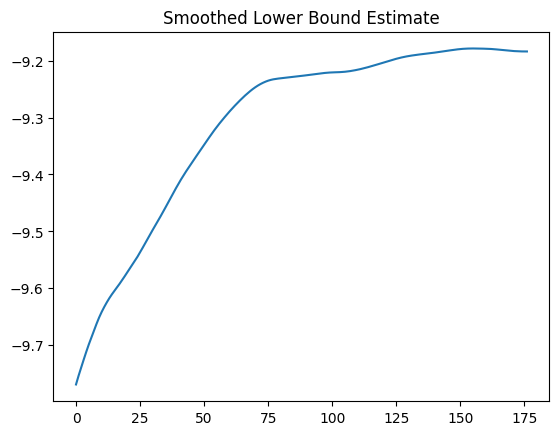

In [ ]:
lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

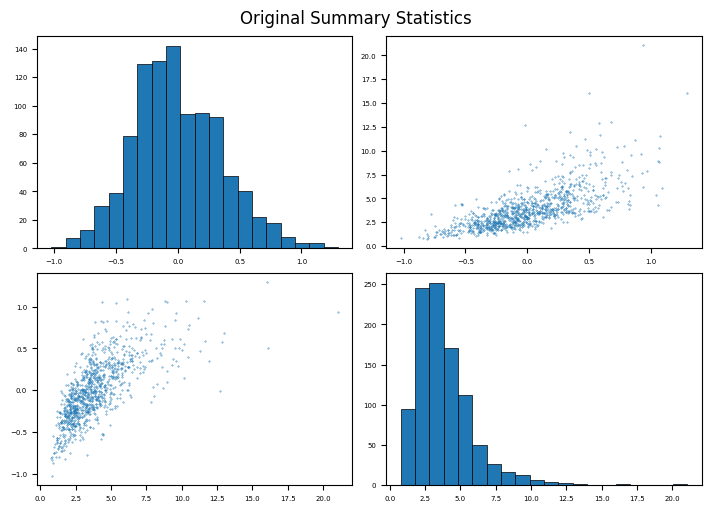

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(2):
    for y in range(2):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


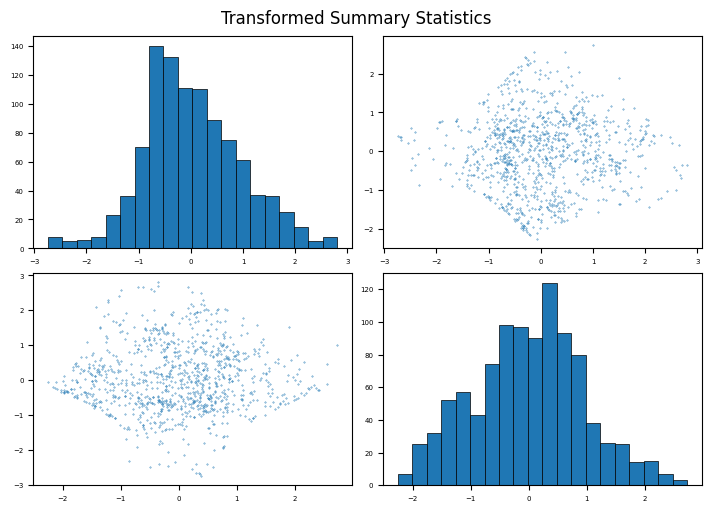

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(2):
    for y in range(2):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [ ]:
# Save original data
np.save('toy_original_without_tau.npy', val_n_summary_statistics)
np.save('toy_transformed_without_tau.npy', wass_val_n_summary_statistics)
files.download('toy_original_without_tau.npy')
files.download('toy_transformed_without_tau.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Load the array from the file
# val_n_summary_statistics = np.load('toy_original_with_tau.npy')
# wass_val_n_summary_statistics = np.load('toy_transformed_with_tau.npy')

In [ ]:
Lambda_list = np.load('Lambda_list_norm.npy', allow_pickle=True)

In [ ]:
# Load the StandardScaler object from the file
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[-0.816723 ,  1.7507836]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [ ]:
def summary_statistics(theta, n_samples, num_datasets): ## EQ 6
    datasets = normal_data(theta, n_samples, num_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(num_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    # cov = jnp.cov(transformed_summary_statistics.T)
    # sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    sample_precision = 1/eps_precision * jnp.eye(actual_summary_statistics.shape[0])
    for i in range(num_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * num_datasets ##### IS IT NEEDED??
    return sample_mean, sample_precision

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    adjusted_sample_mean = sample_mean + (jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))) @ Gamma
    return adjusted_sample_mean, sample_precision

In [ ]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.eye(num_coeffs))
    return log_prior

In [ ]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_precision = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= inverse_sample_precision)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    u_est_log_likelihood = 1/2 * jnp.linalg.slogdet(sample_precision)[1] - 1/2 * part1 #- num_coeffs/2 * jnp.log(2*np.pi) +
    return u_est_log_likelihood

In [ ]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_precision_q = ss_q[1]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision_q)].set(jnp.diag(sample_precision_q)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        # print(llh_gamma)
        # print(prior(Gamma, sigma_latent, num_latent))

        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))
                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
vb = GVB(200, transformed_actual_summary_statistics[0], 0.001, 2500, 100, 0.9, 0.9, 5, 5)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma = jnp.linalg.solve(best_Sigma_inv, jnp.eye(best_Sigma_inv.shape[0]))

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(-0.00527312, dtype=float32)

In [ ]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.005273119

In [ ]:
## FIND BEST COEFFS USING VB

In [ ]:
def unbiased_log_likelihood(theta, actual_summary_statistics, n_samples, num_datasets):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [ ]:
class nn_GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(true_theta)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + llh - fun_log_q(theta_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                # theta_0_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_0, Sigma_0, size = self.samples))
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                # theta_q_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_q, Sigma_q, size = self.samples))
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
nn_vb = nn_GVB(200, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 150, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda_mu, nn_best_lambda_l = nn_vb.vb_posterior(stop)

  0%|          | 1/4000 [00:53<59:39:23, 53.70s/it]

LB -8.113802


  0%|          | 2/4000 [01:43<56:52:01, 51.21s/it]

LB -8.164546


  0%|          | 3/4000 [02:33<56:23:04, 50.78s/it]

LB -8.190952


  0%|          | 4/4000 [03:23<56:06:51, 50.55s/it]

LB -7.983684


  0%|          | 5/4000 [04:14<56:03:46, 50.52s/it]

LB -7.848175


  0%|          | 6/4000 [05:05<56:13:04, 50.67s/it]

LB -7.901846


  0%|          | 7/4000 [05:55<56:08:53, 50.62s/it]

LB -7.8757434


  0%|          | 8/4000 [06:46<56:05:56, 50.59s/it]

LB -7.7877526


  0%|          | 9/4000 [07:36<56:06:54, 50.62s/it]

LB -7.6225467


  0%|          | 10/4000 [08:26<55:51:54, 50.40s/it]

LB -7.738919


  0%|          | 11/4000 [09:17<55:52:58, 50.43s/it]

LB -7.6700788


  0%|          | 12/4000 [10:07<55:52:26, 50.44s/it]

LB -7.6345067


  0%|          | 13/4000 [10:57<55:48:16, 50.39s/it]

LB -7.5826025


  0%|          | 14/4000 [11:47<55:38:52, 50.26s/it]

LB -7.5497203


  0%|          | 15/4000 [12:38<55:35:28, 50.22s/it]

LB -7.546859


  0%|          | 16/4000 [13:28<55:48:38, 50.43s/it]

LB -7.393185


  0%|          | 17/4000 [14:19<55:48:35, 50.44s/it]

LB -7.4368906


  0%|          | 18/4000 [15:10<55:56:11, 50.57s/it]

LB -7.411413


  0%|          | 19/4000 [16:01<56:06:46, 50.74s/it]

LB -7.3395567


  0%|          | 20/4000 [16:51<56:00:57, 50.67s/it]

LB -7.390101


  1%|          | 21/4000 [17:42<56:01:26, 50.69s/it]

LB -7.26561


  1%|          | 22/4000 [18:33<56:00:44, 50.69s/it]

LB -7.2530932


  1%|          | 23/4000 [19:24<56:04:14, 50.76s/it]

LB -7.1395288


  1%|          | 24/4000 [20:14<55:57:32, 50.67s/it]

LB -7.0822906


  1%|          | 25/4000 [21:05<55:54:04, 50.63s/it]

LB -7.165425


  1%|          | 26/4000 [21:55<55:47:48, 50.55s/it]

LB -7.0190845


  1%|          | 27/4000 [22:45<55:35:40, 50.38s/it]

LB -7.072781


  1%|          | 28/4000 [23:35<55:18:00, 50.12s/it]

LB -7.022816


  1%|          | 29/4000 [24:25<55:13:45, 50.07s/it]

LB -7.1513634


  1%|          | 30/4000 [25:15<55:14:46, 50.10s/it]

LB -7.0671983


  1%|          | 31/4000 [26:05<55:24:33, 50.26s/it]

LB -6.955463


  1%|          | 32/4000 [26:56<55:23:20, 50.25s/it]

LB -6.7232304


  1%|          | 33/4000 [27:45<55:11:25, 50.08s/it]

LB -6.8782187


  1%|          | 34/4000 [28:35<55:04:25, 49.99s/it]

LB -6.818042


  1%|          | 35/4000 [29:25<54:55:01, 49.86s/it]

LB -6.93973


  1%|          | 36/4000 [30:14<54:44:45, 49.72s/it]

LB -6.8891764


  1%|          | 37/4000 [31:04<54:51:24, 49.83s/it]

LB -6.923937


  1%|          | 38/4000 [31:53<54:38:42, 49.65s/it]

LB -6.9096932


  1%|          | 39/4000 [32:42<54:22:05, 49.41s/it]

LB -6.7995605


  1%|          | 40/4000 [33:31<54:16:01, 49.33s/it]

LB -6.712597


  1%|          | 41/4000 [34:21<54:23:47, 49.46s/it]

LB -6.5206065


  1%|          | 42/4000 [35:12<54:58:06, 50.00s/it]

LB -6.581276


  1%|          | 43/4000 [36:02<54:57:41, 50.00s/it]

LB -6.5411434


  1%|          | 44/4000 [36:52<54:53:36, 49.95s/it]

LB -6.598618


  1%|          | 45/4000 [37:42<54:52:29, 49.95s/it]

LB -6.5013714


  1%|          | 46/4000 [38:32<54:52:20, 49.96s/it]

LB -6.57212


  1%|          | 47/4000 [39:21<54:38:33, 49.76s/it]

LB -6.6151147


  1%|          | 48/4000 [40:11<54:32:02, 49.68s/it]

LB -6.481573


  1%|          | 49/4000 [41:00<54:24:05, 49.57s/it]

LB -6.4808416


  1%|▏         | 50/4000 [41:50<54:18:38, 49.50s/it]

LB -6.4100914


  1%|▏         | 51/4000 [42:38<54:05:56, 49.32s/it]

LB -6.3735065


  1%|▏         | 52/4000 [43:28<54:12:15, 49.43s/it]

LB -6.26568


  1%|▏         | 53/4000 [44:17<54:04:20, 49.32s/it]

LB -6.334948


  1%|▏         | 54/4000 [45:06<54:02:47, 49.31s/it]

LB -6.3698215


  1%|▏         | 55/4000 [45:56<54:03:36, 49.33s/it]

LB -6.3472266


  1%|▏         | 56/4000 [46:45<54:07:59, 49.41s/it]

LB -6.315121


  1%|▏         | 57/4000 [47:35<54:06:37, 49.40s/it]

LB -6.3300133


  1%|▏         | 58/4000 [48:24<54:04:58, 49.39s/it]

LB -6.225381


  1%|▏         | 59/4000 [49:14<54:09:44, 49.48s/it]

LB -6.2249613


  2%|▏         | 60/4000 [50:04<54:15:32, 49.58s/it]

LB -6.3047004


  2%|▏         | 61/4000 [50:53<54:13:22, 49.56s/it]

LB -6.135899


  2%|▏         | 62/4000 [51:43<54:20:56, 49.68s/it]

LB -6.1740866


  2%|▏         | 63/4000 [52:34<54:44:08, 50.05s/it]

LB -6.184328


  2%|▏         | 64/4000 [53:24<54:48:46, 50.13s/it]

LB -6.1202197


  2%|▏         | 65/4000 [54:14<54:41:17, 50.03s/it]

LB -6.14869


  2%|▏         | 66/4000 [55:04<54:35:15, 49.95s/it]

LB -6.1669097


  2%|▏         | 67/4000 [55:54<54:27:39, 49.85s/it]

LB -6.110661


  2%|▏         | 68/4000 [56:43<54:26:02, 49.84s/it]

LB -6.0300555


  2%|▏         | 69/4000 [57:33<54:28:03, 49.88s/it]

LB -6.131316


  2%|▏         | 70/4000 [58:23<54:20:54, 49.78s/it]

LB -6.04587


  2%|▏         | 71/4000 [59:14<54:36:30, 50.04s/it]

LB -6.044425


  2%|▏         | 72/4000 [1:00:04<54:37:57, 50.07s/it]

LB -6.066964


  2%|▏         | 73/4000 [1:00:55<54:56:24, 50.37s/it]

LB -6.0278826


  2%|▏         | 74/4000 [1:01:46<55:03:09, 50.48s/it]

LB -6.044731


  2%|▏         | 75/4000 [1:02:36<55:00:31, 50.45s/it]

LB -5.983397


  2%|▏         | 76/4000 [1:03:26<54:57:20, 50.42s/it]

LB -5.9433446


  2%|▏         | 77/4000 [1:04:17<54:57:04, 50.43s/it]

LB -6.005155


  2%|▏         | 78/4000 [1:05:09<55:33:50, 51.00s/it]

LB -5.9186454


  2%|▏         | 79/4000 [1:06:00<55:26:40, 50.91s/it]

LB -5.9385266


  2%|▏         | 80/4000 [1:06:51<55:23:20, 50.87s/it]

LB -5.925585


  2%|▏         | 81/4000 [1:07:42<55:35:30, 51.07s/it]

LB -5.983191


  2%|▏         | 82/4000 [1:08:33<55:26:12, 50.94s/it]

LB -5.9458227


  2%|▏         | 83/4000 [1:09:24<55:30:30, 51.02s/it]

LB -5.918093


  2%|▏         | 84/4000 [1:10:15<55:24:34, 50.94s/it]

LB -5.9614115


  2%|▏         | 85/4000 [1:11:05<55:07:40, 50.69s/it]

LB -5.9243493


  2%|▏         | 86/4000 [1:11:55<55:06:03, 50.68s/it]

LB -5.8744836


  2%|▏         | 87/4000 [1:12:46<55:10:48, 50.77s/it]

LB -5.9031506


  2%|▏         | 88/4000 [1:13:38<55:20:14, 50.92s/it]

LB -5.841578


  2%|▏         | 89/4000 [1:14:28<55:15:24, 50.86s/it]

LB -5.85323


  2%|▏         | 90/4000 [1:15:19<55:09:51, 50.79s/it]

LB -5.913124


  2%|▏         | 91/4000 [1:16:08<54:37:37, 50.31s/it]

LB -5.8461046


  2%|▏         | 92/4000 [1:16:58<54:30:59, 50.22s/it]

LB -5.87749


  2%|▏         | 93/4000 [1:17:48<54:27:46, 50.18s/it]

LB -5.8428726


  2%|▏         | 94/4000 [1:18:38<54:23:21, 50.13s/it]

LB -5.871112


  2%|▏         | 95/4000 [1:19:28<54:06:39, 49.88s/it]

LB -5.8396378


  2%|▏         | 96/4000 [1:20:17<53:53:49, 49.70s/it]

LB -5.8099585


  2%|▏         | 97/4000 [1:21:07<53:55:28, 49.74s/it]

LB -5.8472643


  2%|▏         | 98/4000 [1:21:56<53:49:06, 49.65s/it]

LB -5.865948


  2%|▏         | 99/4000 [1:22:47<54:03:25, 49.89s/it]

LB -5.8517437


  2%|▎         | 100/4000 [1:23:37<54:19:28, 50.15s/it]

LB -5.8091187


  3%|▎         | 101/4000 [1:24:28<54:26:34, 50.27s/it]

LB -5.7720094


  3%|▎         | 102/4000 [1:25:18<54:17:46, 50.15s/it]

LB -5.82797


  3%|▎         | 103/4000 [1:26:08<54:11:21, 50.06s/it]

LB -5.840038


  3%|▎         | 104/4000 [1:26:58<54:22:58, 50.25s/it]

LB -5.77892


  3%|▎         | 105/4000 [1:27:48<54:18:49, 50.20s/it]

LB -5.851997


  3%|▎         | 106/4000 [1:28:39<54:23:55, 50.29s/it]

LB -5.8126817


  3%|▎         | 107/4000 [1:29:29<54:10:53, 50.10s/it]

LB -5.797387


  3%|▎         | 108/4000 [1:30:18<54:02:12, 49.98s/it]

LB -5.771019


  3%|▎         | 109/4000 [1:31:08<54:00:45, 49.97s/it]

LB -5.758411


  3%|▎         | 110/4000 [1:31:58<53:55:59, 49.91s/it]

LB -5.788636


  3%|▎         | 111/4000 [1:32:48<53:48:52, 49.82s/it]

LB -5.839556


  3%|▎         | 112/4000 [1:33:37<53:48:59, 49.83s/it]

LB -5.8477526


  3%|▎         | 113/4000 [1:34:27<53:48:36, 49.84s/it]

LB -5.856464


  3%|▎         | 114/4000 [1:35:17<53:46:59, 49.82s/it]

LB -5.8255167


  3%|▎         | 115/4000 [1:36:08<54:03:51, 50.10s/it]

LB -5.775663


  3%|▎         | 116/4000 [1:36:57<53:50:43, 49.91s/it]

LB -5.777379


  3%|▎         | 117/4000 [1:37:47<53:47:20, 49.87s/it]

LB -5.8009324


  3%|▎         | 118/4000 [1:38:37<53:46:58, 49.88s/it]

LB -5.7866125


  3%|▎         | 119/4000 [1:39:27<53:41:48, 49.81s/it]

LB -5.8943486


  3%|▎         | 120/4000 [1:40:16<53:35:32, 49.72s/it]

LB -5.829431


  3%|▎         | 121/4000 [1:41:06<53:35:42, 49.74s/it]

LB -5.784732


  3%|▎         | 122/4000 [1:41:56<53:49:23, 49.96s/it]

LB -5.799067


  3%|▎         | 123/4000 [1:42:46<53:48:37, 49.97s/it]

LB -5.855861


  3%|▎         | 124/4000 [1:43:36<53:47:03, 49.95s/it]

LB -5.8806176


  3%|▎         | 125/4000 [1:44:26<53:32:20, 49.74s/it]

LB -5.8451605


  3%|▎         | 126/4000 [1:45:15<53:27:33, 49.68s/it]

LB -5.8361197


  3%|▎         | 127/4000 [1:46:05<53:26:05, 49.67s/it]

LB -5.792824


  3%|▎         | 128/4000 [1:46:55<53:30:29, 49.75s/it]

LB -5.8763413


  3%|▎         | 129/4000 [1:47:44<53:24:35, 49.67s/it]

LB -5.8559937


  3%|▎         | 130/4000 [1:48:34<53:28:33, 49.75s/it]

LB -5.8423963


  3%|▎         | 131/4000 [1:49:26<54:04:44, 50.32s/it]

LB -5.7808747


  3%|▎         | 132/4000 [1:50:15<53:51:31, 50.13s/it]

LB -5.9075146


  3%|▎         | 133/4000 [1:51:05<53:48:51, 50.10s/it]

LB -5.864653


  3%|▎         | 134/4000 [1:51:55<53:41:23, 50.00s/it]

LB -5.8050632


  3%|▎         | 135/4000 [1:52:45<53:42:32, 50.03s/it]

LB -5.8487983


  3%|▎         | 136/4000 [1:53:35<53:30:26, 49.85s/it]

LB -5.833225


  3%|▎         | 137/4000 [1:54:24<53:25:00, 49.78s/it]

LB -5.8440146


  3%|▎         | 138/4000 [1:55:15<53:35:59, 49.96s/it]

LB -5.779253


  3%|▎         | 139/4000 [1:56:05<53:49:18, 50.18s/it]

LB -5.862863


  4%|▎         | 140/4000 [1:56:56<53:59:57, 50.36s/it]

LB -5.771066


  4%|▎         | 141/4000 [1:57:47<54:12:18, 50.57s/it]

LB -5.8352966


  4%|▎         | 142/4000 [1:58:38<54:13:22, 50.60s/it]

LB -5.7895083


  4%|▎         | 143/4000 [1:59:29<54:20:02, 50.71s/it]

LB -5.8099933


  4%|▎         | 144/4000 [2:00:19<54:11:40, 50.60s/it]

LB -5.732752


  4%|▎         | 145/4000 [2:01:10<54:21:47, 50.77s/it]

LB -5.801494


  4%|▎         | 146/4000 [2:02:01<54:18:47, 50.73s/it]

LB -5.8162045


  4%|▎         | 147/4000 [2:02:51<54:09:36, 50.60s/it]

LB -5.8231874


  4%|▎         | 148/4000 [2:03:42<54:01:02, 50.48s/it]

LB -5.8430095


  4%|▎         | 149/4000 [2:04:32<53:52:35, 50.37s/it]

LB -5.8583765


  4%|▍         | 150/4000 [2:05:21<53:34:39, 50.10s/it]

LB -5.7446213


  4%|▍         | 151/4000 [2:06:10<53:16:49, 49.83s/it]

LB Smoothed -6.335114


  4%|▍         | 152/4000 [2:07:00<53:10:11, 49.74s/it]

LB Smoothed -6.3191075


  4%|▍         | 153/4000 [2:07:50<53:17:18, 49.87s/it]

LB Smoothed -6.3028903


  4%|▍         | 154/4000 [2:08:40<53:12:58, 49.81s/it]

LB Smoothed -6.2879915


  4%|▍         | 155/4000 [2:09:30<53:13:35, 49.83s/it]

LB Smoothed -6.2747326


  4%|▍         | 156/4000 [2:10:20<53:14:02, 49.85s/it]

LB Smoothed -6.2609816


  4%|▍         | 157/4000 [2:11:09<53:05:03, 49.73s/it]

LB Smoothed -6.247031


  4%|▍         | 158/4000 [2:11:58<52:55:14, 49.59s/it]

LB Smoothed -6.2338185


  4%|▍         | 159/4000 [2:12:48<52:51:15, 49.54s/it]

LB Smoothed -6.221843


  4%|▍         | 160/4000 [2:13:37<52:53:37, 49.59s/it]

LB Smoothed -6.2089934


  4%|▍         | 161/4000 [2:14:27<52:49:49, 49.54s/it]

LB Smoothed -6.195962


  4%|▍         | 162/4000 [2:15:16<52:42:24, 49.44s/it]

LB Smoothed -6.1832438


  4%|▍         | 163/4000 [2:16:05<52:40:02, 49.41s/it]

LB Smoothed -6.1712418


  4%|▍         | 164/4000 [2:16:55<52:42:24, 49.46s/it]

LB Smoothed -6.1591167


  4%|▍         | 165/4000 [2:17:44<52:35:38, 49.37s/it]

LB Smoothed -6.1474013


  4%|▍         | 166/4000 [2:18:33<52:31:17, 49.32s/it]

LB Smoothed -6.136615


  4%|▍         | 167/4000 [2:19:23<52:34:24, 49.38s/it]

LB Smoothed -6.125656


  4%|▍         | 168/4000 [2:20:12<52:36:15, 49.42s/it]

LB Smoothed -6.1148787


  4%|▍         | 169/4000 [2:21:02<52:40:52, 49.50s/it]

LB Smoothed -6.104789


  4%|▍         | 170/4000 [2:21:52<52:43:17, 49.56s/it]

LB Smoothed -6.0941186


  4%|▍         | 171/4000 [2:22:41<52:31:39, 49.39s/it]

LB Smoothed -6.08409


  4%|▍         | 172/4000 [2:23:30<52:27:57, 49.34s/it]

LB Smoothed -6.074075


  4%|▍         | 173/4000 [2:24:19<52:22:22, 49.27s/it]

LB Smoothed -6.065286


  4%|▍         | 174/4000 [2:25:08<52:13:10, 49.14s/it]

LB Smoothed -6.056734


  4%|▍         | 175/4000 [2:25:57<52:17:56, 49.22s/it]

LB Smoothed -6.0477514


  4%|▍         | 176/4000 [2:26:47<52:20:45, 49.28s/it]

LB Smoothed -6.040049


  4%|▍         | 177/4000 [2:27:36<52:29:40, 49.43s/it]

LB Smoothed -6.0311565


  4%|▍         | 178/4000 [2:28:27<52:43:29, 49.66s/it]

LB Smoothed -6.022819


  4%|▍         | 179/4000 [2:29:16<52:33:05, 49.51s/it]

LB Smoothed -6.0134993


  4%|▍         | 180/4000 [2:30:06<52:37:15, 49.59s/it]

LB Smoothed -6.0052223


  5%|▍         | 181/4000 [2:30:55<52:33:16, 49.54s/it]

LB Smoothed -5.997846


  5%|▍         | 182/4000 [2:31:44<52:25:36, 49.43s/it]

LB Smoothed -5.991073


  5%|▍         | 183/4000 [2:32:33<52:19:25, 49.35s/it]

LB Smoothed -5.9842052


  5%|▍         | 184/4000 [2:33:23<52:16:13, 49.31s/it]

LB Smoothed -5.97728


  5%|▍         | 185/4000 [2:34:12<52:17:03, 49.34s/it]

LB Smoothed -5.9698796


  5%|▍         | 186/4000 [2:35:02<52:27:35, 49.52s/it]

LB Smoothed -5.962526


  5%|▍         | 187/4000 [2:35:52<52:30:15, 49.57s/it]

LB Smoothed -5.954484


  5%|▍         | 188/4000 [2:36:41<52:31:53, 49.61s/it]

LB Smoothed -5.947144


  5%|▍         | 189/4000 [2:37:31<52:35:03, 49.67s/it]

LB Smoothed -5.940751


  5%|▍         | 190/4000 [2:38:21<52:37:22, 49.72s/it]

LB Smoothed -5.934642


  5%|▍         | 191/4000 [2:39:10<52:29:53, 49.62s/it]

LB Smoothed -5.9293


  5%|▍         | 192/4000 [2:40:02<52:59:24, 50.10s/it]

LB Smoothed -5.9244924


  5%|▍         | 193/4000 [2:40:51<52:47:38, 49.92s/it]

LB Smoothed -5.9191036


  5%|▍         | 194/4000 [2:41:41<52:44:42, 49.89s/it]

LB Smoothed -5.913843


  5%|▍         | 195/4000 [2:42:30<52:27:58, 49.64s/it]

LB Smoothed -5.9090633


  5%|▍         | 196/4000 [2:43:20<52:26:41, 49.63s/it]

LB Smoothed -5.90373


  5%|▍         | 197/4000 [2:44:08<52:10:28, 49.39s/it]

LB Smoothed -5.8984566


  5%|▍         | 198/4000 [2:44:58<52:07:38, 49.36s/it]

LB Smoothed -5.894366


  5%|▍         | 199/4000 [2:45:47<52:15:30, 49.49s/it]

LB Smoothed -5.8896155


  5%|▌         | 200/4000 [2:46:37<52:14:18, 49.49s/it]

LB Smoothed -5.885353


  5%|▌         | 201/4000 [2:47:27<52:16:14, 49.53s/it]

LB Smoothed -5.881642


  5%|▌         | 202/4000 [2:48:16<52:12:20, 49.48s/it]

LB Smoothed -5.8785567


  5%|▌         | 203/4000 [2:49:07<52:40:36, 49.94s/it]

LB Smoothed -5.875098


  5%|▌         | 204/4000 [2:49:58<53:00:37, 50.27s/it]

LB Smoothed -5.871636


  5%|▌         | 205/4000 [2:50:48<52:59:19, 50.27s/it]

LB Smoothed -5.867811


  5%|▌         | 206/4000 [2:51:39<53:06:17, 50.39s/it]

LB Smoothed -5.864022


  5%|▌         | 207/4000 [2:52:29<53:07:26, 50.42s/it]

LB Smoothed -5.860267


  5%|▌         | 208/4000 [2:53:19<52:59:22, 50.31s/it]

LB Smoothed -5.8575206


  5%|▌         | 209/4000 [2:54:09<52:48:02, 50.14s/it]

LB Smoothed -5.854729


  5%|▌         | 210/4000 [2:54:59<52:43:33, 50.08s/it]

LB Smoothed -5.851094


  5%|▌         | 211/4000 [2:55:49<52:43:31, 50.10s/it]

LB Smoothed -5.8489122


  5%|▌         | 212/4000 [2:56:39<52:38:28, 50.03s/it]

LB Smoothed -5.846798


  5%|▌         | 213/4000 [2:57:29<52:29:57, 49.91s/it]

LB Smoothed -5.8440304


  5%|▌         | 214/4000 [2:58:18<52:25:09, 49.84s/it]

LB Smoothed -5.8420753


  5%|▌         | 215/4000 [2:59:08<52:25:03, 49.86s/it]

LB Smoothed -5.8399734


  5%|▌         | 216/4000 [2:59:58<52:24:18, 49.86s/it]

LB Smoothed -5.8376565


  5%|▌         | 217/4000 [3:00:50<53:02:51, 50.48s/it]

LB Smoothed -5.835714


  5%|▌         | 218/4000 [3:01:40<52:58:49, 50.43s/it]

LB Smoothed -5.8345113


  5%|▌         | 219/4000 [3:02:30<52:49:45, 50.30s/it]

LB Smoothed -5.8325257


  6%|▌         | 220/4000 [3:03:21<52:45:36, 50.25s/it]

LB Smoothed -5.831219


  6%|▌         | 221/4000 [3:04:10<52:23:50, 49.92s/it]

LB Smoothed -5.829472


  6%|▌         | 222/4000 [3:04:59<52:16:16, 49.81s/it]

LB Smoothed -5.8277645


  6%|▌         | 223/4000 [3:05:49<52:22:12, 49.92s/it]

LB Smoothed -5.826458


  6%|▌         | 224/4000 [3:06:39<52:23:56, 49.96s/it]

LB Smoothed -5.824969


  6%|▌         | 225/4000 [3:07:30<52:36:15, 50.17s/it]

LB Smoothed -5.8235955


  6%|▌         | 226/4000 [3:08:21<52:39:26, 50.23s/it]

LB Smoothed -5.822827


  6%|▌         | 227/4000 [3:09:10<52:20:47, 49.95s/it]

LB Smoothed -5.821695


  6%|▌         | 228/4000 [3:10:01<52:43:50, 50.33s/it]

LB Smoothed -5.8209777


  6%|▌         | 229/4000 [3:10:51<52:34:52, 50.20s/it]

LB Smoothed -5.8199964


  6%|▌         | 230/4000 [3:11:41<52:26:17, 50.07s/it]

LB Smoothed -5.819342


  6%|▌         | 231/4000 [3:12:30<52:11:26, 49.85s/it]

LB Smoothed -5.8182497


  6%|▌         | 232/4000 [3:13:20<52:14:04, 49.91s/it]

LB Smoothed -5.8177624


  6%|▌         | 233/4000 [3:14:11<52:23:55, 50.08s/it]

LB Smoothed -5.816842


  6%|▌         | 234/4000 [3:15:01<52:25:22, 50.11s/it]

LB Smoothed -5.8154345


  6%|▌         | 235/4000 [3:15:51<52:25:07, 50.12s/it]

LB Smoothed -5.814603


  6%|▌         | 236/4000 [3:16:41<52:16:39, 50.00s/it]

LB Smoothed -5.8140364


  6%|▌         | 237/4000 [3:17:30<52:04:27, 49.82s/it]

LB Smoothed -5.813737


  6%|▌         | 238/4000 [3:18:19<51:54:27, 49.67s/it]

LB Smoothed -5.8134923


  6%|▌         | 239/4000 [3:19:08<51:43:24, 49.51s/it]

LB Smoothed -5.8132677


  6%|▌         | 240/4000 [3:19:59<51:56:39, 49.73s/it]

LB Smoothed -5.8128285


  6%|▌         | 241/4000 [3:20:49<52:08:05, 49.93s/it]

LB Smoothed -5.8127804


  6%|▌         | 242/4000 [3:21:39<52:14:36, 50.05s/it]

LB Smoothed -5.8123946


  6%|▌         | 243/4000 [3:22:29<52:13:50, 50.05s/it]

LB Smoothed -5.812361


  6%|▌         | 244/4000 [3:23:20<52:18:12, 50.13s/it]

LB Smoothed -5.811812


  6%|▌         | 245/4000 [3:24:10<52:19:10, 50.16s/it]

LB Smoothed -5.8117995


  6%|▌         | 246/4000 [3:25:00<52:12:26, 50.07s/it]

LB Smoothed -5.8116503


  6%|▌         | 247/4000 [3:25:50<52:13:27, 50.10s/it]

LB Smoothed -5.8116574


  6%|▌         | 248/4000 [3:26:40<52:13:48, 50.11s/it]

LB Smoothed -5.811244


  6%|▌         | 249/4000 [3:27:30<52:06:19, 50.01s/it]

LB Smoothed -5.8108654


  6%|▋         | 250/4000 [3:28:20<52:08:05, 50.05s/it]

LB Smoothed -5.8112407


  6%|▋         | 251/4000 [3:29:10<52:05:30, 50.02s/it]

LB Smoothed -5.811341


  6%|▋         | 252/4000 [3:30:00<52:08:28, 50.08s/it]

LB Smoothed -5.811651


  6%|▋         | 253/4000 [3:30:50<52:01:10, 49.98s/it]

LB Smoothed -5.8112254


  6%|▋         | 254/4000 [3:31:41<52:11:30, 50.16s/it]

LB Smoothed -5.8116145


  6%|▋         | 255/4000 [3:32:31<52:09:09, 50.13s/it]

LB Smoothed -5.810938


  6%|▋         | 256/4000 [3:33:21<52:10:05, 50.16s/it]

LB Smoothed -5.8112845


  6%|▋         | 257/4000 [3:34:11<52:07:51, 50.14s/it]

LB Smoothed -5.811237


  6%|▋         | 258/4000 [3:35:01<52:03:26, 50.08s/it]

LB Smoothed -5.8113604


  6%|▋         | 259/4000 [3:35:51<52:11:36, 50.23s/it]

LB Smoothed -5.8120337


  6%|▋         | 260/4000 [3:36:42<52:15:04, 50.30s/it]

LB Smoothed -5.8121934


  7%|▋         | 261/4000 [3:37:32<52:08:15, 50.20s/it]

LB Smoothed -5.8118014


  7%|▋         | 262/4000 [3:38:22<52:02:22, 50.12s/it]

LB Smoothed -5.8116627


  7%|▋         | 263/4000 [3:39:12<52:00:08, 50.10s/it]

LB Smoothed -5.811121


  7%|▋         | 264/4000 [3:40:02<51:58:32, 50.08s/it]

LB Smoothed -5.81126


  7%|▋         | 265/4000 [3:40:52<51:58:06, 50.09s/it]

LB Smoothed -5.8114495


  7%|▋         | 266/4000 [3:41:42<51:49:12, 49.96s/it]

LB Smoothed -5.8118668


  7%|▋         | 267/4000 [3:42:31<51:41:23, 49.85s/it]

LB Smoothed -5.811538


  7%|▋         | 268/4000 [3:43:22<52:03:07, 50.21s/it]

LB Smoothed -5.8116026


  7%|▋         | 269/4000 [3:44:12<51:58:30, 50.15s/it]

LB Smoothed -5.8112164


  7%|▋         | 270/4000 [3:45:02<51:46:43, 49.97s/it]

LB Smoothed -5.8111515


  7%|▋         | 271/4000 [3:45:51<51:37:58, 49.85s/it]

LB Smoothed -5.811912


  7%|▋         | 272/4000 [3:46:41<51:39:20, 49.88s/it]

LB Smoothed -5.812047


  7%|▋         | 273/4000 [3:47:31<51:36:14, 49.85s/it]

LB Smoothed -5.8118997


  7%|▋         | 274/4000 [3:48:21<51:39:40, 49.91s/it]

LB Smoothed -5.8113956


  7%|▋         | 275/4000 [3:49:11<51:42:57, 49.98s/it]

LB Smoothed -5.811432


  7%|▋         | 276/4000 [3:50:01<51:30:34, 49.79s/it]

LB Smoothed -5.811577


  7%|▋         | 277/4000 [3:50:51<51:31:58, 49.83s/it]

LB Smoothed -5.8119497


  7%|▋         | 278/4000 [3:51:41<51:35:02, 49.89s/it]

LB Smoothed -5.8115044


  7%|▋         | 279/4000 [3:52:30<51:26:36, 49.77s/it]

LB Smoothed -5.8113694


  7%|▋         | 280/4000 [3:53:20<51:35:06, 49.92s/it]

LB Smoothed -5.811054


  7%|▋         | 281/4000 [3:54:11<51:44:15, 50.08s/it]

LB Smoothed -5.8108225


  7%|▋         | 282/4000 [3:55:01<51:44:17, 50.10s/it]

LB Smoothed -5.8104067


  7%|▋         | 283/4000 [3:55:51<51:44:11, 50.11s/it]

LB Smoothed -5.810298


  7%|▋         | 284/4000 [3:56:42<51:56:50, 50.33s/it]

LB Smoothed -5.8104258


  7%|▋         | 285/4000 [3:57:32<51:43:17, 50.12s/it]

LB Smoothed -5.8103366


  7%|▋         | 286/4000 [3:58:22<51:46:00, 50.18s/it]

LB Smoothed -5.8105087


  7%|▋         | 287/4000 [3:59:12<51:45:30, 50.18s/it]

LB Smoothed -5.8106875


  7%|▋         | 288/4000 [4:00:02<51:38:03, 50.08s/it]

LB Smoothed -5.811196


  7%|▋         | 289/4000 [4:00:52<51:43:18, 50.17s/it]

LB Smoothed -5.8110294


  7%|▋         | 290/4000 [4:01:42<51:32:12, 50.01s/it]

LB Smoothed -5.8114896


  7%|▋         | 291/4000 [4:02:32<51:32:12, 50.02s/it]

LB Smoothed -5.8113804


  7%|▋         | 292/4000 [4:03:22<51:26:28, 49.94s/it]

LB Smoothed -5.811376


  7%|▋         | 293/4000 [4:04:12<51:24:32, 49.93s/it]

LB Smoothed -5.811217


  7%|▋         | 294/4000 [4:05:02<51:26:52, 49.98s/it]

LB Smoothed -5.8116


  7%|▋         | 295/4000 [4:05:53<51:41:38, 50.23s/it]

LB Smoothed -5.8120656


  7%|▋         | 296/4000 [4:06:42<51:23:09, 49.94s/it]

LB Smoothed -5.812021


  7%|▋         | 297/4000 [4:07:31<51:12:47, 49.79s/it]

LB Smoothed -5.811885


  7%|▋         | 298/4000 [4:08:21<51:13:13, 49.81s/it]

LB Smoothed -5.811563


  7%|▋         | 299/4000 [4:09:11<51:04:52, 49.69s/it]

LB Smoothed -5.811464


  8%|▊         | 300/4000 [4:10:01<51:09:37, 49.78s/it]

LB Smoothed -5.8121524


  8%|▊         | 301/4000 [4:10:50<51:05:17, 49.72s/it]

LB Smoothed -5.812623


  8%|▊         | 302/4000 [4:11:40<51:05:42, 49.74s/it]

LB Smoothed -5.812996


  8%|▊         | 303/4000 [4:12:30<51:00:43, 49.67s/it]

LB Smoothed -5.8135514


  8%|▊         | 304/4000 [4:13:19<50:57:09, 49.63s/it]

LB Smoothed -5.813853


  8%|▊         | 305/4000 [4:14:09<50:55:13, 49.61s/it]

LB Smoothed -5.814268


  8%|▊         | 306/4000 [4:14:58<50:54:51, 49.62s/it]

LB Smoothed -5.814907


  8%|▊         | 307/4000 [4:15:48<51:02:08, 49.75s/it]

LB Smoothed -5.8144736


  8%|▊         | 308/4000 [4:16:38<51:03:55, 49.79s/it]

LB Smoothed -5.814626


  8%|▊         | 309/4000 [4:17:28<50:59:41, 49.74s/it]

LB Smoothed -5.8147936


  8%|▊         | 310/4000 [4:18:17<50:58:00, 49.72s/it]

LB Smoothed -5.8160124


  8%|▊         | 311/4000 [4:19:07<50:56:18, 49.71s/it]

LB Smoothed -5.8166084


  8%|▊         | 312/4000 [4:19:56<50:45:52, 49.55s/it]

LB Smoothed -5.817089


  8%|▊         | 313/4000 [4:20:46<50:48:50, 49.62s/it]

LB Smoothed -5.81762


  8%|▊         | 314/4000 [4:21:35<50:39:36, 49.48s/it]

LB Smoothed -5.818261


  8%|▊         | 315/4000 [4:22:25<50:46:19, 49.60s/it]

LB Smoothed -5.819095


  8%|▊         | 316/4000 [4:23:15<50:50:12, 49.68s/it]

LB Smoothed -5.8190246


  8%|▊         | 317/4000 [4:24:06<51:08:46, 49.99s/it]

LB Smoothed -5.819712


  8%|▊         | 318/4000 [4:24:55<50:58:13, 49.84s/it]

LB Smoothed -5.819462


  8%|▊         | 319/4000 [4:25:45<50:53:39, 49.77s/it]

LB Smoothed -5.8198266


  8%|▊         | 320/4000 [4:26:35<50:58:54, 49.87s/it]

LB Smoothed -5.8205314


  8%|▊         | 321/4000 [4:27:24<50:49:12, 49.73s/it]

LB Smoothed -5.82124


  8%|▊         | 322/4000 [4:28:14<50:52:43, 49.80s/it]

LB Smoothed -5.8213606


  8%|▊         | 323/4000 [4:29:04<50:58:26, 49.91s/it]

LB Smoothed -5.8216357


  8%|▊         | 324/4000 [4:29:54<50:58:51, 49.93s/it]

LB Smoothed -5.821583


  8%|▊         | 325/4000 [4:30:45<51:08:55, 50.10s/it]

LB Smoothed -5.821474


  8%|▊         | 326/4000 [4:31:36<51:19:00, 50.28s/it]

LB Smoothed -5.8218513


  8%|▊         | 327/4000 [4:32:26<51:27:26, 50.43s/it]

LB Smoothed -5.821932


  8%|▊         | 328/4000 [4:33:17<51:28:18, 50.46s/it]

LB Smoothed -5.8224115


  8%|▊         | 329/4000 [4:34:07<51:17:33, 50.30s/it]

LB Smoothed -5.822298


  8%|▊         | 330/4000 [4:34:57<51:05:04, 50.11s/it]

LB Smoothed -5.8223605


  8%|▊         | 331/4000 [4:35:47<51:01:17, 50.06s/it]

LB Smoothed -5.8229623


  8%|▊         | 332/4000 [4:36:36<50:57:32, 50.01s/it]

LB Smoothed -5.8230543


  8%|▊         | 333/4000 [4:37:26<50:50:17, 49.91s/it]

LB Smoothed -5.823292


  8%|▊         | 333/4000 [4:38:16<51:04:17, 50.14s/it]

LB Smoothed -5.823743
Stop at 333


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

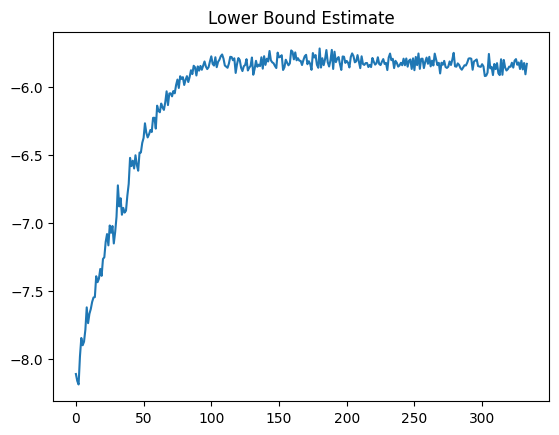

In [ ]:
lb_df = pd.DataFrame(np.array(nn_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

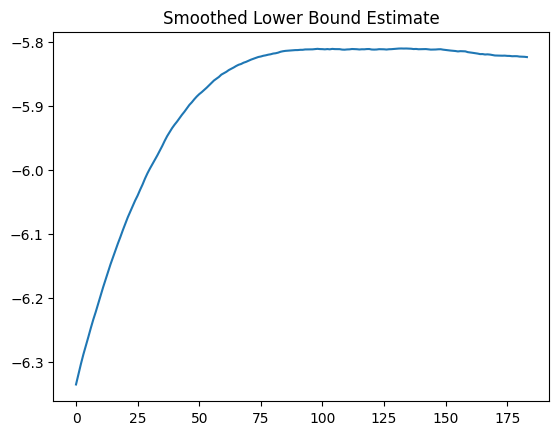

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
nn_best_lambda_mu = jnp.array([0.17865463])

In [ ]:
nn_best_lambda_l = jnp.array([10.4562645])

In [ ]:
best_mu = nn_best_lambda_mu
best_vech_l = list(nn_best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma = jnp.linalg.solve(best_Sigma_inv, jnp.eye(best_Sigma_inv.shape[0]))

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(0.17802486, dtype=float32)

In [ ]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.17802486

## MCMC

In [ ]:
num_samples = 1000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = jnp.ones((samples, theta_size))  # posterior of all weights and bias over all samples

    theta = jnp.array([0])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_precision = ss[1]
    # sample_variance_q = ss_q[2]
    # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

    # Nuissance mean and variance: PAGE 9
    # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
    diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
    # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    variance_nuissance = mean_nuissance_p1

    # Generate Gamma

    Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, actual_summary_statistics, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    # ---------------------

    prior_current = prior(theta, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = jnp.cov(pos_theta[0:i, :].T)
                Sign = jnp.reshape(Sign, jnp.shape(jnp.identity(theta_size)))
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
            else:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = (2.38**2/theta_size) * Sign)

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_precision = ss[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance = mean_nuissance_p1

        # Generate Gamma
        Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta = theta_proposal
            pos_theta = pos_theta.at[i + 1,].set(theta_proposal)
            print(i, pos_theta[i + 1,])

        else:
            pos_theta = pos_theta.at[i + 1,].set(pos_theta[i,])

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, accept_ratio)

In [ ]:
pos_w, accept_ratio = sampler(num_samples)

  0%|          | 1/999 [00:01<29:04,  1.75s/it]

0 [-0.06461436]


  0%|          | 2/999 [00:03<24:16,  1.46s/it]

1 [-0.2122933]


  0%|          | 3/999 [00:04<22:23,  1.35s/it]

2 [-0.33817035]


  0%|          | 4/999 [00:05<21:19,  1.29s/it]

3 [-0.51985264]


  1%|          | 5/999 [00:06<20:38,  1.25s/it]

4 [-0.6255475]


  1%|          | 7/999 [00:08<20:10,  1.22s/it]

6 [-0.7226155]


  1%|          | 8/999 [00:10<19:52,  1.20s/it]

7 [-0.62251806]


  1%|          | 9/999 [00:11<19:11,  1.16s/it]

8 [-0.655951]


  1%|          | 10/999 [00:12<18:52,  1.14s/it]

9 [-0.37722003]


  1%|          | 11/999 [00:13<18:41,  1.14s/it]

10 [-0.3390231]


  1%|          | 12/999 [00:14<18:33,  1.13s/it]

11 [-0.346911]


  1%|▏         | 13/999 [00:15<18:33,  1.13s/it]

12 [-0.29582253]


  1%|▏         | 14/999 [00:16<18:37,  1.13s/it]

13 [-0.26851118]


  2%|▏         | 15/999 [00:17<18:25,  1.12s/it]

14 [-0.26578718]


  2%|▏         | 16/999 [00:19<18:50,  1.15s/it]

15 [-0.18608603]


  2%|▏         | 17/999 [00:20<18:54,  1.15s/it]

16 [-0.12509003]


  2%|▏         | 19/999 [00:22<18:09,  1.11s/it]

18 [-0.07108067]


  2%|▏         | 20/999 [00:23<17:55,  1.10s/it]

19 [-0.059995]


  2%|▏         | 21/999 [00:24<17:47,  1.09s/it]

20 [-0.02601705]


  2%|▏         | 22/999 [00:25<18:09,  1.12s/it]

21 [0.02522172]


  2%|▏         | 23/999 [00:26<18:02,  1.11s/it]

22 [-0.02458546]


  2%|▏         | 24/999 [00:28<18:27,  1.14s/it]

23 [0.18203975]


  3%|▎         | 25/999 [00:29<18:31,  1.14s/it]

24 [0.15016617]


  3%|▎         | 26/999 [00:30<18:38,  1.15s/it]

25 [0.26719147]


  3%|▎         | 27/999 [00:31<18:54,  1.17s/it]

26 [0.20279121]


  3%|▎         | 28/999 [00:32<18:58,  1.17s/it]

27 [0.11024328]


  3%|▎         | 29/999 [00:33<18:29,  1.14s/it]

28 [0.17572147]


  3%|▎         | 30/999 [00:34<18:22,  1.14s/it]

29 [0.10959728]


  3%|▎         | 31/999 [00:36<18:25,  1.14s/it]

30 [-0.00608324]


  3%|▎         | 32/999 [00:37<18:09,  1.13s/it]

31 [0.0138464]


  3%|▎         | 33/999 [00:38<18:19,  1.14s/it]

32 [-0.00600468]


  3%|▎         | 34/999 [00:39<18:04,  1.12s/it]

33 [-0.1528018]


  4%|▎         | 35/999 [00:40<17:45,  1.10s/it]

34 [-0.13543484]


  4%|▎         | 36/999 [00:41<18:15,  1.14s/it]

35 [0.10821198]


  4%|▎         | 37/999 [00:42<18:24,  1.15s/it]

36 [0.18536136]


  4%|▍         | 38/999 [00:44<18:24,  1.15s/it]

37 [0.12266207]


  4%|▍         | 39/999 [00:45<18:16,  1.14s/it]

38 [0.02852633]


  4%|▍         | 40/999 [00:46<18:01,  1.13s/it]

39 [-0.04747062]


  4%|▍         | 41/999 [00:47<18:14,  1.14s/it]

40 [-0.31957102]


  4%|▍         | 42/999 [00:48<18:20,  1.15s/it]

41 [-0.41808218]


  4%|▍         | 43/999 [00:49<18:01,  1.13s/it]

42 [-0.32175392]


  4%|▍         | 44/999 [00:50<17:58,  1.13s/it]

43 [-0.34135506]


  5%|▍         | 45/999 [00:51<18:02,  1.13s/it]

44 [-0.36986697]


  5%|▍         | 46/999 [00:53<17:51,  1.12s/it]

45 [-0.22393174]


  5%|▍         | 47/999 [00:54<17:57,  1.13s/it]

46 [-0.26819286]


  5%|▍         | 48/999 [00:55<18:05,  1.14s/it]

47 [-0.13461967]


  5%|▍         | 49/999 [00:56<17:48,  1.12s/it]

48 [-0.09121156]


  5%|▌         | 50/999 [00:57<17:53,  1.13s/it]

49 [-0.02452593]


  5%|▌         | 51/999 [00:58<17:31,  1.11s/it]

50 [-0.06372842]


  5%|▌         | 52/999 [00:59<17:47,  1.13s/it]

51 [0.01538489]


  5%|▌         | 53/999 [01:01<18:16,  1.16s/it]

52 [0.32951072]


  5%|▌         | 54/999 [01:02<18:17,  1.16s/it]

53 [0.36159915]


  6%|▌         | 55/999 [01:03<18:09,  1.15s/it]

54 [0.3888121]


  6%|▌         | 56/999 [01:04<18:33,  1.18s/it]

55 [0.22607498]


  6%|▌         | 57/999 [01:05<18:39,  1.19s/it]

56 [-0.07917945]


  6%|▌         | 58/999 [01:07<18:39,  1.19s/it]

57 [-0.09176882]


  6%|▌         | 59/999 [01:08<18:08,  1.16s/it]

58 [-0.08132176]


  6%|▌         | 60/999 [01:09<18:06,  1.16s/it]

59 [-0.14765781]


  6%|▌         | 61/999 [01:10<18:03,  1.16s/it]

60 [-0.10349678]


  6%|▌         | 62/999 [01:11<17:57,  1.15s/it]

61 [0.12899126]


  6%|▋         | 63/999 [01:12<17:52,  1.15s/it]

62 [0.21543908]


  6%|▋         | 64/999 [01:13<17:42,  1.14s/it]

63 [0.27449253]


  7%|▋         | 65/999 [01:14<17:35,  1.13s/it]

64 [0.3744518]


  7%|▋         | 66/999 [01:16<17:55,  1.15s/it]

65 [0.17886515]


  7%|▋         | 67/999 [01:17<18:13,  1.17s/it]

66 [0.2116875]


  7%|▋         | 68/999 [01:18<18:28,  1.19s/it]

67 [0.31866944]


  7%|▋         | 69/999 [01:19<18:12,  1.17s/it]

68 [0.21989605]


  7%|▋         | 70/999 [01:20<17:57,  1.16s/it]

69 [0.33757156]


  7%|▋         | 71/999 [01:22<18:03,  1.17s/it]

70 [0.16995108]


  7%|▋         | 72/999 [01:23<17:28,  1.13s/it]

71 [0.25557566]


  7%|▋         | 73/999 [01:24<17:25,  1.13s/it]

72 [0.359174]


  7%|▋         | 74/999 [01:25<17:48,  1.15s/it]

73 [0.28187063]


  8%|▊         | 75/999 [01:26<18:05,  1.17s/it]

74 [0.25888476]


  8%|▊         | 76/999 [01:27<18:07,  1.18s/it]

75 [0.16929114]


  8%|▊         | 77/999 [01:28<17:47,  1.16s/it]

76 [0.21639907]


  8%|▊         | 78/999 [01:30<17:44,  1.16s/it]

77 [0.34513527]


  8%|▊         | 79/999 [01:31<17:45,  1.16s/it]

78 [0.36073312]


  8%|▊         | 80/999 [01:32<17:38,  1.15s/it]

79 [0.40395623]


  8%|▊         | 81/999 [01:33<17:51,  1.17s/it]

80 [0.39906412]


  8%|▊         | 82/999 [01:34<17:27,  1.14s/it]

81 [0.55798924]


  8%|▊         | 83/999 [01:35<17:07,  1.12s/it]

82 [0.47591466]


  8%|▊         | 84/999 [01:36<17:23,  1.14s/it]

83 [0.51392514]


  9%|▊         | 85/999 [01:38<17:34,  1.15s/it]

84 [0.4920954]


  9%|▊         | 86/999 [01:39<17:41,  1.16s/it]

85 [0.6138336]


  9%|▊         | 87/999 [01:40<17:20,  1.14s/it]

86 [0.61959755]


  9%|▉         | 88/999 [01:41<17:28,  1.15s/it]

87 [0.86859196]


  9%|▉         | 89/999 [01:42<17:36,  1.16s/it]

88 [0.847418]


  9%|▉         | 90/999 [01:43<17:53,  1.18s/it]

89 [0.9655789]


  9%|▉         | 91/999 [01:45<17:21,  1.15s/it]

90 [0.8793083]


  9%|▉         | 92/999 [01:46<17:26,  1.15s/it]

91 [0.8704101]


  9%|▉         | 93/999 [01:47<17:19,  1.15s/it]

92 [0.96097165]


  9%|▉         | 94/999 [01:48<17:49,  1.18s/it]

93 [1.0641665]


 10%|▉         | 95/999 [01:49<17:44,  1.18s/it]

94 [0.9314418]


 10%|▉         | 96/999 [01:50<17:23,  1.16s/it]

95 [1.0643094]


 10%|▉         | 97/999 [01:51<16:53,  1.12s/it]

96 [0.98509145]


 10%|▉         | 98/999 [01:53<16:58,  1.13s/it]

97 [0.9940073]


 10%|▉         | 99/999 [01:54<16:59,  1.13s/it]

98 [0.76061267]


 10%|█         | 100/999 [01:55<17:00,  1.14s/it]

99 [0.7906659]


 10%|█         | 102/999 [01:57<17:14,  1.15s/it]

101 [0.89535135]


 10%|█         | 103/999 [01:58<17:13,  1.15s/it]

102 [1.0180866]


 10%|█         | 104/999 [01:59<16:57,  1.14s/it]

103 [1.0290993]


 11%|█         | 105/999 [02:01<17:25,  1.17s/it]

104 [0.8419841]


 11%|█         | 106/999 [02:02<17:16,  1.16s/it]

105 [0.8845951]


 11%|█         | 107/999 [02:03<17:08,  1.15s/it]

106 [0.92820346]


 11%|█         | 108/999 [02:04<16:59,  1.14s/it]

107 [0.9448604]


 11%|█         | 109/999 [02:05<17:31,  1.18s/it]

108 [0.97906625]


 11%|█         | 110/999 [02:07<17:22,  1.17s/it]

109 [0.9191623]


 11%|█         | 111/999 [02:08<17:26,  1.18s/it]

110 [0.92289364]


 11%|█         | 112/999 [02:09<17:01,  1.15s/it]

111 [1.0914873]


 11%|█▏        | 113/999 [02:10<16:52,  1.14s/it]

112 [0.909459]


 11%|█▏        | 114/999 [02:11<17:09,  1.16s/it]

113 [1.084637]


 12%|█▏        | 115/999 [02:12<17:23,  1.18s/it]

114 [0.8317323]


 12%|█▏        | 116/999 [02:14<17:14,  1.17s/it]

115 [0.83867836]


 12%|█▏        | 117/999 [02:15<17:09,  1.17s/it]

116 [0.8734954]


 12%|█▏        | 118/999 [02:16<17:00,  1.16s/it]

117 [0.8128345]


 12%|█▏        | 119/999 [02:17<16:43,  1.14s/it]

118 [0.82952315]


 12%|█▏        | 120/999 [02:18<16:49,  1.15s/it]

119 [0.8526154]


 12%|█▏        | 121/999 [02:19<16:57,  1.16s/it]

120 [0.9097489]


 12%|█▏        | 122/999 [02:20<16:52,  1.15s/it]

121 [0.7343315]


 12%|█▏        | 123/999 [02:22<16:44,  1.15s/it]

122 [0.8681952]


 12%|█▏        | 124/999 [02:23<16:39,  1.14s/it]

123 [0.7441242]


 13%|█▎        | 125/999 [02:24<16:40,  1.14s/it]

124 [0.7781123]


 13%|█▎        | 126/999 [02:25<16:42,  1.15s/it]

125 [0.84289664]


 13%|█▎        | 127/999 [02:26<16:36,  1.14s/it]

126 [0.89037794]


 13%|█▎        | 128/999 [02:27<16:28,  1.14s/it]

127 [0.84875286]


 13%|█▎        | 129/999 [02:28<16:21,  1.13s/it]

128 [0.6609906]


 13%|█▎        | 130/999 [02:30<16:36,  1.15s/it]

129 [0.6823826]


 13%|█▎        | 131/999 [02:31<16:20,  1.13s/it]

130 [0.67365736]


 13%|█▎        | 132/999 [02:32<16:16,  1.13s/it]

131 [0.6853029]


 13%|█▎        | 133/999 [02:33<16:49,  1.17s/it]

132 [0.7351429]


 13%|█▎        | 134/999 [02:34<16:43,  1.16s/it]

133 [0.84232223]


 14%|█▎        | 135/999 [02:35<16:39,  1.16s/it]

134 [0.7264848]


 14%|█▎        | 136/999 [02:36<16:26,  1.14s/it]

135 [0.77466893]


 14%|█▎        | 137/999 [02:37<15:59,  1.11s/it]

136 [0.7872893]


 14%|█▍        | 138/999 [02:39<16:03,  1.12s/it]

137 [0.77967376]


 14%|█▍        | 139/999 [02:40<15:59,  1.12s/it]

138 [0.5187925]


 14%|█▍        | 140/999 [02:41<15:46,  1.10s/it]

139 [0.46868205]


 14%|█▍        | 141/999 [02:42<16:02,  1.12s/it]

140 [0.34035784]


 14%|█▍        | 142/999 [02:43<16:09,  1.13s/it]

141 [0.3604969]


 14%|█▍        | 143/999 [02:44<15:52,  1.11s/it]

142 [0.4220297]


 14%|█▍        | 144/999 [02:45<15:47,  1.11s/it]

143 [0.54471505]


 15%|█▍        | 145/999 [02:46<16:16,  1.14s/it]

144 [0.59366685]


 15%|█▍        | 146/999 [02:48<15:54,  1.12s/it]

145 [0.8303021]


 15%|█▍        | 147/999 [02:49<16:07,  1.14s/it]

146 [0.7645689]


 15%|█▍        | 148/999 [02:50<16:27,  1.16s/it]

147 [0.6324242]


 15%|█▍        | 149/999 [02:51<16:40,  1.18s/it]

148 [0.64950395]


 15%|█▌        | 150/999 [02:52<16:35,  1.17s/it]

149 [0.6604098]


 15%|█▌        | 151/999 [02:53<16:12,  1.15s/it]

150 [0.8007325]


 15%|█▌        | 152/999 [02:55<16:08,  1.14s/it]

151 [0.708347]


 15%|█▌        | 153/999 [02:56<15:52,  1.13s/it]

152 [0.65316576]


 15%|█▌        | 154/999 [02:57<16:03,  1.14s/it]

153 [0.6135087]


 16%|█▌        | 155/999 [02:58<16:13,  1.15s/it]

154 [0.59273374]


 16%|█▌        | 157/999 [03:00<16:07,  1.15s/it]

156 [0.68551785]


 16%|█▌        | 158/999 [03:01<16:01,  1.14s/it]

157 [0.5737318]


 16%|█▌        | 159/999 [03:02<15:46,  1.13s/it]

158 [0.570437]


 16%|█▌        | 161/999 [03:05<15:42,  1.12s/it]

160 [0.6154424]


 16%|█▌        | 162/999 [03:06<15:37,  1.12s/it]

161 [0.76842165]


 16%|█▋        | 164/999 [03:08<15:48,  1.14s/it]

163 [0.7898765]


 17%|█▋        | 165/999 [03:09<15:53,  1.14s/it]

164 [0.966046]


 17%|█▋        | 166/999 [03:10<15:53,  1.14s/it]

165 [0.79517806]


 17%|█▋        | 167/999 [03:12<15:53,  1.15s/it]

166 [0.84621906]


 17%|█▋        | 168/999 [03:13<15:42,  1.13s/it]

167 [0.7846768]


 17%|█▋        | 169/999 [03:14<15:39,  1.13s/it]

168 [0.67712986]


 17%|█▋        | 170/999 [03:15<15:51,  1.15s/it]

169 [0.6393972]


 17%|█▋        | 171/999 [03:16<16:09,  1.17s/it]

170 [0.70826006]


 17%|█▋        | 172/999 [03:17<15:56,  1.16s/it]

171 [0.7275558]


 17%|█▋        | 173/999 [03:19<16:06,  1.17s/it]

172 [0.8210899]


 17%|█▋        | 174/999 [03:20<16:04,  1.17s/it]

173 [0.88786316]


 18%|█▊        | 175/999 [03:21<16:09,  1.18s/it]

174 [0.8913882]


 18%|█▊        | 176/999 [03:22<15:34,  1.14s/it]

175 [1.0130131]


 18%|█▊        | 177/999 [03:23<15:36,  1.14s/it]

176 [1.1519576]


 18%|█▊        | 178/999 [03:24<15:26,  1.13s/it]

177 [1.1896735]


 18%|█▊        | 179/999 [03:25<15:49,  1.16s/it]

178 [1.2597358]


 18%|█▊        | 180/999 [03:27<15:43,  1.15s/it]

179 [1.2692108]


 18%|█▊        | 181/999 [03:28<15:58,  1.17s/it]

180 [1.2658025]


 18%|█▊        | 182/999 [03:29<15:41,  1.15s/it]

181 [1.120662]


 18%|█▊        | 183/999 [03:30<15:11,  1.12s/it]

182 [1.0628515]


 18%|█▊        | 184/999 [03:31<15:10,  1.12s/it]

183 [0.956909]


 19%|█▊        | 185/999 [03:32<15:25,  1.14s/it]

184 [0.9670389]


 19%|█▊        | 186/999 [03:33<15:19,  1.13s/it]

185 [0.9162557]


 19%|█▊        | 187/999 [03:34<14:56,  1.10s/it]

186 [0.746395]


 19%|█▉        | 188/999 [03:36<15:07,  1.12s/it]

187 [0.59081376]


 19%|█▉        | 189/999 [03:37<14:55,  1.11s/it]

188 [0.61701524]


 19%|█▉        | 190/999 [03:38<14:51,  1.10s/it]

189 [0.64879644]


 19%|█▉        | 191/999 [03:39<14:57,  1.11s/it]

190 [0.70641804]


 19%|█▉        | 192/999 [03:40<15:13,  1.13s/it]

191 [0.7107752]


 19%|█▉        | 193/999 [03:41<15:44,  1.17s/it]

192 [0.8392767]


 19%|█▉        | 194/999 [03:43<16:07,  1.20s/it]

193 [0.8354772]


 20%|█▉        | 195/999 [03:44<16:05,  1.20s/it]

194 [0.7780099]


 20%|█▉        | 196/999 [03:45<15:59,  1.19s/it]

195 [0.9010414]


 20%|█▉        | 197/999 [03:46<15:43,  1.18s/it]

196 [1.0792549]


 20%|█▉        | 198/999 [03:47<15:24,  1.15s/it]

197 [1.0324674]


 20%|█▉        | 199/999 [03:48<15:31,  1.16s/it]

198 [1.0244418]


 20%|██        | 200/999 [03:50<15:45,  1.18s/it]

199 [1.0152632]


 20%|██        | 202/999 [03:52<15:35,  1.17s/it]

201 [1.0774955]


 20%|██        | 204/999 [03:54<15:34,  1.18s/it]

203 [0.9561459]


 21%|██        | 205/999 [03:55<15:09,  1.14s/it]

204 [1.1162496]


 21%|██        | 206/999 [03:56<15:07,  1.14s/it]

205 [1.0872647]


 21%|██        | 207/999 [03:58<14:57,  1.13s/it]

206 [1.0977404]


 21%|██        | 208/999 [03:59<15:04,  1.14s/it]

207 [1.2680068]


 21%|██        | 209/999 [04:00<15:07,  1.15s/it]

208 [1.3556292]


 21%|██        | 210/999 [04:01<15:08,  1.15s/it]

209 [1.2388427]


 21%|██        | 211/999 [04:02<15:01,  1.14s/it]

210 [1.2197458]


 21%|██        | 212/999 [04:03<14:55,  1.14s/it]

211 [1.2873932]


 21%|██▏       | 213/999 [04:05<15:10,  1.16s/it]

212 [1.2976848]


 21%|██▏       | 214/999 [04:06<15:22,  1.18s/it]

213 [1.1868522]


 22%|██▏       | 215/999 [04:07<15:01,  1.15s/it]

214 [1.0871468]


 22%|██▏       | 217/999 [04:09<14:51,  1.14s/it]

216 [0.97240984]


 22%|██▏       | 218/999 [04:10<14:44,  1.13s/it]

217 [0.867328]


 22%|██▏       | 219/999 [04:11<14:34,  1.12s/it]

218 [0.9802647]


 22%|██▏       | 221/999 [04:14<14:53,  1.15s/it]

220 [0.9112289]


 22%|██▏       | 222/999 [04:15<14:54,  1.15s/it]

221 [1.1391373]


 22%|██▏       | 223/999 [04:16<14:55,  1.15s/it]

222 [1.0686237]


 22%|██▏       | 224/999 [04:17<14:55,  1.16s/it]

223 [0.98391706]


 23%|██▎       | 225/999 [04:18<14:44,  1.14s/it]

224 [1.0722605]


 23%|██▎       | 226/999 [04:19<14:26,  1.12s/it]

225 [1.0682323]


 23%|██▎       | 227/999 [04:20<14:17,  1.11s/it]

226 [1.2169108]


 23%|██▎       | 228/999 [04:21<14:12,  1.11s/it]

227 [1.3217258]


 23%|██▎       | 229/999 [04:23<14:08,  1.10s/it]

228 [1.2754997]


 23%|██▎       | 230/999 [04:24<14:10,  1.11s/it]

229 [1.304955]


 23%|██▎       | 231/999 [04:25<14:15,  1.11s/it]

230 [1.3020011]


 23%|██▎       | 232/999 [04:26<14:30,  1.13s/it]

231 [1.1875947]


 23%|██▎       | 233/999 [04:27<14:15,  1.12s/it]

232 [1.2200146]


 23%|██▎       | 234/999 [04:28<14:27,  1.13s/it]

233 [1.2265339]


 24%|██▎       | 235/999 [04:29<14:36,  1.15s/it]

234 [1.1652446]


 24%|██▎       | 236/999 [04:30<14:13,  1.12s/it]

235 [1.0971433]


 24%|██▎       | 237/999 [04:32<14:12,  1.12s/it]

236 [1.1394403]


 24%|██▍       | 238/999 [04:33<14:05,  1.11s/it]

237 [1.2572875]


 24%|██▍       | 239/999 [04:34<14:16,  1.13s/it]

238 [1.229682]


 24%|██▍       | 240/999 [04:35<14:09,  1.12s/it]

239 [1.4086483]


 24%|██▍       | 241/999 [04:36<14:02,  1.11s/it]

240 [1.3501977]


 24%|██▍       | 242/999 [04:37<13:52,  1.10s/it]

241 [1.2323217]


 24%|██▍       | 243/999 [04:38<13:43,  1.09s/it]

242 [1.1760073]


 24%|██▍       | 244/999 [04:39<14:06,  1.12s/it]

243 [1.2262173]


 25%|██▍       | 245/999 [04:41<14:07,  1.12s/it]

244 [1.2867928]


 25%|██▍       | 246/999 [04:42<13:56,  1.11s/it]

245 [1.2614152]


 25%|██▍       | 247/999 [04:43<13:55,  1.11s/it]

246 [1.3200406]


 25%|██▍       | 249/999 [04:45<13:54,  1.11s/it]

248 [1.2957671]


 25%|██▌       | 250/999 [04:46<13:55,  1.12s/it]

249 [1.0926749]


 25%|██▌       | 251/999 [04:47<14:04,  1.13s/it]

250 [1.0554569]


 25%|██▌       | 254/999 [04:51<13:53,  1.12s/it]

253 [0.8440543]


 26%|██▌       | 255/999 [04:52<13:55,  1.12s/it]

254 [0.86066616]


 26%|██▌       | 256/999 [04:53<13:45,  1.11s/it]

255 [0.8189679]


 26%|██▌       | 257/999 [04:54<13:40,  1.11s/it]

256 [0.84444374]


 26%|██▌       | 258/999 [04:55<13:39,  1.11s/it]

257 [0.9756772]


 26%|██▌       | 259/999 [04:56<13:47,  1.12s/it]

258 [0.8836179]


 26%|██▌       | 260/999 [04:57<13:39,  1.11s/it]

259 [0.81038195]


 26%|██▌       | 261/999 [04:58<13:53,  1.13s/it]

260 [0.65687776]


 26%|██▌       | 262/999 [04:59<13:50,  1.13s/it]

261 [0.62785554]


 26%|██▋       | 263/999 [05:01<13:34,  1.11s/it]

262 [0.7187737]


 26%|██▋       | 264/999 [05:02<13:41,  1.12s/it]

263 [0.6811443]


 27%|██▋       | 265/999 [05:03<13:50,  1.13s/it]

264 [0.71261734]


 27%|██▋       | 266/999 [05:04<13:49,  1.13s/it]

265 [0.7194048]


 27%|██▋       | 267/999 [05:05<13:47,  1.13s/it]

266 [0.6338036]


 27%|██▋       | 268/999 [05:06<13:33,  1.11s/it]

267 [0.5866862]


 27%|██▋       | 269/999 [05:07<13:23,  1.10s/it]

268 [0.79043007]


 27%|██▋       | 270/999 [05:08<13:34,  1.12s/it]

269 [0.6239892]


 27%|██▋       | 271/999 [05:10<13:26,  1.11s/it]

270 [0.6067914]


 27%|██▋       | 272/999 [05:11<13:23,  1.11s/it]

271 [0.61842424]


 27%|██▋       | 273/999 [05:12<13:06,  1.08s/it]

272 [0.69635344]


 27%|██▋       | 274/999 [05:13<13:21,  1.11s/it]

273 [0.65301734]


 28%|██▊       | 275/999 [05:14<13:39,  1.13s/it]

274 [0.5542186]


 28%|██▊       | 276/999 [05:15<13:50,  1.15s/it]

275 [0.52596897]


 28%|██▊       | 277/999 [05:16<13:23,  1.11s/it]

276 [0.42874715]


 28%|██▊       | 278/999 [05:17<13:25,  1.12s/it]

277 [0.40283343]


 28%|██▊       | 279/999 [05:18<13:21,  1.11s/it]

278 [0.4574132]


 28%|██▊       | 280/999 [05:20<13:15,  1.11s/it]

279 [0.39248237]


 28%|██▊       | 281/999 [05:21<13:26,  1.12s/it]

280 [0.3787686]


 28%|██▊       | 282/999 [05:22<13:19,  1.11s/it]

281 [0.4524938]


 28%|██▊       | 283/999 [05:23<13:31,  1.13s/it]

282 [0.5382693]


 29%|██▊       | 285/999 [05:25<13:46,  1.16s/it]

284 [0.5674402]


 29%|██▊       | 286/999 [05:26<13:35,  1.14s/it]

285 [0.5366841]


 29%|██▊       | 287/999 [05:28<13:26,  1.13s/it]

286 [0.52544326]


 29%|██▉       | 289/999 [05:30<13:05,  1.11s/it]

288 [0.6252279]


 29%|██▉       | 290/999 [05:31<13:07,  1.11s/it]

289 [0.65671015]


 29%|██▉       | 291/999 [05:32<13:11,  1.12s/it]

290 [0.6444242]


 29%|██▉       | 292/999 [05:33<13:25,  1.14s/it]

291 [0.615341]


 29%|██▉       | 293/999 [05:34<13:35,  1.15s/it]

292 [0.56795627]


 29%|██▉       | 294/999 [05:35<13:33,  1.15s/it]

293 [0.6335705]


 30%|██▉       | 295/999 [05:37<13:32,  1.15s/it]

294 [0.61350185]


 30%|██▉       | 296/999 [05:38<13:27,  1.15s/it]

295 [0.6685107]


 30%|██▉       | 297/999 [05:39<13:13,  1.13s/it]

296 [0.6990615]


 30%|██▉       | 298/999 [05:40<13:07,  1.12s/it]

297 [0.7102031]


 30%|██▉       | 299/999 [05:41<12:53,  1.11s/it]

298 [0.81477326]


 30%|███       | 300/999 [05:42<13:15,  1.14s/it]

299 [0.8848408]


 30%|███       | 301/999 [05:43<13:13,  1.14s/it]

300 [0.79894567]


 30%|███       | 302/999 [05:45<13:16,  1.14s/it]

301 [0.8504913]


 30%|███       | 303/999 [05:46<13:02,  1.12s/it]

302 [0.7937069]


 30%|███       | 304/999 [05:47<13:13,  1.14s/it]

303 [0.85056686]


 31%|███       | 305/999 [05:48<13:23,  1.16s/it]

304 [0.7974414]


 31%|███       | 306/999 [05:49<13:02,  1.13s/it]

305 [0.80438477]


 31%|███       | 307/999 [05:50<12:50,  1.11s/it]

306 [0.9358503]


 31%|███       | 308/999 [05:51<13:01,  1.13s/it]

307 [0.91848695]


 31%|███       | 309/999 [05:52<12:57,  1.13s/it]

308 [0.8922062]


 31%|███       | 310/999 [05:54<12:51,  1.12s/it]

309 [0.8953035]


 31%|███       | 311/999 [05:55<13:16,  1.16s/it]

310 [0.82630455]


 31%|███       | 312/999 [05:56<13:03,  1.14s/it]

311 [0.80710334]


 31%|███▏      | 313/999 [05:57<14:36,  1.28s/it]

312 [0.90102834]


 31%|███▏      | 314/999 [05:59<14:34,  1.28s/it]

313 [0.877031]


 32%|███▏      | 315/999 [06:00<14:21,  1.26s/it]

314 [0.90966594]


 32%|███▏      | 316/999 [06:01<14:11,  1.25s/it]

315 [0.9440053]


 32%|███▏      | 317/999 [06:02<13:46,  1.21s/it]

316 [0.9987807]


 32%|███▏      | 318/999 [06:03<13:33,  1.19s/it]

317 [0.93588716]


 32%|███▏      | 319/999 [06:05<13:09,  1.16s/it]

318 [0.8875824]


 32%|███▏      | 320/999 [06:06<13:07,  1.16s/it]

319 [0.7190477]


 32%|███▏      | 321/999 [06:07<12:57,  1.15s/it]

320 [0.72896755]


 32%|███▏      | 322/999 [06:08<13:03,  1.16s/it]

321 [0.7142294]


 32%|███▏      | 324/999 [06:10<13:26,  1.20s/it]

323 [0.8008449]


 33%|███▎      | 325/999 [06:12<13:00,  1.16s/it]

324 [0.6543805]


 33%|███▎      | 326/999 [06:13<12:43,  1.13s/it]

325 [0.5433909]


 33%|███▎      | 327/999 [06:14<12:39,  1.13s/it]

326 [0.61214256]


 33%|███▎      | 328/999 [06:15<12:32,  1.12s/it]

327 [0.517885]


 33%|███▎      | 329/999 [06:16<12:35,  1.13s/it]

328 [0.41319847]


 33%|███▎      | 330/999 [06:17<12:39,  1.14s/it]

329 [0.36936244]


 33%|███▎      | 331/999 [06:18<12:35,  1.13s/it]

330 [0.5185503]


 33%|███▎      | 332/999 [06:19<12:41,  1.14s/it]

331 [0.46413016]


 33%|███▎      | 333/999 [06:21<12:58,  1.17s/it]

332 [0.41316146]


 33%|███▎      | 334/999 [06:22<13:15,  1.20s/it]

333 [0.5622847]


 34%|███▎      | 335/999 [06:23<13:20,  1.21s/it]

334 [0.6412006]


 34%|███▎      | 336/999 [06:24<13:19,  1.21s/it]

335 [0.76147604]


 34%|███▎      | 337/999 [06:25<13:03,  1.18s/it]

336 [0.8053669]


 34%|███▍      | 338/999 [06:27<12:57,  1.18s/it]

337 [0.75747615]


 34%|███▍      | 340/999 [06:29<12:56,  1.18s/it]

339 [0.74662495]


 34%|███▍      | 342/999 [06:31<13:07,  1.20s/it]

341 [0.7591097]


 34%|███▍      | 343/999 [06:33<13:09,  1.20s/it]

342 [0.8359819]


 34%|███▍      | 344/999 [06:34<13:06,  1.20s/it]

343 [0.8889404]


 35%|███▍      | 346/999 [06:36<12:42,  1.17s/it]

345 [1.0887666]


 35%|███▍      | 347/999 [06:37<12:31,  1.15s/it]

346 [1.1394932]


 35%|███▍      | 348/999 [06:38<12:37,  1.16s/it]

347 [1.2658268]


 35%|███▍      | 349/999 [06:39<12:18,  1.14s/it]

348 [1.1677701]


 35%|███▌      | 350/999 [06:41<12:06,  1.12s/it]

349 [1.1373577]


 35%|███▌      | 351/999 [06:42<12:07,  1.12s/it]

350 [1.060631]


 35%|███▌      | 352/999 [06:43<12:15,  1.14s/it]

351 [1.0507243]


 35%|███▌      | 353/999 [06:44<12:25,  1.15s/it]

352 [0.94435143]


 35%|███▌      | 354/999 [06:45<12:29,  1.16s/it]

353 [1.0201268]


 36%|███▌      | 355/999 [06:46<12:21,  1.15s/it]

354 [1.0496916]


 36%|███▌      | 356/999 [06:47<12:05,  1.13s/it]

355 [0.95770925]


 36%|███▌      | 357/999 [06:49<12:07,  1.13s/it]

356 [0.98382974]


 36%|███▌      | 358/999 [06:50<11:50,  1.11s/it]

357 [0.9232578]


 36%|███▌      | 359/999 [06:51<11:50,  1.11s/it]

358 [0.67219424]


 36%|███▌      | 360/999 [06:52<12:04,  1.13s/it]

359 [0.44283664]


 36%|███▌      | 361/999 [06:53<12:15,  1.15s/it]

360 [0.5073631]


 36%|███▌      | 362/999 [06:54<12:15,  1.16s/it]

361 [0.48924774]


 36%|███▋      | 363/999 [06:56<12:31,  1.18s/it]

362 [0.44986546]


 36%|███▋      | 364/999 [06:57<12:31,  1.18s/it]

363 [0.524958]


 37%|███▋      | 365/999 [06:58<12:19,  1.17s/it]

364 [0.55491245]


 37%|███▋      | 366/999 [06:59<12:07,  1.15s/it]

365 [0.33818838]


 37%|███▋      | 367/999 [07:00<12:06,  1.15s/it]

366 [0.43453017]


 37%|███▋      | 368/999 [07:01<12:07,  1.15s/it]

367 [0.58032]


 37%|███▋      | 369/999 [07:02<12:18,  1.17s/it]

368 [0.70834684]


 37%|███▋      | 370/999 [07:04<12:10,  1.16s/it]

369 [0.6965211]


 37%|███▋      | 371/999 [07:05<11:57,  1.14s/it]

370 [0.61287135]


 37%|███▋      | 372/999 [07:06<12:05,  1.16s/it]

371 [0.79171485]


 37%|███▋      | 373/999 [07:07<12:14,  1.17s/it]

372 [0.8067857]


 37%|███▋      | 374/999 [07:08<12:00,  1.15s/it]

373 [0.7965493]


 38%|███▊      | 375/999 [07:09<11:56,  1.15s/it]

374 [0.85881865]


 38%|███▊      | 376/999 [07:11<12:01,  1.16s/it]

375 [0.8752709]


 38%|███▊      | 377/999 [07:12<12:12,  1.18s/it]

376 [0.9878773]


 38%|███▊      | 378/999 [07:13<12:14,  1.18s/it]

377 [0.8663749]


 38%|███▊      | 379/999 [07:14<12:15,  1.19s/it]

378 [0.95964587]


 38%|███▊      | 380/999 [07:15<12:06,  1.17s/it]

379 [0.96593636]


 38%|███▊      | 381/999 [07:16<12:12,  1.19s/it]

380 [0.9505013]


 38%|███▊      | 382/999 [07:18<12:07,  1.18s/it]

381 [0.9089667]


 38%|███▊      | 383/999 [07:19<12:00,  1.17s/it]

382 [0.84908354]


 38%|███▊      | 384/999 [07:20<12:00,  1.17s/it]

383 [0.9993682]


 39%|███▊      | 385/999 [07:21<11:56,  1.17s/it]

384 [1.0258466]


 39%|███▊      | 386/999 [07:22<12:00,  1.17s/it]

385 [0.9369249]


 39%|███▊      | 387/999 [07:23<11:51,  1.16s/it]

386 [0.8778215]


 39%|███▉      | 388/999 [07:25<11:44,  1.15s/it]

387 [0.79052484]


 39%|███▉      | 389/999 [07:26<12:05,  1.19s/it]

388 [0.99348253]


 39%|███▉      | 390/999 [07:27<11:54,  1.17s/it]

389 [0.9108301]


 39%|███▉      | 391/999 [07:28<11:46,  1.16s/it]

390 [0.9732887]


 39%|███▉      | 392/999 [07:29<11:39,  1.15s/it]

391 [0.9714192]


 39%|███▉      | 393/999 [07:30<11:38,  1.15s/it]

392 [1.0153303]


 39%|███▉      | 394/999 [07:32<11:31,  1.14s/it]

393 [1.2331797]


 40%|███▉      | 395/999 [07:33<11:20,  1.13s/it]

394 [1.2589397]


 40%|███▉      | 396/999 [07:34<11:16,  1.12s/it]

395 [1.4237176]


 40%|███▉      | 397/999 [07:35<11:09,  1.11s/it]

396 [1.4350625]


 40%|███▉      | 398/999 [07:36<11:16,  1.13s/it]

397 [1.3908538]


 40%|███▉      | 399/999 [07:37<11:08,  1.11s/it]

398 [1.244328]


 40%|████      | 400/999 [07:38<10:59,  1.10s/it]

399 [1.147625]


 40%|████      | 401/999 [07:39<10:59,  1.10s/it]

400 [0.9733574]


 40%|████      | 402/999 [07:40<10:56,  1.10s/it]

401 [0.928792]


 40%|████      | 403/999 [07:41<11:02,  1.11s/it]

402 [1.0181314]


 40%|████      | 404/999 [07:43<11:06,  1.12s/it]

403 [1.0217525]


 41%|████      | 405/999 [07:44<10:59,  1.11s/it]

404 [1.1052015]


 41%|████      | 406/999 [07:45<11:00,  1.11s/it]

405 [1.1116481]


 41%|████      | 407/999 [07:46<11:21,  1.15s/it]

406 [1.1019877]


 41%|████      | 408/999 [07:47<11:13,  1.14s/it]

407 [0.9560368]


 41%|████      | 409/999 [07:48<11:16,  1.15s/it]

408 [1.0434132]


 41%|████      | 410/999 [07:49<11:12,  1.14s/it]

409 [0.9875734]


 41%|████      | 411/999 [07:51<11:08,  1.14s/it]

410 [0.97354066]


 41%|████      | 412/999 [07:52<11:04,  1.13s/it]

411 [0.8705926]


 41%|████▏     | 413/999 [07:53<11:02,  1.13s/it]

412 [0.8730345]


 41%|████▏     | 414/999 [07:54<10:56,  1.12s/it]

413 [0.9787636]


 42%|████▏     | 415/999 [07:55<11:01,  1.13s/it]

414 [0.92900586]


 42%|████▏     | 417/999 [07:57<10:47,  1.11s/it]

416 [0.665892]


 42%|████▏     | 418/999 [07:58<10:49,  1.12s/it]

417 [0.8813048]


 42%|████▏     | 419/999 [08:00<10:50,  1.12s/it]

418 [0.7598415]


 42%|████▏     | 420/999 [08:01<10:50,  1.12s/it]

419 [0.93042064]


 42%|████▏     | 421/999 [08:02<10:45,  1.12s/it]

420 [1.0794792]


 42%|████▏     | 422/999 [08:03<10:46,  1.12s/it]

421 [1.2069204]


 42%|████▏     | 423/999 [08:04<10:48,  1.13s/it]

422 [1.1980761]


 42%|████▏     | 424/999 [08:05<10:37,  1.11s/it]

423 [1.2649467]


 43%|████▎     | 425/999 [08:06<10:48,  1.13s/it]

424 [1.1648417]


 43%|████▎     | 426/999 [08:07<10:38,  1.11s/it]

425 [1.168204]


 43%|████▎     | 427/999 [08:08<10:34,  1.11s/it]

426 [1.0712099]


 43%|████▎     | 428/999 [08:10<10:42,  1.13s/it]

427 [0.8103961]


 43%|████▎     | 429/999 [08:11<10:52,  1.14s/it]

428 [0.9393929]


 43%|████▎     | 430/999 [08:12<10:50,  1.14s/it]

429 [0.8168127]


 43%|████▎     | 431/999 [08:13<10:56,  1.16s/it]

430 [0.87984806]


 43%|████▎     | 432/999 [08:14<10:44,  1.14s/it]

431 [0.81095874]


 43%|████▎     | 433/999 [08:15<10:55,  1.16s/it]

432 [0.6728008]


 43%|████▎     | 434/999 [08:17<10:52,  1.16s/it]

433 [0.7179336]


 44%|████▎     | 435/999 [08:18<10:58,  1.17s/it]

434 [0.6798002]


 44%|████▎     | 436/999 [08:19<11:04,  1.18s/it]

435 [0.87109584]


 44%|████▎     | 437/999 [08:20<11:00,  1.17s/it]

436 [0.63605034]


 44%|████▍     | 438/999 [08:21<10:48,  1.16s/it]

437 [0.6586655]


 44%|████▍     | 439/999 [08:22<10:35,  1.14s/it]

438 [0.5990528]


 44%|████▍     | 440/999 [08:23<10:19,  1.11s/it]

439 [0.59547555]


 44%|████▍     | 441/999 [08:25<10:33,  1.14s/it]

440 [0.5585417]


 44%|████▍     | 442/999 [08:26<10:29,  1.13s/it]

441 [0.49072453]


 44%|████▍     | 443/999 [08:27<10:33,  1.14s/it]

442 [0.5443195]


 44%|████▍     | 444/999 [08:28<10:33,  1.14s/it]

443 [0.4633203]


 45%|████▍     | 445/999 [08:29<10:20,  1.12s/it]

444 [0.38729823]


 45%|████▍     | 446/999 [08:30<10:30,  1.14s/it]

445 [0.28891087]


 45%|████▍     | 447/999 [08:31<10:33,  1.15s/it]

446 [0.39563668]


 45%|████▍     | 448/999 [08:33<10:32,  1.15s/it]

447 [0.48805138]


 45%|████▍     | 449/999 [08:34<10:38,  1.16s/it]

448 [0.45892483]


 45%|████▌     | 450/999 [08:35<10:33,  1.15s/it]

449 [0.4677024]


 45%|████▌     | 451/999 [08:36<10:27,  1.14s/it]

450 [0.550259]


 45%|████▌     | 452/999 [08:37<10:23,  1.14s/it]

451 [0.48744866]


 45%|████▌     | 453/999 [08:38<10:24,  1.14s/it]

452 [0.4635897]


 45%|████▌     | 454/999 [08:39<10:17,  1.13s/it]

453 [0.58148146]


 46%|████▌     | 455/999 [08:41<10:07,  1.12s/it]

454 [0.6943403]


 46%|████▌     | 456/999 [08:42<10:09,  1.12s/it]

455 [0.59745616]


 46%|████▌     | 457/999 [08:43<10:00,  1.11s/it]

456 [0.6611309]


 46%|████▌     | 458/999 [08:44<09:59,  1.11s/it]

457 [0.6581528]


 46%|████▌     | 459/999 [08:45<10:11,  1.13s/it]

458 [0.77840686]


 46%|████▌     | 460/999 [08:46<10:17,  1.15s/it]

459 [0.64210695]


 46%|████▌     | 461/999 [08:47<10:13,  1.14s/it]

460 [0.5388195]


 46%|████▌     | 462/999 [08:48<10:08,  1.13s/it]

461 [0.7684731]


 46%|████▋     | 463/999 [08:50<10:17,  1.15s/it]

462 [0.84107673]


 46%|████▋     | 464/999 [08:51<10:18,  1.16s/it]

463 [0.8005544]


 47%|████▋     | 465/999 [08:52<10:13,  1.15s/it]

464 [0.7594743]


 47%|████▋     | 466/999 [08:53<10:15,  1.16s/it]

465 [0.9227543]


 47%|████▋     | 467/999 [08:54<10:05,  1.14s/it]

466 [0.7122961]


 47%|████▋     | 468/999 [08:55<09:54,  1.12s/it]

467 [0.70066994]


 47%|████▋     | 469/999 [08:56<09:41,  1.10s/it]

468 [0.55891025]


 47%|████▋     | 470/999 [08:57<09:36,  1.09s/it]

469 [0.80785894]


 47%|████▋     | 471/999 [08:58<09:34,  1.09s/it]

470 [0.66495955]


 47%|████▋     | 472/999 [09:00<09:37,  1.10s/it]

471 [0.67955375]


 47%|████▋     | 473/999 [09:01<09:45,  1.11s/it]

472 [0.60607046]


 47%|████▋     | 474/999 [09:02<09:50,  1.13s/it]

473 [0.4407506]


 48%|████▊     | 475/999 [09:03<09:45,  1.12s/it]

474 [0.6287682]


 48%|████▊     | 476/999 [09:04<10:09,  1.17s/it]

475 [0.6260921]


 48%|████▊     | 477/999 [09:05<09:57,  1.14s/it]

476 [0.486092]


 48%|████▊     | 478/999 [09:07<09:52,  1.14s/it]

477 [0.54213065]


 48%|████▊     | 479/999 [09:08<09:55,  1.15s/it]

478 [0.42896897]


 48%|████▊     | 480/999 [09:09<09:38,  1.11s/it]

479 [0.56328684]


 48%|████▊     | 481/999 [09:10<09:42,  1.12s/it]

480 [0.5722237]


 48%|████▊     | 482/999 [09:11<09:42,  1.13s/it]

481 [0.4498067]


 48%|████▊     | 483/999 [09:12<09:46,  1.14s/it]

482 [0.51862514]


 48%|████▊     | 484/999 [09:13<09:47,  1.14s/it]

483 [0.58068055]


 49%|████▊     | 485/999 [09:14<09:34,  1.12s/it]

484 [0.64858794]


 49%|████▊     | 486/999 [09:15<09:25,  1.10s/it]

485 [0.6491772]


 49%|████▊     | 487/999 [09:17<09:32,  1.12s/it]

486 [0.60415375]


 49%|████▉     | 488/999 [09:18<09:38,  1.13s/it]

487 [0.66723186]


 49%|████▉     | 489/999 [09:19<09:41,  1.14s/it]

488 [0.6995618]


 49%|████▉     | 490/999 [09:20<09:44,  1.15s/it]

489 [0.67628783]


 49%|████▉     | 491/999 [09:21<09:36,  1.14s/it]

490 [0.6914044]


 49%|████▉     | 492/999 [09:22<09:43,  1.15s/it]

491 [0.80421966]


 49%|████▉     | 493/999 [09:24<09:42,  1.15s/it]

492 [0.9058115]


 49%|████▉     | 494/999 [09:25<09:47,  1.16s/it]

493 [0.9573598]


 50%|████▉     | 495/999 [09:26<09:43,  1.16s/it]

494 [0.8790203]


 50%|████▉     | 496/999 [09:27<09:36,  1.15s/it]

495 [0.87248915]


 50%|████▉     | 497/999 [09:28<09:26,  1.13s/it]

496 [0.76382244]


 50%|████▉     | 498/999 [09:29<09:27,  1.13s/it]

497 [0.69662803]


 50%|████▉     | 499/999 [09:30<09:31,  1.14s/it]

498 [0.64109486]


 50%|█████     | 500/999 [09:32<09:30,  1.14s/it]

499 [0.59113955]


 50%|█████     | 501/999 [09:33<09:28,  1.14s/it]

500 [0.55274117]


 50%|█████     | 502/999 [09:34<09:44,  1.18s/it]

501 [0.61247516]


 50%|█████     | 503/999 [09:35<09:43,  1.18s/it]

502 [0.67366076]


 50%|█████     | 504/999 [09:36<09:29,  1.15s/it]

503 [0.6694304]


 51%|█████     | 505/999 [09:37<09:25,  1.14s/it]

504 [0.7071068]


 51%|█████     | 506/999 [09:38<09:18,  1.13s/it]

505 [0.68121356]


 51%|█████     | 507/999 [09:40<09:32,  1.16s/it]

506 [0.72309315]


 51%|█████     | 508/999 [09:41<09:25,  1.15s/it]

507 [0.7175969]


 51%|█████     | 509/999 [09:42<09:22,  1.15s/it]

508 [0.7723417]


 51%|█████     | 510/999 [09:43<09:15,  1.14s/it]

509 [0.7256339]


 51%|█████     | 511/999 [09:44<09:14,  1.14s/it]

510 [0.60779274]


 51%|█████▏    | 512/999 [09:45<09:19,  1.15s/it]

511 [0.798966]


 51%|█████▏    | 513/999 [09:46<09:14,  1.14s/it]

512 [0.7859955]


 51%|█████▏    | 514/999 [09:48<09:07,  1.13s/it]

513 [0.7819529]


 52%|█████▏    | 515/999 [09:49<09:09,  1.14s/it]

514 [0.71531564]


 52%|█████▏    | 516/999 [09:50<09:11,  1.14s/it]

515 [0.6726241]


 52%|█████▏    | 517/999 [09:51<09:03,  1.13s/it]

516 [0.73207265]


 52%|█████▏    | 518/999 [09:52<09:13,  1.15s/it]

517 [0.74917144]


 52%|█████▏    | 519/999 [09:53<09:17,  1.16s/it]

518 [0.6615868]


 52%|█████▏    | 520/999 [09:54<09:01,  1.13s/it]

519 [0.56253976]


 52%|█████▏    | 521/999 [09:56<08:54,  1.12s/it]

520 [0.42157426]


 52%|█████▏    | 522/999 [09:57<08:59,  1.13s/it]

521 [0.4417844]


 52%|█████▏    | 523/999 [09:58<09:00,  1.14s/it]

522 [0.5197857]


 52%|█████▏    | 524/999 [09:59<08:58,  1.13s/it]

523 [0.38142362]


 53%|█████▎    | 525/999 [10:00<09:02,  1.14s/it]

524 [0.39572617]


 53%|█████▎    | 526/999 [10:01<09:07,  1.16s/it]

525 [0.37350443]


 53%|█████▎    | 527/999 [10:02<08:54,  1.13s/it]

526 [0.34642255]


 53%|█████▎    | 528/999 [10:04<09:01,  1.15s/it]

527 [0.19936937]


 53%|█████▎    | 529/999 [10:05<09:00,  1.15s/it]

528 [0.32662106]


 53%|█████▎    | 530/999 [10:06<08:55,  1.14s/it]

529 [0.10463716]


 53%|█████▎    | 531/999 [10:07<08:49,  1.13s/it]

530 [0.11600179]


 53%|█████▎    | 532/999 [10:08<09:03,  1.16s/it]

531 [0.09927436]


 53%|█████▎    | 533/999 [10:09<09:02,  1.16s/it]

532 [0.24164915]


 53%|█████▎    | 534/999 [10:11<09:01,  1.17s/it]

533 [0.28285983]


 54%|█████▎    | 535/999 [10:12<08:44,  1.13s/it]

534 [0.22342423]


 54%|█████▎    | 536/999 [10:13<08:47,  1.14s/it]

535 [0.2646041]


 54%|█████▍    | 537/999 [10:14<08:42,  1.13s/it]

536 [0.16774713]


 54%|█████▍    | 538/999 [10:15<08:36,  1.12s/it]

537 [0.15334493]


 54%|█████▍    | 539/999 [10:16<08:22,  1.09s/it]

538 [0.10681035]


 54%|█████▍    | 540/999 [10:17<08:19,  1.09s/it]

539 [0.24409175]


 54%|█████▍    | 541/999 [10:18<08:24,  1.10s/it]

540 [0.2633186]


 54%|█████▍    | 542/999 [10:19<08:27,  1.11s/it]

541 [0.31634125]


 54%|█████▍    | 543/999 [10:20<08:19,  1.10s/it]

542 [0.29180372]


 54%|█████▍    | 544/999 [10:22<08:25,  1.11s/it]

543 [0.18596399]


 55%|█████▍    | 545/999 [10:23<08:23,  1.11s/it]

544 [0.24745299]


 55%|█████▍    | 546/999 [10:24<08:30,  1.13s/it]

545 [0.25715697]


 55%|█████▍    | 547/999 [10:25<08:38,  1.15s/it]

546 [0.22006494]


 55%|█████▍    | 548/999 [10:26<08:26,  1.12s/it]

547 [0.18290073]


 55%|█████▍    | 549/999 [10:27<08:29,  1.13s/it]

548 [0.2790071]


 55%|█████▌    | 550/999 [10:28<08:35,  1.15s/it]

549 [0.23747157]


 55%|█████▌    | 551/999 [10:30<08:36,  1.15s/it]

550 [0.07705389]


 55%|█████▌    | 552/999 [10:31<08:33,  1.15s/it]

551 [0.00181629]


 55%|█████▌    | 553/999 [10:32<08:36,  1.16s/it]

552 [0.02953069]


 55%|█████▌    | 554/999 [10:33<08:34,  1.16s/it]

553 [0.24282885]


 56%|█████▌    | 555/999 [10:34<08:35,  1.16s/it]

554 [0.23762847]


 56%|█████▌    | 556/999 [10:35<08:39,  1.17s/it]

555 [0.14306846]


 56%|█████▌    | 557/999 [10:37<08:35,  1.17s/it]

556 [0.17574564]


 56%|█████▌    | 558/999 [10:38<08:33,  1.16s/it]

557 [0.1823745]


 56%|█████▌    | 559/999 [10:39<08:33,  1.17s/it]

558 [0.16919157]


 56%|█████▌    | 560/999 [10:40<08:39,  1.18s/it]

559 [0.34477693]


 56%|█████▌    | 561/999 [10:41<08:42,  1.19s/it]

560 [0.21877056]


 56%|█████▋    | 562/999 [10:43<08:43,  1.20s/it]

561 [0.10130746]


 56%|█████▋    | 563/999 [10:44<08:34,  1.18s/it]

562 [-0.01234709]


 56%|█████▋    | 564/999 [10:45<08:25,  1.16s/it]

563 [-0.12808663]


 57%|█████▋    | 565/999 [10:46<08:30,  1.18s/it]

564 [-0.07727042]


 57%|█████▋    | 566/999 [10:47<08:23,  1.16s/it]

565 [-0.02570745]


 57%|█████▋    | 567/999 [10:48<08:12,  1.14s/it]

566 [0.09136059]


 57%|█████▋    | 568/999 [10:49<08:05,  1.13s/it]

567 [0.00787611]


 57%|█████▋    | 570/999 [10:52<08:06,  1.13s/it]

569 [0.06210041]


 57%|█████▋    | 571/999 [10:53<08:05,  1.13s/it]

570 [0.01026495]


 57%|█████▋    | 572/999 [10:54<08:08,  1.14s/it]

571 [0.05292462]


 57%|█████▋    | 573/999 [10:55<08:09,  1.15s/it]

572 [-0.12096567]


 57%|█████▋    | 574/999 [10:56<08:08,  1.15s/it]

573 [-0.15280597]


 58%|█████▊    | 575/999 [10:57<08:12,  1.16s/it]

574 [-0.2142196]


 58%|█████▊    | 576/999 [10:58<08:02,  1.14s/it]

575 [-0.21442191]


 58%|█████▊    | 577/999 [11:00<08:06,  1.15s/it]

576 [-0.12079908]


 58%|█████▊    | 578/999 [11:01<08:07,  1.16s/it]

577 [-0.27169964]


 58%|█████▊    | 579/999 [11:02<08:01,  1.15s/it]

578 [-0.26130322]


 58%|█████▊    | 580/999 [11:03<07:54,  1.13s/it]

579 [-0.4589229]


 58%|█████▊    | 581/999 [11:04<07:52,  1.13s/it]

580 [-0.30507305]


 58%|█████▊    | 583/999 [11:07<07:59,  1.15s/it]

582 [-0.45060986]


 59%|█████▊    | 586/999 [11:10<07:50,  1.14s/it]

585 [-0.44713622]


 59%|█████▉    | 587/999 [11:11<07:44,  1.13s/it]

586 [-0.5582202]


 59%|█████▉    | 588/999 [11:12<07:43,  1.13s/it]

587 [-0.5494795]


 59%|█████▉    | 589/999 [11:13<07:34,  1.11s/it]

588 [-0.4007799]


 59%|█████▉    | 590/999 [11:14<07:35,  1.11s/it]

589 [-0.3968225]


 59%|█████▉    | 591/999 [11:15<07:36,  1.12s/it]

590 [-0.4167271]


 59%|█████▉    | 592/999 [11:17<07:43,  1.14s/it]

591 [-0.46632305]


 59%|█████▉    | 593/999 [11:18<07:50,  1.16s/it]

592 [-0.57133186]


 59%|█████▉    | 594/999 [11:19<07:48,  1.16s/it]

593 [-0.5572437]


 60%|█████▉    | 595/999 [11:20<07:47,  1.16s/it]

594 [-0.5087151]


 60%|█████▉    | 596/999 [11:21<07:43,  1.15s/it]

595 [-0.61273104]


 60%|█████▉    | 597/999 [11:22<07:48,  1.16s/it]

596 [-0.6011135]


 60%|█████▉    | 598/999 [11:24<07:41,  1.15s/it]

597 [-0.65516055]


 60%|█████▉    | 599/999 [11:25<07:44,  1.16s/it]

598 [-0.74655974]


 60%|██████    | 600/999 [11:26<07:31,  1.13s/it]

599 [-0.85525817]


 60%|██████    | 601/999 [11:27<07:26,  1.12s/it]

600 [-1.0268568]


 60%|██████    | 602/999 [11:28<07:38,  1.16s/it]

601 [-0.98455304]


 60%|██████    | 603/999 [11:29<07:26,  1.13s/it]

602 [-1.1062859]


 60%|██████    | 604/999 [11:30<07:27,  1.13s/it]

603 [-1.1641858]


 61%|██████    | 605/999 [11:32<07:26,  1.13s/it]

604 [-1.1051066]


 61%|██████    | 606/999 [11:33<07:28,  1.14s/it]

605 [-1.0665951]


 61%|██████    | 607/999 [11:34<07:27,  1.14s/it]

606 [-0.9379596]


 61%|██████    | 608/999 [11:35<07:24,  1.14s/it]

607 [-1.0005057]


 61%|██████    | 609/999 [11:36<07:26,  1.14s/it]

608 [-0.83850807]


 61%|██████    | 610/999 [11:37<07:28,  1.15s/it]

609 [-0.76041365]


 61%|██████    | 611/999 [11:38<07:18,  1.13s/it]

610 [-0.6789769]


 61%|██████▏   | 612/999 [11:39<07:18,  1.13s/it]

611 [-0.57326514]


 61%|██████▏   | 613/999 [11:41<07:23,  1.15s/it]

612 [-0.33959857]


 61%|██████▏   | 614/999 [11:42<07:18,  1.14s/it]

613 [-0.32652247]


 62%|██████▏   | 615/999 [11:43<07:18,  1.14s/it]

614 [-0.36228153]


 62%|██████▏   | 616/999 [11:44<07:12,  1.13s/it]

615 [-0.3183055]


 62%|██████▏   | 617/999 [11:45<07:04,  1.11s/it]

616 [-0.22372246]


 62%|██████▏   | 618/999 [11:46<07:14,  1.14s/it]

617 [-0.01664524]


 62%|██████▏   | 619/999 [11:47<07:10,  1.13s/it]

618 [0.19256929]


 62%|██████▏   | 620/999 [11:49<07:03,  1.12s/it]

619 [0.19598491]


 62%|██████▏   | 621/999 [11:50<07:09,  1.14s/it]

620 [0.24321175]


 62%|██████▏   | 622/999 [11:51<07:12,  1.15s/it]

621 [0.20134503]


 62%|██████▏   | 623/999 [11:52<07:11,  1.15s/it]

622 [0.12446741]


 62%|██████▏   | 624/999 [11:53<07:13,  1.16s/it]

623 [0.18930271]


 63%|██████▎   | 625/999 [11:54<07:08,  1.15s/it]

624 [0.2280156]


 63%|██████▎   | 626/999 [11:55<07:00,  1.13s/it]

625 [0.07658215]


 63%|██████▎   | 627/999 [11:56<06:54,  1.12s/it]

626 [-0.15512863]


 63%|██████▎   | 628/999 [11:58<06:55,  1.12s/it]

627 [-0.14780465]


 63%|██████▎   | 629/999 [11:59<06:53,  1.12s/it]

628 [-0.12955074]


 63%|██████▎   | 630/999 [12:00<06:45,  1.10s/it]

629 [-0.16707687]


 63%|██████▎   | 631/999 [12:01<06:51,  1.12s/it]

630 [-0.0148793]


 63%|██████▎   | 632/999 [12:02<06:57,  1.14s/it]

631 [0.00555166]


 63%|██████▎   | 633/999 [12:03<06:56,  1.14s/it]

632 [-0.13981457]


 63%|██████▎   | 634/999 [12:04<07:02,  1.16s/it]

633 [-0.0781091]


 64%|██████▎   | 635/999 [12:06<07:03,  1.16s/it]

634 [-0.20765883]


 64%|██████▎   | 636/999 [12:07<06:59,  1.16s/it]

635 [-0.20527114]


 64%|██████▍   | 637/999 [12:08<06:55,  1.15s/it]

636 [-0.15082078]


 64%|██████▍   | 638/999 [12:09<07:04,  1.17s/it]

637 [-0.21849465]


 64%|██████▍   | 639/999 [12:10<06:58,  1.16s/it]

638 [-0.2243708]


 64%|██████▍   | 640/999 [12:11<06:57,  1.16s/it]

639 [-0.29464105]


 64%|██████▍   | 641/999 [12:13<06:51,  1.15s/it]

640 [-0.29400748]


 64%|██████▍   | 642/999 [12:14<06:50,  1.15s/it]

641 [-0.3462694]


 64%|██████▍   | 643/999 [12:15<06:48,  1.15s/it]

642 [-0.587268]


 64%|██████▍   | 644/999 [12:16<06:52,  1.16s/it]

643 [-0.6161918]


 65%|██████▍   | 645/999 [12:17<06:49,  1.16s/it]

644 [-0.5870353]


 65%|██████▍   | 646/999 [12:18<06:45,  1.15s/it]

645 [-0.6246175]


 65%|██████▍   | 647/999 [12:20<06:50,  1.17s/it]

646 [-0.62080055]


 65%|██████▍   | 648/999 [12:21<06:46,  1.16s/it]

647 [-0.5753542]


 65%|██████▍   | 649/999 [12:22<06:36,  1.13s/it]

648 [-0.4659735]


 65%|██████▌   | 650/999 [12:23<06:38,  1.14s/it]

649 [-0.31347552]


 65%|██████▌   | 651/999 [12:24<06:41,  1.15s/it]

650 [-0.29423812]


 65%|██████▌   | 652/999 [12:25<06:37,  1.15s/it]

651 [-0.30845365]


 65%|██████▌   | 653/999 [12:26<06:40,  1.16s/it]

652 [-0.3591795]


 65%|██████▌   | 654/999 [12:28<06:38,  1.16s/it]

653 [-0.36848837]


 66%|██████▌   | 655/999 [12:29<06:33,  1.14s/it]

654 [-0.45639932]


 66%|██████▌   | 656/999 [12:30<06:34,  1.15s/it]

655 [-0.3925225]


 66%|██████▌   | 657/999 [12:31<06:34,  1.15s/it]

656 [-0.42544383]


 66%|██████▌   | 658/999 [12:32<06:31,  1.15s/it]

657 [-0.47756132]


 66%|██████▌   | 659/999 [12:33<06:33,  1.16s/it]

658 [-0.46377334]


 66%|██████▌   | 660/999 [12:34<06:33,  1.16s/it]

659 [-0.625574]


 66%|██████▌   | 661/999 [12:36<06:38,  1.18s/it]

660 [-0.6135484]


 66%|██████▋   | 662/999 [12:37<06:33,  1.17s/it]

661 [-0.7314685]


 66%|██████▋   | 663/999 [12:38<06:28,  1.16s/it]

662 [-0.7570959]


 66%|██████▋   | 664/999 [12:39<06:34,  1.18s/it]

663 [-0.7807632]


 67%|██████▋   | 665/999 [12:40<06:31,  1.17s/it]

664 [-0.8672427]


 67%|██████▋   | 666/999 [12:42<06:26,  1.16s/it]

665 [-1.050415]


 67%|██████▋   | 667/999 [12:43<06:23,  1.15s/it]

666 [-0.92682976]


 67%|██████▋   | 668/999 [12:44<06:17,  1.14s/it]

667 [-0.7865239]


 67%|██████▋   | 669/999 [12:45<06:13,  1.13s/it]

668 [-0.7246784]


 67%|██████▋   | 670/999 [12:46<06:10,  1.13s/it]

669 [-0.5497588]


 67%|██████▋   | 671/999 [12:47<06:08,  1.12s/it]

670 [-0.43910977]


 67%|██████▋   | 672/999 [12:48<06:10,  1.13s/it]

671 [-0.34378058]


 67%|██████▋   | 673/999 [12:49<06:05,  1.12s/it]

672 [-0.3296713]


 67%|██████▋   | 674/999 [12:50<06:04,  1.12s/it]

673 [-0.4155684]


 68%|██████▊   | 675/999 [12:52<06:04,  1.13s/it]

674 [-0.37388858]


 68%|██████▊   | 676/999 [12:53<06:05,  1.13s/it]

675 [-0.4004671]


 68%|██████▊   | 678/999 [12:55<06:03,  1.13s/it]

677 [-0.4438564]


 68%|██████▊   | 679/999 [12:56<05:57,  1.12s/it]

678 [-0.31615818]


 68%|██████▊   | 680/999 [12:57<05:46,  1.09s/it]

679 [-0.3738889]


 68%|██████▊   | 681/999 [12:58<05:46,  1.09s/it]

680 [-0.27876455]


 68%|██████▊   | 683/999 [13:01<05:56,  1.13s/it]

682 [-0.34559947]


 68%|██████▊   | 684/999 [13:02<05:52,  1.12s/it]

683 [-0.3535086]


 69%|██████▊   | 685/999 [13:03<05:50,  1.12s/it]

684 [-0.35689995]


 69%|██████▊   | 686/999 [13:04<05:46,  1.11s/it]

685 [-0.41987854]


 69%|██████▉   | 687/999 [13:05<05:52,  1.13s/it]

686 [-0.30130932]


 69%|██████▉   | 688/999 [13:06<05:45,  1.11s/it]

687 [-0.38460582]


 69%|██████▉   | 689/999 [13:07<05:46,  1.12s/it]

688 [-0.3587661]


 69%|██████▉   | 690/999 [13:08<05:47,  1.12s/it]

689 [-0.28224832]


 69%|██████▉   | 691/999 [13:10<05:50,  1.14s/it]

690 [-0.3447839]


 69%|██████▉   | 692/999 [13:11<05:49,  1.14s/it]

691 [-0.359036]


 69%|██████▉   | 693/999 [13:12<05:49,  1.14s/it]

692 [-0.35119802]


 69%|██████▉   | 694/999 [13:13<05:55,  1.17s/it]

693 [-0.31064668]


 70%|██████▉   | 695/999 [13:14<05:52,  1.16s/it]

694 [-0.29926333]


 70%|██████▉   | 696/999 [13:15<05:53,  1.17s/it]

695 [-0.42095488]


 70%|██████▉   | 697/999 [13:16<05:48,  1.16s/it]

696 [-0.35645193]


 70%|██████▉   | 698/999 [13:18<05:39,  1.13s/it]

697 [-0.4785818]


 70%|██████▉   | 699/999 [13:19<05:38,  1.13s/it]

698 [-0.5273245]


 70%|███████   | 700/999 [13:20<05:33,  1.12s/it]

699 [-0.56413823]


 70%|███████   | 701/999 [13:21<05:40,  1.14s/it]

700 [-0.7123972]


 70%|███████   | 703/999 [13:23<05:31,  1.12s/it]

702 [-0.75527656]


 70%|███████   | 704/999 [13:24<05:29,  1.12s/it]

703 [-0.7588774]


 71%|███████   | 705/999 [13:25<05:27,  1.11s/it]

704 [-0.80004275]


 71%|███████   | 706/999 [13:27<05:28,  1.12s/it]

705 [-0.7274331]


 71%|███████   | 707/999 [13:28<05:24,  1.11s/it]

706 [-0.5392642]


 71%|███████   | 708/999 [13:29<05:24,  1.11s/it]

707 [-0.5554343]


 71%|███████   | 709/999 [13:30<05:20,  1.11s/it]

708 [-0.67954206]


 71%|███████   | 710/999 [13:31<05:30,  1.14s/it]

709 [-0.78892523]


 71%|███████   | 711/999 [13:32<05:31,  1.15s/it]

710 [-0.79123837]


 71%|███████▏  | 712/999 [13:33<05:35,  1.17s/it]

711 [-1.0112687]


 71%|███████▏  | 713/999 [13:35<05:26,  1.14s/it]

712 [-1.0138782]


 71%|███████▏  | 714/999 [13:36<05:27,  1.15s/it]

713 [-0.957794]


 72%|███████▏  | 715/999 [13:37<05:23,  1.14s/it]

714 [-0.983946]


 72%|███████▏  | 716/999 [13:38<05:26,  1.15s/it]

715 [-0.8740175]


 72%|███████▏  | 717/999 [13:39<05:17,  1.13s/it]

716 [-0.90954924]


 72%|███████▏  | 718/999 [13:40<05:16,  1.13s/it]

717 [-0.96426415]


 72%|███████▏  | 720/999 [13:42<05:13,  1.12s/it]

719 [-1.0716202]


 72%|███████▏  | 721/999 [13:44<05:15,  1.13s/it]

720 [-0.9914454]


 72%|███████▏  | 722/999 [13:45<05:15,  1.14s/it]

721 [-0.93454325]


 72%|███████▏  | 724/999 [13:47<05:10,  1.13s/it]

723 [-1.00504]


 73%|███████▎  | 725/999 [13:48<05:09,  1.13s/it]

724 [-1.0910172]


 73%|███████▎  | 726/999 [13:49<05:10,  1.14s/it]

725 [-1.0643998]


 73%|███████▎  | 727/999 [13:50<05:17,  1.17s/it]

726 [-0.93119514]


 73%|███████▎  | 729/999 [13:53<05:19,  1.18s/it]

728 [-0.9821667]


 73%|███████▎  | 730/999 [13:54<05:17,  1.18s/it]

729 [-0.9478052]


 73%|███████▎  | 732/999 [13:56<05:12,  1.17s/it]

731 [-0.96654063]


 73%|███████▎  | 733/999 [13:58<05:17,  1.19s/it]

732 [-1.0012476]


 74%|███████▎  | 735/999 [14:00<05:01,  1.14s/it]

734 [-0.8944959]


 74%|███████▎  | 736/999 [14:01<05:00,  1.14s/it]

735 [-0.93671227]


 74%|███████▍  | 738/999 [14:03<04:51,  1.12s/it]

737 [-0.99320054]


 74%|███████▍  | 739/999 [14:04<04:53,  1.13s/it]

738 [-1.0176365]


 74%|███████▍  | 740/999 [14:06<04:57,  1.15s/it]

739 [-0.84141004]


 74%|███████▍  | 741/999 [14:07<05:03,  1.18s/it]

740 [-0.73692]


 74%|███████▍  | 742/999 [14:08<05:02,  1.18s/it]

741 [-0.76342237]


 74%|███████▍  | 743/999 [14:09<05:06,  1.20s/it]

742 [-0.7092312]


 75%|███████▍  | 746/999 [14:13<04:51,  1.15s/it]

745 [-0.7580331]


 75%|███████▍  | 747/999 [14:14<04:47,  1.14s/it]

746 [-0.7245865]


 75%|███████▍  | 748/999 [14:15<04:42,  1.13s/it]

747 [-0.64454246]


 75%|███████▍  | 749/999 [14:16<04:38,  1.12s/it]

748 [-0.47488254]


 75%|███████▌  | 750/999 [14:17<04:42,  1.14s/it]

749 [-0.4552977]


 75%|███████▌  | 751/999 [14:18<04:43,  1.14s/it]

750 [-0.5131804]


 75%|███████▌  | 752/999 [14:19<04:42,  1.14s/it]

751 [-0.5583321]


 75%|███████▌  | 753/999 [14:21<04:42,  1.15s/it]

752 [-0.6018325]


 76%|███████▌  | 755/999 [14:23<04:45,  1.17s/it]

754 [-0.5713456]


 76%|███████▌  | 756/999 [14:24<04:39,  1.15s/it]

755 [-0.605241]


 76%|███████▌  | 757/999 [14:25<04:40,  1.16s/it]

756 [-0.5407467]


 76%|███████▌  | 758/999 [14:26<04:44,  1.18s/it]

757 [-0.55626947]


 76%|███████▌  | 759/999 [14:27<04:35,  1.15s/it]

758 [-0.7049849]


 76%|███████▌  | 760/999 [14:29<04:31,  1.14s/it]

759 [-0.76002014]


 76%|███████▌  | 761/999 [14:30<04:32,  1.15s/it]

760 [-0.7008886]


 76%|███████▋  | 762/999 [14:31<04:25,  1.12s/it]

761 [-0.8005235]


 76%|███████▋  | 763/999 [14:32<04:28,  1.14s/it]

762 [-0.8268455]


 76%|███████▋  | 764/999 [14:33<04:22,  1.12s/it]

763 [-0.8103203]


 77%|███████▋  | 765/999 [14:34<04:22,  1.12s/it]

764 [-0.84440017]


 77%|███████▋  | 766/999 [14:35<04:28,  1.15s/it]

765 [-0.7245111]


 77%|███████▋  | 767/999 [14:36<04:22,  1.13s/it]

766 [-0.5563278]


 77%|███████▋  | 768/999 [14:38<04:20,  1.13s/it]

767 [-0.41380763]


 77%|███████▋  | 769/999 [14:39<04:22,  1.14s/it]

768 [-0.48731616]


 77%|███████▋  | 770/999 [14:40<04:24,  1.16s/it]

769 [-0.49817905]


 77%|███████▋  | 771/999 [14:41<04:22,  1.15s/it]

770 [-0.5152708]


 77%|███████▋  | 772/999 [14:42<04:17,  1.14s/it]

771 [-0.6030601]


 77%|███████▋  | 773/999 [14:43<04:12,  1.12s/it]

772 [-0.5370835]


 77%|███████▋  | 774/999 [14:44<04:12,  1.12s/it]

773 [-0.5055855]


 78%|███████▊  | 775/999 [14:46<04:12,  1.13s/it]

774 [-0.59303445]


 78%|███████▊  | 776/999 [14:47<04:12,  1.13s/it]

775 [-0.6226751]


 78%|███████▊  | 778/999 [14:49<04:10,  1.13s/it]

777 [-0.6406199]


 78%|███████▊  | 779/999 [14:50<04:06,  1.12s/it]

778 [-0.46633786]


 78%|███████▊  | 780/999 [14:51<04:09,  1.14s/it]

779 [-0.46420914]


 78%|███████▊  | 781/999 [14:52<04:10,  1.15s/it]

780 [-0.46937302]


 78%|███████▊  | 782/999 [14:54<04:12,  1.16s/it]

781 [-0.5301763]


 78%|███████▊  | 783/999 [14:55<04:10,  1.16s/it]

782 [-0.5155951]


 78%|███████▊  | 784/999 [14:56<04:10,  1.17s/it]

783 [-0.39142585]


 79%|███████▊  | 785/999 [14:57<04:06,  1.15s/it]

784 [-0.23314223]


 79%|███████▉  | 787/999 [14:59<04:04,  1.15s/it]

786 [-0.28166154]


 79%|███████▉  | 788/999 [15:01<04:02,  1.15s/it]

787 [-0.3937899]


 79%|███████▉  | 789/999 [15:02<04:01,  1.15s/it]

788 [-0.4094787]


 79%|███████▉  | 790/999 [15:03<04:01,  1.15s/it]

789 [-0.37383592]


 79%|███████▉  | 791/999 [15:04<04:01,  1.16s/it]

790 [-0.4442502]


 79%|███████▉  | 793/999 [15:06<03:57,  1.15s/it]

792 [-0.35433012]


 79%|███████▉  | 794/999 [15:07<03:55,  1.15s/it]

793 [-0.4100784]


 80%|███████▉  | 795/999 [15:09<04:03,  1.20s/it]

794 [-0.37041274]


 80%|███████▉  | 796/999 [15:10<04:01,  1.19s/it]

795 [-0.32196444]


 80%|███████▉  | 797/999 [15:11<04:03,  1.21s/it]

796 [-0.21349043]


 80%|███████▉  | 798/999 [15:12<04:03,  1.21s/it]

797 [-0.13204986]


 80%|███████▉  | 799/999 [15:14<03:56,  1.18s/it]

798 [-0.04416154]


 80%|████████  | 800/999 [15:15<03:58,  1.20s/it]

799 [0.00819912]


 80%|████████  | 801/999 [15:16<03:57,  1.20s/it]

800 [0.04115953]


 80%|████████  | 802/999 [15:17<03:57,  1.21s/it]

801 [-0.0230001]


 80%|████████  | 803/999 [15:18<03:54,  1.19s/it]

802 [0.00460073]


 80%|████████  | 804/999 [15:19<03:49,  1.18s/it]

803 [0.08005077]


 81%|████████  | 805/999 [15:21<03:48,  1.18s/it]

804 [0.06293127]


 81%|████████  | 806/999 [15:22<03:41,  1.15s/it]

805 [0.1388906]


 81%|████████  | 807/999 [15:23<03:37,  1.14s/it]

806 [0.1748911]


 81%|████████  | 808/999 [15:24<03:36,  1.13s/it]

807 [0.28231758]


 81%|████████  | 809/999 [15:25<03:37,  1.14s/it]

808 [0.25955367]


 81%|████████  | 810/999 [15:26<03:38,  1.16s/it]

809 [0.37202734]


 81%|████████  | 811/999 [15:27<03:36,  1.15s/it]

810 [0.43876877]


 81%|████████▏ | 812/999 [15:29<03:33,  1.14s/it]

811 [0.42172527]


 81%|████████▏ | 813/999 [15:30<03:34,  1.15s/it]

812 [0.47871175]


 81%|████████▏ | 814/999 [15:31<03:32,  1.15s/it]

813 [0.68831444]


 82%|████████▏ | 815/999 [15:32<03:30,  1.14s/it]

814 [0.7591187]


 82%|████████▏ | 816/999 [15:33<03:31,  1.16s/it]

815 [0.72203827]


 82%|████████▏ | 817/999 [15:34<03:31,  1.16s/it]

816 [0.8297244]


 82%|████████▏ | 818/999 [15:36<03:29,  1.16s/it]

817 [0.5718446]


 82%|████████▏ | 819/999 [15:37<03:28,  1.16s/it]

818 [0.5515498]


 82%|████████▏ | 820/999 [15:38<03:27,  1.16s/it]

819 [0.39925507]


 82%|████████▏ | 821/999 [15:39<03:24,  1.15s/it]

820 [0.736125]


 82%|████████▏ | 822/999 [15:40<03:18,  1.12s/it]

821 [0.67620635]


 82%|████████▏ | 823/999 [15:41<03:19,  1.13s/it]

822 [0.57632464]


 82%|████████▏ | 824/999 [15:42<03:15,  1.12s/it]

823 [0.5044312]


 83%|████████▎ | 825/999 [15:43<03:18,  1.14s/it]

824 [0.5362947]


 83%|████████▎ | 826/999 [15:45<03:18,  1.15s/it]

825 [0.7523811]


 83%|████████▎ | 827/999 [15:46<03:17,  1.15s/it]

826 [0.6130604]


 83%|████████▎ | 828/999 [15:47<03:21,  1.18s/it]

827 [0.6924977]


 83%|████████▎ | 830/999 [15:49<03:22,  1.20s/it]

829 [0.7414502]


 83%|████████▎ | 832/999 [15:52<03:16,  1.17s/it]

831 [0.68701816]


 83%|████████▎ | 833/999 [15:53<03:15,  1.18s/it]

832 [0.72378755]


 83%|████████▎ | 834/999 [15:54<03:15,  1.18s/it]

833 [0.784069]


 84%|████████▎ | 835/999 [15:55<03:11,  1.17s/it]

834 [0.80738527]


 84%|████████▎ | 836/999 [15:56<03:09,  1.16s/it]

835 [0.7394571]


 84%|████████▍ | 837/999 [15:58<03:08,  1.17s/it]

836 [0.71386516]


 84%|████████▍ | 838/999 [15:59<03:03,  1.14s/it]

837 [0.5426446]


 84%|████████▍ | 839/999 [16:00<03:06,  1.16s/it]

838 [0.49600905]


 84%|████████▍ | 840/999 [16:01<03:05,  1.17s/it]

839 [0.47671297]


 84%|████████▍ | 841/999 [16:02<03:06,  1.18s/it]

840 [0.6403733]


 84%|████████▍ | 842/999 [16:03<03:03,  1.17s/it]

841 [0.59200734]


 84%|████████▍ | 843/999 [16:05<03:03,  1.17s/it]

842 [0.60956043]


 84%|████████▍ | 844/999 [16:06<03:00,  1.16s/it]

843 [0.5474816]


 85%|████████▍ | 845/999 [16:07<03:02,  1.19s/it]

844 [0.49778417]


 85%|████████▍ | 846/999 [16:08<02:57,  1.16s/it]

845 [0.3598237]


 85%|████████▍ | 847/999 [16:09<02:52,  1.13s/it]

846 [0.36263138]


 85%|████████▍ | 848/999 [16:10<02:54,  1.15s/it]

847 [0.34060246]


 85%|████████▍ | 849/999 [16:12<02:55,  1.17s/it]

848 [0.30776584]


 85%|████████▌ | 850/999 [16:13<02:51,  1.15s/it]

849 [0.3451547]


 85%|████████▌ | 851/999 [16:14<02:48,  1.14s/it]

850 [0.4120566]


 85%|████████▌ | 852/999 [16:15<02:48,  1.15s/it]

851 [0.47500822]


 85%|████████▌ | 853/999 [16:16<02:46,  1.14s/it]

852 [0.4586983]


 85%|████████▌ | 854/999 [16:17<02:42,  1.12s/it]

853 [0.39487818]


 86%|████████▌ | 855/999 [16:18<02:39,  1.11s/it]

854 [0.48220387]


 86%|████████▌ | 856/999 [16:19<02:39,  1.12s/it]

855 [0.59482557]


 86%|████████▌ | 857/999 [16:21<02:40,  1.13s/it]

856 [0.5663725]


 86%|████████▌ | 858/999 [16:22<02:42,  1.15s/it]

857 [0.42392653]


 86%|████████▌ | 859/999 [16:23<02:42,  1.16s/it]

858 [0.34379482]


 86%|████████▌ | 860/999 [16:24<02:41,  1.17s/it]

859 [0.47606248]


 86%|████████▌ | 861/999 [16:25<02:40,  1.16s/it]

860 [0.38597715]


 86%|████████▋ | 862/999 [16:26<02:40,  1.17s/it]

861 [0.40222496]


 86%|████████▋ | 863/999 [16:28<02:39,  1.17s/it]

862 [0.3240634]


 86%|████████▋ | 864/999 [16:29<02:35,  1.15s/it]

863 [0.40004772]


 87%|████████▋ | 865/999 [16:30<02:37,  1.17s/it]

864 [0.23369347]


 87%|████████▋ | 867/999 [16:32<02:34,  1.17s/it]

866 [0.32870322]


 87%|████████▋ | 868/999 [16:33<02:31,  1.15s/it]

867 [0.15862548]


 87%|████████▋ | 869/999 [16:35<02:33,  1.18s/it]

868 [0.17766403]


 87%|████████▋ | 870/999 [16:36<02:30,  1.17s/it]

869 [0.09275318]


 87%|████████▋ | 871/999 [16:37<02:31,  1.19s/it]

870 [0.08115873]


 87%|████████▋ | 872/999 [16:38<02:31,  1.20s/it]

871 [-0.01199214]


 87%|████████▋ | 873/999 [16:39<02:26,  1.16s/it]

872 [0.11893971]


 87%|████████▋ | 874/999 [16:41<02:27,  1.18s/it]

873 [0.07275787]


 88%|████████▊ | 875/999 [16:42<02:23,  1.16s/it]

874 [0.03096584]


 88%|████████▊ | 876/999 [16:43<02:21,  1.15s/it]

875 [-0.0327056]


 88%|████████▊ | 877/999 [16:44<02:22,  1.17s/it]

876 [-0.09446007]


 88%|████████▊ | 878/999 [16:45<02:20,  1.16s/it]

877 [-0.16680357]


 88%|████████▊ | 879/999 [16:46<02:22,  1.19s/it]

878 [-0.10795739]


 88%|████████▊ | 880/999 [16:48<02:21,  1.19s/it]

879 [-0.12647194]


 88%|████████▊ | 881/999 [16:49<02:19,  1.19s/it]

880 [-0.1182825]


 88%|████████▊ | 883/999 [16:51<02:17,  1.18s/it]

882 [-0.22524169]


 88%|████████▊ | 884/999 [16:52<02:18,  1.20s/it]

883 [-0.24706495]


 89%|████████▊ | 885/999 [16:54<02:17,  1.21s/it]

884 [-0.2161227]


 89%|████████▊ | 886/999 [16:55<02:15,  1.20s/it]

885 [-0.17976661]


 89%|████████▉ | 887/999 [16:56<02:11,  1.18s/it]

886 [0.02328749]


 89%|████████▉ | 888/999 [16:57<02:11,  1.18s/it]

887 [0.05409624]


 89%|████████▉ | 889/999 [16:58<02:09,  1.18s/it]

888 [0.14732897]


 89%|████████▉ | 890/999 [16:59<02:06,  1.16s/it]

889 [0.20182161]


 89%|████████▉ | 891/999 [17:01<02:05,  1.16s/it]

890 [0.29874703]


 89%|████████▉ | 892/999 [17:02<02:03,  1.15s/it]

891 [0.3823869]


 89%|████████▉ | 893/999 [17:03<02:03,  1.16s/it]

892 [0.2486818]


 89%|████████▉ | 894/999 [17:04<02:00,  1.15s/it]

893 [0.24263106]


 90%|████████▉ | 895/999 [17:05<01:59,  1.15s/it]

894 [0.16429177]


 90%|████████▉ | 896/999 [17:06<01:56,  1.13s/it]

895 [0.09851232]


 90%|████████▉ | 897/999 [17:07<01:55,  1.13s/it]

896 [0.05050014]


 90%|████████▉ | 899/999 [17:10<01:57,  1.17s/it]

898 [0.09638958]


 90%|█████████ | 900/999 [17:11<01:56,  1.18s/it]

899 [0.05448424]


 90%|█████████ | 901/999 [17:12<01:55,  1.18s/it]

900 [0.17251731]


 90%|█████████ | 902/999 [17:13<01:53,  1.17s/it]

901 [0.08491436]


 90%|█████████ | 903/999 [17:14<01:51,  1.16s/it]

902 [0.31300643]


 90%|█████████ | 904/999 [17:16<01:50,  1.16s/it]

903 [0.15013617]


 91%|█████████ | 905/999 [17:17<01:47,  1.15s/it]

904 [0.20896128]


 91%|█████████ | 906/999 [17:18<01:45,  1.14s/it]

905 [0.20244311]


 91%|█████████ | 907/999 [17:19<01:46,  1.16s/it]

906 [0.07711516]


 91%|█████████ | 908/999 [17:20<01:45,  1.16s/it]

907 [-0.15693872]


 91%|█████████ | 909/999 [17:21<01:41,  1.13s/it]

908 [-0.02153988]


 91%|█████████ | 910/999 [17:22<01:39,  1.12s/it]

909 [-0.03113819]


 91%|█████████ | 911/999 [17:24<01:39,  1.13s/it]

910 [-0.09710112]


 91%|█████████▏| 912/999 [17:25<01:37,  1.12s/it]

911 [-0.13429427]


 91%|█████████▏| 914/999 [17:27<01:36,  1.14s/it]

913 [-0.23288476]


 92%|█████████▏| 915/999 [17:28<01:34,  1.12s/it]

914 [-0.3872794]


 92%|█████████▏| 916/999 [17:29<01:32,  1.12s/it]

915 [-0.37461507]


 92%|█████████▏| 917/999 [17:30<01:33,  1.13s/it]

916 [-0.2875883]


 92%|█████████▏| 919/999 [17:33<01:32,  1.16s/it]

918 [-0.33746654]


 92%|█████████▏| 920/999 [17:34<01:31,  1.16s/it]

919 [-0.34372488]


 92%|█████████▏| 921/999 [17:35<01:31,  1.17s/it]

920 [-0.52382916]


 92%|█████████▏| 922/999 [17:36<01:29,  1.16s/it]

921 [-0.52514577]


 92%|█████████▏| 923/999 [17:37<01:29,  1.17s/it]

922 [-0.44499874]


 92%|█████████▏| 924/999 [17:39<01:28,  1.18s/it]

923 [-0.4343159]


 93%|█████████▎| 925/999 [17:40<01:26,  1.18s/it]

924 [-0.4780547]


 93%|█████████▎| 926/999 [17:41<01:27,  1.20s/it]

925 [-0.51922727]


 93%|█████████▎| 927/999 [17:42<01:25,  1.19s/it]

926 [-0.6423361]


 93%|█████████▎| 928/999 [17:43<01:25,  1.21s/it]

927 [-0.63684165]


 93%|█████████▎| 929/999 [17:45<01:23,  1.19s/it]

928 [-0.88300836]


 93%|█████████▎| 930/999 [17:46<01:20,  1.17s/it]

929 [-0.9104172]


 93%|█████████▎| 931/999 [17:47<01:19,  1.16s/it]

930 [-0.863956]


 93%|█████████▎| 932/999 [17:48<01:17,  1.15s/it]

931 [-0.7344809]


 93%|█████████▎| 933/999 [17:49<01:16,  1.16s/it]

932 [-0.76046574]


 94%|█████████▎| 935/999 [17:51<01:14,  1.16s/it]

934 [-0.9300253]


 94%|█████████▎| 936/999 [17:53<01:12,  1.15s/it]

935 [-0.88835865]


 94%|█████████▍| 937/999 [17:54<01:11,  1.15s/it]

936 [-1.0285091]


 94%|█████████▍| 938/999 [17:55<01:10,  1.16s/it]

937 [-1.1348647]


 94%|█████████▍| 939/999 [17:56<01:08,  1.14s/it]

938 [-1.0615426]


 94%|█████████▍| 940/999 [17:57<01:06,  1.13s/it]

939 [-1.1203941]


 94%|█████████▍| 941/999 [17:58<01:06,  1.15s/it]

940 [-1.1491946]


 94%|█████████▍| 942/999 [17:59<01:05,  1.15s/it]

941 [-1.1952552]


 94%|█████████▍| 944/999 [18:02<01:02,  1.14s/it]

943 [-1.3711958]


 95%|█████████▍| 945/999 [18:03<01:02,  1.15s/it]

944 [-1.5110302]


 95%|█████████▍| 947/999 [18:05<01:00,  1.17s/it]

946 [-1.4049438]


 95%|█████████▍| 948/999 [18:06<01:00,  1.19s/it]

947 [-1.3855999]


 95%|█████████▍| 949/999 [18:08<00:59,  1.19s/it]

948 [-1.45294]


 95%|█████████▌| 950/999 [18:09<00:58,  1.20s/it]

949 [-1.2781432]


 95%|█████████▌| 951/999 [18:10<00:57,  1.19s/it]

950 [-1.2453127]


 95%|█████████▌| 952/999 [18:11<00:55,  1.17s/it]

951 [-1.2957186]


 95%|█████████▌| 953/999 [18:12<00:52,  1.15s/it]

952 [-1.2969046]


 95%|█████████▌| 954/999 [18:13<00:50,  1.13s/it]

953 [-1.2897321]


 96%|█████████▌| 955/999 [18:15<00:51,  1.17s/it]

954 [-1.2882789]


 96%|█████████▌| 956/999 [18:16<00:50,  1.17s/it]

955 [-1.2880218]


 96%|█████████▌| 957/999 [18:17<00:49,  1.18s/it]

956 [-1.2499622]


 96%|█████████▌| 958/999 [18:18<00:47,  1.15s/it]

957 [-1.2081]


 96%|█████████▌| 959/999 [18:19<00:45,  1.14s/it]

958 [-1.0759836]


 96%|█████████▌| 961/999 [18:21<00:42,  1.11s/it]

960 [-1.1402587]


 96%|█████████▋| 962/999 [18:23<00:41,  1.13s/it]

961 [-1.2739342]


 96%|█████████▋| 963/999 [18:24<00:40,  1.13s/it]

962 [-1.2997329]


 96%|█████████▋| 964/999 [18:25<00:39,  1.14s/it]

963 [-1.1744729]


 97%|█████████▋| 965/999 [18:26<00:38,  1.12s/it]

964 [-1.1247492]


 97%|█████████▋| 966/999 [18:27<00:37,  1.15s/it]

965 [-1.1064019]


 97%|█████████▋| 967/999 [18:28<00:37,  1.16s/it]

966 [-1.0789602]


 97%|█████████▋| 968/999 [18:30<00:36,  1.17s/it]

967 [-1.1984646]


 97%|█████████▋| 969/999 [18:31<00:34,  1.15s/it]

968 [-1.1910913]


 97%|█████████▋| 970/999 [18:32<00:33,  1.14s/it]

969 [-1.0400642]


 97%|█████████▋| 972/999 [18:34<00:30,  1.14s/it]

971 [-0.8934705]


 97%|█████████▋| 973/999 [18:35<00:30,  1.16s/it]

972 [-1.122301]


 97%|█████████▋| 974/999 [18:36<00:28,  1.14s/it]

973 [-0.9685863]


 98%|█████████▊| 975/999 [18:37<00:27,  1.13s/it]

974 [-0.97438097]


 98%|█████████▊| 976/999 [18:39<00:26,  1.15s/it]

975 [-0.9510482]


 98%|█████████▊| 977/999 [18:40<00:25,  1.16s/it]

976 [-1.0057217]


 98%|█████████▊| 978/999 [18:41<00:24,  1.19s/it]

977 [-1.039742]


 98%|█████████▊| 979/999 [18:42<00:23,  1.15s/it]

978 [-1.0074117]


 98%|█████████▊| 980/999 [18:43<00:22,  1.17s/it]

979 [-0.9678087]


 98%|█████████▊| 981/999 [18:44<00:20,  1.14s/it]

980 [-1.0830379]


 98%|█████████▊| 982/999 [18:46<00:19,  1.16s/it]

981 [-0.9658308]


 98%|█████████▊| 983/999 [18:47<00:19,  1.19s/it]

982 [-0.85218704]


 98%|█████████▊| 984/999 [18:48<00:17,  1.16s/it]

983 [-0.9232945]


 99%|█████████▊| 985/999 [18:49<00:15,  1.14s/it]

984 [-0.9041225]


 99%|█████████▊| 986/999 [18:50<00:15,  1.17s/it]

985 [-0.77255785]


 99%|█████████▉| 987/999 [18:52<00:14,  1.18s/it]

986 [-0.7639775]


 99%|█████████▉| 988/999 [18:53<00:12,  1.15s/it]

987 [-0.6768434]


 99%|█████████▉| 989/999 [18:54<00:11,  1.17s/it]

988 [-0.67314166]


 99%|█████████▉| 990/999 [18:55<00:10,  1.18s/it]

989 [-0.65580815]


 99%|█████████▉| 991/999 [18:56<00:09,  1.19s/it]

990 [-0.68561864]


 99%|█████████▉| 992/999 [18:57<00:08,  1.18s/it]

991 [-0.6224666]


 99%|█████████▉| 993/999 [18:59<00:07,  1.18s/it]

992 [-0.7014962]


 99%|█████████▉| 994/999 [19:00<00:05,  1.19s/it]

993 [-0.66796285]


100%|█████████▉| 995/999 [19:01<00:04,  1.19s/it]

994 [-0.8075713]


100%|█████████▉| 996/999 [19:02<00:03,  1.20s/it]

995 [-0.83475405]


100%|█████████▉| 997/999 [19:03<00:02,  1.20s/it]

996 [-0.9027571]


100%|█████████▉| 998/999 [19:05<00:01,  1.20s/it]

997 [-0.9090639]


100%|██████████| 999/999 [19:06<00:00,  1.15s/it]

947  num accepted
94.69999999999999 % was accepted


In [ ]:
pos_w = np.array(pd.read_csv('mcmc_nuissance_wasserstein_norm.csv', header = None))[:,-num_coeffs]
pos_w

array([-1.05253295, -1.05253295, -1.05253295, ...,  0.12808728,
       -0.5527658 ,  0.23158166])

In [ ]:
mcmc_nuissance_wasserstein_mean = np.mean(pos_w[700:1000], axis = 0)
mcmc_nuissance_wasserstein_mean

Array([-0.3810855], dtype=float32)

In [ ]:
mcmc_nuissance_wasserstein_std = np.std(pos_w[700:1000], axis = 0)
mcmc_nuissance_wasserstein_std

Array([0.6078654], dtype=float32)

In [ ]:
best_theta_mcmc = mcmc_nuissance_wasserstein_std * random.normal(key2, shape = (1000,)) + mcmc_nuissance_wasserstein_mean

<ipython-input-45-412a5c0fb249>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  x_plot = np.arange(min(mcmc_nuissance_wasserstein_mean-4*mcmc_nuissance_wasserstein_std,np.mean(best_theta)-4*np.std(best_theta)), max(mcmc_nuissance_wasserstein_mean+4*mcmc_nuissance_wasserstein_std, np.mean(best_theta)+4*np.std(best_theta)), 0.001)


Text(0.5, 1.0, 'Posterior density of theta')

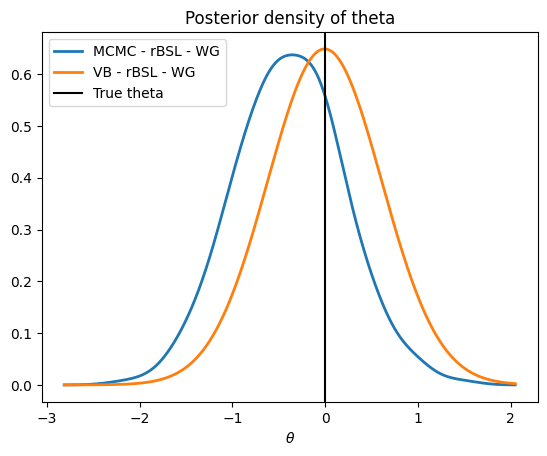

In [ ]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(mcmc_nuissance_wasserstein_mean-4*mcmc_nuissance_wasserstein_std,np.mean(best_theta)-4*np.std(best_theta)), max(mcmc_nuissance_wasserstein_mean+4*mcmc_nuissance_wasserstein_std, np.mean(best_theta)+4*np.std(best_theta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.185, kernel='gaussian')
kde_mcmc.fit(best_theta_mcmc.reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.615, kernel='gaussian')
kde_vb.fit(best_theta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True theta')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')